## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (512, 217)
Hypercube shape: (512, 217, 204)


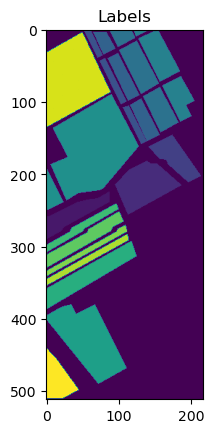

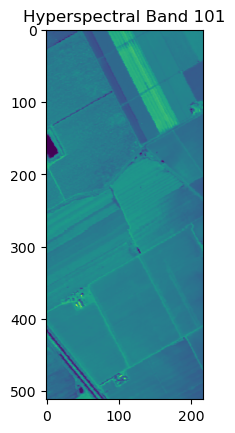

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Salinas_gt.mat'
data_files = 'Salinas_corrected.mat'
label_files = 'salinas_gt'
hypercube_files = 'salinas_corrected'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 54129
Extracted windows shape: (54129, 5, 5, 204)
Corresponding labels shape: (54129,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 10)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 2009 samples
Shuffled class indices for class '1'
Selected 10 training samples and 5 validation samples for class '1'

Class: 2: Found 3726 samples
Shuffled class indices for class '2'
Selected 10 training samples and 5 validation samples for class '2'

Class: 3: Found 1976 samples
Shuffled class indices for class '3'
Selected 10 training samples and 5 validation samples for class '3'

Class: 4: Found 1394 samples
Shuffled class indices for class '4'
Selected 10 training samples and 5 validation samples for class '4'

Class: 5: Found 2678 samples
Shuffled class indices for class '5'
Selected 10 training samples and 5 validation samples for class '5'

Class: 6: Found 3959 samples
Shuffled class indices for class '6'
Selected 10 training samples and 5 validation samples for class '6'

Class: 7: Found 3579 samples
Shuffled class indices fo


 -- Test set created with: 
	53889 samples
	shape (53889, 5, 5, 204) --




All datasets saved to the 'indices' folder.
(160, 5, 5, 204)
(80, 5, 5, 204)
(53889, 5, 5, 204)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 160
Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10, 14: 10, 15: 10}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (43303, 5, 5, 204)
Validation data shape: (10826, 5, 5, 204)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

204


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/677], Loss: 0.1595, PSNR: 7.1286


	 Training Batch [200/677], Loss: 0.0908, PSNR: 9.5728


	 Training Batch [400/677], Loss: 0.0455, PSNR: 12.5004


	 Training Batch [600/677], Loss: 0.0255, PSNR: 15.0915


Epoch [1/50] Training Loss: 0.0678, PSNR: 11.5776
	[Val]   Batch [1/170] Loss: 0.0209, PSNR: 15.8900
	[Val]   Batch [10/170] Loss: 0.0205, PSNR: 16.0595
	[Val]   Batch [20/170] Loss: 0.0206, PSNR: 15.9582
	[Val]   Batch [30/170] Loss: 0.0214, PSNR: 15.7461
	[Val]   Batch [40/170] Loss: 0.0215, PSNR: 15.8183


	[Val]   Batch [50/170] Loss: 0.0203, PSNR: 16.0327
	[Val]   Batch [60/170] Loss: 0.0213, PSNR: 15.9059
	[Val]   Batch [70/170] Loss: 0.0208, PSNR: 15.9913
	[Val]   Batch [80/170] Loss: 0.0211, PSNR: 15.8162
	[Val]   Batch [90/170] Loss: 0.0205, PSNR: 16.0482
	[Val]   Batch [100/170] Loss: 0.0206, PSNR: 15.9723


	[Val]   Batch [110/170] Loss: 0.0206, PSNR: 15.9632
	[Val]   Batch [120/170] Loss: 0.0194, PSNR: 14.2714
	[Val]   Batch [130/170] Loss: 0.0205, PSNR: 16.0573
	[Val]   Batch [140/170] Loss: 0.0201, PSNR: 16.1135
	[Val]   Batch [150/170] Loss: 0.0215, PSNR: 15.8575
	[Val]   Batch [160/170] Loss: 0.0212, PSNR: 15.8903


	[Val]   Batch [170/170] Loss: 0.0218, PSNR: 15.2011
Epoch [1/50] Validation Loss: 0.0208, PSNR: 15.8819

LOG: Epoch [2/50]
	 Training Batch [1/677], Loss: 0.0208, PSNR: 15.9756


	 Training Batch [200/677], Loss: 0.0145, PSNR: 17.4882


	 Training Batch [400/677], Loss: 0.0105, PSNR: 18.5330


	 Training Batch [600/677], Loss: 0.0083, PSNR: 19.8539


Epoch [2/50] Training Loss: 0.0127, PSNR: 18.2011
	[Val]   Batch [1/170] Loss: 0.0083, PSNR: 19.9093
	[Val]   Batch [10/170] Loss: 0.0078, PSNR: 20.2435
	[Val]   Batch [20/170] Loss: 0.0079, PSNR: 20.1124
	[Val]   Batch [30/170] Loss: 0.0086, PSNR: 19.7243
	[Val]   Batch [40/170] Loss: 0.0088, PSNR: 19.7081


	[Val]   Batch [50/170] Loss: 0.0077, PSNR: 20.2395
	[Val]   Batch [60/170] Loss: 0.0085, PSNR: 19.8653
	[Val]   Batch [70/170] Loss: 0.0083, PSNR: 19.9663
	[Val]   Batch [80/170] Loss: 0.0084, PSNR: 19.8311
	[Val]   Batch [90/170] Loss: 0.0081, PSNR: 20.1029
	[Val]   Batch [100/170] Loss: 0.0081, PSNR: 20.0275


	[Val]   Batch [110/170] Loss: 0.0080, PSNR: 20.0866
	[Val]   Batch [120/170] Loss: 0.0070, PSNR: 18.6898
	[Val]   Batch [130/170] Loss: 0.0080, PSNR: 20.1291
	[Val]   Batch [140/170] Loss: 0.0075, PSNR: 20.3803
	[Val]   Batch [150/170] Loss: 0.0087, PSNR: 19.7732


	[Val]   Batch [160/170] Loss: 0.0085, PSNR: 19.8606
	[Val]   Batch [170/170] Loss: 0.0087, PSNR: 19.2068
Epoch [2/50] Validation Loss: 0.0082, PSNR: 19.9558

LOG: Epoch [3/50]
	 Training Batch [1/677], Loss: 0.0082, PSNR: 19.9741


	 Training Batch [200/677], Loss: 0.0068, PSNR: 20.8242


	 Training Batch [400/677], Loss: 0.0053, PSNR: 21.5201


	 Training Batch [600/677], Loss: 0.0043, PSNR: 22.7705


Epoch [3/50] Training Loss: 0.0060, PSNR: 21.3476
	[Val]   Batch [1/170] Loss: 0.0043, PSNR: 22.7788
	[Val]   Batch [10/170] Loss: 0.0041, PSNR: 23.0271
	[Val]   Batch [20/170] Loss: 0.0041, PSNR: 22.9384
	[Val]   Batch [30/170] Loss: 0.0045, PSNR: 22.5335
	[Val]   Batch [40/170] Loss: 0.0045, PSNR: 22.6239


	[Val]   Batch [50/170] Loss: 0.0041, PSNR: 22.9384
	[Val]   Batch [60/170] Loss: 0.0044, PSNR: 22.7108
	[Val]   Batch [70/170] Loss: 0.0043, PSNR: 22.8866
	[Val]   Batch [80/170] Loss: 0.0043, PSNR: 22.7087
	[Val]   Batch [90/170] Loss: 0.0042, PSNR: 22.9118
	[Val]   Batch [100/170] Loss: 0.0043, PSNR: 22.7572


	[Val]   Batch [110/170] Loss: 0.0042, PSNR: 22.8922
	[Val]   Batch [120/170] Loss: 0.0038, PSNR: 21.3193
	[Val]   Batch [130/170] Loss: 0.0043, PSNR: 22.8660
	[Val]   Batch [140/170] Loss: 0.0039, PSNR: 23.1838
	[Val]   Batch [150/170] Loss: 0.0045, PSNR: 22.6539


	[Val]   Batch [160/170] Loss: 0.0044, PSNR: 22.7558
	[Val]   Batch [170/170] Loss: 0.0044, PSNR: 22.1171
Epoch [3/50] Validation Loss: 0.0043, PSNR: 22.7850

LOG: Epoch [4/50]
	 Training Batch [1/677], Loss: 0.0043, PSNR: 22.7124


	 Training Batch [200/677], Loss: 0.0037, PSNR: 23.4604


	 Training Batch [400/677], Loss: 0.0032, PSNR: 23.9921


	 Training Batch [600/677], Loss: 0.0033, PSNR: 23.9388


Epoch [4/50] Training Loss: 0.0034, PSNR: 23.8608
	[Val]   Batch [1/170] Loss: 0.0025, PSNR: 25.0984
	[Val]   Batch [10/170] Loss: 0.0024, PSNR: 25.3543
	[Val]   Batch [20/170] Loss: 0.0025, PSNR: 25.2003
	[Val]   Batch [30/170] Loss: 0.0027, PSNR: 24.7418
	[Val]   Batch [40/170] Loss: 0.0026, PSNR: 25.0213
	[Val]   Batch [50/170] Loss: 0.0025, PSNR: 25.1983


	[Val]   Batch [60/170] Loss: 0.0026, PSNR: 24.9784
	[Val]   Batch [70/170] Loss: 0.0025, PSNR: 25.2678
	[Val]   Batch [80/170] Loss: 0.0025, PSNR: 25.0318
	[Val]   Batch [90/170] Loss: 0.0025, PSNR: 25.2195
	[Val]   Batch [100/170] Loss: 0.0026, PSNR: 24.9353
	[Val]   Batch [110/170] Loss: 0.0024, PSNR: 25.2852


	[Val]   Batch [120/170] Loss: 0.0023, PSNR: 23.4706
	[Val]   Batch [130/170] Loss: 0.0026, PSNR: 25.0081
	[Val]   Batch [140/170] Loss: 0.0023, PSNR: 25.5069
	[Val]   Batch [150/170] Loss: 0.0027, PSNR: 24.9429
	[Val]   Batch [160/170] Loss: 0.0026, PSNR: 25.0757


	[Val]   Batch [170/170] Loss: 0.0027, PSNR: 24.3399
Epoch [4/50] Validation Loss: 0.0025, PSNR: 25.0626

LOG: Epoch [5/50]
	 Training Batch [1/677], Loss: 0.0026, PSNR: 24.6877


	 Training Batch [200/677], Loss: 0.0027, PSNR: 24.7294


	 Training Batch [400/677], Loss: 0.0022, PSNR: 25.7497


	 Training Batch [600/677], Loss: 0.0020, PSNR: 25.9928


Epoch [5/50] Training Loss: 0.0023, PSNR: 25.5203
	[Val]   Batch [1/170] Loss: 0.0017, PSNR: 26.7105
	[Val]   Batch [10/170] Loss: 0.0017, PSNR: 26.9644
	[Val]   Batch [20/170] Loss: 0.0017, PSNR: 26.7384
	[Val]   Batch [30/170] Loss: 0.0019, PSNR: 26.2462
	[Val]   Batch [40/170] Loss: 0.0018, PSNR: 26.7003


	[Val]   Batch [50/170] Loss: 0.0017, PSNR: 26.7460
	[Val]   Batch [60/170] Loss: 0.0018, PSNR: 26.5370
	[Val]   Batch [70/170] Loss: 0.0017, PSNR: 26.9412
	[Val]   Batch [80/170] Loss: 0.0018, PSNR: 26.6252
	[Val]   Batch [90/170] Loss: 0.0017, PSNR: 26.8328


	[Val]   Batch [100/170] Loss: 0.0019, PSNR: 26.4329
	[Val]   Batch [110/170] Loss: 0.0016, PSNR: 26.9991
	[Val]   Batch [120/170] Loss: 0.0017, PSNR: 24.9525
	[Val]   Batch [130/170] Loss: 0.0019, PSNR: 26.4898
	[Val]   Batch [140/170] Loss: 0.0016, PSNR: 27.1158


	[Val]   Batch [150/170] Loss: 0.0019, PSNR: 26.4938
	[Val]   Batch [160/170] Loss: 0.0018, PSNR: 26.6707
	[Val]   Batch [170/170] Loss: 0.0019, PSNR: 25.8948
Epoch [5/50] Validation Loss: 0.0018, PSNR: 26.6313

LOG: Epoch [6/50]
	 Training Batch [1/677], Loss: 0.0019, PSNR: 26.2438


	 Training Batch [200/677], Loss: 0.0017, PSNR: 26.9767


	 Training Batch [400/677], Loss: 0.0017, PSNR: 26.8919


	 Training Batch [600/677], Loss: 0.0015, PSNR: 27.2598


Epoch [6/50] Training Loss: 0.0017, PSNR: 26.6878
	[Val]   Batch [1/170] Loss: 0.0014, PSNR: 27.7434
	[Val]   Batch [10/170] Loss: 0.0013, PSNR: 28.0125
	[Val]   Batch [20/170] Loss: 0.0014, PSNR: 27.7342
	[Val]   Batch [30/170] Loss: 0.0015, PSNR: 27.2142
	[Val]   Batch [40/170] Loss: 0.0014, PSNR: 27.7707


	[Val]   Batch [50/170] Loss: 0.0014, PSNR: 27.7266
	[Val]   Batch [60/170] Loss: 0.0015, PSNR: 27.5421
	[Val]   Batch [70/170] Loss: 0.0013, PSNR: 28.0040
	[Val]   Batch [80/170] Loss: 0.0014, PSNR: 27.6582
	[Val]   Batch [90/170] Loss: 0.0014, PSNR: 27.8621
	[Val]   Batch [100/170] Loss: 0.0015, PSNR: 27.3928


	[Val]   Batch [110/170] Loss: 0.0013, PSNR: 28.1140
	[Val]   Batch [120/170] Loss: 0.0013, PSNR: 25.9134
	[Val]   Batch [130/170] Loss: 0.0015, PSNR: 27.4450
	[Val]   Batch [140/170] Loss: 0.0013, PSNR: 28.1726
	[Val]   Batch [150/170] Loss: 0.0015, PSNR: 27.4908


	[Val]   Batch [160/170] Loss: 0.0014, PSNR: 27.6931
	[Val]   Batch [170/170] Loss: 0.0015, PSNR: 26.9397
Epoch [6/50] Validation Loss: 0.0014, PSNR: 27.6454

LOG: Epoch [7/50]
	 Training Batch [1/677], Loss: 0.0015, PSNR: 27.3750


	 Training Batch [200/677], Loss: 0.0017, PSNR: 26.8985


	 Training Batch [400/677], Loss: 0.0014, PSNR: 27.5676


	 Training Batch [600/677], Loss: 0.0013, PSNR: 27.8604


Epoch [7/50] Training Loss: 0.0014, PSNR: 27.5550
	[Val]   Batch [1/170] Loss: 0.0011, PSNR: 28.5935
	[Val]   Batch [10/170] Loss: 0.0011, PSNR: 28.8158
	[Val]   Batch [20/170] Loss: 0.0011, PSNR: 28.5288
	[Val]   Batch [30/170] Loss: 0.0013, PSNR: 27.9851
	[Val]   Batch [40/170] Loss: 0.0011, PSNR: 28.6369
	[Val]   Batch [50/170] Loss: 0.0012, PSNR: 28.4744


	[Val]   Batch [60/170] Loss: 0.0012, PSNR: 28.3440
	[Val]   Batch [70/170] Loss: 0.0011, PSNR: 28.9053
	[Val]   Batch [80/170] Loss: 0.0011, PSNR: 28.4688
	[Val]   Batch [90/170] Loss: 0.0011, PSNR: 28.7138
	[Val]   Batch [100/170] Loss: 0.0012, PSNR: 28.1718


	[Val]   Batch [110/170] Loss: 0.0010, PSNR: 28.9951
	[Val]   Batch [120/170] Loss: 0.0011, PSNR: 26.6734
	[Val]   Batch [130/170] Loss: 0.0012, PSNR: 28.2274
	[Val]   Batch [140/170] Loss: 0.0010, PSNR: 28.9970
	[Val]   Batch [150/170] Loss: 0.0012, PSNR: 28.2773


	[Val]   Batch [160/170] Loss: 0.0012, PSNR: 28.5371
	[Val]   Batch [170/170] Loss: 0.0012, PSNR: 27.7832
Epoch [7/50] Validation Loss: 0.0012, PSNR: 28.4508

LOG: Epoch [8/50]
	 Training Batch [1/677], Loss: 0.0012, PSNR: 28.3571


	 Training Batch [200/677], Loss: 0.0013, PSNR: 28.0006


	 Training Batch [400/677], Loss: 0.0012, PSNR: 28.3062


	 Training Batch [600/677], Loss: 0.0011, PSNR: 28.5372


Epoch [8/50] Training Loss: 0.0012, PSNR: 28.2793
	[Val]   Batch [1/170] Loss: 0.0009, PSNR: 29.4251
	[Val]   Batch [10/170] Loss: 0.0009, PSNR: 29.6535
	[Val]   Batch [20/170] Loss: 0.0010, PSNR: 29.3161
	[Val]   Batch [30/170] Loss: 0.0011, PSNR: 28.7668
	[Val]   Batch [40/170] Loss: 0.0009, PSNR: 29.5007
	[Val]   Batch [50/170] Loss: 0.0010, PSNR: 29.2068


	[Val]   Batch [60/170] Loss: 0.0010, PSNR: 29.1597
	[Val]   Batch [70/170] Loss: 0.0009, PSNR: 29.7909
	[Val]   Batch [80/170] Loss: 0.0009, PSNR: 29.3284
	[Val]   Batch [90/170] Loss: 0.0009, PSNR: 29.5473
	[Val]   Batch [100/170] Loss: 0.0010, PSNR: 28.9591
	[Val]   Batch [110/170] Loss: 0.0008, PSNR: 29.8855


	[Val]   Batch [120/170] Loss: 0.0010, PSNR: 27.3697
	[Val]   Batch [130/170] Loss: 0.0010, PSNR: 29.0147
	[Val]   Batch [140/170] Loss: 0.0009, PSNR: 29.8194
	[Val]   Batch [150/170] Loss: 0.0010, PSNR: 29.0892
	[Val]   Batch [160/170] Loss: 0.0010, PSNR: 29.3660


	[Val]   Batch [170/170] Loss: 0.0010, PSNR: 28.6655
Epoch [8/50] Validation Loss: 0.0010, PSNR: 29.2655

LOG: Epoch [9/50]
	 Training Batch [1/677], Loss: 0.0010, PSNR: 28.9012


	 Training Batch [200/677], Loss: 0.0011, PSNR: 28.6200


	 Training Batch [400/677], Loss: 0.0009, PSNR: 29.3223


	 Training Batch [600/677], Loss: 0.0011, PSNR: 28.7931


Epoch [9/50] Training Loss: 0.0010, PSNR: 28.9143
	[Val]   Batch [1/170] Loss: 0.0008, PSNR: 30.2898
	[Val]   Batch [10/170] Loss: 0.0007, PSNR: 30.5353
	[Val]   Batch [20/170] Loss: 0.0008, PSNR: 30.1752
	[Val]   Batch [30/170] Loss: 0.0009, PSNR: 29.5873
	[Val]   Batch [40/170] Loss: 0.0007, PSNR: 30.3910
	[Val]   Batch [50/170] Loss: 0.0008, PSNR: 30.0005


	[Val]   Batch [60/170] Loss: 0.0008, PSNR: 30.0056
	[Val]   Batch [70/170] Loss: 0.0007, PSNR: 30.6785
	[Val]   Batch [80/170] Loss: 0.0008, PSNR: 30.2268
	[Val]   Batch [90/170] Loss: 0.0007, PSNR: 30.4212
	[Val]   Batch [100/170] Loss: 0.0009, PSNR: 29.7594
	[Val]   Batch [110/170] Loss: 0.0007, PSNR: 30.8129


	[Val]   Batch [120/170] Loss: 0.0008, PSNR: 28.1306
	[Val]   Batch [130/170] Loss: 0.0009, PSNR: 29.8336
	[Val]   Batch [140/170] Loss: 0.0007, PSNR: 30.7063
	[Val]   Batch [150/170] Loss: 0.0008, PSNR: 29.9322
	[Val]   Batch [160/170] Loss: 0.0008, PSNR: 30.2208


	[Val]   Batch [170/170] Loss: 0.0008, PSNR: 29.5820
Epoch [9/50] Validation Loss: 0.0008, PSNR: 30.1206

LOG: Epoch [10/50]
	 Training Batch [1/677], Loss: 0.0009, PSNR: 29.5862


	 Training Batch [200/677], Loss: 0.0010, PSNR: 29.2794


	 Training Batch [400/677], Loss: 0.0010, PSNR: 29.1548


	 Training Batch [600/677], Loss: 0.0008, PSNR: 30.2576


Epoch [10/50] Training Loss: 0.0009, PSNR: 29.5028
	[Val]   Batch [1/170] Loss: 0.0006, PSNR: 31.0013
	[Val]   Batch [10/170] Loss: 0.0006, PSNR: 31.2475
	[Val]   Batch [20/170] Loss: 0.0007, PSNR: 30.8747
	[Val]   Batch [30/170] Loss: 0.0008, PSNR: 30.2807
	[Val]   Batch [40/170] Loss: 0.0006, PSNR: 31.1155
	[Val]   Batch [50/170] Loss: 0.0007, PSNR: 30.6801


	[Val]   Batch [60/170] Loss: 0.0007, PSNR: 30.7035
	[Val]   Batch [70/170] Loss: 0.0006, PSNR: 31.3844
	[Val]   Batch [80/170] Loss: 0.0006, PSNR: 30.9626
	[Val]   Batch [90/170] Loss: 0.0006, PSNR: 31.1753
	[Val]   Batch [100/170] Loss: 0.0007, PSNR: 30.4776
	[Val]   Batch [110/170] Loss: 0.0006, PSNR: 31.5545


	[Val]   Batch [120/170] Loss: 0.0007, PSNR: 28.8253
	[Val]   Batch [130/170] Loss: 0.0007, PSNR: 30.5466
	[Val]   Batch [140/170] Loss: 0.0006, PSNR: 31.4424
	[Val]   Batch [150/170] Loss: 0.0007, PSNR: 30.6338
	[Val]   Batch [160/170] Loss: 0.0007, PSNR: 30.8809
	[Val]   Batch [170/170] Loss: 0.0007, PSNR: 30.3119
Epoch [10/50] Validation Loss: 0.0007, PSNR: 30.8286

LOG: Epoch [11/50]


	 Training Batch [1/677], Loss: 0.0009, PSNR: 29.6759


	 Training Batch [200/677], Loss: 0.0007, PSNR: 30.8045


	 Training Batch [400/677], Loss: 0.0009, PSNR: 29.6724


	 Training Batch [600/677], Loss: 0.0006, PSNR: 31.0303


Epoch [11/50] Training Loss: 0.0008, PSNR: 30.0438
	[Val]   Batch [1/170] Loss: 0.0006, PSNR: 31.6817
	[Val]   Batch [10/170] Loss: 0.0005, PSNR: 31.9357
	[Val]   Batch [20/170] Loss: 0.0006, PSNR: 31.5505
	[Val]   Batch [30/170] Loss: 0.0006, PSNR: 30.9726
	[Val]   Batch [40/170] Loss: 0.0005, PSNR: 31.7746
	[Val]   Batch [50/170] Loss: 0.0006, PSNR: 31.3269


	[Val]   Batch [60/170] Loss: 0.0006, PSNR: 31.3970
	[Val]   Batch [70/170] Loss: 0.0005, PSNR: 32.0466
	[Val]   Batch [80/170] Loss: 0.0005, PSNR: 31.6660
	[Val]   Batch [90/170] Loss: 0.0005, PSNR: 31.8932
	[Val]   Batch [100/170] Loss: 0.0006, PSNR: 31.1882


	[Val]   Batch [110/170] Loss: 0.0005, PSNR: 32.2648
	[Val]   Batch [120/170] Loss: 0.0006, PSNR: 29.5170
	[Val]   Batch [130/170] Loss: 0.0006, PSNR: 31.2609
	[Val]   Batch [140/170] Loss: 0.0005, PSNR: 32.1462
	[Val]   Batch [150/170] Loss: 0.0006, PSNR: 31.3244
	[Val]   Batch [160/170] Loss: 0.0006, PSNR: 31.5313


	[Val]   Batch [170/170] Loss: 0.0006, PSNR: 31.1078
Epoch [11/50] Validation Loss: 0.0006, PSNR: 31.5123

LOG: Epoch [12/50]
	 Training Batch [1/677], Loss: 0.0007, PSNR: 29.9523


	 Training Batch [200/677], Loss: 0.0007, PSNR: 30.4455


	 Training Batch [400/677], Loss: 0.0008, PSNR: 29.8088


	 Training Batch [600/677], Loss: 0.0006, PSNR: 31.0707


Epoch [12/50] Training Loss: 0.0007, PSNR: 30.5598
	[Val]   Batch [1/170] Loss: 0.0005, PSNR: 32.2906
	[Val]   Batch [10/170] Loss: 0.0005, PSNR: 32.5786
	[Val]   Batch [20/170] Loss: 0.0005, PSNR: 32.1400
	[Val]   Batch [30/170] Loss: 0.0006, PSNR: 31.6318
	[Val]   Batch [40/170] Loss: 0.0005, PSNR: 32.3503


	[Val]   Batch [50/170] Loss: 0.0005, PSNR: 31.9257
	[Val]   Batch [60/170] Loss: 0.0005, PSNR: 32.0358
	[Val]   Batch [70/170] Loss: 0.0005, PSNR: 32.6091
	[Val]   Batch [80/170] Loss: 0.0005, PSNR: 32.2989
	[Val]   Batch [90/170] Loss: 0.0005, PSNR: 32.5751
	[Val]   Batch [100/170] Loss: 0.0005, PSNR: 31.8819


	[Val]   Batch [110/170] Loss: 0.0004, PSNR: 32.8566
	[Val]   Batch [120/170] Loss: 0.0005, PSNR: 30.1977
	[Val]   Batch [130/170] Loss: 0.0005, PSNR: 31.9629
	[Val]   Batch [140/170] Loss: 0.0004, PSNR: 32.7836
	[Val]   Batch [150/170] Loss: 0.0005, PSNR: 31.9796
	[Val]   Batch [160/170] Loss: 0.0005, PSNR: 32.1101


	[Val]   Batch [170/170] Loss: 0.0005, PSNR: 31.7961
Epoch [12/50] Validation Loss: 0.0005, PSNR: 32.1389

LOG: Epoch [13/50]
	 Training Batch [1/677], Loss: 0.0006, PSNR: 31.4794


	 Training Batch [200/677], Loss: 0.0007, PSNR: 30.7467


	 Training Batch [400/677], Loss: 0.0008, PSNR: 30.1339


	 Training Batch [600/677], Loss: 0.0006, PSNR: 31.0834


Epoch [13/50] Training Loss: 0.0006, PSNR: 31.0234
	[Val]   Batch [1/170] Loss: 0.0004, PSNR: 32.8565
	[Val]   Batch [10/170] Loss: 0.0004, PSNR: 33.1626
	[Val]   Batch [20/170] Loss: 0.0004, PSNR: 32.6723
	[Val]   Batch [30/170] Loss: 0.0005, PSNR: 32.2422
	[Val]   Batch [40/170] Loss: 0.0004, PSNR: 32.9523


	[Val]   Batch [50/170] Loss: 0.0005, PSNR: 32.4478
	[Val]   Batch [60/170] Loss: 0.0004, PSNR: 32.6549
	[Val]   Batch [70/170] Loss: 0.0004, PSNR: 33.1601
	[Val]   Batch [80/170] Loss: 0.0004, PSNR: 32.9230
	[Val]   Batch [90/170] Loss: 0.0004, PSNR: 33.2216


	[Val]   Batch [100/170] Loss: 0.0005, PSNR: 32.5557
	[Val]   Batch [110/170] Loss: 0.0004, PSNR: 33.4315
	[Val]   Batch [120/170] Loss: 0.0004, PSNR: 30.7330
	[Val]   Batch [130/170] Loss: 0.0005, PSNR: 32.6372
	[Val]   Batch [140/170] Loss: 0.0004, PSNR: 33.3136
	[Val]   Batch [150/170] Loss: 0.0005, PSNR: 32.6197


	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 32.6381
	[Val]   Batch [170/170] Loss: 0.0004, PSNR: 32.5278
Epoch [13/50] Validation Loss: 0.0004, PSNR: 32.7286

LOG: Epoch [14/50]
	 Training Batch [1/677], Loss: 0.0006, PSNR: 31.0587


	 Training Batch [200/677], Loss: 0.0007, PSNR: 30.9994


	 Training Batch [400/677], Loss: 0.0005, PSNR: 32.0596


	 Training Batch [600/677], Loss: 0.0007, PSNR: 29.5894


Epoch [14/50] Training Loss: 0.0006, PSNR: 31.4833
	[Val]   Batch [1/170] Loss: 0.0004, PSNR: 33.4964
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 33.8399
	[Val]   Batch [20/170] Loss: 0.0004, PSNR: 33.2780
	[Val]   Batch [30/170] Loss: 0.0004, PSNR: 32.9568
	[Val]   Batch [40/170] Loss: 0.0004, PSNR: 33.5978


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 33.0399
	[Val]   Batch [60/170] Loss: 0.0004, PSNR: 33.3587
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 33.7482
	[Val]   Batch [80/170] Loss: 0.0004, PSNR: 33.6243
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 33.9092
	[Val]   Batch [100/170] Loss: 0.0004, PSNR: 33.2696


	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.0714
	[Val]   Batch [120/170] Loss: 0.0004, PSNR: 31.4048
	[Val]   Batch [130/170] Loss: 0.0004, PSNR: 33.3568
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 33.9696
	[Val]   Batch [150/170] Loss: 0.0004, PSNR: 33.3520


	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 33.2497
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 33.3701
Epoch [14/50] Validation Loss: 0.0004, PSNR: 33.3962

LOG: Epoch [15/50]
	 Training Batch [1/677], Loss: 0.0004, PSNR: 32.5694


	 Training Batch [200/677], Loss: 0.0006, PSNR: 31.5556


	 Training Batch [400/677], Loss: 0.0005, PSNR: 31.9995


	 Training Batch [600/677], Loss: 0.0004, PSNR: 32.7899


Epoch [15/50] Training Loss: 0.0005, PSNR: 31.8076
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 33.7435
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 34.1032
	[Val]   Batch [20/170] Loss: 0.0004, PSNR: 33.5105
	[Val]   Batch [30/170] Loss: 0.0004, PSNR: 33.3000
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 33.8352


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 33.3625
	[Val]   Batch [60/170] Loss: 0.0004, PSNR: 33.6774
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 33.9096
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 33.9086
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 34.2175


	[Val]   Batch [100/170] Loss: 0.0004, PSNR: 33.6195
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.3032
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 31.7275
	[Val]   Batch [130/170] Loss: 0.0004, PSNR: 33.7268
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.2335


	[Val]   Batch [150/170] Loss: 0.0004, PSNR: 33.6728
	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 33.4441
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 33.7084
Epoch [15/50] Validation Loss: 0.0003, PSNR: 33.6683

LOG: Epoch [16/50]
	 Training Batch [1/677], Loss: 0.0006, PSNR: 31.3282


	 Training Batch [200/677], Loss: 0.0005, PSNR: 32.5134


	 Training Batch [400/677], Loss: 0.0005, PSNR: 32.5117


	 Training Batch [600/677], Loss: 0.0005, PSNR: 32.2508


Epoch [16/50] Training Loss: 0.0005, PSNR: 32.1431
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.2790
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 34.5975
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 33.9535
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 33.8366
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.3992


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 33.7730
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 34.2641
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.4491
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.4730
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 34.8158
	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.2160


	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.8053
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.1425
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 34.3183
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.6987
	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.2525


	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 33.9425
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 34.3061
Epoch [16/50] Validation Loss: 0.0003, PSNR: 34.1926

LOG: Epoch [17/50]
	 Training Batch [1/677], Loss: 0.0005, PSNR: 32.0483


	 Training Batch [200/677], Loss: 0.0004, PSNR: 32.8770


	 Training Batch [400/677], Loss: 0.0004, PSNR: 33.0758


	 Training Batch [600/677], Loss: 0.0004, PSNR: 32.6687


Epoch [17/50] Training Loss: 0.0005, PSNR: 32.4355
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.7111
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 35.0507
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.3903
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.3199
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.7745


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.2086
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 34.7140
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.8356
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.9203
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 35.3033


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.7167
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 35.2522
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.6791
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 34.8317
	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 35.1867


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.7185
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.3593
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 34.8455
Epoch [17/50] Validation Loss: 0.0003, PSNR: 34.6459
Early stopping triggered at epoch 17. No improvement for 3 epochs.


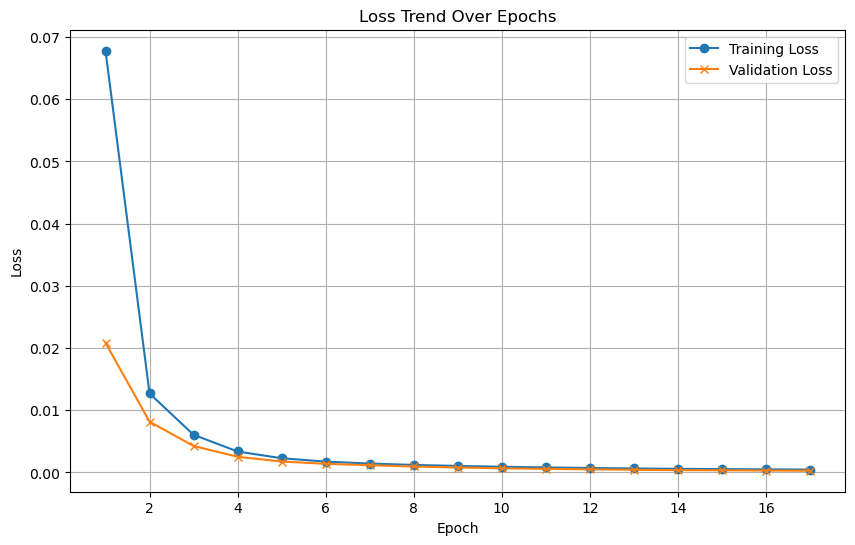

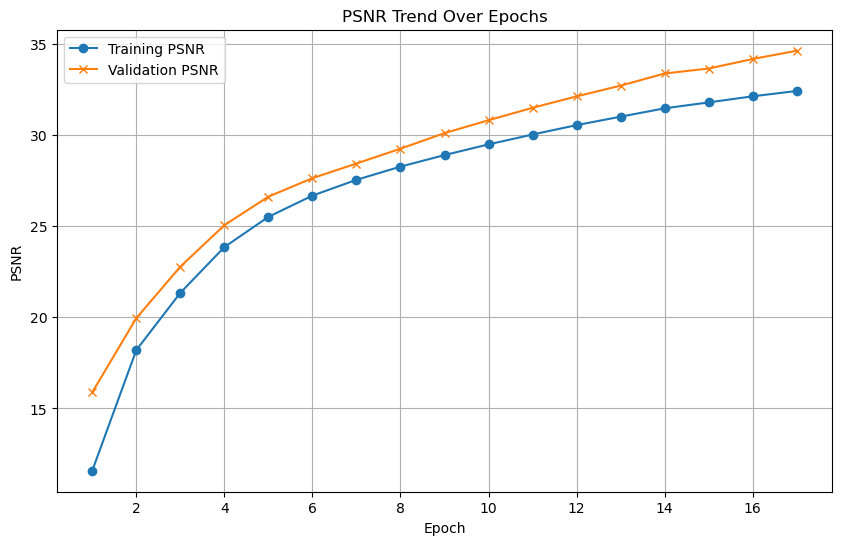

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/211 for test dataset.


    Processed batch 101/211 for test dataset.


    Processed batch 201/211 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.8014
    Validation Batch [1/1], Loss: 2.7772
Validation Loss: 2.7772, Validation Accuracy: 6.25%
Validation loss improved from inf to 2.7772. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.7635
    Validation Batch [1/1], Loss: 2.7772
Validation Loss: 2.7772, Validation Accuracy: 6.25%
Validation loss improved from 2.7772 to 2.7772. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.7313
    Validation Batch [1/1], Loss: 2.7772
Validation Loss: 2.7772, Validation Accuracy: 6.25%
Validation loss improved from 2.7772 to 2.7772. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.7040
    Validation Batch [1/1], Loss: 2.7772
Validation Loss: 2.7772, Validation Accuracy: 6.25%
Validation loss improved from 2.7772 to 2.7772. Saving model...

LOG: Epoch [5/1000] - 

Epoch [19/1000] completed, Average Training Loss: 2.5266
    Validation Batch [1/1], Loss: 2.7737
Validation Loss: 2.7737, Validation Accuracy: 12.50%
Validation loss improved from 2.7747 to 2.7737. Saving model...

LOG: Epoch [20/1000] - Training
Epoch [20/1000] completed, Average Training Loss: 2.5330
    Validation Batch [1/1], Loss: 2.7731
Validation Loss: 2.7731, Validation Accuracy: 10.00%
Validation loss improved from 2.7737 to 2.7731. Saving model...

LOG: Epoch [21/1000] - Training
Epoch [21/1000] completed, Average Training Loss: 2.5056
    Validation Batch [1/1], Loss: 2.7723
Validation Loss: 2.7723, Validation Accuracy: 6.25%
Validation loss improved from 2.7731 to 2.7723. Saving model...

LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 2.4945
    Validation Batch [1/1], Loss: 2.7715
Validation Loss: 2.7715, Validation Accuracy: 6.25%
Validation loss improved from 2.7723 to 2.7715. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/

Epoch [46/1000] completed, Average Training Loss: 2.2957
    Validation Batch [1/1], Loss: 2.6281
Validation Loss: 2.6281, Validation Accuracy: 26.25%
Validation loss improved from 2.6424 to 2.6281. Saving model...

LOG: Epoch [47/1000] - Training
Epoch [47/1000] completed, Average Training Loss: 2.2930
    Validation Batch [1/1], Loss: 2.6130
Validation Loss: 2.6130, Validation Accuracy: 26.25%
Validation loss improved from 2.6281 to 2.6130. Saving model...

LOG: Epoch [48/1000] - Training
Epoch [48/1000] completed, Average Training Loss: 2.2835
    Validation Batch [1/1], Loss: 2.5969
Validation Loss: 2.5969, Validation Accuracy: 30.00%
Validation loss improved from 2.6130 to 2.5969. Saving model...

LOG: Epoch [49/1000] - Training
Epoch [49/1000] completed, Average Training Loss: 2.2801
    Validation Batch [1/1], Loss: 2.5778
Validation Loss: 2.5778, Validation Accuracy: 31.25%
Validation loss improved from 2.5969 to 2.5778. Saving model...

LOG: Epoch [50/1000] - Training
Epoch [5

    Validation Batch [1/1], Loss: 2.1869
Validation Loss: 2.1869, Validation Accuracy: 60.00%
Validation loss improved from 2.2111 to 2.1869. Saving model...

LOG: Epoch [73/1000] - Training
Epoch [73/1000] completed, Average Training Loss: 2.0723
    Validation Batch [1/1], Loss: 2.1562
Validation Loss: 2.1562, Validation Accuracy: 60.00%
Validation loss improved from 2.1869 to 2.1562. Saving model...

LOG: Epoch [74/1000] - Training
Epoch [74/1000] completed, Average Training Loss: 2.0516
    Validation Batch [1/1], Loss: 2.1334
Validation Loss: 2.1334, Validation Accuracy: 63.75%
Validation loss improved from 2.1562 to 2.1334. Saving model...

LOG: Epoch [75/1000] - Training
Epoch [75/1000] completed, Average Training Loss: 2.0866
    Validation Batch [1/1], Loss: 2.1218
Validation Loss: 2.1218, Validation Accuracy: 66.25%
Validation loss improved from 2.1334 to 2.1218. Saving model...

LOG: Epoch [76/1000] - Training
Epoch [76/1000] completed, Average Training Loss: 2.0690
    Vali

Epoch [100/1000] completed, Average Training Loss: 1.8462
    Validation Batch [1/1], Loss: 1.8654
Validation Loss: 1.8654, Validation Accuracy: 72.50%
Validation loss improved from 1.8696 to 1.8654. Saving model...

LOG: Epoch [101/1000] - Training
Epoch [101/1000] completed, Average Training Loss: 1.8602
    Validation Batch [1/1], Loss: 1.8463
Validation Loss: 1.8463, Validation Accuracy: 68.75%
Validation loss improved from 1.8654 to 1.8463. Saving model...

LOG: Epoch [102/1000] - Training
Epoch [102/1000] completed, Average Training Loss: 1.8784
    Validation Batch [1/1], Loss: 1.8393
Validation Loss: 1.8393, Validation Accuracy: 70.00%
Validation loss improved from 1.8463 to 1.8393. Saving model...

LOG: Epoch [103/1000] - Training
Epoch [103/1000] completed, Average Training Loss: 1.8173
    Validation Batch [1/1], Loss: 1.8470
Validation Loss: 1.8470, Validation Accuracy: 73.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [104/1000] - Training
Epoch [104/1000

Epoch [129/1000] completed, Average Training Loss: 1.6504
    Validation Batch [1/1], Loss: 1.6052
Validation Loss: 1.6052, Validation Accuracy: 80.00%
Validation loss improved from 1.6222 to 1.6052. Saving model...

LOG: Epoch [130/1000] - Training
Epoch [130/1000] completed, Average Training Loss: 1.6009
    Validation Batch [1/1], Loss: 1.5978
Validation Loss: 1.5978, Validation Accuracy: 81.25%
Validation loss improved from 1.6052 to 1.5978. Saving model...

LOG: Epoch [131/1000] - Training
Epoch [131/1000] completed, Average Training Loss: 1.6052
    Validation Batch [1/1], Loss: 1.6140
Validation Loss: 1.6140, Validation Accuracy: 82.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [132/1000] - Training
Epoch [132/1000] completed, Average Training Loss: 1.6281
    Validation Batch [1/1], Loss: 1.5851
Validation Loss: 1.5851, Validation Accuracy: 80.00%
Validation loss improved from 1.5978 to 1.5851. Saving model...

LOG: Epoch [133/1000] - Training
Epoch [133/1000

    Validation Batch [1/1], Loss: 1.4004
Validation Loss: 1.4004, Validation Accuracy: 86.25%
Validation loss improved from 1.4105 to 1.4004. Saving model...

LOG: Epoch [158/1000] - Training
Epoch [158/1000] completed, Average Training Loss: 1.3982
    Validation Batch [1/1], Loss: 1.4139
Validation Loss: 1.4139, Validation Accuracy: 85.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [159/1000] - Training
Epoch [159/1000] completed, Average Training Loss: 1.3835
    Validation Batch [1/1], Loss: 1.3690
Validation Loss: 1.3690, Validation Accuracy: 86.25%
Validation loss improved from 1.4004 to 1.3690. Saving model...

LOG: Epoch [160/1000] - Training
Epoch [160/1000] completed, Average Training Loss: 1.3832
    Validation Batch [1/1], Loss: 1.3654
Validation Loss: 1.3654, Validation Accuracy: 86.25%
Validation loss improved from 1.3690 to 1.3654. Saving model...

LOG: Epoch [161/1000] - Training
Epoch [161/1000] completed, Average Training Loss: 1.4029
    Validation 

    Validation Batch [1/1], Loss: 1.2231
Validation Loss: 1.2231, Validation Accuracy: 87.50%
Validation loss improved from 1.2279 to 1.2231. Saving model...

LOG: Epoch [183/1000] - Training
Epoch [183/1000] completed, Average Training Loss: 1.2038
    Validation Batch [1/1], Loss: 1.2376
Validation Loss: 1.2376, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [184/1000] - Training
Epoch [184/1000] completed, Average Training Loss: 1.1859
    Validation Batch [1/1], Loss: 1.2308
Validation Loss: 1.2308, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [185/1000] - Training
Epoch [185/1000] completed, Average Training Loss: 1.2267
    Validation Batch [1/1], Loss: 1.2131
Validation Loss: 1.2131, Validation Accuracy: 86.25%
Validation loss improved from 1.2231 to 1.2131. Saving model...

LOG: Epoch [186/1000] - Training
Epoch [186/1000] completed, Average Training Loss: 1.1893
    Validation Batch [1/1], Lo

Epoch [210/1000] completed, Average Training Loss: 1.0253
    Validation Batch [1/1], Loss: 1.0667
Validation Loss: 1.0667, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [211/1000] - Training
Epoch [211/1000] completed, Average Training Loss: 1.0575
    Validation Batch [1/1], Loss: 1.0537
Validation Loss: 1.0537, Validation Accuracy: 87.50%
Validation loss improved from 1.0576 to 1.0537. Saving model...

LOG: Epoch [212/1000] - Training
Epoch [212/1000] completed, Average Training Loss: 1.0518
    Validation Batch [1/1], Loss: 1.0416
Validation Loss: 1.0416, Validation Accuracy: 87.50%
Validation loss improved from 1.0537 to 1.0416. Saving model...

LOG: Epoch [213/1000] - Training
Epoch [213/1000] completed, Average Training Loss: 1.0185
    Validation Batch [1/1], Loss: 1.0363
Validation Loss: 1.0363, Validation Accuracy: 87.50%
Validation loss improved from 1.0416 to 1.0363. Saving model...

LOG: Epoch [214/1000] - Training
Epoch [214/1000

Epoch [236/1000] completed, Average Training Loss: 0.8566
    Validation Batch [1/1], Loss: 0.8912
Validation Loss: 0.8912, Validation Accuracy: 88.75%
Validation loss improved from 0.8976 to 0.8912. Saving model...

LOG: Epoch [237/1000] - Training
Epoch [237/1000] completed, Average Training Loss: 0.8755
    Validation Batch [1/1], Loss: 0.8786
Validation Loss: 0.8786, Validation Accuracy: 88.75%
Validation loss improved from 0.8912 to 0.8786. Saving model...

LOG: Epoch [238/1000] - Training
Epoch [238/1000] completed, Average Training Loss: 0.8403
    Validation Batch [1/1], Loss: 0.8624
Validation Loss: 0.8624, Validation Accuracy: 90.00%
Validation loss improved from 0.8786 to 0.8624. Saving model...

LOG: Epoch [239/1000] - Training
Epoch [239/1000] completed, Average Training Loss: 0.8613
    Validation Batch [1/1], Loss: 0.8526
Validation Loss: 0.8526, Validation Accuracy: 88.75%
Validation loss improved from 0.8624 to 0.8526. Saving model...

LOG: Epoch [240/1000] - Training


Epoch [263/1000] completed, Average Training Loss: 0.6634
    Validation Batch [1/1], Loss: 0.7547
Validation Loss: 0.7547, Validation Accuracy: 90.00%
Validation loss improved from 0.7575 to 0.7547. Saving model...

LOG: Epoch [264/1000] - Training
Epoch [264/1000] completed, Average Training Loss: 0.6843
    Validation Batch [1/1], Loss: 0.7242
Validation Loss: 0.7242, Validation Accuracy: 90.00%
Validation loss improved from 0.7547 to 0.7242. Saving model...

LOG: Epoch [265/1000] - Training
Epoch [265/1000] completed, Average Training Loss: 0.6590
    Validation Batch [1/1], Loss: 0.7076
Validation Loss: 0.7076, Validation Accuracy: 90.00%
Validation loss improved from 0.7242 to 0.7076. Saving model...

LOG: Epoch [266/1000] - Training
Epoch [266/1000] completed, Average Training Loss: 0.6396
    Validation Batch [1/1], Loss: 0.7041
Validation Loss: 0.7041, Validation Accuracy: 90.00%
Validation loss improved from 0.7076 to 0.7041. Saving model...

LOG: Epoch [267/1000] - Training


Epoch [291/1000] completed, Average Training Loss: 0.5673
    Validation Batch [1/1], Loss: 0.6061
Validation Loss: 0.6061, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [292/1000] - Training
Epoch [292/1000] completed, Average Training Loss: 0.5357
    Validation Batch [1/1], Loss: 0.6013
Validation Loss: 0.6013, Validation Accuracy: 90.00%
Validation loss improved from 0.6030 to 0.6013. Saving model...

LOG: Epoch [293/1000] - Training
Epoch [293/1000] completed, Average Training Loss: 0.5581
    Validation Batch [1/1], Loss: 0.5871
Validation Loss: 0.5871, Validation Accuracy: 90.00%
Validation loss improved from 0.6013 to 0.5871. Saving model...

LOG: Epoch [294/1000] - Training
Epoch [294/1000] completed, Average Training Loss: 0.5581
    Validation Batch [1/1], Loss: 0.5720
Validation Loss: 0.5720, Validation Accuracy: 90.00%
Validation loss improved from 0.5871 to 0.5720. Saving model...

LOG: Epoch [295/1000] - Training
Epoch [295/1000

Epoch [318/1000] completed, Average Training Loss: 0.4331
    Validation Batch [1/1], Loss: 0.5012
Validation Loss: 0.5012, Validation Accuracy: 93.75%
Validation loss improved from 0.5075 to 0.5012. Saving model...

LOG: Epoch [319/1000] - Training
Epoch [319/1000] completed, Average Training Loss: 0.4509
    Validation Batch [1/1], Loss: 0.5019
Validation Loss: 0.5019, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [320/1000] - Training
Epoch [320/1000] completed, Average Training Loss: 0.4434
    Validation Batch [1/1], Loss: 0.5054
Validation Loss: 0.5054, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [321/1000] - Training
Epoch [321/1000] completed, Average Training Loss: 0.4537
    Validation Batch [1/1], Loss: 0.4971
Validation Loss: 0.4971, Validation Accuracy: 92.50%
Validation loss improved from 0.5012 to 0.4971. Saving model...

LOG: Epoch [322/1000] - Training
Epoch [322/1000] completed, Av

    Validation Batch [1/1], Loss: 0.4502
Validation Loss: 0.4502, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [346/1000] - Training
Epoch [346/1000] completed, Average Training Loss: 0.3828
    Validation Batch [1/1], Loss: 0.4281
Validation Loss: 0.4281, Validation Accuracy: 95.00%
Validation loss improved from 0.4402 to 0.4281. Saving model...

LOG: Epoch [347/1000] - Training
Epoch [347/1000] completed, Average Training Loss: 0.3411
    Validation Batch [1/1], Loss: 0.4313
Validation Loss: 0.4313, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [348/1000] - Training
Epoch [348/1000] completed, Average Training Loss: 0.3513
    Validation Batch [1/1], Loss: 0.4490
Validation Loss: 0.4490, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [349/1000] - Training
Epoch [349/1000] completed, Average Training Loss: 0.3058
    Validation Batch [1/1], Loss: 0.4341
Vali

Epoch [374/1000] completed, Average Training Loss: 0.2643
    Validation Batch [1/1], Loss: 0.4075
Validation Loss: 0.4075, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [375/1000] - Training
Epoch [375/1000] completed, Average Training Loss: 0.2617
    Validation Batch [1/1], Loss: 0.3987
Validation Loss: 0.3987, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [376/1000] - Training
Epoch [376/1000] completed, Average Training Loss: 0.2869
    Validation Batch [1/1], Loss: 0.3893
Validation Loss: 0.3893, Validation Accuracy: 95.00%
Validation loss improved from 0.3931 to 0.3893. Saving model...

LOG: Epoch [377/1000] - Training
Epoch [377/1000] completed, Average Training Loss: 0.2616
    Validation Batch [1/1], Loss: 0.3994
Validation Loss: 0.3994, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [378/1000] - Training
Epoch [378/1000] completed, Average Training 

Epoch [401/1000] completed, Average Training Loss: 0.2673
    Validation Batch [1/1], Loss: 0.3599
Validation Loss: 0.3599, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [402/1000] - Training
Epoch [402/1000] completed, Average Training Loss: 0.2458
    Validation Batch [1/1], Loss: 0.3653
Validation Loss: 0.3653, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [403/1000] - Training
Epoch [403/1000] completed, Average Training Loss: 0.2257
    Validation Batch [1/1], Loss: 0.3537
Validation Loss: 0.3537, Validation Accuracy: 95.00%
Validation loss improved from 0.3587 to 0.3537. Saving model...

LOG: Epoch [404/1000] - Training
Epoch [404/1000] completed, Average Training Loss: 0.2184
    Validation Batch [1/1], Loss: 0.3592
Validation Loss: 0.3592, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [405/1000] - Training
Epoch [405/1000] completed, Average Training 

Epoch [431/1000] completed, Average Training Loss: 0.1692
    Validation Batch [1/1], Loss: 0.3405
Validation Loss: 0.3405, Validation Accuracy: 92.50%
Validation loss improved from 0.3442 to 0.3405. Saving model...

LOG: Epoch [432/1000] - Training
Epoch [432/1000] completed, Average Training Loss: 0.1867
    Validation Batch [1/1], Loss: 0.3490
Validation Loss: 0.3490, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [433/1000] - Training
Epoch [433/1000] completed, Average Training Loss: 0.1667
    Validation Batch [1/1], Loss: 0.3487
Validation Loss: 0.3487, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [434/1000] - Training
Epoch [434/1000] completed, Average Training Loss: 0.2057
    Validation Batch [1/1], Loss: 0.3453
Validation Loss: 0.3453, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [435/1000] - Training
Epoch [435/1000] completed, Average Training 

Epoch [457/1000] completed, Average Training Loss: 0.1636
    Validation Batch [1/1], Loss: 0.3380
Validation Loss: 0.3380, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [458/1000] - Training
Epoch [458/1000] completed, Average Training Loss: 0.1746
    Validation Batch [1/1], Loss: 0.3396
Validation Loss: 0.3396, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [459/1000] - Training
Epoch [459/1000] completed, Average Training Loss: 0.1449
    Validation Batch [1/1], Loss: 0.3395
Validation Loss: 0.3395, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [460/1000] - Training
Epoch [460/1000] completed, Average Training Loss: 0.1496
    Validation Batch [1/1], Loss: 0.3415
Validation Loss: 0.3415, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [461/1000] - Training
Epoch [461/1000] completed, Average Training Loss: 0.145

Epoch [481/1000] completed, Average Training Loss: 0.1191
    Validation Batch [1/1], Loss: 0.3297
Validation Loss: 0.3297, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [482/1000] - Training
Epoch [482/1000] completed, Average Training Loss: 0.1550
    Validation Batch [1/1], Loss: 0.3334
Validation Loss: 0.3334, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [483/1000] - Training
Epoch [483/1000] completed, Average Training Loss: 0.1456
    Validation Batch [1/1], Loss: 0.3326
Validation Loss: 0.3326, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [484/1000] - Training
Epoch [484/1000] completed, Average Training Loss: 0.1231
    Validation Batch [1/1], Loss: 0.3285
Validation Loss: 0.3285, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [485/1000] - Training
Epoch [485/1000] completed, Average Training Loss: 0.1509
  

Epoch [509/1000] completed, Average Training Loss: 0.0938
    Validation Batch [1/1], Loss: 0.3373
Validation Loss: 0.3373, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [510/1000] - Training
Epoch [510/1000] completed, Average Training Loss: 0.1157
    Validation Batch [1/1], Loss: 0.3320
Validation Loss: 0.3320, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [511/1000] - Training
Epoch [511/1000] completed, Average Training Loss: 0.1113
    Validation Batch [1/1], Loss: 0.3229
Validation Loss: 0.3229, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [512/1000] - Training
Epoch [512/1000] completed, Average Training Loss: 0.1306
    Validation Batch [1/1], Loss: 0.3269
Validation Loss: 0.3269, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [513/1000] - Training
Epoch [513/1000] completed, Average Training Loss: 0.097

Epoch [535/1000] completed, Average Training Loss: 0.0903
    Validation Batch [1/1], Loss: 0.3315
Validation Loss: 0.3315, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [536/1000] - Training
Epoch [536/1000] completed, Average Training Loss: 0.0932
    Validation Batch [1/1], Loss: 0.3375
Validation Loss: 0.3375, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 58/100

LOG: Epoch [537/1000] - Training
Epoch [537/1000] completed, Average Training Loss: 0.1094
    Validation Batch [1/1], Loss: 0.3425
Validation Loss: 0.3425, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 59/100

LOG: Epoch [538/1000] - Training
Epoch [538/1000] completed, Average Training Loss: 0.0993
    Validation Batch [1/1], Loss: 0.3365
Validation Loss: 0.3365, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 60/100

LOG: Epoch [539/1000] - Training
Epoch [539/1000] completed, Average Training Loss: 0.117

    Validation Batch [1/1], Loss: 0.3291
Validation Loss: 0.3291, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 85/100

LOG: Epoch [564/1000] - Training
Epoch [564/1000] completed, Average Training Loss: 0.0956
    Validation Batch [1/1], Loss: 0.3309
Validation Loss: 0.3309, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 86/100

LOG: Epoch [565/1000] - Training
Epoch [565/1000] completed, Average Training Loss: 0.1018
    Validation Batch [1/1], Loss: 0.3281
Validation Loss: 0.3281, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 87/100

LOG: Epoch [566/1000] - Training
Epoch [566/1000] completed, Average Training Loss: 0.1036
    Validation Batch [1/1], Loss: 0.3288
Validation Loss: 0.3288, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 88/100

LOG: Epoch [567/1000] - Training
Epoch [567/1000] completed, Average Training Loss: 0.0813
    Validation Batch [1/1], Loss: 0.3340
Validation Loss

Epoch [591/1000] completed, Average Training Loss: 0.0758
    Validation Batch [1/1], Loss: 0.3339
Validation Loss: 0.3339, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [592/1000] - Training
Epoch [592/1000] completed, Average Training Loss: 0.0700
    Validation Batch [1/1], Loss: 0.3369
Validation Loss: 0.3369, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [593/1000] - Training
Epoch [593/1000] completed, Average Training Loss: 0.0721
    Validation Batch [1/1], Loss: 0.3407
Validation Loss: 0.3407, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [594/1000] - Training
Epoch [594/1000] completed, Average Training Loss: 0.0729
    Validation Batch [1/1], Loss: 0.3372
Validation Loss: 0.3372, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [595/1000] - Training
Epoch [595/1000] completed, Average Training Loss: 0.080

    Validation Batch [1/1], Loss: 0.3501
Validation Loss: 0.3501, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [620/1000] - Training
Epoch [620/1000] completed, Average Training Loss: 0.0674
    Validation Batch [1/1], Loss: 0.3578
Validation Loss: 0.3578, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [621/1000] - Training
Epoch [621/1000] completed, Average Training Loss: 0.0638
    Validation Batch [1/1], Loss: 0.3588
Validation Loss: 0.3588, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [622/1000] - Training
Epoch [622/1000] completed, Average Training Loss: 0.0554
    Validation Batch [1/1], Loss: 0.3576
Validation Loss: 0.3576, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [623/1000] - Training
Epoch [623/1000] completed, Average Training Loss: 0.0598
    Validation Batch [1/1], Loss: 0.3556
Validation Loss

Epoch [648/1000] completed, Average Training Loss: 0.0583
    Validation Batch [1/1], Loss: 0.3454
Validation Loss: 0.3454, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 75/100

LOG: Epoch [649/1000] - Training
Epoch [649/1000] completed, Average Training Loss: 0.0666
    Validation Batch [1/1], Loss: 0.3413
Validation Loss: 0.3413, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 76/100

LOG: Epoch [650/1000] - Training
Epoch [650/1000] completed, Average Training Loss: 0.0581
    Validation Batch [1/1], Loss: 0.3396
Validation Loss: 0.3396, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 77/100

LOG: Epoch [651/1000] - Training
Epoch [651/1000] completed, Average Training Loss: 0.0630
    Validation Batch [1/1], Loss: 0.3362
Validation Loss: 0.3362, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 78/100

LOG: Epoch [652/1000] - Training
Epoch [652/1000] completed, Average Training Loss: 0.052

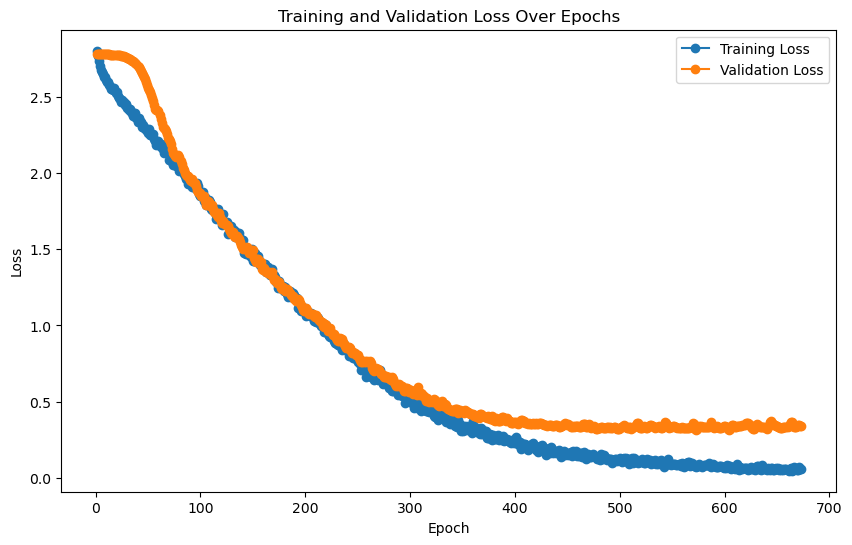

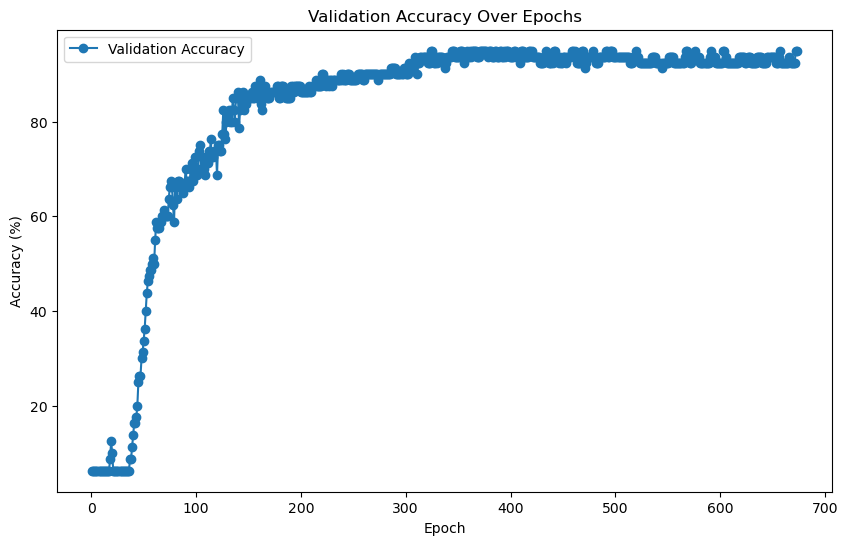


Evaluating on the test set...
    Test Batch [1/211], Loss: 0.3507



Final Test Loss: 0.4847, Test Accuracy: 85.11%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/211 for test dataset.
  Processed batch 20/211 for test dataset.
  Processed batch 30/211 for test dataset.


  Processed batch 40/211 for test dataset.
  Processed batch 50/211 for test dataset.
  Processed batch 60/211 for test dataset.
  Processed batch 70/211 for test dataset.
  Processed batch 80/211 for test dataset.


  Processed batch 90/211 for test dataset.
  Processed batch 100/211 for test dataset.
  Processed batch 110/211 for test dataset.
  Processed batch 120/211 for test dataset.
  Processed batch 130/211 for test dataset.


  Processed batch 140/211 for test dataset.
  Processed batch 150/211 for test dataset.
  Processed batch 160/211 for test dataset.
  Processed batch 170/211 for test dataset.
  Processed batch 180/211 for test dataset.


  Processed batch 190/211 for test dataset.
  Processed batch 200/211 for test dataset.
  Processed batch 210/211 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 160 samples with 64 features each
LOG: Labels shape: (160,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 53889 samples with 64 features each
LOG: Labels shape: (53889,)

LOG: Training features shape: (160, 64), Training labels shape: (160,)
LOG: Validation features shape: (80, 64), Validation labels shape: (80,)
LOG: Test features shape: (53889, 64), Test labels shape: (53889,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 92.50%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       0.83      1.00      0.91         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       0.80      0.80      0.80         5
           8       1.00      1.

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 160 samples with 64 features each
LOG: Labels shape: (160,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53889 samples with 64 features each
LOG: Labels shape: (53889,)
Train reps shape: (160, 64)
Train labels shape: (160,)
Val reps shape: (80, 64)
Val labels shape: (80,)
Test reps shape: (53889, 64)
Test labels shape: (53889,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8832  |  Val Loss: 2.6772
Validation loss improved from inf to 2.6772.
[Epoch 2/1000] Train Loss: 2.6536  |  Val Loss: 2.5477
Validation loss improved from 2.6772 to 2.5477.
[Epoch 3/1000] Train Loss: 2.5350  |  Val Loss: 2.4582
Validation loss improved from 2.5477 to 2.4582.
[Epoch 4/1000] Train Loss: 2.4445  |  Val Loss: 2.3718
Validation loss improved from 2.4582 to 2.3718.
[Epoch 5/1000] Train Loss: 2.3615  |  Val Loss: 2.2806
Validation loss improved from 2.3718 to 2.2806.
[Epoch 6/1000] Train Loss: 2.2750  |  Val Loss: 2.1949
Validation loss improved from 2.2806 to 2.1949.
[Epoch 7/1000] Train Loss: 2.1940  |  Val Loss: 2.1071
Validation loss improved from 2.1949 to 2.1071.
[Epoch 8/1000] Train Loss: 2.1090  |  Val Loss: 2.0250
Validation loss improved from 2.1071 to 2.0250.
[Epoch 9/1000] Train Loss: 2.0320  |  Val Loss: 1.9439
Validation loss improved from 2.0250 to 1.9439.
[Epoch 10/1000] Train Loss: 1.9492  |  Val Loss: 1.8657
Validation loss impr

[Epoch 20/1000] Train Loss: 1.2342  |  Val Loss: 1.1826
Validation loss improved from 1.2371 to 1.1826.
[Epoch 21/1000] Train Loss: 1.1799  |  Val Loss: 1.1324
Validation loss improved from 1.1826 to 1.1324.
[Epoch 22/1000] Train Loss: 1.1227  |  Val Loss: 1.0760
Validation loss improved from 1.1324 to 1.0760.
[Epoch 23/1000] Train Loss: 1.0774  |  Val Loss: 1.0282
Validation loss improved from 1.0760 to 1.0282.
[Epoch 24/1000] Train Loss: 1.0268  |  Val Loss: 0.9854
Validation loss improved from 1.0282 to 0.9854.
[Epoch 25/1000] Train Loss: 0.9852  |  Val Loss: 0.9458
Validation loss improved from 0.9854 to 0.9458.
[Epoch 26/1000] Train Loss: 0.9402  |  Val Loss: 0.9084
Validation loss improved from 0.9458 to 0.9084.
[Epoch 27/1000] Train Loss: 0.9040  |  Val Loss: 0.8708
Validation loss improved from 0.9084 to 0.8708.
[Epoch 28/1000] Train Loss: 0.8680  |  Val Loss: 0.8397
Validation loss improved from 0.8708 to 0.8397.
[Epoch 29/1000] Train Loss: 0.8339  |  Val Loss: 0.8085
Validati

[Epoch 31/1000] Train Loss: 0.7719  |  Val Loss: 0.7550
Validation loss improved from 0.7824 to 0.7550.
[Epoch 32/1000] Train Loss: 0.7366  |  Val Loss: 0.7378
Validation loss improved from 0.7550 to 0.7378.
[Epoch 33/1000] Train Loss: 0.7230  |  Val Loss: 0.7087
Validation loss improved from 0.7378 to 0.7087.
[Epoch 34/1000] Train Loss: 0.6899  |  Val Loss: 0.6821
Validation loss improved from 0.7087 to 0.6821.
[Epoch 35/1000] Train Loss: 0.6660  |  Val Loss: 0.6642
Validation loss improved from 0.6821 to 0.6642.
[Epoch 36/1000] Train Loss: 0.6447  |  Val Loss: 0.6388
Validation loss improved from 0.6642 to 0.6388.
[Epoch 37/1000] Train Loss: 0.6205  |  Val Loss: 0.6176
Validation loss improved from 0.6388 to 0.6176.
[Epoch 38/1000] Train Loss: 0.6006  |  Val Loss: 0.6074
Validation loss improved from 0.6176 to 0.6074.
[Epoch 39/1000] Train Loss: 0.5822  |  Val Loss: 0.5839
Validation loss improved from 0.6074 to 0.5839.
[Epoch 40/1000] Train Loss: 0.5638  |  Val Loss: 0.5677
Validati

[Epoch 49/1000] Train Loss: 0.4306  |  Val Loss: 0.4824
Validation loss improved from 0.4873 to 0.4824.
[Epoch 50/1000] Train Loss: 0.4204  |  Val Loss: 0.4807
Validation loss improved from 0.4824 to 0.4807.
[Epoch 51/1000] Train Loss: 0.4072  |  Val Loss: 0.4735
Validation loss improved from 0.4807 to 0.4735.
[Epoch 52/1000] Train Loss: 0.3983  |  Val Loss: 0.4609
Validation loss improved from 0.4735 to 0.4609.
[Epoch 53/1000] Train Loss: 0.3835  |  Val Loss: 0.4541
Validation loss improved from 0.4609 to 0.4541.
[Epoch 54/1000] Train Loss: 0.3753  |  Val Loss: 0.4393
Validation loss improved from 0.4541 to 0.4393.
[Epoch 55/1000] Train Loss: 0.3642  |  Val Loss: 0.4329
Validation loss improved from 0.4393 to 0.4329.
[Epoch 56/1000] Train Loss: 0.3590  |  Val Loss: 0.4240
Validation loss improved from 0.4329 to 0.4240.
[Epoch 57/1000] Train Loss: 0.3498  |  Val Loss: 0.4235
Validation loss improved from 0.4240 to 0.4235.
[Epoch 58/1000] Train Loss: 0.3377  |  Val Loss: 0.4228
Validati

[Epoch 61/1000] Train Loss: 0.3194  |  Val Loss: 0.4148
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 62/1000] Train Loss: 0.3129  |  Val Loss: 0.4154
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 63/1000] Train Loss: 0.3075  |  Val Loss: 0.4134
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 64/1000] Train Loss: 0.2962  |  Val Loss: 0.3954
Validation loss improved from 0.4122 to 0.3954.
[Epoch 65/1000] Train Loss: 0.2889  |  Val Loss: 0.3929
Validation loss improved from 0.3954 to 0.3929.
[Epoch 66/1000] Train Loss: 0.2831  |  Val Loss: 0.3898
Validation loss improved from 0.3929 to 0.3898.
[Epoch 67/1000] Train Loss: 0.2778  |  Val Loss: 0.3872
Validation loss improved from 0.3898 to 0.3872.
[Epoch 68/1000] Train Loss: 0.2722  |  Val Loss: 0.3851
Validation loss improved from 0.3872 to 0.3851.
[Epoch 69/1000] Train Loss: 0.2704  |  Val Loss: 0.3870
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 70/1000] Train Loss: 0.2612  |  V

[Epoch 78/1000] Train Loss: 0.2237  |  Val Loss: 0.3741
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 79/1000] Train Loss: 0.2259  |  Val Loss: 0.3714
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 80/1000] Train Loss: 0.2192  |  Val Loss: 0.3765
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 81/1000] Train Loss: 0.2178  |  Val Loss: 0.3784
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 82/1000] Train Loss: 0.2193  |  Val Loss: 0.3875
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 83/1000] Train Loss: 0.2149  |  Val Loss: 0.3727
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 84/1000] Train Loss: 0.2077  |  Val Loss: 0.3900
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 85/1000] Train Loss: 0.2154  |  Val Loss: 0.3833
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 86/1000] Train Loss: 0.2059  |  Val Loss: 0.3723
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 

[Epoch 91/1000] Train Loss: 0.1894  |  Val Loss: 0.3648
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 92/1000] Train Loss: 0.1845  |  Val Loss: 0.3683
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 93/1000] Train Loss: 0.1826  |  Val Loss: 0.3669
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 94/1000] Train Loss: 0.1747  |  Val Loss: 0.3762
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 95/1000] Train Loss: 0.1727  |  Val Loss: 0.3751
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 96/1000] Train Loss: 0.1716  |  Val Loss: 0.3608
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 97/1000] Train Loss: 0.1669  |  Val Loss: 0.3592
Validation loss improved from 0.3598 to 0.3592.
[Epoch 98/1000] Train Loss: 0.1642  |  Val Loss: 0.3737
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 99/1000] Train Loss: 0.1632  |  Val Loss: 0.3812
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 100/1000]

[Epoch 110/1000] Train Loss: 0.1388  |  Val Loss: 0.3519
Validation loss improved from 0.3592 to 0.3519.
[Epoch 111/1000] Train Loss: 0.1402  |  Val Loss: 0.3732
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 112/1000] Train Loss: 0.1409  |  Val Loss: 0.3809
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 113/1000] Train Loss: 0.1377  |  Val Loss: 0.3880
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 114/1000] Train Loss: 0.1349  |  Val Loss: 0.3769
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 115/1000] Train Loss: 0.1301  |  Val Loss: 0.3706
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 116/1000] Train Loss: 0.1265  |  Val Loss: 0.3637
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 117/1000] Train Loss: 0.1276  |  Val Loss: 0.3674
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 118/1000] Train Loss: 0.1239  |  Val Loss: 0.3608
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 121/1000] Train Loss: 0.1209  |  Val Loss: 0.3634
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 122/1000] Train Loss: 0.1230  |  Val Loss: 0.3728
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 123/1000] Train Loss: 0.1210  |  Val Loss: 0.3745
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 124/1000] Train Loss: 0.1164  |  Val Loss: 0.3774
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 125/1000] Train Loss: 0.1141  |  Val Loss: 0.3738
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 126/1000] Train Loss: 0.1124  |  Val Loss: 0.3619
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 127/1000] Train Loss: 0.1109  |  Val Loss: 0.3644
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 128/1000] Train Loss: 0.1104  |  Val Loss: 0.3629
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 129/1000] Train Loss: 0.1079  |  Val Loss: 0.3706
!! Validation loss did NOT improve !! Patience:

[Epoch 138/1000] Train Loss: 0.1046  |  Val Loss: 0.3823
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 139/1000] Train Loss: 0.1019  |  Val Loss: 0.3674
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 140/1000] Train Loss: 0.0951  |  Val Loss: 0.3820
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 141/1000] Train Loss: 0.0949  |  Val Loss: 0.3930
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 142/1000] Train Loss: 0.0969  |  Val Loss: 0.3789
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 143/1000] Train Loss: 0.0951  |  Val Loss: 0.3759
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 144/1000] Train Loss: 0.0971  |  Val Loss: 0.3769
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 145/1000] Train Loss: 0.0916  |  Val Loss: 0.3778
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 146/1000] Train Loss: 0.0883  |  Val Loss: 0.3758
!! Validation loss did NOT improve !! Patience:

[Epoch 148/1000] Train Loss: 0.0855  |  Val Loss: 0.3911
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 149/1000] Train Loss: 0.0898  |  Val Loss: 0.3871
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 150/1000] Train Loss: 0.0881  |  Val Loss: 0.3795
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 151/1000] Train Loss: 0.0833  |  Val Loss: 0.3846
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 152/1000] Train Loss: 0.0877  |  Val Loss: 0.3840
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 153/1000] Train Loss: 0.0825  |  Val Loss: 0.3726
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 154/1000] Train Loss: 0.0824  |  Val Loss: 0.3689
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 155/1000] Train Loss: 0.0807  |  Val Loss: 0.3789
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 156/1000] Train Loss: 0.0810  |  Val Loss: 0.3767
!! Validation loss did NOT improve !! Patience:

[Epoch 166/1000] Train Loss: 0.0694  |  Val Loss: 0.4135
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 167/1000] Train Loss: 0.0880  |  Val Loss: 0.3836
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 168/1000] Train Loss: 0.0705  |  Val Loss: 0.3883
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 169/1000] Train Loss: 0.0821  |  Val Loss: 0.3761
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 170/1000] Train Loss: 0.0713  |  Val Loss: 0.4038
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 171/1000] Train Loss: 0.0799  |  Val Loss: 0.3872
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 172/1000] Train Loss: 0.0670  |  Val Loss: 0.3937
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 173/1000] Train Loss: 0.0676  |  Val Loss: 0.3919
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 174/1000] Train Loss: 0.0677  |  Val Loss: 0.3834
!! Validation loss did NOT improve !! Patience:

[Epoch 178/1000] Train Loss: 0.0649  |  Val Loss: 0.3903
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 179/1000] Train Loss: 0.0621  |  Val Loss: 0.3847
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 180/1000] Train Loss: 0.0653  |  Val Loss: 0.3793
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 181/1000] Train Loss: 0.0619  |  Val Loss: 0.3870
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 182/1000] Train Loss: 0.0614  |  Val Loss: 0.3873
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 183/1000] Train Loss: 0.0606  |  Val Loss: 0.3890
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 184/1000] Train Loss: 0.0622  |  Val Loss: 0.3945
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 185/1000] Train Loss: 0.0642  |  Val Loss: 0.3950
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 186/1000] Train Loss: 0.0594  |  Val Loss: 0.3936
!! Validation loss did NOT improve !! Patience:

[Epoch 197/1000] Train Loss: 0.0538  |  Val Loss: 0.4011
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 198/1000] Train Loss: 0.0519  |  Val Loss: 0.4060
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 199/1000] Train Loss: 0.0525  |  Val Loss: 0.4012
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 200/1000] Train Loss: 0.0513  |  Val Loss: 0.4059
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 201/1000] Train Loss: 0.0545  |  Val Loss: 0.4063
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 202/1000] Train Loss: 0.0513  |  Val Loss: 0.4103
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 203/1000] Train Loss: 0.0505  |  Val Loss: 0.3984
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 204/1000] Train Loss: 0.0572  |  Val Loss: 0.3955
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 205/1000] Train Loss: 0.0528  |  Val Loss: 0.4148
!! Validation loss did NOT improve !! Patience:

[Epoch 208/1000] Train Loss: 0.0498  |  Val Loss: 0.4211
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 209/1000] Train Loss: 0.0493  |  Val Loss: 0.4062
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 210/1000] Train Loss: 0.0471  |  Val Loss: 0.4105
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 210 !!
No improvement for 100 epochs.


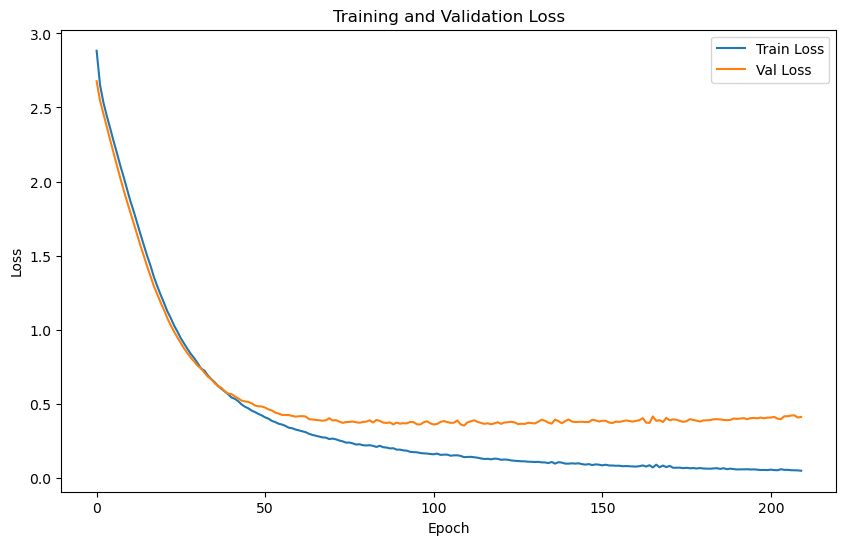

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.8590 | Test Accuracy: 82.21%


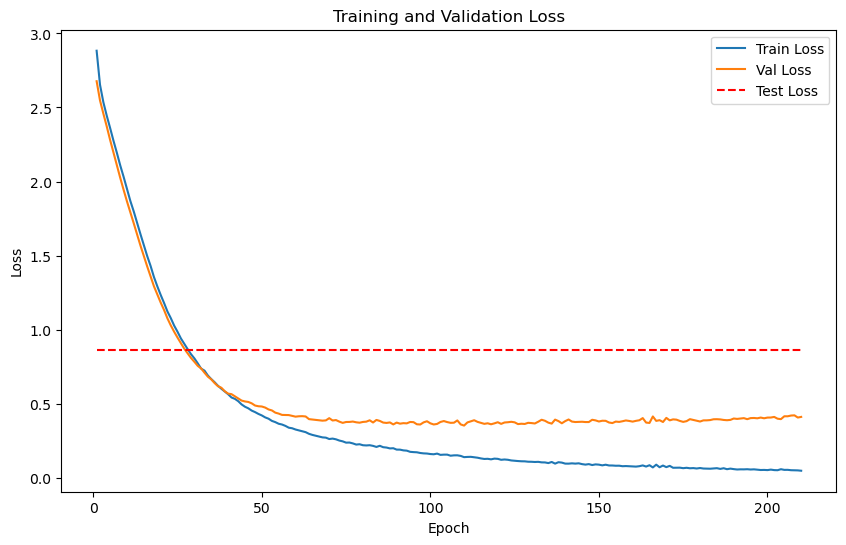

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 160 samples with 64 features each
LOG: Labels shape: (160,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53889 samples with 64 features each
LOG: Labels shape: (53889,)


Train embeddings shape: (160, 64), 
Train labels shape: (160,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (53889, 64), 
Test labels shape: (53889,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10, 14: 10, 15: 10}
Training batch size: 160


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training
    Batch [1/1], Train Loss: 7.7788
Epoch [1/2000], Avg Train Loss: 7.7788
Epoch [1/2000], Avg Val Loss: 3.1675
Validation loss improved from inf to 3.1675. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 7.9695
Epoch [2/2000], Avg Train Loss: 7.9695
Epoch [2/2000], Avg Val Loss: 3.1503
Validation loss improved from 3.1675 to 3.1503. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.0243
Epoch [3/2000], Avg Train Loss: 8.0243
Epoch [3/2000], Avg Val Loss: 3.1338
Validation loss improved from 3.1503 to 3.1338. Saving model...

LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 7.5560
Epoch [4/2000], Avg Train Loss: 7.5560
Epoch [4/2000], Avg Val Loss: 3.1175
Validation loss improved from 3.1338 to 3.1175. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 7.7561
Epoch [5/2000], Avg Train Loss: 7.7561
Epoch [5/2000], Avg Val Loss: 3.1017
Validation loss improved from 3.1175 to 3.1017. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 7.3797
Epoch [6/2000], Avg Train Loss: 7.3797
Epoch [6/2000], Avg Val Loss: 3.0864
Validation loss improved from 3.1017 to 3.0864. Saving model...

LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 7.5822
Epoch [7/2000], Avg Train Loss: 7.5822
Epoch [7/2000], Avg Val Loss: 3.0715
Validation loss improved from 3.0864 to 3.0715. Saving model...

LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 7.3727
Epoch [8/2000], Avg Train Loss: 7.3727
Epoch [8/2000], Avg Val Loss: 3.0571
Validation loss improved from 3.0715 to 3.0571. Saving m

    Batch [1/1], Train Loss: 6.6872
Epoch [18/2000], Avg Train Loss: 6.6872
Epoch [18/2000], Avg Val Loss: 2.9368
Validation loss improved from 2.9470 to 2.9368. Saving model...

LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 6.6265
Epoch [19/2000], Avg Train Loss: 6.6265
Epoch [19/2000], Avg Val Loss: 2.9270
Validation loss improved from 2.9368 to 2.9270. Saving model...

LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 6.6562
Epoch [20/2000], Avg Train Loss: 6.6562
Epoch [20/2000], Avg Val Loss: 2.9176
Validation loss improved from 2.9270 to 2.9176. Saving model...

LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 6.8459
Epoch [21/2000], Avg Train Loss: 6.8459
Epoch [21/2000], Avg Val Loss: 2.9086
Validation loss improved from 2.9176 to 2.9086. Saving model...

LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 6.5237
Epoch [22/2000], Avg Train Loss: 6.5237
Epoch [22/2000], Avg Val Loss: 2.9000
Validation loss improved from 2.9086 to 2.

    Batch [1/1], Train Loss: 6.5798
Epoch [24/2000], Avg Train Loss: 6.5798
Epoch [24/2000], Avg Val Loss: 2.8837
Validation loss improved from 2.8916 to 2.8837. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 6.4454
Epoch [25/2000], Avg Train Loss: 6.4454
Epoch [25/2000], Avg Val Loss: 2.8761
Validation loss improved from 2.8837 to 2.8761. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 6.3022
Epoch [26/2000], Avg Train Loss: 6.3022
Epoch [26/2000], Avg Val Loss: 2.8688
Validation loss improved from 2.8761 to 2.8688. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 6.1447
Epoch [27/2000], Avg Train Loss: 6.1447
Epoch [27/2000], Avg Val Loss: 2.8618
Validation loss improved from 2.8688 to 2.8618. Saving model...

LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 6.3127
Epoch [28/2000], Avg Train Loss: 6.3127
Epoch [28/2000], Avg Val Loss: 2.8552
Validation loss improved from 2.8618 to 2.

    Batch [1/1], Train Loss: 5.5956
Epoch [45/2000], Avg Train Loss: 5.5956
Epoch [45/2000], Avg Val Loss: 2.7808
Validation loss improved from 2.7835 to 2.7808. Saving model...

LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 5.5348
Epoch [46/2000], Avg Train Loss: 5.5348
Epoch [46/2000], Avg Val Loss: 2.7783
Validation loss improved from 2.7808 to 2.7783. Saving model...

LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 5.4007
Epoch [47/2000], Avg Train Loss: 5.4007
Epoch [47/2000], Avg Val Loss: 2.7760
Validation loss improved from 2.7783 to 2.7760. Saving model...

LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 5.4672
Epoch [48/2000], Avg Train Loss: 5.4672
Epoch [48/2000], Avg Val Loss: 2.7739
Validation loss improved from 2.7760 to 2.7739. Saving model...

LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 5.3482
Epoch [49/2000], Avg Train Loss: 5.3482
Epoch [49/2000], Avg Val Loss: 2.7719
Validation loss improved from 2.7739 to 2.

    Batch [1/1], Train Loss: 5.1286
Epoch [61/2000], Avg Train Loss: 5.1286
Epoch [61/2000], Avg Val Loss: 2.7570
Validation loss improved from 2.7577 to 2.7570. Saving model...

LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 5.0447
Epoch [62/2000], Avg Train Loss: 5.0447
Epoch [62/2000], Avg Val Loss: 2.7563
Validation loss improved from 2.7570 to 2.7563. Saving model...

LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 5.1037
Epoch [63/2000], Avg Train Loss: 5.1037
Epoch [63/2000], Avg Val Loss: 2.7558
Validation loss improved from 2.7563 to 2.7558. Saving model...

LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 5.0697
Epoch [64/2000], Avg Train Loss: 5.0697
Epoch [64/2000], Avg Val Loss: 2.7554
Validation loss improved from 2.7558 to 2.7554. Saving model...

LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 5.1209
Epoch [65/2000], Avg Train Loss: 5.1209
Epoch [65/2000], Avg Val Loss: 2.7550
Validation loss improved from 2.7554 to 2.

    Batch [1/1], Train Loss: 4.6465
Epoch [87/2000], Avg Train Loss: 4.6465
Epoch [87/2000], Avg Val Loss: 2.7535
Validation loss did not improve. Patience: 10/100

LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 4.5925
Epoch [88/2000], Avg Train Loss: 4.5925
Epoch [88/2000], Avg Val Loss: 2.7537
Validation loss did not improve. Patience: 11/100

LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 4.6534
Epoch [89/2000], Avg Train Loss: 4.6534
Epoch [89/2000], Avg Val Loss: 2.7538
Validation loss did not improve. Patience: 12/100

LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 4.5274
Epoch [90/2000], Avg Train Loss: 4.5274
Epoch [90/2000], Avg Val Loss: 2.7540
Validation loss did not improve. Patience: 13/100

LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 4.6020
Epoch [91/2000], Avg Train Loss: 4.6020
Epoch [91/2000], Avg Val Loss: 2.7541
Validation loss did not improve. Patience: 14/100

LOG: Epoch [92/2000] - Training
    Batch [1/1]

    Batch [1/1], Train Loss: 4.5365
Epoch [105/2000], Avg Train Loss: 4.5365
Epoch [105/2000], Avg Val Loss: 2.7558
Validation loss did not improve. Patience: 28/100

LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 4.4462
Epoch [106/2000], Avg Train Loss: 4.4462
Epoch [106/2000], Avg Val Loss: 2.7559
Validation loss did not improve. Patience: 29/100

LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 4.4633
Epoch [107/2000], Avg Train Loss: 4.4633
Epoch [107/2000], Avg Val Loss: 2.7559
Validation loss did not improve. Patience: 30/100

LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 4.4565
Epoch [108/2000], Avg Train Loss: 4.4565
Epoch [108/2000], Avg Val Loss: 2.7559
Validation loss did not improve. Patience: 31/100

LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 4.4719
Epoch [109/2000], Avg Train Loss: 4.4719
Epoch [109/2000], Avg Val Loss: 2.7559
Validation loss did not improve. Patience: 32/100

LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 4.2696
Epoch [131/2000], Avg Train Loss: 4.2696
Epoch [131/2000], Avg Val Loss: 2.7508
Validation loss improved from 2.7512 to 2.7508. Saving model...

LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 4.2983
Epoch [132/2000], Avg Train Loss: 4.2983
Epoch [132/2000], Avg Val Loss: 2.7504
Validation loss improved from 2.7508 to 2.7504. Saving model...

LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 4.2711
Epoch [133/2000], Avg Train Loss: 4.2711
Epoch [133/2000], Avg Val Loss: 2.7500
Validation loss improved from 2.7504 to 2.7500. Saving model...

LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 4.2423
Epoch [134/2000], Avg Train Loss: 4.2423
Epoch [134/2000], Avg Val Loss: 2.7495
Validation loss improved from 2.7500 to 2.7495. Saving model...

LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 4.2983
Epoch [135/2000], Avg Train Loss: 4.2983
Epoch [135/2000], Avg Val Loss: 2.7490
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1539
Epoch [148/2000], Avg Train Loss: 4.1539
Epoch [148/2000], Avg Val Loss: 2.7405
Validation loss improved from 2.7413 to 2.7405. Saving model...

LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 4.1820
Epoch [149/2000], Avg Train Loss: 4.1820
Epoch [149/2000], Avg Val Loss: 2.7397
Validation loss improved from 2.7405 to 2.7397. Saving model...

LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 4.1627
Epoch [150/2000], Avg Train Loss: 4.1627
Epoch [150/2000], Avg Val Loss: 2.7389
Validation loss improved from 2.7397 to 2.7389. Saving model...

LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 4.2081
Epoch [151/2000], Avg Train Loss: 4.2081
Epoch [151/2000], Avg Val Loss: 2.7381
Validation loss improved from 2.7389 to 2.7381. Saving model...

LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 4.2284
Epoch [152/2000], Avg Train Loss: 4.2284
Epoch [152/2000], Avg Val Loss: 2.7373
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1099
Epoch [174/2000], Avg Train Loss: 4.1099
Epoch [174/2000], Avg Val Loss: 2.7159
Validation loss improved from 2.7170 to 2.7159. Saving model...

LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 4.1195
Epoch [175/2000], Avg Train Loss: 4.1195
Epoch [175/2000], Avg Val Loss: 2.7149
Validation loss improved from 2.7159 to 2.7149. Saving model...

LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 4.0373
Epoch [176/2000], Avg Train Loss: 4.0373
Epoch [176/2000], Avg Val Loss: 2.7138
Validation loss improved from 2.7149 to 2.7138. Saving model...

LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 4.0905
Epoch [177/2000], Avg Train Loss: 4.0905
Epoch [177/2000], Avg Val Loss: 2.7127
Validation loss improved from 2.7138 to 2.7127. Saving model...

LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 4.0690
Epoch [178/2000], Avg Train Loss: 4.0690
Epoch [178/2000], Avg Val Loss: 2.7116
Validation loss improved fro

Epoch [191/2000], Avg Val Loss: 2.6974
Validation loss improved from 2.6985 to 2.6974. Saving model...

LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 3.9858
Epoch [192/2000], Avg Train Loss: 3.9858
Epoch [192/2000], Avg Val Loss: 2.6962
Validation loss improved from 2.6974 to 2.6962. Saving model...

LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 3.9980
Epoch [193/2000], Avg Train Loss: 3.9980
Epoch [193/2000], Avg Val Loss: 2.6950
Validation loss improved from 2.6962 to 2.6950. Saving model...

LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 4.0288
Epoch [194/2000], Avg Train Loss: 4.0288
Epoch [194/2000], Avg Val Loss: 2.6938
Validation loss improved from 2.6950 to 2.6938. Saving model...

LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 4.0576
Epoch [195/2000], Avg Train Loss: 4.0576
Epoch [195/2000], Avg Val Loss: 2.6927
Validation loss improved from 2.6938 to 2.6927. Saving model...

LOG: Epoch [196/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.8907
Epoch [220/2000], Avg Train Loss: 3.8907
Epoch [220/2000], Avg Val Loss: 2.6636
Validation loss improved from 2.6647 to 2.6636. Saving model...

LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 3.9225
Epoch [221/2000], Avg Train Loss: 3.9225
Epoch [221/2000], Avg Val Loss: 2.6624
Validation loss improved from 2.6636 to 2.6624. Saving model...

LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 3.8663
Epoch [222/2000], Avg Train Loss: 3.8663
Epoch [222/2000], Avg Val Loss: 2.6612
Validation loss improved from 2.6624 to 2.6612. Saving model...

LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 3.9233
Epoch [223/2000], Avg Train Loss: 3.9233
Epoch [223/2000], Avg Val Loss: 2.6600
Validation loss improved from 2.6612 to 2.6600. Saving model...

LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 3.9225
Epoch [224/2000], Avg Train Loss: 3.9225
Epoch [224/2000], Avg Val Loss: 2.6587
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9219
Epoch [240/2000], Avg Train Loss: 3.9219
Epoch [240/2000], Avg Val Loss: 2.6396
Validation loss improved from 2.6407 to 2.6396. Saving model...

LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 3.9070
Epoch [241/2000], Avg Train Loss: 3.9070
Epoch [241/2000], Avg Val Loss: 2.6384
Validation loss improved from 2.6396 to 2.6384. Saving model...

LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 3.9542
Epoch [242/2000], Avg Train Loss: 3.9542
Epoch [242/2000], Avg Val Loss: 2.6373
Validation loss improved from 2.6384 to 2.6373. Saving model...

LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 3.9270
Epoch [243/2000], Avg Train Loss: 3.9270
Epoch [243/2000], Avg Val Loss: 2.6361
Validation loss improved from 2.6373 to 2.6361. Saving model...

LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 3.8751
Epoch [244/2000], Avg Train Loss: 3.8751
Epoch [244/2000], Avg Val Loss: 2.6349
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8654
Epoch [262/2000], Avg Train Loss: 3.8654
Epoch [262/2000], Avg Val Loss: 2.6143
Validation loss improved from 2.6155 to 2.6143. Saving model...

LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 3.8478
Epoch [263/2000], Avg Train Loss: 3.8478
Epoch [263/2000], Avg Val Loss: 2.6131
Validation loss improved from 2.6143 to 2.6131. Saving model...

LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 3.8261
Epoch [264/2000], Avg Train Loss: 3.8261
Epoch [264/2000], Avg Val Loss: 2.6120
Validation loss improved from 2.6131 to 2.6120. Saving model...

LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 3.9006
Epoch [265/2000], Avg Train Loss: 3.9006
Epoch [265/2000], Avg Val Loss: 2.6108
Validation loss improved from 2.6120 to 2.6108. Saving model...

LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 3.8951
Epoch [266/2000], Avg Train Loss: 3.8951
Epoch [266/2000], Avg Val Loss: 2.6096
Validation loss improved fro

Epoch [281/2000], Avg Val Loss: 2.5928
Validation loss improved from 2.5939 to 2.5928. Saving model...

LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 3.7765
Epoch [282/2000], Avg Train Loss: 3.7765
Epoch [282/2000], Avg Val Loss: 2.5917
Validation loss improved from 2.5928 to 2.5917. Saving model...

LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 3.7890
Epoch [283/2000], Avg Train Loss: 3.7890
Epoch [283/2000], Avg Val Loss: 2.5906
Validation loss improved from 2.5917 to 2.5906. Saving model...

LOG: Epoch [284/2000] - Training
    Batch [1/1], Train Loss: 3.8288
Epoch [284/2000], Avg Train Loss: 3.8288
Epoch [284/2000], Avg Val Loss: 2.5896
Validation loss improved from 2.5906 to 2.5896. Saving model...

LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 3.8313
Epoch [285/2000], Avg Train Loss: 3.8313
Epoch [285/2000], Avg Val Loss: 2.5885
Validation loss improved from 2.5896 to 2.5885. Saving model...

LOG: Epoch [286/2000] - Training
    Bat

Epoch [300/2000], Avg Val Loss: 2.5725
Validation loss improved from 2.5736 to 2.5725. Saving model...

LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 3.8098
Epoch [301/2000], Avg Train Loss: 3.8098
Epoch [301/2000], Avg Val Loss: 2.5715
Validation loss improved from 2.5725 to 2.5715. Saving model...

LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 3.7641
Epoch [302/2000], Avg Train Loss: 3.7641
Epoch [302/2000], Avg Val Loss: 2.5704
Validation loss improved from 2.5715 to 2.5704. Saving model...

LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 3.8145
Epoch [303/2000], Avg Train Loss: 3.8145
Epoch [303/2000], Avg Val Loss: 2.5693
Validation loss improved from 2.5704 to 2.5693. Saving model...

LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 3.7795
Epoch [304/2000], Avg Train Loss: 3.7795
Epoch [304/2000], Avg Val Loss: 2.5682
Validation loss improved from 2.5693 to 2.5682. Saving model...

LOG: Epoch [305/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.7514
Epoch [325/2000], Avg Train Loss: 3.7514
Epoch [325/2000], Avg Val Loss: 2.5462
Validation loss improved from 2.5472 to 2.5462. Saving model...

LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 3.7468
Epoch [326/2000], Avg Train Loss: 3.7468
Epoch [326/2000], Avg Val Loss: 2.5451
Validation loss improved from 2.5462 to 2.5451. Saving model...

LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 3.7415
Epoch [327/2000], Avg Train Loss: 3.7415
Epoch [327/2000], Avg Val Loss: 2.5440
Validation loss improved from 2.5451 to 2.5440. Saving model...

LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 3.7274
Epoch [328/2000], Avg Train Loss: 3.7274
Epoch [328/2000], Avg Val Loss: 2.5430
Validation loss improved from 2.5440 to 2.5430. Saving model...

LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 3.6902
Epoch [329/2000], Avg Train Loss: 3.6902
Epoch [329/2000], Avg Val Loss: 2.5419
Validation loss improved fro

Epoch [345/2000], Avg Val Loss: 2.5252
Validation loss improved from 2.5263 to 2.5252. Saving model...

LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 3.6796
Epoch [346/2000], Avg Train Loss: 3.6796
Epoch [346/2000], Avg Val Loss: 2.5242
Validation loss improved from 2.5252 to 2.5242. Saving model...

LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 3.6604
Epoch [347/2000], Avg Train Loss: 3.6604
Epoch [347/2000], Avg Val Loss: 2.5232
Validation loss improved from 2.5242 to 2.5232. Saving model...

LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 3.6694
Epoch [348/2000], Avg Train Loss: 3.6694
Epoch [348/2000], Avg Val Loss: 2.5222
Validation loss improved from 2.5232 to 2.5222. Saving model...

LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 3.6528
Epoch [349/2000], Avg Train Loss: 3.6528
Epoch [349/2000], Avg Val Loss: 2.5211
Validation loss improved from 2.5222 to 2.5211. Saving model...

LOG: Epoch [350/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.6458
Epoch [371/2000], Avg Train Loss: 3.6458
Epoch [371/2000], Avg Val Loss: 2.4983
Validation loss improved from 2.4993 to 2.4983. Saving model...

LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 3.5855
Epoch [372/2000], Avg Train Loss: 3.5855
Epoch [372/2000], Avg Val Loss: 2.4972
Validation loss improved from 2.4983 to 2.4972. Saving model...

LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 3.6490
Epoch [373/2000], Avg Train Loss: 3.6490
Epoch [373/2000], Avg Val Loss: 2.4962
Validation loss improved from 2.4972 to 2.4962. Saving model...

LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 3.7091
Epoch [374/2000], Avg Train Loss: 3.7091
Epoch [374/2000], Avg Val Loss: 2.4951
Validation loss improved from 2.4962 to 2.4951. Saving model...

LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 3.6577
Epoch [375/2000], Avg Train Loss: 3.6577
Epoch [375/2000], Avg Val Loss: 2.4941
Validation loss improved fro

    Batch [1/1], Train Loss: 3.6455
Epoch [394/2000], Avg Train Loss: 3.6455
Epoch [394/2000], Avg Val Loss: 2.4749
Validation loss improved from 2.4758 to 2.4749. Saving model...

LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 3.6508
Epoch [395/2000], Avg Train Loss: 3.6508
Epoch [395/2000], Avg Val Loss: 2.4739
Validation loss improved from 2.4749 to 2.4739. Saving model...

LOG: Epoch [396/2000] - Training
    Batch [1/1], Train Loss: 3.6183
Epoch [396/2000], Avg Train Loss: 3.6183
Epoch [396/2000], Avg Val Loss: 2.4730
Validation loss improved from 2.4739 to 2.4730. Saving model...

LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 3.6065
Epoch [397/2000], Avg Train Loss: 3.6065
Epoch [397/2000], Avg Val Loss: 2.4721
Validation loss improved from 2.4730 to 2.4721. Saving model...

LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 3.6563
Epoch [398/2000], Avg Train Loss: 3.6563
Epoch [398/2000], Avg Val Loss: 2.4712
Validation loss improved fro

Epoch [417/2000], Avg Val Loss: 2.4547
Validation loss improved from 2.4556 to 2.4547. Saving model...

LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 3.5782
Epoch [418/2000], Avg Train Loss: 3.5782
Epoch [418/2000], Avg Val Loss: 2.4537
Validation loss improved from 2.4547 to 2.4537. Saving model...

LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 3.5766
Epoch [419/2000], Avg Train Loss: 3.5766
Epoch [419/2000], Avg Val Loss: 2.4528
Validation loss improved from 2.4537 to 2.4528. Saving model...

LOG: Epoch [420/2000] - Training
    Batch [1/1], Train Loss: 3.5509
Epoch [420/2000], Avg Train Loss: 3.5509
Epoch [420/2000], Avg Val Loss: 2.4518
Validation loss improved from 2.4528 to 2.4518. Saving model...

LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 3.5135
Epoch [421/2000], Avg Train Loss: 3.5135
Epoch [421/2000], Avg Val Loss: 2.4508
Validation loss improved from 2.4518 to 2.4508. Saving model...

LOG: Epoch [422/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.5968
Epoch [441/2000], Avg Train Loss: 3.5968
Epoch [441/2000], Avg Val Loss: 2.4331
Validation loss improved from 2.4339 to 2.4331. Saving model...

LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 3.5744
Epoch [442/2000], Avg Train Loss: 3.5744
Epoch [442/2000], Avg Val Loss: 2.4323
Validation loss improved from 2.4331 to 2.4323. Saving model...

LOG: Epoch [443/2000] - Training
    Batch [1/1], Train Loss: 3.5374
Epoch [443/2000], Avg Train Loss: 3.5374
Epoch [443/2000], Avg Val Loss: 2.4315
Validation loss improved from 2.4323 to 2.4315. Saving model...

LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 3.4885
Epoch [444/2000], Avg Train Loss: 3.4885
Epoch [444/2000], Avg Val Loss: 2.4307
Validation loss improved from 2.4315 to 2.4307. Saving model...

LOG: Epoch [445/2000] - Training
    Batch [1/1], Train Loss: 3.5683
Epoch [445/2000], Avg Train Loss: 3.5683
Epoch [445/2000], Avg Val Loss: 2.4299
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5295
Epoch [463/2000], Avg Train Loss: 3.5295
Epoch [463/2000], Avg Val Loss: 2.4156
Validation loss improved from 2.4164 to 2.4156. Saving model...

LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 3.5188
Epoch [464/2000], Avg Train Loss: 3.5188
Epoch [464/2000], Avg Val Loss: 2.4148
Validation loss improved from 2.4156 to 2.4148. Saving model...

LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 3.5358
Epoch [465/2000], Avg Train Loss: 3.5358
Epoch [465/2000], Avg Val Loss: 2.4141
Validation loss improved from 2.4148 to 2.4141. Saving model...

LOG: Epoch [466/2000] - Training
    Batch [1/1], Train Loss: 3.4720
Epoch [466/2000], Avg Train Loss: 3.4720
Epoch [466/2000], Avg Val Loss: 2.4133
Validation loss improved from 2.4141 to 2.4133. Saving model...

LOG: Epoch [467/2000] - Training
    Batch [1/1], Train Loss: 3.5513
Epoch [467/2000], Avg Train Loss: 3.5513
Epoch [467/2000], Avg Val Loss: 2.4125
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4985
Epoch [485/2000], Avg Train Loss: 3.4985
Epoch [485/2000], Avg Val Loss: 2.3996
Validation loss improved from 2.4004 to 2.3996. Saving model...

LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 3.5394
Epoch [486/2000], Avg Train Loss: 3.5394
Epoch [486/2000], Avg Val Loss: 2.3989
Validation loss improved from 2.3996 to 2.3989. Saving model...

LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 3.4711
Epoch [487/2000], Avg Train Loss: 3.4711
Epoch [487/2000], Avg Val Loss: 2.3982
Validation loss improved from 2.3989 to 2.3982. Saving model...

LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 3.4949
Epoch [488/2000], Avg Train Loss: 3.4949
Epoch [488/2000], Avg Val Loss: 2.3974
Validation loss improved from 2.3982 to 2.3974. Saving model...

LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 3.4599
Epoch [489/2000], Avg Train Loss: 3.4599
Epoch [489/2000], Avg Val Loss: 2.3967
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4642
Epoch [505/2000], Avg Train Loss: 3.4642
Epoch [505/2000], Avg Val Loss: 2.3859
Validation loss improved from 2.3866 to 2.3859. Saving model...

LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 3.4879
Epoch [506/2000], Avg Train Loss: 3.4879
Epoch [506/2000], Avg Val Loss: 2.3853
Validation loss improved from 2.3859 to 2.3853. Saving model...

LOG: Epoch [507/2000] - Training
    Batch [1/1], Train Loss: 3.4247
Epoch [507/2000], Avg Train Loss: 3.4247
Epoch [507/2000], Avg Val Loss: 2.3846
Validation loss improved from 2.3853 to 2.3846. Saving model...

LOG: Epoch [508/2000] - Training
    Batch [1/1], Train Loss: 3.5297
Epoch [508/2000], Avg Train Loss: 3.5297
Epoch [508/2000], Avg Val Loss: 2.3840
Validation loss improved from 2.3846 to 2.3840. Saving model...

LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 3.4421
Epoch [509/2000], Avg Train Loss: 3.4421
Epoch [509/2000], Avg Val Loss: 2.3833
Validation loss improved fro

Epoch [527/2000], Avg Val Loss: 2.3721
Validation loss improved from 2.3727 to 2.3721. Saving model...

LOG: Epoch [528/2000] - Training
    Batch [1/1], Train Loss: 3.4396
Epoch [528/2000], Avg Train Loss: 3.4396
Epoch [528/2000], Avg Val Loss: 2.3716
Validation loss improved from 2.3721 to 2.3716. Saving model...

LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 3.4423
Epoch [529/2000], Avg Train Loss: 3.4423
Epoch [529/2000], Avg Val Loss: 2.3710
Validation loss improved from 2.3716 to 2.3710. Saving model...

LOG: Epoch [530/2000] - Training
    Batch [1/1], Train Loss: 3.4558
Epoch [530/2000], Avg Train Loss: 3.4558
Epoch [530/2000], Avg Val Loss: 2.3704
Validation loss improved from 2.3710 to 2.3704. Saving model...

LOG: Epoch [531/2000] - Training
    Batch [1/1], Train Loss: 3.4903
Epoch [531/2000], Avg Train Loss: 3.4903
Epoch [531/2000], Avg Val Loss: 2.3699
Validation loss improved from 2.3704 to 2.3699. Saving model...

LOG: Epoch [532/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.4732
Epoch [549/2000], Avg Train Loss: 3.4732
Epoch [549/2000], Avg Val Loss: 2.3596
Validation loss improved from 2.3601 to 2.3596. Saving model...

LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 3.4202
Epoch [550/2000], Avg Train Loss: 3.4202
Epoch [550/2000], Avg Val Loss: 2.3590
Validation loss improved from 2.3596 to 2.3590. Saving model...

LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 3.4376
Epoch [551/2000], Avg Train Loss: 3.4376
Epoch [551/2000], Avg Val Loss: 2.3585
Validation loss improved from 2.3590 to 2.3585. Saving model...

LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 3.4514
Epoch [552/2000], Avg Train Loss: 3.4514
Epoch [552/2000], Avg Val Loss: 2.3579
Validation loss improved from 2.3585 to 2.3579. Saving model...

LOG: Epoch [553/2000] - Training
    Batch [1/1], Train Loss: 3.4618
Epoch [553/2000], Avg Train Loss: 3.4618
Epoch [553/2000], Avg Val Loss: 2.3574
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3979
Epoch [569/2000], Avg Train Loss: 3.3979
Epoch [569/2000], Avg Val Loss: 2.3487
Validation loss improved from 2.3493 to 2.3487. Saving model...

LOG: Epoch [570/2000] - Training
    Batch [1/1], Train Loss: 3.4312
Epoch [570/2000], Avg Train Loss: 3.4312
Epoch [570/2000], Avg Val Loss: 2.3481
Validation loss improved from 2.3487 to 2.3481. Saving model...

LOG: Epoch [571/2000] - Training
    Batch [1/1], Train Loss: 3.4484
Epoch [571/2000], Avg Train Loss: 3.4484
Epoch [571/2000], Avg Val Loss: 2.3476
Validation loss improved from 2.3481 to 2.3476. Saving model...

LOG: Epoch [572/2000] - Training
    Batch [1/1], Train Loss: 3.4447
Epoch [572/2000], Avg Train Loss: 3.4447
Epoch [572/2000], Avg Val Loss: 2.3470
Validation loss improved from 2.3476 to 2.3470. Saving model...

LOG: Epoch [573/2000] - Training
    Batch [1/1], Train Loss: 3.4060
Epoch [573/2000], Avg Train Loss: 3.4060
Epoch [573/2000], Avg Val Loss: 2.3464
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4015
Epoch [587/2000], Avg Train Loss: 3.4015
Epoch [587/2000], Avg Val Loss: 2.3383
Validation loss improved from 2.3388 to 2.3383. Saving model...

LOG: Epoch [588/2000] - Training
    Batch [1/1], Train Loss: 3.4042
Epoch [588/2000], Avg Train Loss: 3.4042
Epoch [588/2000], Avg Val Loss: 2.3378
Validation loss improved from 2.3383 to 2.3378. Saving model...

LOG: Epoch [589/2000] - Training
    Batch [1/1], Train Loss: 3.3721
Epoch [589/2000], Avg Train Loss: 3.3721
Epoch [589/2000], Avg Val Loss: 2.3373
Validation loss improved from 2.3378 to 2.3373. Saving model...

LOG: Epoch [590/2000] - Training
    Batch [1/1], Train Loss: 3.3875
Epoch [590/2000], Avg Train Loss: 3.3875
Epoch [590/2000], Avg Val Loss: 2.3367
Validation loss improved from 2.3373 to 2.3367. Saving model...

LOG: Epoch [591/2000] - Training
    Batch [1/1], Train Loss: 3.4305
Epoch [591/2000], Avg Train Loss: 3.4305
Epoch [591/2000], Avg Val Loss: 2.3362
Validation loss improved fro

Epoch [609/2000], Avg Val Loss: 2.3273
Validation loss improved from 2.3278 to 2.3273. Saving model...

LOG: Epoch [610/2000] - Training
    Batch [1/1], Train Loss: 3.2999
Epoch [610/2000], Avg Train Loss: 3.2999
Epoch [610/2000], Avg Val Loss: 2.3269
Validation loss improved from 2.3273 to 2.3269. Saving model...

LOG: Epoch [611/2000] - Training
    Batch [1/1], Train Loss: 3.3923
Epoch [611/2000], Avg Train Loss: 3.3923
Epoch [611/2000], Avg Val Loss: 2.3265
Validation loss improved from 2.3269 to 2.3265. Saving model...

LOG: Epoch [612/2000] - Training
    Batch [1/1], Train Loss: 3.3695
Epoch [612/2000], Avg Train Loss: 3.3695
Epoch [612/2000], Avg Val Loss: 2.3260
Validation loss improved from 2.3265 to 2.3260. Saving model...

LOG: Epoch [613/2000] - Training
    Batch [1/1], Train Loss: 3.4196
Epoch [613/2000], Avg Train Loss: 3.4196
Epoch [613/2000], Avg Val Loss: 2.3256
Validation loss improved from 2.3260 to 2.3256. Saving model...

LOG: Epoch [614/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.3025
Epoch [634/2000], Avg Train Loss: 3.3025
Epoch [634/2000], Avg Val Loss: 2.3170
Validation loss improved from 2.3174 to 2.3170. Saving model...

LOG: Epoch [635/2000] - Training
    Batch [1/1], Train Loss: 3.3192
Epoch [635/2000], Avg Train Loss: 3.3192
Epoch [635/2000], Avg Val Loss: 2.3166
Validation loss improved from 2.3170 to 2.3166. Saving model...

LOG: Epoch [636/2000] - Training
    Batch [1/1], Train Loss: 3.3396
Epoch [636/2000], Avg Train Loss: 3.3396
Epoch [636/2000], Avg Val Loss: 2.3162
Validation loss improved from 2.3166 to 2.3162. Saving model...

LOG: Epoch [637/2000] - Training
    Batch [1/1], Train Loss: 3.3112
Epoch [637/2000], Avg Train Loss: 3.3112
Epoch [637/2000], Avg Val Loss: 2.3158
Validation loss improved from 2.3162 to 2.3158. Saving model...

LOG: Epoch [638/2000] - Training
    Batch [1/1], Train Loss: 3.3761
Epoch [638/2000], Avg Train Loss: 3.3761
Epoch [638/2000], Avg Val Loss: 2.3153
Validation loss improved fro

Epoch [654/2000], Avg Val Loss: 2.3098
Validation loss improved from 2.3101 to 2.3098. Saving model...

LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 3.3026
Epoch [655/2000], Avg Train Loss: 3.3026
Epoch [655/2000], Avg Val Loss: 2.3094
Validation loss improved from 2.3098 to 2.3094. Saving model...

LOG: Epoch [656/2000] - Training
    Batch [1/1], Train Loss: 3.3424
Epoch [656/2000], Avg Train Loss: 3.3424
Epoch [656/2000], Avg Val Loss: 2.3090
Validation loss improved from 2.3094 to 2.3090. Saving model...

LOG: Epoch [657/2000] - Training
    Batch [1/1], Train Loss: 3.3517
Epoch [657/2000], Avg Train Loss: 3.3517
Epoch [657/2000], Avg Val Loss: 2.3087
Validation loss improved from 2.3090 to 2.3087. Saving model...

LOG: Epoch [658/2000] - Training
    Batch [1/1], Train Loss: 3.3652
Epoch [658/2000], Avg Train Loss: 3.3652
Epoch [658/2000], Avg Val Loss: 2.3084
Validation loss improved from 2.3087 to 2.3084. Saving model...

LOG: Epoch [659/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.2768
Epoch [679/2000], Avg Train Loss: 3.2768
Epoch [679/2000], Avg Val Loss: 2.2998
Validation loss improved from 2.3002 to 2.2998. Saving model...

LOG: Epoch [680/2000] - Training
    Batch [1/1], Train Loss: 3.3574
Epoch [680/2000], Avg Train Loss: 3.3574
Epoch [680/2000], Avg Val Loss: 2.2994
Validation loss improved from 2.2998 to 2.2994. Saving model...

LOG: Epoch [681/2000] - Training
    Batch [1/1], Train Loss: 3.3015
Epoch [681/2000], Avg Train Loss: 3.3015
Epoch [681/2000], Avg Val Loss: 2.2990
Validation loss improved from 2.2994 to 2.2990. Saving model...

LOG: Epoch [682/2000] - Training
    Batch [1/1], Train Loss: 3.3279
Epoch [682/2000], Avg Train Loss: 3.3279
Epoch [682/2000], Avg Val Loss: 2.2985
Validation loss improved from 2.2990 to 2.2985. Saving model...

LOG: Epoch [683/2000] - Training
    Batch [1/1], Train Loss: 3.3079
Epoch [683/2000], Avg Train Loss: 3.3079
Epoch [683/2000], Avg Val Loss: 2.2980
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2512
Epoch [697/2000], Avg Train Loss: 3.2512
Epoch [697/2000], Avg Val Loss: 2.2916
Validation loss improved from 2.2920 to 2.2916. Saving model...

LOG: Epoch [698/2000] - Training
    Batch [1/1], Train Loss: 3.3446
Epoch [698/2000], Avg Train Loss: 3.3446
Epoch [698/2000], Avg Val Loss: 2.2912
Validation loss improved from 2.2916 to 2.2912. Saving model...

LOG: Epoch [699/2000] - Training
    Batch [1/1], Train Loss: 3.3164
Epoch [699/2000], Avg Train Loss: 3.3164
Epoch [699/2000], Avg Val Loss: 2.2908
Validation loss improved from 2.2912 to 2.2908. Saving model...

LOG: Epoch [700/2000] - Training
    Batch [1/1], Train Loss: 3.2828
Epoch [700/2000], Avg Train Loss: 3.2828
Epoch [700/2000], Avg Val Loss: 2.2905
Validation loss improved from 2.2908 to 2.2905. Saving model...

LOG: Epoch [701/2000] - Training
    Batch [1/1], Train Loss: 3.3057
Epoch [701/2000], Avg Train Loss: 3.3057
Epoch [701/2000], Avg Val Loss: 2.2901
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3017
Epoch [720/2000], Avg Train Loss: 3.3017
Epoch [720/2000], Avg Val Loss: 2.2832
Validation loss improved from 2.2836 to 2.2832. Saving model...

LOG: Epoch [721/2000] - Training
    Batch [1/1], Train Loss: 3.2472
Epoch [721/2000], Avg Train Loss: 3.2472
Epoch [721/2000], Avg Val Loss: 2.2829
Validation loss improved from 2.2832 to 2.2829. Saving model...

LOG: Epoch [722/2000] - Training
    Batch [1/1], Train Loss: 3.2824
Epoch [722/2000], Avg Train Loss: 3.2824
Epoch [722/2000], Avg Val Loss: 2.2826
Validation loss improved from 2.2829 to 2.2826. Saving model...

LOG: Epoch [723/2000] - Training
    Batch [1/1], Train Loss: 3.2504
Epoch [723/2000], Avg Train Loss: 3.2504
Epoch [723/2000], Avg Val Loss: 2.2822
Validation loss improved from 2.2826 to 2.2822. Saving model...

LOG: Epoch [724/2000] - Training
    Batch [1/1], Train Loss: 3.2770
Epoch [724/2000], Avg Train Loss: 3.2770
Epoch [724/2000], Avg Val Loss: 2.2818
Validation loss improved fro

Epoch [739/2000], Avg Val Loss: 2.2761
Validation loss improved from 2.2765 to 2.2761. Saving model...

LOG: Epoch [740/2000] - Training
    Batch [1/1], Train Loss: 3.2198
Epoch [740/2000], Avg Train Loss: 3.2198
Epoch [740/2000], Avg Val Loss: 2.2756
Validation loss improved from 2.2761 to 2.2756. Saving model...

LOG: Epoch [741/2000] - Training
    Batch [1/1], Train Loss: 3.2104
Epoch [741/2000], Avg Train Loss: 3.2104
Epoch [741/2000], Avg Val Loss: 2.2751
Validation loss improved from 2.2756 to 2.2751. Saving model...

LOG: Epoch [742/2000] - Training
    Batch [1/1], Train Loss: 3.2734
Epoch [742/2000], Avg Train Loss: 3.2734
Epoch [742/2000], Avg Val Loss: 2.2747
Validation loss improved from 2.2751 to 2.2747. Saving model...

LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 3.2655
Epoch [743/2000], Avg Train Loss: 3.2655
Epoch [743/2000], Avg Val Loss: 2.2743
Validation loss improved from 2.2747 to 2.2743. Saving model...

LOG: Epoch [744/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.2714
Epoch [761/2000], Avg Train Loss: 3.2714
Epoch [761/2000], Avg Val Loss: 2.2686
Validation loss improved from 2.2689 to 2.2686. Saving model...

LOG: Epoch [762/2000] - Training
    Batch [1/1], Train Loss: 3.2525
Epoch [762/2000], Avg Train Loss: 3.2525
Epoch [762/2000], Avg Val Loss: 2.2682
Validation loss improved from 2.2686 to 2.2682. Saving model...

LOG: Epoch [763/2000] - Training
    Batch [1/1], Train Loss: 3.2003
Epoch [763/2000], Avg Train Loss: 3.2003
Epoch [763/2000], Avg Val Loss: 2.2678
Validation loss improved from 2.2682 to 2.2678. Saving model...

LOG: Epoch [764/2000] - Training
    Batch [1/1], Train Loss: 3.2145
Epoch [764/2000], Avg Train Loss: 3.2145
Epoch [764/2000], Avg Val Loss: 2.2674
Validation loss improved from 2.2678 to 2.2674. Saving model...

LOG: Epoch [765/2000] - Training
    Batch [1/1], Train Loss: 3.2413
Epoch [765/2000], Avg Train Loss: 3.2413
Epoch [765/2000], Avg Val Loss: 2.2671
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2102
Epoch [783/2000], Avg Train Loss: 3.2102
Epoch [783/2000], Avg Val Loss: 2.2613
Validation loss improved from 2.2616 to 2.2613. Saving model...

LOG: Epoch [784/2000] - Training
    Batch [1/1], Train Loss: 3.1902
Epoch [784/2000], Avg Train Loss: 3.1902
Epoch [784/2000], Avg Val Loss: 2.2610
Validation loss improved from 2.2613 to 2.2610. Saving model...

LOG: Epoch [785/2000] - Training
    Batch [1/1], Train Loss: 3.2049
Epoch [785/2000], Avg Train Loss: 3.2049
Epoch [785/2000], Avg Val Loss: 2.2607
Validation loss improved from 2.2610 to 2.2607. Saving model...

LOG: Epoch [786/2000] - Training
    Batch [1/1], Train Loss: 3.2409
Epoch [786/2000], Avg Train Loss: 3.2409
Epoch [786/2000], Avg Val Loss: 2.2604
Validation loss improved from 2.2607 to 2.2604. Saving model...

LOG: Epoch [787/2000] - Training
    Batch [1/1], Train Loss: 3.2327
Epoch [787/2000], Avg Train Loss: 3.2327
Epoch [787/2000], Avg Val Loss: 2.2601
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1840
Epoch [804/2000], Avg Train Loss: 3.1840
Epoch [804/2000], Avg Val Loss: 2.2542
Validation loss improved from 2.2546 to 2.2542. Saving model...

LOG: Epoch [805/2000] - Training
    Batch [1/1], Train Loss: 3.2320
Epoch [805/2000], Avg Train Loss: 3.2320
Epoch [805/2000], Avg Val Loss: 2.2539
Validation loss improved from 2.2542 to 2.2539. Saving model...

LOG: Epoch [806/2000] - Training
    Batch [1/1], Train Loss: 3.1975
Epoch [806/2000], Avg Train Loss: 3.1975
Epoch [806/2000], Avg Val Loss: 2.2535
Validation loss improved from 2.2539 to 2.2535. Saving model...

LOG: Epoch [807/2000] - Training
    Batch [1/1], Train Loss: 3.2135
Epoch [807/2000], Avg Train Loss: 3.2135
Epoch [807/2000], Avg Val Loss: 2.2531
Validation loss improved from 2.2535 to 2.2531. Saving model...

LOG: Epoch [808/2000] - Training
    Batch [1/1], Train Loss: 3.2152
Epoch [808/2000], Avg Train Loss: 3.2152
Epoch [808/2000], Avg Val Loss: 2.2527
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2174
Epoch [827/2000], Avg Train Loss: 3.2174
Epoch [827/2000], Avg Val Loss: 2.2472
Validation loss improved from 2.2475 to 2.2472. Saving model...

LOG: Epoch [828/2000] - Training
    Batch [1/1], Train Loss: 3.2232
Epoch [828/2000], Avg Train Loss: 3.2232
Epoch [828/2000], Avg Val Loss: 2.2470
Validation loss improved from 2.2472 to 2.2470. Saving model...

LOG: Epoch [829/2000] - Training
    Batch [1/1], Train Loss: 3.2088
Epoch [829/2000], Avg Train Loss: 3.2088
Epoch [829/2000], Avg Val Loss: 2.2467
Validation loss improved from 2.2470 to 2.2467. Saving model...

LOG: Epoch [830/2000] - Training
    Batch [1/1], Train Loss: 3.2624
Epoch [830/2000], Avg Train Loss: 3.2624
Epoch [830/2000], Avg Val Loss: 2.2465
Validation loss improved from 2.2467 to 2.2465. Saving model...

LOG: Epoch [831/2000] - Training
    Batch [1/1], Train Loss: 3.1800
Epoch [831/2000], Avg Train Loss: 3.1800
Epoch [831/2000], Avg Val Loss: 2.2462
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1817
Epoch [849/2000], Avg Train Loss: 3.1817
Epoch [849/2000], Avg Val Loss: 2.2399
Validation loss improved from 2.2403 to 2.2399. Saving model...

LOG: Epoch [850/2000] - Training
    Batch [1/1], Train Loss: 3.1705
Epoch [850/2000], Avg Train Loss: 3.1705
Epoch [850/2000], Avg Val Loss: 2.2395
Validation loss improved from 2.2399 to 2.2395. Saving model...

LOG: Epoch [851/2000] - Training
    Batch [1/1], Train Loss: 3.2104
Epoch [851/2000], Avg Train Loss: 3.2104
Epoch [851/2000], Avg Val Loss: 2.2392
Validation loss improved from 2.2395 to 2.2392. Saving model...

LOG: Epoch [852/2000] - Training
    Batch [1/1], Train Loss: 3.1719
Epoch [852/2000], Avg Train Loss: 3.1719
Epoch [852/2000], Avg Val Loss: 2.2389
Validation loss improved from 2.2392 to 2.2389. Saving model...

LOG: Epoch [853/2000] - Training
    Batch [1/1], Train Loss: 3.2139
Epoch [853/2000], Avg Train Loss: 3.2139
Epoch [853/2000], Avg Val Loss: 2.2386
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1537
Epoch [871/2000], Avg Train Loss: 3.1537
Epoch [871/2000], Avg Val Loss: 2.2333
Validation loss improved from 2.2336 to 2.2333. Saving model...

LOG: Epoch [872/2000] - Training
    Batch [1/1], Train Loss: 3.1934
Epoch [872/2000], Avg Train Loss: 3.1934
Epoch [872/2000], Avg Val Loss: 2.2332
Validation loss improved from 2.2333 to 2.2332. Saving model...

LOG: Epoch [873/2000] - Training
    Batch [1/1], Train Loss: 3.1351
Epoch [873/2000], Avg Train Loss: 3.1351
Epoch [873/2000], Avg Val Loss: 2.2330
Validation loss improved from 2.2332 to 2.2330. Saving model...

LOG: Epoch [874/2000] - Training
    Batch [1/1], Train Loss: 3.2116
Epoch [874/2000], Avg Train Loss: 3.2116
Epoch [874/2000], Avg Val Loss: 2.2329
Validation loss improved from 2.2330 to 2.2329. Saving model...

LOG: Epoch [875/2000] - Training
    Batch [1/1], Train Loss: 3.1535
Epoch [875/2000], Avg Train Loss: 3.1535
Epoch [875/2000], Avg Val Loss: 2.2327
Validation loss improved fro

Epoch [890/2000], Avg Val Loss: 2.2296
Validation loss improved from 2.2298 to 2.2296. Saving model...

LOG: Epoch [891/2000] - Training
    Batch [1/1], Train Loss: 3.1180
Epoch [891/2000], Avg Train Loss: 3.1180
Epoch [891/2000], Avg Val Loss: 2.2294
Validation loss improved from 2.2296 to 2.2294. Saving model...

LOG: Epoch [892/2000] - Training
    Batch [1/1], Train Loss: 3.1409
Epoch [892/2000], Avg Train Loss: 3.1409
Epoch [892/2000], Avg Val Loss: 2.2292
Validation loss improved from 2.2294 to 2.2292. Saving model...

LOG: Epoch [893/2000] - Training
    Batch [1/1], Train Loss: 3.1745
Epoch [893/2000], Avg Train Loss: 3.1745
Epoch [893/2000], Avg Val Loss: 2.2290
Validation loss improved from 2.2292 to 2.2290. Saving model...

LOG: Epoch [894/2000] - Training
    Batch [1/1], Train Loss: 3.1384
Epoch [894/2000], Avg Train Loss: 3.1384
Epoch [894/2000], Avg Val Loss: 2.2287
Validation loss improved from 2.2290 to 2.2287. Saving model...

LOG: Epoch [895/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.1899
Epoch [913/2000], Avg Train Loss: 3.1899
Epoch [913/2000], Avg Val Loss: 2.2256
Validation loss improved from 2.2258 to 2.2256. Saving model...

LOG: Epoch [914/2000] - Training
    Batch [1/1], Train Loss: 3.1543
Epoch [914/2000], Avg Train Loss: 3.1543
Epoch [914/2000], Avg Val Loss: 2.2254
Validation loss improved from 2.2256 to 2.2254. Saving model...

LOG: Epoch [915/2000] - Training
    Batch [1/1], Train Loss: 3.1699
Epoch [915/2000], Avg Train Loss: 3.1699
Epoch [915/2000], Avg Val Loss: 2.2252
Validation loss improved from 2.2254 to 2.2252. Saving model...

LOG: Epoch [916/2000] - Training
    Batch [1/1], Train Loss: 3.1691
Epoch [916/2000], Avg Train Loss: 3.1691
Epoch [916/2000], Avg Val Loss: 2.2250
Validation loss improved from 2.2252 to 2.2250. Saving model...

LOG: Epoch [917/2000] - Training
    Batch [1/1], Train Loss: 3.1911
Epoch [917/2000], Avg Train Loss: 3.1911
Epoch [917/2000], Avg Val Loss: 2.2248
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1610
Epoch [932/2000], Avg Train Loss: 3.1610
Epoch [932/2000], Avg Val Loss: 2.2213
Validation loss improved from 2.2215 to 2.2213. Saving model...

LOG: Epoch [933/2000] - Training
    Batch [1/1], Train Loss: 3.1352
Epoch [933/2000], Avg Train Loss: 3.1352
Epoch [933/2000], Avg Val Loss: 2.2211
Validation loss improved from 2.2213 to 2.2211. Saving model...

LOG: Epoch [934/2000] - Training
    Batch [1/1], Train Loss: 3.1313
Epoch [934/2000], Avg Train Loss: 3.1313
Epoch [934/2000], Avg Val Loss: 2.2210
Validation loss improved from 2.2211 to 2.2210. Saving model...

LOG: Epoch [935/2000] - Training
    Batch [1/1], Train Loss: 3.0998
Epoch [935/2000], Avg Train Loss: 3.0998
Epoch [935/2000], Avg Val Loss: 2.2208
Validation loss improved from 2.2210 to 2.2208. Saving model...

LOG: Epoch [936/2000] - Training
    Batch [1/1], Train Loss: 3.1638
Epoch [936/2000], Avg Train Loss: 3.1638
Epoch [936/2000], Avg Val Loss: 2.2206
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1577
Epoch [962/2000], Avg Train Loss: 3.1577
Epoch [962/2000], Avg Val Loss: 2.2151
Validation loss improved from 2.2154 to 2.2151. Saving model...

LOG: Epoch [963/2000] - Training
    Batch [1/1], Train Loss: 3.1394
Epoch [963/2000], Avg Train Loss: 3.1394
Epoch [963/2000], Avg Val Loss: 2.2148
Validation loss improved from 2.2151 to 2.2148. Saving model...

LOG: Epoch [964/2000] - Training
    Batch [1/1], Train Loss: 3.1864
Epoch [964/2000], Avg Train Loss: 3.1864
Epoch [964/2000], Avg Val Loss: 2.2146
Validation loss improved from 2.2148 to 2.2146. Saving model...

LOG: Epoch [965/2000] - Training
    Batch [1/1], Train Loss: 3.1076
Epoch [965/2000], Avg Train Loss: 3.1076
Epoch [965/2000], Avg Val Loss: 2.2143
Validation loss improved from 2.2146 to 2.2143. Saving model...

LOG: Epoch [966/2000] - Training
    Batch [1/1], Train Loss: 3.1398
Epoch [966/2000], Avg Train Loss: 3.1398
Epoch [966/2000], Avg Val Loss: 2.2140
Validation loss improved fro

    Batch [1/1], Train Loss: 3.0899
Epoch [977/2000], Avg Train Loss: 3.0899
Epoch [977/2000], Avg Val Loss: 2.2123
Validation loss improved from 2.2124 to 2.2123. Saving model...

LOG: Epoch [978/2000] - Training
    Batch [1/1], Train Loss: 3.1342
Epoch [978/2000], Avg Train Loss: 3.1342
Epoch [978/2000], Avg Val Loss: 2.2122
Validation loss improved from 2.2123 to 2.2122. Saving model...

LOG: Epoch [979/2000] - Training
    Batch [1/1], Train Loss: 3.0696
Epoch [979/2000], Avg Train Loss: 3.0696
Epoch [979/2000], Avg Val Loss: 2.2121
Validation loss improved from 2.2122 to 2.2121. Saving model...

LOG: Epoch [980/2000] - Training
    Batch [1/1], Train Loss: 3.1231
Epoch [980/2000], Avg Train Loss: 3.1231
Epoch [980/2000], Avg Val Loss: 2.2119
Validation loss improved from 2.2121 to 2.2119. Saving model...

LOG: Epoch [981/2000] - Training
    Batch [1/1], Train Loss: 3.0916
Epoch [981/2000], Avg Train Loss: 3.0916
Epoch [981/2000], Avg Val Loss: 2.2117
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1152
Epoch [1002/2000], Avg Train Loss: 3.1152
Epoch [1002/2000], Avg Val Loss: 2.2071
Validation loss improved from 2.2073 to 2.2071. Saving model...

LOG: Epoch [1003/2000] - Training
    Batch [1/1], Train Loss: 3.1193
Epoch [1003/2000], Avg Train Loss: 3.1193
Epoch [1003/2000], Avg Val Loss: 2.2069
Validation loss improved from 2.2071 to 2.2069. Saving model...

LOG: Epoch [1004/2000] - Training
    Batch [1/1], Train Loss: 3.0864
Epoch [1004/2000], Avg Train Loss: 3.0864
Epoch [1004/2000], Avg Val Loss: 2.2068
Validation loss improved from 2.2069 to 2.2068. Saving model...

LOG: Epoch [1005/2000] - Training
    Batch [1/1], Train Loss: 3.1064
Epoch [1005/2000], Avg Train Loss: 3.1064
Epoch [1005/2000], Avg Val Loss: 2.2066
Validation loss improved from 2.2068 to 2.2066. Saving model...

LOG: Epoch [1006/2000] - Training
    Batch [1/1], Train Loss: 3.1032
Epoch [1006/2000], Avg Train Loss: 3.1032
Epoch [1006/2000], Avg Val Loss: 2.2065
Validation los

    Batch [1/1], Train Loss: 3.1140
Epoch [1018/2000], Avg Train Loss: 3.1140
Epoch [1018/2000], Avg Val Loss: 2.2046
Validation loss improved from 2.2049 to 2.2046. Saving model...

LOG: Epoch [1019/2000] - Training
    Batch [1/1], Train Loss: 3.0916
Epoch [1019/2000], Avg Train Loss: 3.0916
Epoch [1019/2000], Avg Val Loss: 2.2044
Validation loss improved from 2.2046 to 2.2044. Saving model...

LOG: Epoch [1020/2000] - Training
    Batch [1/1], Train Loss: 3.0588
Epoch [1020/2000], Avg Train Loss: 3.0588
Epoch [1020/2000], Avg Val Loss: 2.2040
Validation loss improved from 2.2044 to 2.2040. Saving model...

LOG: Epoch [1021/2000] - Training
    Batch [1/1], Train Loss: 3.0877
Epoch [1021/2000], Avg Train Loss: 3.0877
Epoch [1021/2000], Avg Val Loss: 2.2037
Validation loss improved from 2.2040 to 2.2037. Saving model...

LOG: Epoch [1022/2000] - Training
    Batch [1/1], Train Loss: 3.0646
Epoch [1022/2000], Avg Train Loss: 3.0646
Epoch [1022/2000], Avg Val Loss: 2.2034
Validation los

    Batch [1/1], Train Loss: 3.0495
Epoch [1047/2000], Avg Train Loss: 3.0495
Epoch [1047/2000], Avg Val Loss: 2.1971
Validation loss improved from 2.1973 to 2.1971. Saving model...

LOG: Epoch [1048/2000] - Training
    Batch [1/1], Train Loss: 3.0727
Epoch [1048/2000], Avg Train Loss: 3.0727
Epoch [1048/2000], Avg Val Loss: 2.1969
Validation loss improved from 2.1971 to 2.1969. Saving model...

LOG: Epoch [1049/2000] - Training
    Batch [1/1], Train Loss: 3.0545
Epoch [1049/2000], Avg Train Loss: 3.0545
Epoch [1049/2000], Avg Val Loss: 2.1968
Validation loss improved from 2.1969 to 2.1968. Saving model...

LOG: Epoch [1050/2000] - Training
    Batch [1/1], Train Loss: 3.0882
Epoch [1050/2000], Avg Train Loss: 3.0882
Epoch [1050/2000], Avg Val Loss: 2.1967
Validation loss improved from 2.1968 to 2.1967. Saving model...

LOG: Epoch [1051/2000] - Training
    Batch [1/1], Train Loss: 3.0714
Epoch [1051/2000], Avg Train Loss: 3.0714
Epoch [1051/2000], Avg Val Loss: 2.1966
Validation los

    Batch [1/1], Train Loss: 3.0879
Epoch [1064/2000], Avg Train Loss: 3.0879
Epoch [1064/2000], Avg Val Loss: 2.1950
Validation loss improved from 2.1951 to 2.1950. Saving model...

LOG: Epoch [1065/2000] - Training
    Batch [1/1], Train Loss: 3.0388
Epoch [1065/2000], Avg Train Loss: 3.0388
Epoch [1065/2000], Avg Val Loss: 2.1950
Validation loss improved from 2.1950 to 2.1950. Saving model...

LOG: Epoch [1066/2000] - Training
    Batch [1/1], Train Loss: 3.0630
Epoch [1066/2000], Avg Train Loss: 3.0630
Epoch [1066/2000], Avg Val Loss: 2.1949
Validation loss improved from 2.1950 to 2.1949. Saving model...

LOG: Epoch [1067/2000] - Training
    Batch [1/1], Train Loss: 3.0507
Epoch [1067/2000], Avg Train Loss: 3.0507
Epoch [1067/2000], Avg Val Loss: 2.1950
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1068/2000] - Training
    Batch [1/1], Train Loss: 3.0404
Epoch [1068/2000], Avg Train Loss: 3.0404
Epoch [1068/2000], Avg Val Loss: 2.1950
Validation loss did not impro

    Batch [1/1], Train Loss: 3.0480
Epoch [1090/2000], Avg Train Loss: 3.0480
Epoch [1090/2000], Avg Val Loss: 2.1898
Validation loss improved from 2.1900 to 2.1898. Saving model...

LOG: Epoch [1091/2000] - Training
    Batch [1/1], Train Loss: 3.0444
Epoch [1091/2000], Avg Train Loss: 3.0444
Epoch [1091/2000], Avg Val Loss: 2.1897
Validation loss improved from 2.1898 to 2.1897. Saving model...

LOG: Epoch [1092/2000] - Training
    Batch [1/1], Train Loss: 3.0691
Epoch [1092/2000], Avg Train Loss: 3.0691
Epoch [1092/2000], Avg Val Loss: 2.1897
Validation loss improved from 2.1897 to 2.1897. Saving model...

LOG: Epoch [1093/2000] - Training
    Batch [1/1], Train Loss: 3.0799
Epoch [1093/2000], Avg Train Loss: 3.0799
Epoch [1093/2000], Avg Val Loss: 2.1897
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1094/2000] - Training
    Batch [1/1], Train Loss: 3.0655
Epoch [1094/2000], Avg Train Loss: 3.0655
Epoch [1094/2000], Avg Val Loss: 2.1898
Validation loss did not impro

    Batch [1/1], Train Loss: 3.0025
Epoch [1106/2000], Avg Train Loss: 3.0025
Epoch [1106/2000], Avg Val Loss: 2.1897
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1107/2000] - Training
    Batch [1/1], Train Loss: 3.0493
Epoch [1107/2000], Avg Train Loss: 3.0493
Epoch [1107/2000], Avg Val Loss: 2.1895
Validation loss improved from 2.1897 to 2.1895. Saving model...

LOG: Epoch [1108/2000] - Training
    Batch [1/1], Train Loss: 3.0778
Epoch [1108/2000], Avg Train Loss: 3.0778
Epoch [1108/2000], Avg Val Loss: 2.1894
Validation loss improved from 2.1895 to 2.1894. Saving model...

LOG: Epoch [1109/2000] - Training
    Batch [1/1], Train Loss: 3.0344
Epoch [1109/2000], Avg Train Loss: 3.0344
Epoch [1109/2000], Avg Val Loss: 2.1891
Validation loss improved from 2.1894 to 2.1891. Saving model...

LOG: Epoch [1110/2000] - Training
    Batch [1/1], Train Loss: 3.0216
Epoch [1110/2000], Avg Train Loss: 3.0216
Epoch [1110/2000], Avg Val Loss: 2.1888
Validation loss improved fro

    Batch [1/1], Train Loss: 3.0659
Epoch [1130/2000], Avg Train Loss: 3.0659
Epoch [1130/2000], Avg Val Loss: 2.1845
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1131/2000] - Training
    Batch [1/1], Train Loss: 3.0583
Epoch [1131/2000], Avg Train Loss: 3.0583
Epoch [1131/2000], Avg Val Loss: 2.1844
Validation loss improved from 2.1845 to 2.1844. Saving model...

LOG: Epoch [1132/2000] - Training
    Batch [1/1], Train Loss: 3.0494
Epoch [1132/2000], Avg Train Loss: 3.0494
Epoch [1132/2000], Avg Val Loss: 2.1844
Validation loss improved from 2.1844 to 2.1844. Saving model...

LOG: Epoch [1133/2000] - Training
    Batch [1/1], Train Loss: 2.9979
Epoch [1133/2000], Avg Train Loss: 2.9979
Epoch [1133/2000], Avg Val Loss: 2.1843
Validation loss improved from 2.1844 to 2.1843. Saving model...

LOG: Epoch [1134/2000] - Training
    Batch [1/1], Train Loss: 3.0073
Epoch [1134/2000], Avg Train Loss: 3.0073
Epoch [1134/2000], Avg Val Loss: 2.1842
Validation loss improved from

    Batch [1/1], Train Loss: 3.0082
Epoch [1150/2000], Avg Train Loss: 3.0082
Epoch [1150/2000], Avg Val Loss: 2.1821
Validation loss improved from 2.1822 to 2.1821. Saving model...

LOG: Epoch [1151/2000] - Training
    Batch [1/1], Train Loss: 3.0297
Epoch [1151/2000], Avg Train Loss: 3.0297
Epoch [1151/2000], Avg Val Loss: 2.1820
Validation loss improved from 2.1821 to 2.1820. Saving model...

LOG: Epoch [1152/2000] - Training
    Batch [1/1], Train Loss: 2.9974
Epoch [1152/2000], Avg Train Loss: 2.9974
Epoch [1152/2000], Avg Val Loss: 2.1820
Validation loss improved from 2.1820 to 2.1820. Saving model...

LOG: Epoch [1153/2000] - Training
    Batch [1/1], Train Loss: 2.9851
Epoch [1153/2000], Avg Train Loss: 2.9851
Epoch [1153/2000], Avg Val Loss: 2.1819
Validation loss improved from 2.1820 to 2.1819. Saving model...

LOG: Epoch [1154/2000] - Training
    Batch [1/1], Train Loss: 3.0417
Epoch [1154/2000], Avg Train Loss: 3.0417
Epoch [1154/2000], Avg Val Loss: 2.1818
Validation los

    Batch [1/1], Train Loss: 3.0245
Epoch [1174/2000], Avg Train Loss: 3.0245
Epoch [1174/2000], Avg Val Loss: 2.1824
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1175/2000] - Training
    Batch [1/1], Train Loss: 2.9906
Epoch [1175/2000], Avg Train Loss: 2.9906
Epoch [1175/2000], Avg Val Loss: 2.1824
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1176/2000] - Training
    Batch [1/1], Train Loss: 2.9953
Epoch [1176/2000], Avg Train Loss: 2.9953
Epoch [1176/2000], Avg Val Loss: 2.1824
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1177/2000] - Training
    Batch [1/1], Train Loss: 2.9848
Epoch [1177/2000], Avg Train Loss: 2.9848
Epoch [1177/2000], Avg Val Loss: 2.1824
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1178/2000] - Training
    Batch [1/1], Train Loss: 3.0004
Epoch [1178/2000], Avg Train Loss: 3.0004
Epoch [1178/2000], Avg Val Loss: 2.1824
Validation loss did not improve. Patience: 24/100

LOG: Epoch [1179/20

    Batch [1/1], Train Loss: 3.0100
Epoch [1194/2000], Avg Train Loss: 3.0100
Epoch [1194/2000], Avg Val Loss: 2.1815
Validation loss improved from 2.1816 to 2.1815. Saving model...

LOG: Epoch [1195/2000] - Training
    Batch [1/1], Train Loss: 2.9887
Epoch [1195/2000], Avg Train Loss: 2.9887
Epoch [1195/2000], Avg Val Loss: 2.1814
Validation loss improved from 2.1815 to 2.1814. Saving model...

LOG: Epoch [1196/2000] - Training
    Batch [1/1], Train Loss: 3.0271
Epoch [1196/2000], Avg Train Loss: 3.0271
Epoch [1196/2000], Avg Val Loss: 2.1812
Validation loss improved from 2.1814 to 2.1812. Saving model...

LOG: Epoch [1197/2000] - Training
    Batch [1/1], Train Loss: 3.0091
Epoch [1197/2000], Avg Train Loss: 3.0091
Epoch [1197/2000], Avg Val Loss: 2.1813
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1198/2000] - Training
    Batch [1/1], Train Loss: 3.0155
Epoch [1198/2000], Avg Train Loss: 3.0155
Epoch [1198/2000], Avg Val Loss: 2.1813
Validation loss did not impro

Epoch [1215/2000], Avg Val Loss: 2.1799
Validation loss improved from 2.1801 to 2.1799. Saving model...

LOG: Epoch [1216/2000] - Training
    Batch [1/1], Train Loss: 3.0039
Epoch [1216/2000], Avg Train Loss: 3.0039
Epoch [1216/2000], Avg Val Loss: 2.1798
Validation loss improved from 2.1799 to 2.1798. Saving model...

LOG: Epoch [1217/2000] - Training
    Batch [1/1], Train Loss: 2.9919
Epoch [1217/2000], Avg Train Loss: 2.9919
Epoch [1217/2000], Avg Val Loss: 2.1796
Validation loss improved from 2.1798 to 2.1796. Saving model...

LOG: Epoch [1218/2000] - Training
    Batch [1/1], Train Loss: 3.0146
Epoch [1218/2000], Avg Train Loss: 3.0146
Epoch [1218/2000], Avg Val Loss: 2.1795
Validation loss improved from 2.1796 to 2.1795. Saving model...

LOG: Epoch [1219/2000] - Training
    Batch [1/1], Train Loss: 2.9939
Epoch [1219/2000], Avg Train Loss: 2.9939
Epoch [1219/2000], Avg Val Loss: 2.1794
Validation loss improved from 2.1795 to 2.1794. Saving model...

LOG: Epoch [1220/2000] - Tr

    Batch [1/1], Train Loss: 2.9720
Epoch [1239/2000], Avg Train Loss: 2.9720
Epoch [1239/2000], Avg Val Loss: 2.1777
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1240/2000] - Training
    Batch [1/1], Train Loss: 2.9889
Epoch [1240/2000], Avg Train Loss: 2.9889
Epoch [1240/2000], Avg Val Loss: 2.1778
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1241/2000] - Training
    Batch [1/1], Train Loss: 3.0298
Epoch [1241/2000], Avg Train Loss: 3.0298
Epoch [1241/2000], Avg Val Loss: 2.1777
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1242/2000] - Training
    Batch [1/1], Train Loss: 2.9820
Epoch [1242/2000], Avg Train Loss: 2.9820
Epoch [1242/2000], Avg Val Loss: 2.1776
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1243/2000] - Training
    Batch [1/1], Train Loss: 2.9660
Epoch [1243/2000], Avg Train Loss: 2.9660
Epoch [1243/2000], Avg Val Loss: 2.1775
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1244/200

    Batch [1/1], Train Loss: 3.0077
Epoch [1263/2000], Avg Train Loss: 3.0077
Epoch [1263/2000], Avg Val Loss: 2.1770
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1264/2000] - Training
    Batch [1/1], Train Loss: 3.0202
Epoch [1264/2000], Avg Train Loss: 3.0202
Epoch [1264/2000], Avg Val Loss: 2.1770
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1265/2000] - Training
    Batch [1/1], Train Loss: 3.0046
Epoch [1265/2000], Avg Train Loss: 3.0046
Epoch [1265/2000], Avg Val Loss: 2.1769
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1266/2000] - Training
    Batch [1/1], Train Loss: 3.0003
Epoch [1266/2000], Avg Train Loss: 3.0003
Epoch [1266/2000], Avg Val Loss: 2.1768
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1267/2000] - Training
    Batch [1/1], Train Loss: 2.9561
Epoch [1267/2000], Avg Train Loss: 2.9561
Epoch [1267/2000], Avg Val Loss: 2.1767
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1268/20

    Batch [1/1], Train Loss: 2.9469
Epoch [1284/2000], Avg Train Loss: 2.9469
Epoch [1284/2000], Avg Val Loss: 2.1747
Validation loss improved from 2.1747 to 2.1747. Saving model...

LOG: Epoch [1285/2000] - Training
    Batch [1/1], Train Loss: 2.9936
Epoch [1285/2000], Avg Train Loss: 2.9936
Epoch [1285/2000], Avg Val Loss: 2.1744
Validation loss improved from 2.1747 to 2.1744. Saving model...

LOG: Epoch [1286/2000] - Training
    Batch [1/1], Train Loss: 2.9678
Epoch [1286/2000], Avg Train Loss: 2.9678
Epoch [1286/2000], Avg Val Loss: 2.1740
Validation loss improved from 2.1744 to 2.1740. Saving model...

LOG: Epoch [1287/2000] - Training
    Batch [1/1], Train Loss: 2.9229
Epoch [1287/2000], Avg Train Loss: 2.9229
Epoch [1287/2000], Avg Val Loss: 2.1737
Validation loss improved from 2.1740 to 2.1737. Saving model...

LOG: Epoch [1288/2000] - Training
    Batch [1/1], Train Loss: 2.9701
Epoch [1288/2000], Avg Train Loss: 2.9701
Epoch [1288/2000], Avg Val Loss: 2.1734
Validation los

    Batch [1/1], Train Loss: 2.9696
Epoch [1304/2000], Avg Train Loss: 2.9696
Epoch [1304/2000], Avg Val Loss: 2.1706
Validation loss improved from 2.1707 to 2.1706. Saving model...

LOG: Epoch [1305/2000] - Training
    Batch [1/1], Train Loss: 2.9108
Epoch [1305/2000], Avg Train Loss: 2.9108
Epoch [1305/2000], Avg Val Loss: 2.1703
Validation loss improved from 2.1706 to 2.1703. Saving model...

LOG: Epoch [1306/2000] - Training
    Batch [1/1], Train Loss: 2.9371
Epoch [1306/2000], Avg Train Loss: 2.9371
Epoch [1306/2000], Avg Val Loss: 2.1701
Validation loss improved from 2.1703 to 2.1701. Saving model...

LOG: Epoch [1307/2000] - Training
    Batch [1/1], Train Loss: 2.9732
Epoch [1307/2000], Avg Train Loss: 2.9732
Epoch [1307/2000], Avg Val Loss: 2.1698
Validation loss improved from 2.1701 to 2.1698. Saving model...

LOG: Epoch [1308/2000] - Training
    Batch [1/1], Train Loss: 2.9455
Epoch [1308/2000], Avg Train Loss: 2.9455
Epoch [1308/2000], Avg Val Loss: 2.1696
Validation los

Epoch [1323/2000], Avg Val Loss: 2.1684
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1324/2000] - Training
    Batch [1/1], Train Loss: 2.9203
Epoch [1324/2000], Avg Train Loss: 2.9203
Epoch [1324/2000], Avg Val Loss: 2.1684
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1325/2000] - Training
    Batch [1/1], Train Loss: 2.9822
Epoch [1325/2000], Avg Train Loss: 2.9822
Epoch [1325/2000], Avg Val Loss: 2.1684
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1326/2000] - Training
    Batch [1/1], Train Loss: 2.9662
Epoch [1326/2000], Avg Train Loss: 2.9662
Epoch [1326/2000], Avg Val Loss: 2.1684
Validation loss improved from 2.1684 to 2.1684. Saving model...

LOG: Epoch [1327/2000] - Training
    Batch [1/1], Train Loss: 2.9672
Epoch [1327/2000], Avg Train Loss: 2.9672
Epoch [1327/2000], Avg Val Loss: 2.1683
Validation loss improved from 2.1684 to 2.1683. Saving model...

LOG: Epoch [1328/2000] - Training
    Batch [1/1], Train Loss: 2.9652
Ep

    Batch [1/1], Train Loss: 2.9214
Epoch [1346/2000], Avg Train Loss: 2.9214
Epoch [1346/2000], Avg Val Loss: 2.1665
Validation loss improved from 2.1666 to 2.1665. Saving model...

LOG: Epoch [1347/2000] - Training
    Batch [1/1], Train Loss: 2.9566
Epoch [1347/2000], Avg Train Loss: 2.9566
Epoch [1347/2000], Avg Val Loss: 2.1665
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1348/2000] - Training
    Batch [1/1], Train Loss: 2.9336
Epoch [1348/2000], Avg Train Loss: 2.9336
Epoch [1348/2000], Avg Val Loss: 2.1666
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1349/2000] - Training
    Batch [1/1], Train Loss: 2.9634
Epoch [1349/2000], Avg Train Loss: 2.9634
Epoch [1349/2000], Avg Val Loss: 2.1666
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1350/2000] - Training
    Batch [1/1], Train Loss: 2.9381
Epoch [1350/2000], Avg Train Loss: 2.9381
Epoch [1350/2000], Avg Val Loss: 2.1667
Validation loss did not improve. Patience: 4/100

LOG: Epoc

    Batch [1/1], Train Loss: 2.9579
Epoch [1367/2000], Avg Train Loss: 2.9579
Epoch [1367/2000], Avg Val Loss: 2.1674
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1368/2000] - Training
    Batch [1/1], Train Loss: 2.9239
Epoch [1368/2000], Avg Train Loss: 2.9239
Epoch [1368/2000], Avg Val Loss: 2.1672
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1369/2000] - Training
    Batch [1/1], Train Loss: 2.9607
Epoch [1369/2000], Avg Train Loss: 2.9607
Epoch [1369/2000], Avg Val Loss: 2.1670
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1370/2000] - Training
    Batch [1/1], Train Loss: 2.9258
Epoch [1370/2000], Avg Train Loss: 2.9258
Epoch [1370/2000], Avg Val Loss: 2.1668
Validation loss did not improve. Patience: 24/100

LOG: Epoch [1371/2000] - Training
    Batch [1/1], Train Loss: 2.9624
Epoch [1371/2000], Avg Train Loss: 2.9624
Epoch [1371/2000], Avg Val Loss: 2.1667
Validation loss did not improve. Patience: 25/100

LOG: Epoch [1372/20

Epoch [1387/2000], Avg Val Loss: 2.1648
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1388/2000] - Training
    Batch [1/1], Train Loss: 2.9403
Epoch [1388/2000], Avg Train Loss: 2.9403
Epoch [1388/2000], Avg Val Loss: 2.1647
Validation loss improved from 2.1648 to 2.1647. Saving model...

LOG: Epoch [1389/2000] - Training
    Batch [1/1], Train Loss: 2.9120
Epoch [1389/2000], Avg Train Loss: 2.9120
Epoch [1389/2000], Avg Val Loss: 2.1646
Validation loss improved from 2.1647 to 2.1646. Saving model...

LOG: Epoch [1390/2000] - Training
    Batch [1/1], Train Loss: 2.9606
Epoch [1390/2000], Avg Train Loss: 2.9606
Epoch [1390/2000], Avg Val Loss: 2.1646
Validation loss improved from 2.1646 to 2.1646. Saving model...

LOG: Epoch [1391/2000] - Training
    Batch [1/1], Train Loss: 2.9335
Epoch [1391/2000], Avg Train Loss: 2.9335
Epoch [1391/2000], Avg Val Loss: 2.1645
Validation loss improved from 2.1646 to 2.1645. Saving model...

LOG: Epoch [1392/2000] - Training
    Batc

    Batch [1/1], Train Loss: 2.9344
Epoch [1411/2000], Avg Train Loss: 2.9344
Epoch [1411/2000], Avg Val Loss: 2.1633
Validation loss improved from 2.1634 to 2.1633. Saving model...

LOG: Epoch [1412/2000] - Training
    Batch [1/1], Train Loss: 2.9008
Epoch [1412/2000], Avg Train Loss: 2.9008
Epoch [1412/2000], Avg Val Loss: 2.1632
Validation loss improved from 2.1633 to 2.1632. Saving model...

LOG: Epoch [1413/2000] - Training
    Batch [1/1], Train Loss: 2.9491
Epoch [1413/2000], Avg Train Loss: 2.9491
Epoch [1413/2000], Avg Val Loss: 2.1631
Validation loss improved from 2.1632 to 2.1631. Saving model...

LOG: Epoch [1414/2000] - Training
    Batch [1/1], Train Loss: 2.9148
Epoch [1414/2000], Avg Train Loss: 2.9148
Epoch [1414/2000], Avg Val Loss: 2.1630
Validation loss improved from 2.1631 to 2.1630. Saving model...

LOG: Epoch [1415/2000] - Training
    Batch [1/1], Train Loss: 2.9220
Epoch [1415/2000], Avg Train Loss: 2.9220
Epoch [1415/2000], Avg Val Loss: 2.1628
Validation los

    Batch [1/1], Train Loss: 2.9448
Epoch [1432/2000], Avg Train Loss: 2.9448
Epoch [1432/2000], Avg Val Loss: 2.1612
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1433/2000] - Training
    Batch [1/1], Train Loss: 2.9118
Epoch [1433/2000], Avg Train Loss: 2.9118
Epoch [1433/2000], Avg Val Loss: 2.1612
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1434/2000] - Training
    Batch [1/1], Train Loss: 2.8951
Epoch [1434/2000], Avg Train Loss: 2.8951
Epoch [1434/2000], Avg Val Loss: 2.1612
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1435/2000] - Training
    Batch [1/1], Train Loss: 2.9173
Epoch [1435/2000], Avg Train Loss: 2.9173
Epoch [1435/2000], Avg Val Loss: 2.1611
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1436/2000] - Training
    Batch [1/1], Train Loss: 2.9089
Epoch [1436/2000], Avg Train Loss: 2.9089
Epoch [1436/2000], Avg Val Loss: 2.1609
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1437/2000

    Batch [1/1], Train Loss: 2.8733
Epoch [1459/2000], Avg Train Loss: 2.8733
Epoch [1459/2000], Avg Val Loss: 2.1589
Validation loss improved from 2.1590 to 2.1589. Saving model...

LOG: Epoch [1460/2000] - Training
    Batch [1/1], Train Loss: 2.8936
Epoch [1460/2000], Avg Train Loss: 2.8936
Epoch [1460/2000], Avg Val Loss: 2.1588
Validation loss improved from 2.1589 to 2.1588. Saving model...

LOG: Epoch [1461/2000] - Training
    Batch [1/1], Train Loss: 2.9014
Epoch [1461/2000], Avg Train Loss: 2.9014
Epoch [1461/2000], Avg Val Loss: 2.1587
Validation loss improved from 2.1588 to 2.1587. Saving model...

LOG: Epoch [1462/2000] - Training
    Batch [1/1], Train Loss: 2.8938
Epoch [1462/2000], Avg Train Loss: 2.8938
Epoch [1462/2000], Avg Val Loss: 2.1586
Validation loss improved from 2.1587 to 2.1586. Saving model...

LOG: Epoch [1463/2000] - Training
    Batch [1/1], Train Loss: 2.8661
Epoch [1463/2000], Avg Train Loss: 2.8661
Epoch [1463/2000], Avg Val Loss: 2.1586
Validation los

    Batch [1/1], Train Loss: 2.8768
Epoch [1473/2000], Avg Train Loss: 2.8768
Epoch [1473/2000], Avg Val Loss: 2.1579
Validation loss improved from 2.1580 to 2.1579. Saving model...

LOG: Epoch [1474/2000] - Training
    Batch [1/1], Train Loss: 2.8933
Epoch [1474/2000], Avg Train Loss: 2.8933
Epoch [1474/2000], Avg Val Loss: 2.1580
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1475/2000] - Training
    Batch [1/1], Train Loss: 2.8971
Epoch [1475/2000], Avg Train Loss: 2.8971
Epoch [1475/2000], Avg Val Loss: 2.1580
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1476/2000] - Training
    Batch [1/1], Train Loss: 2.8743
Epoch [1476/2000], Avg Train Loss: 2.8743
Epoch [1476/2000], Avg Val Loss: 2.1580
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1477/2000] - Training
    Batch [1/1], Train Loss: 2.8725
Epoch [1477/2000], Avg Train Loss: 2.8725
Epoch [1477/2000], Avg Val Loss: 2.1578
Validation loss improved from 2.1579 to 2.1578. Saving mode

    Batch [1/1], Train Loss: 2.8912
Epoch [1501/2000], Avg Train Loss: 2.8912
Epoch [1501/2000], Avg Val Loss: 2.1553
Validation loss improved from 2.1554 to 2.1553. Saving model...

LOG: Epoch [1502/2000] - Training
    Batch [1/1], Train Loss: 2.8855
Epoch [1502/2000], Avg Train Loss: 2.8855
Epoch [1502/2000], Avg Val Loss: 2.1550
Validation loss improved from 2.1553 to 2.1550. Saving model...

LOG: Epoch [1503/2000] - Training
    Batch [1/1], Train Loss: 2.8783
Epoch [1503/2000], Avg Train Loss: 2.8783
Epoch [1503/2000], Avg Val Loss: 2.1548
Validation loss improved from 2.1550 to 2.1548. Saving model...

LOG: Epoch [1504/2000] - Training
    Batch [1/1], Train Loss: 2.8919
Epoch [1504/2000], Avg Train Loss: 2.8919
Epoch [1504/2000], Avg Val Loss: 2.1547
Validation loss improved from 2.1548 to 2.1547. Saving model...

LOG: Epoch [1505/2000] - Training
    Batch [1/1], Train Loss: 2.9198
Epoch [1505/2000], Avg Train Loss: 2.9198
Epoch [1505/2000], Avg Val Loss: 2.1547
Validation los

Epoch [1514/2000], Avg Val Loss: 2.1561
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1515/2000] - Training
    Batch [1/1], Train Loss: 2.8901
Epoch [1515/2000], Avg Train Loss: 2.8901
Epoch [1515/2000], Avg Val Loss: 2.1562
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1516/2000] - Training
    Batch [1/1], Train Loss: 2.8793
Epoch [1516/2000], Avg Train Loss: 2.8793
Epoch [1516/2000], Avg Val Loss: 2.1562
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1517/2000] - Training
    Batch [1/1], Train Loss: 2.9058
Epoch [1517/2000], Avg Train Loss: 2.9058
Epoch [1517/2000], Avg Val Loss: 2.1563
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1518/2000] - Training
    Batch [1/1], Train Loss: 2.8755
Epoch [1518/2000], Avg Train Loss: 2.8755
Epoch [1518/2000], Avg Val Loss: 2.1565
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1519/2000] - Training
    Batch [1/1], Train Loss: 2.9232
Epoch [1519/2000], Avg Train

    Batch [1/1], Train Loss: 2.8837
Epoch [1544/2000], Avg Train Loss: 2.8837
Epoch [1544/2000], Avg Val Loss: 2.1581
Validation loss did not improve. Patience: 39/100

LOG: Epoch [1545/2000] - Training
    Batch [1/1], Train Loss: 2.9169
Epoch [1545/2000], Avg Train Loss: 2.9169
Epoch [1545/2000], Avg Val Loss: 2.1583
Validation loss did not improve. Patience: 40/100

LOG: Epoch [1546/2000] - Training
    Batch [1/1], Train Loss: 2.8931
Epoch [1546/2000], Avg Train Loss: 2.8931
Epoch [1546/2000], Avg Val Loss: 2.1585
Validation loss did not improve. Patience: 41/100

LOG: Epoch [1547/2000] - Training
    Batch [1/1], Train Loss: 2.8726
Epoch [1547/2000], Avg Train Loss: 2.8726
Epoch [1547/2000], Avg Val Loss: 2.1586
Validation loss did not improve. Patience: 42/100

LOG: Epoch [1548/2000] - Training
    Batch [1/1], Train Loss: 2.8576
Epoch [1548/2000], Avg Train Loss: 2.8576
Epoch [1548/2000], Avg Val Loss: 2.1586
Validation loss did not improve. Patience: 43/100

LOG: Epoch [1549/20

    Batch [1/1], Train Loss: 2.9100
Epoch [1560/2000], Avg Train Loss: 2.9100
Epoch [1560/2000], Avg Val Loss: 2.1583
Validation loss did not improve. Patience: 55/100

LOG: Epoch [1561/2000] - Training
    Batch [1/1], Train Loss: 2.9065
Epoch [1561/2000], Avg Train Loss: 2.9065
Epoch [1561/2000], Avg Val Loss: 2.1582
Validation loss did not improve. Patience: 56/100

LOG: Epoch [1562/2000] - Training
    Batch [1/1], Train Loss: 2.9158
Epoch [1562/2000], Avg Train Loss: 2.9158
Epoch [1562/2000], Avg Val Loss: 2.1581
Validation loss did not improve. Patience: 57/100

LOG: Epoch [1563/2000] - Training
    Batch [1/1], Train Loss: 2.8867
Epoch [1563/2000], Avg Train Loss: 2.8867
Epoch [1563/2000], Avg Val Loss: 2.1581
Validation loss did not improve. Patience: 58/100

LOG: Epoch [1564/2000] - Training
    Batch [1/1], Train Loss: 2.8925
Epoch [1564/2000], Avg Train Loss: 2.8925
Epoch [1564/2000], Avg Val Loss: 2.1582
Validation loss did not improve. Patience: 59/100

LOG: Epoch [1565/20

    Batch [1/1], Train Loss: 2.8870
Epoch [1586/2000], Avg Train Loss: 2.8870
Epoch [1586/2000], Avg Val Loss: 2.1576
Validation loss did not improve. Patience: 81/100

LOG: Epoch [1587/2000] - Training
    Batch [1/1], Train Loss: 2.8788
Epoch [1587/2000], Avg Train Loss: 2.8788
Epoch [1587/2000], Avg Val Loss: 2.1571
Validation loss did not improve. Patience: 82/100

LOG: Epoch [1588/2000] - Training
    Batch [1/1], Train Loss: 2.8615
Epoch [1588/2000], Avg Train Loss: 2.8615
Epoch [1588/2000], Avg Val Loss: 2.1569
Validation loss did not improve. Patience: 83/100

LOG: Epoch [1589/2000] - Training
    Batch [1/1], Train Loss: 2.8632
Epoch [1589/2000], Avg Train Loss: 2.8632
Epoch [1589/2000], Avg Val Loss: 2.1567
Validation loss did not improve. Patience: 84/100

LOG: Epoch [1590/2000] - Training
    Batch [1/1], Train Loss: 2.8574
Epoch [1590/2000], Avg Train Loss: 2.8574
Epoch [1590/2000], Avg Val Loss: 2.1565
Validation loss did not improve. Patience: 85/100

LOG: Epoch [1591/20

Epoch [1598/2000], Avg Val Loss: 2.1571
Validation loss did not improve. Patience: 93/100

LOG: Epoch [1599/2000] - Training
    Batch [1/1], Train Loss: 2.9040
Epoch [1599/2000], Avg Train Loss: 2.9040
Epoch [1599/2000], Avg Val Loss: 2.1573
Validation loss did not improve. Patience: 94/100

LOG: Epoch [1600/2000] - Training
    Batch [1/1], Train Loss: 2.8487
Epoch [1600/2000], Avg Train Loss: 2.8487
Epoch [1600/2000], Avg Val Loss: 2.1575
Validation loss did not improve. Patience: 95/100

LOG: Epoch [1601/2000] - Training
    Batch [1/1], Train Loss: 2.9139
Epoch [1601/2000], Avg Train Loss: 2.9139
Epoch [1601/2000], Avg Val Loss: 2.1578
Validation loss did not improve. Patience: 96/100

LOG: Epoch [1602/2000] - Training
    Batch [1/1], Train Loss: 2.8437
Epoch [1602/2000], Avg Train Loss: 2.8437
Epoch [1602/2000], Avg Val Loss: 2.1583
Validation loss did not improve. Patience: 97/100

LOG: Epoch [1603/2000] - Training
    Batch [1/1], Train Loss: 2.8580
Epoch [1603/2000], Avg Trai

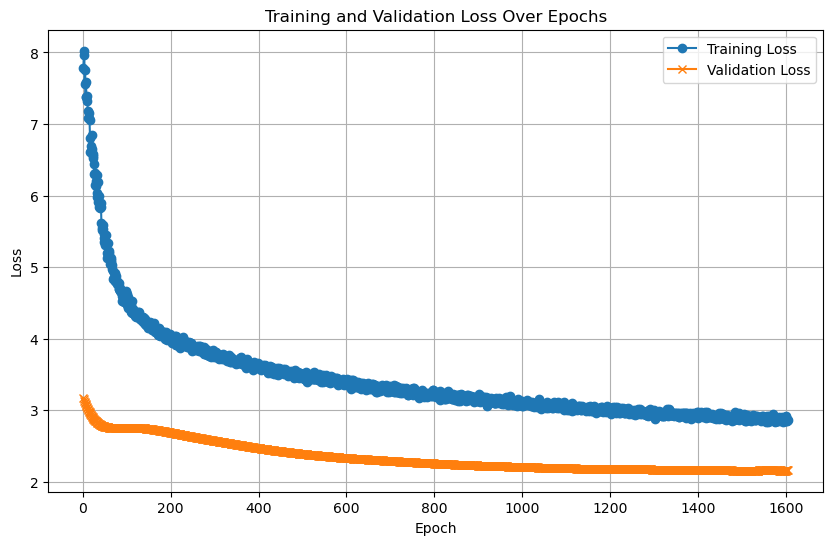

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/211], Loss: 5.1982
Test Batch [20/211], Loss: 5.4429
Test Batch [30/211], Loss: 5.6566
Test Batch [40/211], Loss: 5.8626
Test Batch [50/211], Loss: 6.4065


Test Batch [60/211], Loss: 5.4530
Test Batch [70/211], Loss: 4.8523
Test Batch [80/211], Loss: 5.4993
Test Batch [90/211], Loss: 5.0292
Test Batch [100/211], Loss: 5.0752
Test Batch [110/211], Loss: 5.2937
Test Batch [120/211], Loss: 5.4847
Test Batch [130/211], Loss: 5.0592
Test Batch [140/211], Loss: 5.0447
Test Batch [150/211], Loss: 4.9560


Test Batch [160/211], Loss: 5.3774
Test Batch [170/211], Loss: 5.2815
Test Batch [180/211], Loss: 5.6150
Test Batch [190/211], Loss: 5.3453
Test Batch [200/211], Loss: 5.2132


Test Batch [210/211], Loss: 5.0877

Test Loss: 5.3532


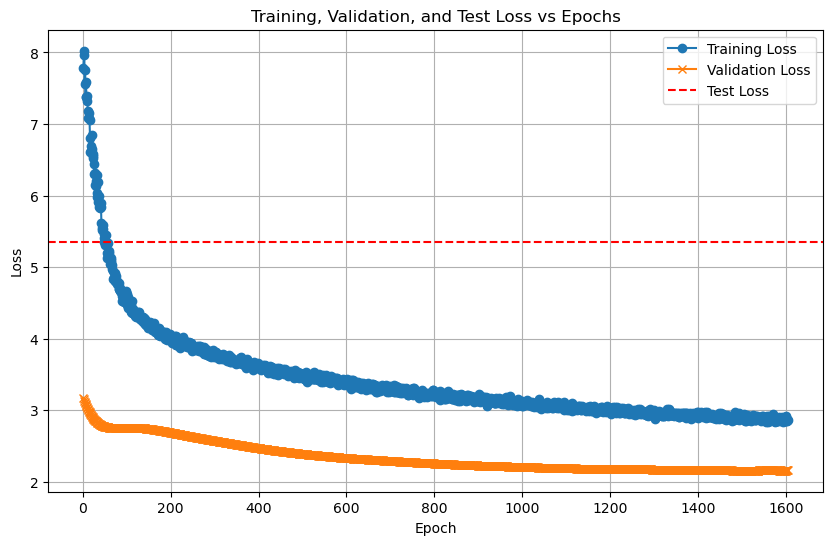

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/211 for test dataset.
  Processed batch 20/211 for test dataset.


  Processed batch 30/211 for test dataset.
  Processed batch 40/211 for test dataset.
  Processed batch 50/211 for test dataset.


  Processed batch 60/211 for test dataset.
  Processed batch 70/211 for test dataset.
  Processed batch 80/211 for test dataset.
  Processed batch 90/211 for test dataset.


  Processed batch 100/211 for test dataset.
  Processed batch 110/211 for test dataset.
  Processed batch 120/211 for test dataset.


  Processed batch 130/211 for test dataset.
  Processed batch 140/211 for test dataset.
  Processed batch 150/211 for test dataset.
  Processed batch 160/211 for test dataset.


  Processed batch 170/211 for test dataset.
  Processed batch 180/211 for test dataset.
  Processed batch 190/211 for test dataset.


  Processed batch 200/211 for test dataset.
  Processed batch 210/211 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (160, 128)
Train labels shape: (160,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53889, 128)
Test labels shape: (53889,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 91.25%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      0.80      0.89         5
           7       0.62      1.00      0.77         5
           8       1.00      1.00      1.00         5
           9       0.67      0.80      0.73         5
          10       0.80      0.80      0.80         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       1.0

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (160, 128)
Train labels shape: (160,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53889, 128)
Test labels shape: (53889,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8050  |  Val Loss: 2.8042
Validation loss improved from inf to 2.8042.
[Epoch 2/1000] Train Loss: 2.7799  |  Val Loss: 2.7823
Validation loss improved from 2.8042 to 2.7823.
[Epoch 3/1000] Train Loss: 2.7591  |  Val Loss: 2.7616
Validation loss improved from 2.7823 to 2.7616.
[Epoch 4/1000] Train Loss: 2.7390  |  Val Loss: 2.7416
Validation loss improved from 2.7616 to 2.7416.
[Epoch 5/1000] Train Loss: 2.7188  |  Val Loss: 2.7228
Validation loss improved from 2.7416 to 2.7228.
[Epoch 6/1000] Train Loss: 2.7001  |  Val Loss: 2.7044
Validation loss improved from 2.7228 to 2.7044.
[Epoch 7/1000] Train Loss: 2.6825  |  Val Loss: 2.6868
Validation loss improved from 2.7044 to 2.6868.
[Epoch 8/1000] Train Loss: 2.6662  |  Val Loss: 2.6708
Validation loss improved from 2.6868 to 2.6708.
[Epoch 9/1000] Train Loss: 2.6495  |  Val Loss: 2.6564
Validation loss improved from 2.6708 to 2.6564.
[Epoch 10/1000] Train Loss: 2.6354  |  Val Loss: 2.6424
Validation loss impr

[Epoch 25/1000] Train Loss: 2.4654  |  Val Loss: 2.4782
Validation loss improved from 2.4883 to 2.4782.
[Epoch 26/1000] Train Loss: 2.4551  |  Val Loss: 2.4682
Validation loss improved from 2.4782 to 2.4682.
[Epoch 27/1000] Train Loss: 2.4446  |  Val Loss: 2.4580
Validation loss improved from 2.4682 to 2.4580.
[Epoch 28/1000] Train Loss: 2.4340  |  Val Loss: 2.4475
Validation loss improved from 2.4580 to 2.4475.
[Epoch 29/1000] Train Loss: 2.4235  |  Val Loss: 2.4369
Validation loss improved from 2.4475 to 2.4369.
[Epoch 30/1000] Train Loss: 2.4129  |  Val Loss: 2.4262
Validation loss improved from 2.4369 to 2.4262.
[Epoch 31/1000] Train Loss: 2.4019  |  Val Loss: 2.4156
Validation loss improved from 2.4262 to 2.4156.
[Epoch 32/1000] Train Loss: 2.3911  |  Val Loss: 2.4050
Validation loss improved from 2.4156 to 2.4050.
[Epoch 33/1000] Train Loss: 2.3802  |  Val Loss: 2.3943
Validation loss improved from 2.4050 to 2.3943.
[Epoch 34/1000] Train Loss: 2.3698  |  Val Loss: 2.3834
Validati

[Epoch 55/1000] Train Loss: 2.1379  |  Val Loss: 2.1564
Validation loss improved from 2.1675 to 2.1564.
[Epoch 56/1000] Train Loss: 2.1265  |  Val Loss: 2.1453
Validation loss improved from 2.1564 to 2.1453.
[Epoch 57/1000] Train Loss: 2.1150  |  Val Loss: 2.1341
Validation loss improved from 2.1453 to 2.1341.
[Epoch 58/1000] Train Loss: 2.1032  |  Val Loss: 2.1230
Validation loss improved from 2.1341 to 2.1230.
[Epoch 59/1000] Train Loss: 2.0918  |  Val Loss: 2.1117
Validation loss improved from 2.1230 to 2.1117.
[Epoch 60/1000] Train Loss: 2.0801  |  Val Loss: 2.1003
Validation loss improved from 2.1117 to 2.1003.
[Epoch 61/1000] Train Loss: 2.0682  |  Val Loss: 2.0888
Validation loss improved from 2.1003 to 2.0888.
[Epoch 62/1000] Train Loss: 2.0561  |  Val Loss: 2.0772
Validation loss improved from 2.0888 to 2.0772.
[Epoch 63/1000] Train Loss: 2.0442  |  Val Loss: 2.0656
Validation loss improved from 2.0772 to 2.0656.
[Epoch 64/1000] Train Loss: 2.0323  |  Val Loss: 2.0540
Validati

[Epoch 81/1000] Train Loss: 1.8201  |  Val Loss: 1.8467
Validation loss improved from 1.8594 to 1.8467.
[Epoch 82/1000] Train Loss: 1.8070  |  Val Loss: 1.8339
Validation loss improved from 1.8467 to 1.8339.
[Epoch 83/1000] Train Loss: 1.7942  |  Val Loss: 1.8210
Validation loss improved from 1.8339 to 1.8210.
[Epoch 84/1000] Train Loss: 1.7808  |  Val Loss: 1.8083
Validation loss improved from 1.8210 to 1.8083.
[Epoch 85/1000] Train Loss: 1.7674  |  Val Loss: 1.7952
Validation loss improved from 1.8083 to 1.7952.
[Epoch 86/1000] Train Loss: 1.7540  |  Val Loss: 1.7818
Validation loss improved from 1.7952 to 1.7818.
[Epoch 87/1000] Train Loss: 1.7399  |  Val Loss: 1.7684
Validation loss improved from 1.7818 to 1.7684.
[Epoch 88/1000] Train Loss: 1.7267  |  Val Loss: 1.7549
Validation loss improved from 1.7684 to 1.7549.
[Epoch 89/1000] Train Loss: 1.7127  |  Val Loss: 1.7416
Validation loss improved from 1.7549 to 1.7416.
[Epoch 90/1000] Train Loss: 1.6992  |  Val Loss: 1.7286
Validati

[Epoch 108/1000] Train Loss: 1.4566  |  Val Loss: 1.4916
Validation loss improved from 1.5048 to 1.4916.
[Epoch 109/1000] Train Loss: 1.4434  |  Val Loss: 1.4786
Validation loss improved from 1.4916 to 1.4786.
[Epoch 110/1000] Train Loss: 1.4300  |  Val Loss: 1.4653
Validation loss improved from 1.4786 to 1.4653.
[Epoch 111/1000] Train Loss: 1.4166  |  Val Loss: 1.4523
Validation loss improved from 1.4653 to 1.4523.
[Epoch 112/1000] Train Loss: 1.4035  |  Val Loss: 1.4391
Validation loss improved from 1.4523 to 1.4391.
[Epoch 113/1000] Train Loss: 1.3905  |  Val Loss: 1.4261
Validation loss improved from 1.4391 to 1.4261.
[Epoch 114/1000] Train Loss: 1.3774  |  Val Loss: 1.4134
Validation loss improved from 1.4261 to 1.4134.
[Epoch 115/1000] Train Loss: 1.3645  |  Val Loss: 1.4006
Validation loss improved from 1.4134 to 1.4006.
[Epoch 116/1000] Train Loss: 1.3520  |  Val Loss: 1.3878
Validation loss improved from 1.4006 to 1.3878.
[Epoch 117/1000] Train Loss: 1.3392  |  Val Loss: 1.375

[Epoch 137/1000] Train Loss: 1.0997  |  Val Loss: 1.1414
Validation loss improved from 1.1522 to 1.1414.
[Epoch 138/1000] Train Loss: 1.0886  |  Val Loss: 1.1307
Validation loss improved from 1.1414 to 1.1307.
[Epoch 139/1000] Train Loss: 1.0777  |  Val Loss: 1.1202
Validation loss improved from 1.1307 to 1.1202.
[Epoch 140/1000] Train Loss: 1.0667  |  Val Loss: 1.1096
Validation loss improved from 1.1202 to 1.1096.
[Epoch 141/1000] Train Loss: 1.0563  |  Val Loss: 1.0991
Validation loss improved from 1.1096 to 1.0991.
[Epoch 142/1000] Train Loss: 1.0457  |  Val Loss: 1.0886
Validation loss improved from 1.0991 to 1.0886.
[Epoch 143/1000] Train Loss: 1.0348  |  Val Loss: 1.0782
Validation loss improved from 1.0886 to 1.0782.
[Epoch 144/1000] Train Loss: 1.0245  |  Val Loss: 1.0682
Validation loss improved from 1.0782 to 1.0682.
[Epoch 145/1000] Train Loss: 1.0143  |  Val Loss: 1.0582
Validation loss improved from 1.0682 to 1.0582.
[Epoch 146/1000] Train Loss: 1.0039  |  Val Loss: 1.048

[Epoch 168/1000] Train Loss: 0.7982  |  Val Loss: 0.8502
Validation loss improved from 0.8586 to 0.8502.
[Epoch 169/1000] Train Loss: 0.7901  |  Val Loss: 0.8422
Validation loss improved from 0.8502 to 0.8422.
[Epoch 170/1000] Train Loss: 0.7819  |  Val Loss: 0.8345
Validation loss improved from 0.8422 to 0.8345.
[Epoch 171/1000] Train Loss: 0.7739  |  Val Loss: 0.8268
Validation loss improved from 0.8345 to 0.8268.
[Epoch 172/1000] Train Loss: 0.7662  |  Val Loss: 0.8198
Validation loss improved from 0.8268 to 0.8198.
[Epoch 173/1000] Train Loss: 0.7577  |  Val Loss: 0.8122
Validation loss improved from 0.8198 to 0.8122.
[Epoch 174/1000] Train Loss: 0.7498  |  Val Loss: 0.8046
Validation loss improved from 0.8122 to 0.8046.
[Epoch 175/1000] Train Loss: 0.7421  |  Val Loss: 0.7972
Validation loss improved from 0.8046 to 0.7972.
[Epoch 176/1000] Train Loss: 0.7344  |  Val Loss: 0.7902
Validation loss improved from 0.7972 to 0.7902.
[Epoch 177/1000] Train Loss: 0.7268  |  Val Loss: 0.783

[Epoch 195/1000] Train Loss: 0.6034  |  Val Loss: 0.6678
Validation loss improved from 0.6737 to 0.6678.
[Epoch 196/1000] Train Loss: 0.5975  |  Val Loss: 0.6620
Validation loss improved from 0.6678 to 0.6620.
[Epoch 197/1000] Train Loss: 0.5911  |  Val Loss: 0.6565
Validation loss improved from 0.6620 to 0.6565.
[Epoch 198/1000] Train Loss: 0.5854  |  Val Loss: 0.6511
Validation loss improved from 0.6565 to 0.6511.
[Epoch 199/1000] Train Loss: 0.5794  |  Val Loss: 0.6460
Validation loss improved from 0.6511 to 0.6460.
[Epoch 200/1000] Train Loss: 0.5737  |  Val Loss: 0.6408
Validation loss improved from 0.6460 to 0.6408.
[Epoch 201/1000] Train Loss: 0.5679  |  Val Loss: 0.6352
Validation loss improved from 0.6408 to 0.6352.
[Epoch 202/1000] Train Loss: 0.5623  |  Val Loss: 0.6291
Validation loss improved from 0.6352 to 0.6291.
[Epoch 203/1000] Train Loss: 0.5564  |  Val Loss: 0.6233
Validation loss improved from 0.6291 to 0.6233.
[Epoch 204/1000] Train Loss: 0.5509  |  Val Loss: 0.618

[Epoch 222/1000] Train Loss: 0.4601  |  Val Loss: 0.5346
Validation loss improved from 0.5387 to 0.5346.
[Epoch 223/1000] Train Loss: 0.4557  |  Val Loss: 0.5305
Validation loss improved from 0.5346 to 0.5305.
[Epoch 224/1000] Train Loss: 0.4511  |  Val Loss: 0.5266
Validation loss improved from 0.5305 to 0.5266.
[Epoch 225/1000] Train Loss: 0.4469  |  Val Loss: 0.5223
Validation loss improved from 0.5266 to 0.5223.
[Epoch 226/1000] Train Loss: 0.4424  |  Val Loss: 0.5188
Validation loss improved from 0.5223 to 0.5188.
[Epoch 227/1000] Train Loss: 0.4381  |  Val Loss: 0.5154
Validation loss improved from 0.5188 to 0.5154.
[Epoch 228/1000] Train Loss: 0.4336  |  Val Loss: 0.5119
Validation loss improved from 0.5154 to 0.5119.
[Epoch 229/1000] Train Loss: 0.4295  |  Val Loss: 0.5080
Validation loss improved from 0.5119 to 0.5080.
[Epoch 230/1000] Train Loss: 0.4253  |  Val Loss: 0.5040
Validation loss improved from 0.5080 to 0.5040.
[Epoch 231/1000] Train Loss: 0.4214  |  Val Loss: 0.500

[Epoch 251/1000] Train Loss: 0.3496  |  Val Loss: 0.4343
Validation loss improved from 0.4369 to 0.4343.
[Epoch 252/1000] Train Loss: 0.3465  |  Val Loss: 0.4317
Validation loss improved from 0.4343 to 0.4317.
[Epoch 253/1000] Train Loss: 0.3437  |  Val Loss: 0.4286
Validation loss improved from 0.4317 to 0.4286.
[Epoch 254/1000] Train Loss: 0.3404  |  Val Loss: 0.4257
Validation loss improved from 0.4286 to 0.4257.
[Epoch 255/1000] Train Loss: 0.3376  |  Val Loss: 0.4235
Validation loss improved from 0.4257 to 0.4235.
[Epoch 256/1000] Train Loss: 0.3345  |  Val Loss: 0.4209
Validation loss improved from 0.4235 to 0.4209.
[Epoch 257/1000] Train Loss: 0.3318  |  Val Loss: 0.4186
Validation loss improved from 0.4209 to 0.4186.
[Epoch 258/1000] Train Loss: 0.3288  |  Val Loss: 0.4161
Validation loss improved from 0.4186 to 0.4161.
[Epoch 259/1000] Train Loss: 0.3260  |  Val Loss: 0.4136
Validation loss improved from 0.4161 to 0.4136.
[Epoch 260/1000] Train Loss: 0.3230  |  Val Loss: 0.410

[Epoch 283/1000] Train Loss: 0.2659  |  Val Loss: 0.3620
Validation loss improved from 0.3625 to 0.3620.
[Epoch 284/1000] Train Loss: 0.2643  |  Val Loss: 0.3619
Validation loss improved from 0.3620 to 0.3619.
[Epoch 285/1000] Train Loss: 0.2629  |  Val Loss: 0.3610
Validation loss improved from 0.3619 to 0.3610.
[Epoch 286/1000] Train Loss: 0.2614  |  Val Loss: 0.3594
Validation loss improved from 0.3610 to 0.3594.
[Epoch 287/1000] Train Loss: 0.2589  |  Val Loss: 0.3554
Validation loss improved from 0.3594 to 0.3554.
[Epoch 288/1000] Train Loss: 0.2560  |  Val Loss: 0.3525
Validation loss improved from 0.3554 to 0.3525.
[Epoch 289/1000] Train Loss: 0.2543  |  Val Loss: 0.3500
Validation loss improved from 0.3525 to 0.3500.
[Epoch 290/1000] Train Loss: 0.2519  |  Val Loss: 0.3484
Validation loss improved from 0.3500 to 0.3484.
[Epoch 291/1000] Train Loss: 0.2498  |  Val Loss: 0.3472
Validation loss improved from 0.3484 to 0.3472.
[Epoch 292/1000] Train Loss: 0.2476  |  Val Loss: 0.346

[Epoch 312/1000] Train Loss: 0.2139  |  Val Loss: 0.3162
Validation loss improved from 0.3167 to 0.3162.
[Epoch 313/1000] Train Loss: 0.2121  |  Val Loss: 0.3149
Validation loss improved from 0.3162 to 0.3149.
[Epoch 314/1000] Train Loss: 0.2105  |  Val Loss: 0.3137
Validation loss improved from 0.3149 to 0.3137.
[Epoch 315/1000] Train Loss: 0.2091  |  Val Loss: 0.3129
Validation loss improved from 0.3137 to 0.3129.
[Epoch 316/1000] Train Loss: 0.2076  |  Val Loss: 0.3118
Validation loss improved from 0.3129 to 0.3118.
[Epoch 317/1000] Train Loss: 0.2062  |  Val Loss: 0.3113
Validation loss improved from 0.3118 to 0.3113.
[Epoch 318/1000] Train Loss: 0.2048  |  Val Loss: 0.3106
Validation loss improved from 0.3113 to 0.3106.
[Epoch 319/1000] Train Loss: 0.2033  |  Val Loss: 0.3089
Validation loss improved from 0.3106 to 0.3089.
[Epoch 320/1000] Train Loss: 0.2020  |  Val Loss: 0.3071
Validation loss improved from 0.3089 to 0.3071.
[Epoch 321/1000] Train Loss: 0.2006  |  Val Loss: 0.305

[Epoch 341/1000] Train Loss: 0.1760  |  Val Loss: 0.2863
Validation loss improved from 0.2872 to 0.2863.
[Epoch 342/1000] Train Loss: 0.1748  |  Val Loss: 0.2851
Validation loss improved from 0.2863 to 0.2851.
[Epoch 343/1000] Train Loss: 0.1738  |  Val Loss: 0.2847
Validation loss improved from 0.2851 to 0.2847.
[Epoch 344/1000] Train Loss: 0.1727  |  Val Loss: 0.2838
Validation loss improved from 0.2847 to 0.2838.
[Epoch 345/1000] Train Loss: 0.1716  |  Val Loss: 0.2833
Validation loss improved from 0.2838 to 0.2833.
[Epoch 346/1000] Train Loss: 0.1705  |  Val Loss: 0.2820
Validation loss improved from 0.2833 to 0.2820.
[Epoch 347/1000] Train Loss: 0.1694  |  Val Loss: 0.2807
Validation loss improved from 0.2820 to 0.2807.
[Epoch 348/1000] Train Loss: 0.1683  |  Val Loss: 0.2798
Validation loss improved from 0.2807 to 0.2798.
[Epoch 349/1000] Train Loss: 0.1673  |  Val Loss: 0.2790
Validation loss improved from 0.2798 to 0.2790.
[Epoch 350/1000] Train Loss: 0.1664  |  Val Loss: 0.278

[Epoch 368/1000] Train Loss: 0.1500  |  Val Loss: 0.2657
Validation loss improved from 0.2666 to 0.2657.
[Epoch 369/1000] Train Loss: 0.1492  |  Val Loss: 0.2648
Validation loss improved from 0.2657 to 0.2648.
[Epoch 370/1000] Train Loss: 0.1482  |  Val Loss: 0.2641
Validation loss improved from 0.2648 to 0.2641.
[Epoch 371/1000] Train Loss: 0.1474  |  Val Loss: 0.2633
Validation loss improved from 0.2641 to 0.2633.
[Epoch 372/1000] Train Loss: 0.1468  |  Val Loss: 0.2622
Validation loss improved from 0.2633 to 0.2622.
[Epoch 373/1000] Train Loss: 0.1458  |  Val Loss: 0.2615
Validation loss improved from 0.2622 to 0.2615.
[Epoch 374/1000] Train Loss: 0.1453  |  Val Loss: 0.2611
Validation loss improved from 0.2615 to 0.2611.
[Epoch 375/1000] Train Loss: 0.1445  |  Val Loss: 0.2622
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 376/1000] Train Loss: 0.1439  |  Val Loss: 0.2624
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 377/1000] Train Loss: 0.1428  |  Val

[Epoch 396/1000] Train Loss: 0.1293  |  Val Loss: 0.2481
Validation loss improved from 0.2495 to 0.2481.
[Epoch 397/1000] Train Loss: 0.1288  |  Val Loss: 0.2466
Validation loss improved from 0.2481 to 0.2466.
[Epoch 398/1000] Train Loss: 0.1283  |  Val Loss: 0.2458
Validation loss improved from 0.2466 to 0.2458.
[Epoch 399/1000] Train Loss: 0.1279  |  Val Loss: 0.2451
Validation loss improved from 0.2458 to 0.2451.
[Epoch 400/1000] Train Loss: 0.1274  |  Val Loss: 0.2466
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 401/1000] Train Loss: 0.1263  |  Val Loss: 0.2470
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 402/1000] Train Loss: 0.1257  |  Val Loss: 0.2477
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 403/1000] Train Loss: 0.1251  |  Val Loss: 0.2472
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 404/1000] Train Loss: 0.1243  |  Val Loss: 0.2468
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 405/1000] Train Lo

[Epoch 427/1000] Train Loss: 0.1117  |  Val Loss: 0.2374
Validation loss improved from 0.2377 to 0.2374.
[Epoch 428/1000] Train Loss: 0.1112  |  Val Loss: 0.2368
Validation loss improved from 0.2374 to 0.2368.
[Epoch 429/1000] Train Loss: 0.1108  |  Val Loss: 0.2356
Validation loss improved from 0.2368 to 0.2356.
[Epoch 430/1000] Train Loss: 0.1103  |  Val Loss: 0.2352
Validation loss improved from 0.2356 to 0.2352.
[Epoch 431/1000] Train Loss: 0.1101  |  Val Loss: 0.2345
Validation loss improved from 0.2352 to 0.2345.
[Epoch 432/1000] Train Loss: 0.1095  |  Val Loss: 0.2343
Validation loss improved from 0.2345 to 0.2343.
[Epoch 433/1000] Train Loss: 0.1090  |  Val Loss: 0.2342
Validation loss improved from 0.2343 to 0.2342.
[Epoch 434/1000] Train Loss: 0.1084  |  Val Loss: 0.2352
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 435/1000] Train Loss: 0.1078  |  Val Loss: 0.2354
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 436/1000] Train Loss: 0.1075  |  Val

[Epoch 455/1000] Train Loss: 0.0992  |  Val Loss: 0.2316
Validation loss improved from 0.2318 to 0.2316.
[Epoch 456/1000] Train Loss: 0.0993  |  Val Loss: 0.2306
Validation loss improved from 0.2316 to 0.2306.
[Epoch 457/1000] Train Loss: 0.0987  |  Val Loss: 0.2308
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 458/1000] Train Loss: 0.0980  |  Val Loss: 0.2316
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 459/1000] Train Loss: 0.0973  |  Val Loss: 0.2334
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 460/1000] Train Loss: 0.0974  |  Val Loss: 0.2341
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 461/1000] Train Loss: 0.0970  |  Val Loss: 0.2331
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 462/1000] Train Loss: 0.0963  |  Val Loss: 0.2321
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 463/1000] Train Loss: 0.0961  |  Val Loss: 0.2311
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 464/10

[Epoch 482/1000] Train Loss: 0.0890  |  Val Loss: 0.2261
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 483/1000] Train Loss: 0.0887  |  Val Loss: 0.2261
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 484/1000] Train Loss: 0.0882  |  Val Loss: 0.2259
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 485/1000] Train Loss: 0.0881  |  Val Loss: 0.2257
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 486/1000] Train Loss: 0.0877  |  Val Loss: 0.2244
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 487/1000] Train Loss: 0.0875  |  Val Loss: 0.2234
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 488/1000] Train Loss: 0.0871  |  Val Loss: 0.2231
Validation loss improved from 0.2233 to 0.2231.
[Epoch 489/1000] Train Loss: 0.0868  |  Val Loss: 0.2232
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 490/1000] Train Loss: 0.0864  |  Val Loss: 0.2228
Validation loss improved from 0.2231 to 0.2228.
[Epoch 491/10

[Epoch 510/1000] Train Loss: 0.0808  |  Val Loss: 0.2218
Validation loss improved from 0.2221 to 0.2218.
[Epoch 511/1000] Train Loss: 0.0803  |  Val Loss: 0.2226
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 512/1000] Train Loss: 0.0800  |  Val Loss: 0.2235
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 513/1000] Train Loss: 0.0798  |  Val Loss: 0.2252
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 514/1000] Train Loss: 0.0797  |  Val Loss: 0.2259
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 515/1000] Train Loss: 0.0794  |  Val Loss: 0.2253
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 516/1000] Train Loss: 0.0789  |  Val Loss: 0.2244
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 517/1000] Train Loss: 0.0787  |  Val Loss: 0.2235
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 518/1000] Train Loss: 0.0785  |  Val Loss: 0.2229
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 540/1000] Train Loss: 0.0730  |  Val Loss: 0.2209
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 541/1000] Train Loss: 0.0728  |  Val Loss: 0.2204
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 542/1000] Train Loss: 0.0726  |  Val Loss: 0.2204
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 543/1000] Train Loss: 0.0725  |  Val Loss: 0.2205
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 544/1000] Train Loss: 0.0723  |  Val Loss: 0.2206
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 545/1000] Train Loss: 0.0721  |  Val Loss: 0.2204
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 546/1000] Train Loss: 0.0718  |  Val Loss: 0.2218
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 547/1000] Train Loss: 0.0716  |  Val Loss: 0.2224
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 548/1000] Train Loss: 0.0714  |  Val Loss: 0.2224
!! Validation loss did NOT improve !! Patience:

[Epoch 569/1000] Train Loss: 0.0671  |  Val Loss: 0.2214
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 570/1000] Train Loss: 0.0670  |  Val Loss: 0.2213
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 571/1000] Train Loss: 0.0668  |  Val Loss: 0.2213
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 572/1000] Train Loss: 0.0668  |  Val Loss: 0.2205
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 573/1000] Train Loss: 0.0666  |  Val Loss: 0.2201
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 574/1000] Train Loss: 0.0665  |  Val Loss: 0.2207
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 575/1000] Train Loss: 0.0661  |  Val Loss: 0.2202
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 576/1000] Train Loss: 0.0658  |  Val Loss: 0.2196
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 577/1000] Train Loss: 0.0656  |  Val Loss: 0.2191
!! Validation loss did NOT improve !! Patience:

[Epoch 598/1000] Train Loss: 0.0621  |  Val Loss: 0.2210
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 599/1000] Train Loss: 0.0618  |  Val Loss: 0.2193
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 600/1000] Train Loss: 0.0617  |  Val Loss: 0.2174
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 601/1000] Train Loss: 0.0615  |  Val Loss: 0.2165
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 602/1000] Train Loss: 0.0617  |  Val Loss: 0.2157
Validation loss improved from 0.2165 to 0.2157.
[Epoch 603/1000] Train Loss: 0.0615  |  Val Loss: 0.2146
Validation loss improved from 0.2157 to 0.2146.
[Epoch 604/1000] Train Loss: 0.0614  |  Val Loss: 0.2146
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 605/1000] Train Loss: 0.0612  |  Val Loss: 0.2159
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 606/1000] Train Loss: 0.0609  |  Val Loss: 0.2176
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 60

[Epoch 626/1000] Train Loss: 0.0579  |  Val Loss: 0.2192
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 627/1000] Train Loss: 0.0580  |  Val Loss: 0.2196
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 628/1000] Train Loss: 0.0578  |  Val Loss: 0.2192
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 629/1000] Train Loss: 0.0576  |  Val Loss: 0.2202
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 630/1000] Train Loss: 0.0575  |  Val Loss: 0.2220
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 631/1000] Train Loss: 0.0573  |  Val Loss: 0.2227
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 632/1000] Train Loss: 0.0572  |  Val Loss: 0.2229
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 633/1000] Train Loss: 0.0570  |  Val Loss: 0.2226
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 634/1000] Train Loss: 0.0568  |  Val Loss: 0.2218
!! Validation loss did NOT improve !! Patience:

[Epoch 657/1000] Train Loss: 0.0536  |  Val Loss: 0.2190
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 658/1000] Train Loss: 0.0536  |  Val Loss: 0.2179
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 659/1000] Train Loss: 0.0536  |  Val Loss: 0.2181
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 660/1000] Train Loss: 0.0536  |  Val Loss: 0.2175
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 661/1000] Train Loss: 0.0533  |  Val Loss: 0.2184
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 662/1000] Train Loss: 0.0530  |  Val Loss: 0.2196
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 663/1000] Train Loss: 0.0531  |  Val Loss: 0.2207
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 664/1000] Train Loss: 0.0530  |  Val Loss: 0.2211
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 665/1000] Train Loss: 0.0531  |  Val Loss: 0.2205
!! Validation loss did NOT improve !! Patience:

[Epoch 685/1000] Train Loss: 0.0506  |  Val Loss: 0.2212
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 686/1000] Train Loss: 0.0505  |  Val Loss: 0.2218
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 687/1000] Train Loss: 0.0504  |  Val Loss: 0.2225
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 688/1000] Train Loss: 0.0502  |  Val Loss: 0.2231
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 689/1000] Train Loss: 0.0501  |  Val Loss: 0.2226
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 690/1000] Train Loss: 0.0500  |  Val Loss: 0.2219
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 691/1000] Train Loss: 0.0498  |  Val Loss: 0.2215
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 692/1000] Train Loss: 0.0498  |  Val Loss: 0.2206
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 693/1000] Train Loss: 0.0498  |  Val Loss: 0.2201
!! Validation loss did NOT improve !! Patience:

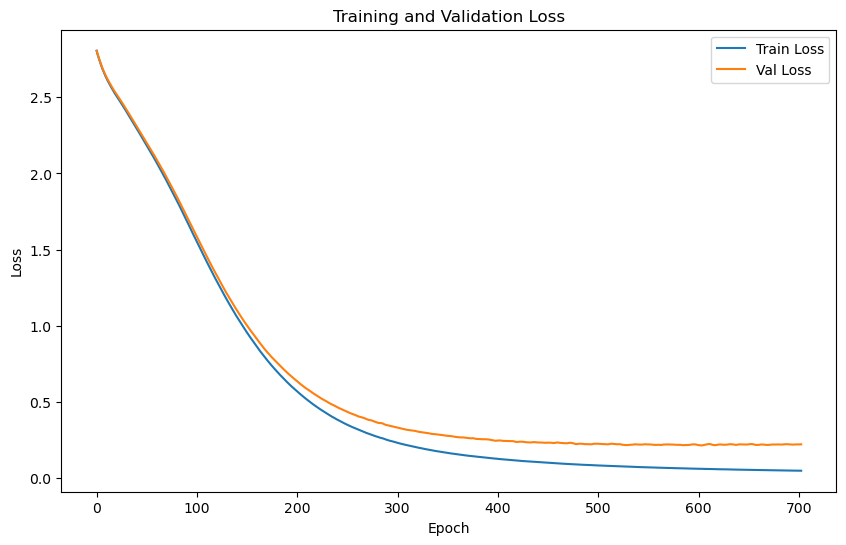

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.8706 | Test Accuracy: 80.32%


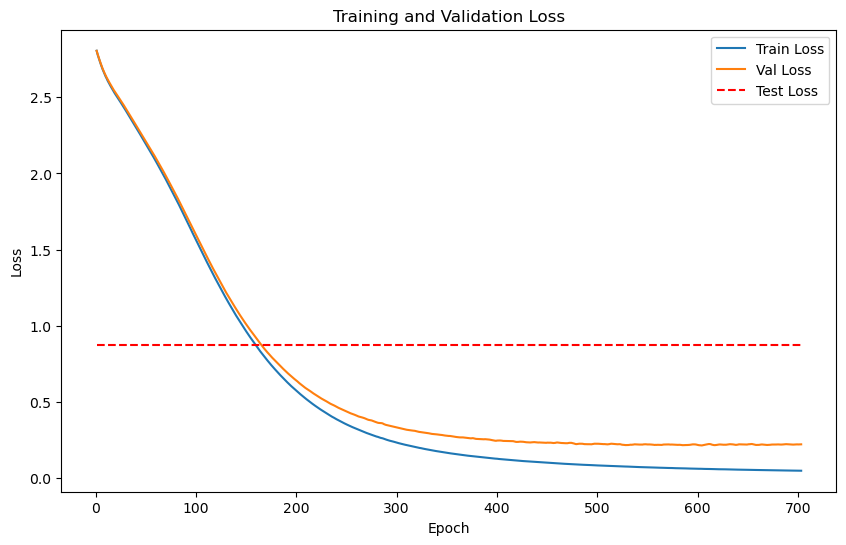

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 160 samples with 64 features each
LOG: Labels shape: (160,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53889 samples with 64 features each
LOG: Labels shape: (53889,)


Train embeddings shape: (160, 64), 
Train labels shape: (160,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (53889, 64), 
Test labels shape: (53889,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10, 14: 10, 15: 10}
Training batch size: 160


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4676
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.2841
    Batch [2/2], Val Loss: 0.4533
Epoch [1/2000], Avg Train Loss: 0.4676, Avg Val Loss: 0.3687

Validation loss improved from inf to 0.3687. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4733
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.2870
    Batch [2/2], Val Loss: 0.4504
Epoch [2/2000], Avg Train Loss: 0.4733, Avg Val Loss: 0.3687

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4666
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.2895
    Batch [2/2], Val Loss: 0.4475
Epoch [3/2000], Avg Train Loss: 0.4666, Avg Val Loss: 0.3685

Validation loss improved from 0.3687 to 0.3685. Saving model...
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4673
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.2916
    Batch [2/2], Val Loss: 0.4435
Epoch [4/2000], Avg Train Loss: 0.4673, Avg Val Loss: 0.3676

Validation loss improved from 0.3685 to 0.3676. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4662
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.2941
    Batch [2/2], Val Loss: 0.4397
Epoch [5/2000], Avg Train Loss: 0.4662, Avg Val Loss: 0.3669

Validation loss improved from 0.3676 to 0.3669. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4616
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.2969
    Batch [2/2], Val Loss: 0.4365
Epoch [6/2000], Avg Train Loss: 0.4616, Avg Val Loss: 0.3667

Validation loss improved from 0.3669 to 0.3667. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4629
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.3001
    Batch [2/2], Val Loss: 0.4334
Epoch [7/2000], Avg Train Loss: 0.4629, Avg Val Loss: 0.3668

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4617
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.3028
    Batch [2/2], Val Loss: 0.4296
Epoch [8/2000], Avg Train Loss: 0.4617, Avg Val Loss: 0.3662

Validation loss improved from 0.3667 to 0.3662. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4623
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.3043
    Batch [2/2], Val Loss: 0.4263
Epoch [9/2000], Avg Train Loss: 0.4623, Avg Val Loss: 0.3653

Validation loss improved from 0.3662 to 0.3653. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4593
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.3055
    Batch [2/2], Val Loss: 0.4229
Epoch [10/2000], Avg Train Loss: 0.4593, Avg Val Loss: 0.3642

Validation loss improved from 0.3653 to 0.3642. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4593
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.3061
    Batch [2/2], Val Loss: 0.4202
Epoch [11/2000], Avg Train Loss: 0.4593, Avg Val Loss: 0.3631

Validation loss improved from 0.3642 to 0.3631. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4628
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.3061
    Batch [2/2], Val Loss: 0.4174
Epoch [12/2000], Avg Train Loss: 0.4628, Avg Val Loss: 0.3617

Validation loss improved from 0.3631 to 0.3617. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4572
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.3063
    Batch [2/2], Val Loss: 0.4153
Epoch [13/2000], Avg Train Loss: 0.4572, Avg Val Loss: 0.3608

Validation loss improved from 0.3617 to 0.3608. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4579
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.3064
    Batch [2/2], Val Loss: 0.4133
Epoch [14/2000], Avg Train Loss: 0.4579, Avg Val Loss: 0.3599

Validation loss improved from 0.3608 to 0.3599. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4555
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.3060
    Batch [2/2], Val Loss: 0.4121
Epoch [15/2000], Avg Train Loss: 0.4555, Avg Val Loss: 0.3591

Validation loss improved from 0.3599 to 0.3591. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4551
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.3054
    Batch [2/2], Val Loss: 0.4117
Epoch [16/2000], Avg Train Loss: 0.4551, Avg Val Loss: 0.3586

Validation loss improved from 0.3591 to 0.3586. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4523
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.3046
    Batch [2/2], Val Loss: 0.4117
Epoch [17/2000], Avg Train Loss: 0.4523, Avg Val Loss: 0.3581

Validation loss improved from 0.3586 to 0.3581. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4537
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.3038
    Batch [2/2], Val Loss: 0.4118
Epoch [18/2000], Avg Train Loss: 0.4537, Avg Val Loss: 0.3578

Validation loss improved from 0.3581 to 0.3578. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4526
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.3030
    Batch [2/2], Val Loss: 0.4120
Epoch [19/2000], Avg Train Loss: 0.4526, Avg Val Loss: 0.3575

Validation loss improved from 0.3578 to 0.3575. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4492
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.3022
    Batch [2/2], Val Loss: 0.4126
Epoch [20/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.3574

Validation loss improved from 0.3575 to 0.3574. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4506
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.3010
    Batch [2/2], Val Loss: 0.4127
Epoch [21/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.3568

Validation loss improved from 0.3574 to 0.3568. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4489
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.2998
    Batch [2/2], Val Loss: 0.4125
Epoch [22/2000], Avg Train Loss: 0.4489, Avg Val Loss: 0.3561

Validation loss improved from 0.3568 to 0.3561. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4538
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.2985
    Batch [2/2], Val Loss: 0.4123
Epoch [23/2000], Avg Train Loss: 0.4538, Avg Val Loss: 0.3554

Validation loss improved from 0.3561 to 0.3554. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4480
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.2972
    Batch [2/2], Val Loss: 0.4119
Epoch [24/2000], Avg Train Loss: 0.4480, Avg Val Loss: 0.3546

Validation loss improved from 0.3554 to 0.3546. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4484
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.2961
    Batch [2/2], Val Loss: 0.4115
Epoch [25/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.3538

Validation loss improved from 0.3546 to 0.3538. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4459
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.2950
    Batch [2/2], Val Loss: 0.4111
Epoch [26/2000], Avg Train Loss: 0.4459, Avg Val Loss: 0.3531

Validation loss improved from 0.3538 to 0.3531. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4475
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.2938
    Batch [2/2], Val Loss: 0.4108
Epoch [27/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.3523

Validation loss improved from 0.3531 to 0.3523. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4446
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.2927
    Batch [2/2], Val Loss: 0.4104
Epoch [28/2000], Avg Train Loss: 0.4446, Avg Val Loss: 0.3515

Validation loss improved from 0.3523 to 0.3515. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4469
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.2915
    Batch [2/2], Val Loss: 0.4101
Epoch [29/2000], Avg Train Loss: 0.4469, Avg Val Loss: 0.3508

Validation loss improved from 0.3515 to 0.3508. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4455
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.2903
    Batch [2/2], Val Loss: 0.4098
Epoch [30/2000], Avg Train Loss: 0.4455, Avg Val Loss: 0.3501

Validation loss improved from 0.3508 to 0.3501. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4459
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.2892
    Batch [2/2], Val Loss: 0.4096
Epoch [31/2000], Avg Train Loss: 0.4459, Avg Val Loss: 0.3494

Validation loss improved from 0.3501 to 0.3494. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4483
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.2882
    Batch [2/2], Val Loss: 0.4093
Epoch [32/2000], Avg Train Loss: 0.4483, Avg Val Loss: 0.3487

Validation loss improved from 0.3494 to 0.3487. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4445
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.2872
    Batch [2/2], Val Loss: 0.4091
Epoch [33/2000], Avg Train Loss: 0.4445, Avg Val Loss: 0.3481

Validation loss improved from 0.3487 to 0.3481. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4522
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.2863
    Batch [2/2], Val Loss: 0.4088
Epoch [34/2000], Avg Train Loss: 0.4522, Avg Val Loss: 0.3475

Validation loss improved from 0.3481 to 0.3475. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4483
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.2853
    Batch [2/2], Val Loss: 0.4086
Epoch [35/2000], Avg Train Loss: 0.4483, Avg Val Loss: 0.3470

Validation loss improved from 0.3475 to 0.3470. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4388
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.2844
    Batch [2/2], Val Loss: 0.4085
Epoch [36/2000], Avg Train Loss: 0.4388, Avg Val Loss: 0.3465

Validation loss improved from 0.3470 to 0.3465. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4370
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.2836
    Batch [2/2], Val Loss: 0.4084
Epoch [37/2000], Avg Train Loss: 0.4370, Avg Val Loss: 0.3460

Validation loss improved from 0.3465 to 0.3460. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4444
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.2827
    Batch [2/2], Val Loss: 0.4082
Epoch [38/2000], Avg Train Loss: 0.4444, Avg Val Loss: 0.3455

Validation loss improved from 0.3460 to 0.3455. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4413
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.2819
    Batch [2/2], Val Loss: 0.4082
Epoch [39/2000], Avg Train Loss: 0.4413, Avg Val Loss: 0.3450

Validation loss improved from 0.3455 to 0.3450. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4395
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.2810
    Batch [2/2], Val Loss: 0.4081
Epoch [40/2000], Avg Train Loss: 0.4395, Avg Val Loss: 0.3446

Validation loss improved from 0.3450 to 0.3446. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4413
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.2802
    Batch [2/2], Val Loss: 0.4079
Epoch [41/2000], Avg Train Loss: 0.4413, Avg Val Loss: 0.3441

Validation loss improved from 0.3446 to 0.3441. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4353
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.2794
    Batch [2/2], Val Loss: 0.4076
Epoch [42/2000], Avg Train Loss: 0.4353, Avg Val Loss: 0.3435

Validation loss improved from 0.3441 to 0.3435. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4405
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.2787
    Batch [2/2], Val Loss: 0.4074
Epoch [43/2000], Avg Train Loss: 0.4405, Avg Val Loss: 0.3430

Validation loss improved from 0.3435 to 0.3430. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4449
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.2779
    Batch [2/2], Val Loss: 0.4071
Epoch [44/2000], Avg Train Loss: 0.4449, Avg Val Loss: 0.3425

Validation loss improved from 0.3430 to 0.3425. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4395
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.2771
    Batch [2/2], Val Loss: 0.4068
Epoch [45/2000], Avg Train Loss: 0.4395, Avg Val Loss: 0.3420

Validation loss improved from 0.3425 to 0.3420. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4377
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.2764
    Batch [2/2], Val Loss: 0.4065
Epoch [46/2000], Avg Train Loss: 0.4377, Avg Val Loss: 0.3414

Validation loss improved from 0.3420 to 0.3414. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4308
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.2756
    Batch [2/2], Val Loss: 0.4062
Epoch [47/2000], Avg Train Loss: 0.4308, Avg Val Loss: 0.3409

Validation loss improved from 0.3414 to 0.3409. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4352
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.2749
    Batch [2/2], Val Loss: 0.4059
Epoch [48/2000], Avg Train Loss: 0.4352, Avg Val Loss: 0.3404

Validation loss improved from 0.3409 to 0.3404. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4384
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.2742
    Batch [2/2], Val Loss: 0.4056
Epoch [49/2000], Avg Train Loss: 0.4384, Avg Val Loss: 0.3399

Validation loss improved from 0.3404 to 0.3399. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4356
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.2735
    Batch [2/2], Val Loss: 0.4052
Epoch [50/2000], Avg Train Loss: 0.4356, Avg Val Loss: 0.3394

Validation loss improved from 0.3399 to 0.3394. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4397
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.2728
    Batch [2/2], Val Loss: 0.4048
Epoch [51/2000], Avg Train Loss: 0.4397, Avg Val Loss: 0.3388

Validation loss improved from 0.3394 to 0.3388. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4334
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.2721
    Batch [2/2], Val Loss: 0.4045
Epoch [52/2000], Avg Train Loss: 0.4334, Avg Val Loss: 0.3383

Validation loss improved from 0.3388 to 0.3383. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4366
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.2715
    Batch [2/2], Val Loss: 0.4040
Epoch [53/2000], Avg Train Loss: 0.4366, Avg Val Loss: 0.3378

Validation loss improved from 0.3383 to 0.3378. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4370
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.2708
    Batch [2/2], Val Loss: 0.4037
Epoch [54/2000], Avg Train Loss: 0.4370, Avg Val Loss: 0.3372

Validation loss improved from 0.3378 to 0.3372. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4258
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.2701
    Batch [2/2], Val Loss: 0.4033
Epoch [55/2000], Avg Train Loss: 0.4258, Avg Val Loss: 0.3367

Validation loss improved from 0.3372 to 0.3367. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4278
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.2694
    Batch [2/2], Val Loss: 0.4030
Epoch [56/2000], Avg Train Loss: 0.4278, Avg Val Loss: 0.3362

Validation loss improved from 0.3367 to 0.3362. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4279
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.2688
    Batch [2/2], Val Loss: 0.4027
Epoch [57/2000], Avg Train Loss: 0.4279, Avg Val Loss: 0.3357

Validation loss improved from 0.3362 to 0.3357. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4324
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.2681
    Batch [2/2], Val Loss: 0.4023
Epoch [58/2000], Avg Train Loss: 0.4324, Avg Val Loss: 0.3352

Validation loss improved from 0.3357 to 0.3352. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4264
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.2675
    Batch [2/2], Val Loss: 0.4020
Epoch [59/2000], Avg Train Loss: 0.4264, Avg Val Loss: 0.3347

Validation loss improved from 0.3352 to 0.3347. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4306
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.2668
    Batch [2/2], Val Loss: 0.4016
Epoch [60/2000], Avg Train Loss: 0.4306, Avg Val Loss: 0.3342

Validation loss improved from 0.3347 to 0.3342. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4271
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.2661
    Batch [2/2], Val Loss: 0.4014
Epoch [61/2000], Avg Train Loss: 0.4271, Avg Val Loss: 0.3338

Validation loss improved from 0.3342 to 0.3338. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4333
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.2655
    Batch [2/2], Val Loss: 0.4012
Epoch [62/2000], Avg Train Loss: 0.4333, Avg Val Loss: 0.3333

Validation loss improved from 0.3338 to 0.3333. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4304
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.2649
    Batch [2/2], Val Loss: 0.4009
Epoch [63/2000], Avg Train Loss: 0.4304, Avg Val Loss: 0.3329

Validation loss improved from 0.3333 to 0.3329. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4293
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.2642
    Batch [2/2], Val Loss: 0.4006
Epoch [64/2000], Avg Train Loss: 0.4293, Avg Val Loss: 0.3324

Validation loss improved from 0.3329 to 0.3324. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4331
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.2636
    Batch [2/2], Val Loss: 0.4002
Epoch [65/2000], Avg Train Loss: 0.4331, Avg Val Loss: 0.3319

Validation loss improved from 0.3324 to 0.3319. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4217
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.2630
    Batch [2/2], Val Loss: 0.3997
Epoch [66/2000], Avg Train Loss: 0.4217, Avg Val Loss: 0.3314

Validation loss improved from 0.3319 to 0.3314. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4330
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.2624
    Batch [2/2], Val Loss: 0.3993
Epoch [67/2000], Avg Train Loss: 0.4330, Avg Val Loss: 0.3309

Validation loss improved from 0.3314 to 0.3309. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4235
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.2618
    Batch [2/2], Val Loss: 0.3988
Epoch [68/2000], Avg Train Loss: 0.4235, Avg Val Loss: 0.3303

Validation loss improved from 0.3309 to 0.3303. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4275
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.2612
    Batch [2/2], Val Loss: 0.3984
Epoch [69/2000], Avg Train Loss: 0.4275, Avg Val Loss: 0.3298

Validation loss improved from 0.3303 to 0.3298. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4228
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.2606
    Batch [2/2], Val Loss: 0.3979
Epoch [70/2000], Avg Train Loss: 0.4228, Avg Val Loss: 0.3292

Validation loss improved from 0.3298 to 0.3292. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4242
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.2600
    Batch [2/2], Val Loss: 0.3975
Epoch [71/2000], Avg Train Loss: 0.4242, Avg Val Loss: 0.3288

Validation loss improved from 0.3292 to 0.3288. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4203
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.2595
    Batch [2/2], Val Loss: 0.3971
Epoch [72/2000], Avg Train Loss: 0.4203, Avg Val Loss: 0.3283

Validation loss improved from 0.3288 to 0.3283. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4175
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.2589
    Batch [2/2], Val Loss: 0.3967
Epoch [73/2000], Avg Train Loss: 0.4175, Avg Val Loss: 0.3278

Validation loss improved from 0.3283 to 0.3278. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4201
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.2584
    Batch [2/2], Val Loss: 0.3964
Epoch [74/2000], Avg Train Loss: 0.4201, Avg Val Loss: 0.3274

Validation loss improved from 0.3278 to 0.3274. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4189
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.2578
    Batch [2/2], Val Loss: 0.3961
Epoch [75/2000], Avg Train Loss: 0.4189, Avg Val Loss: 0.3270

Validation loss improved from 0.3274 to 0.3270. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4252
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.2573
    Batch [2/2], Val Loss: 0.3958
Epoch [76/2000], Avg Train Loss: 0.4252, Avg Val Loss: 0.3266

Validation loss improved from 0.3270 to 0.3266. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4235
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.2568
    Batch [2/2], Val Loss: 0.3954
Epoch [77/2000], Avg Train Loss: 0.4235, Avg Val Loss: 0.3261

Validation loss improved from 0.3266 to 0.3261. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4145
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.2562
    Batch [2/2], Val Loss: 0.3950
Epoch [78/2000], Avg Train Loss: 0.4145, Avg Val Loss: 0.3256

Validation loss improved from 0.3261 to 0.3256. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4210
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.2557
    Batch [2/2], Val Loss: 0.3946
Epoch [79/2000], Avg Train Loss: 0.4210, Avg Val Loss: 0.3251

Validation loss improved from 0.3256 to 0.3251. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4150
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.2552
    Batch [2/2], Val Loss: 0.3941
Epoch [80/2000], Avg Train Loss: 0.4150, Avg Val Loss: 0.3246

Validation loss improved from 0.3251 to 0.3246. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4155
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.2546
    Batch [2/2], Val Loss: 0.3937
Epoch [81/2000], Avg Train Loss: 0.4155, Avg Val Loss: 0.3242

Validation loss improved from 0.3246 to 0.3242. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4222
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.2541
    Batch [2/2], Val Loss: 0.3932
Epoch [82/2000], Avg Train Loss: 0.4222, Avg Val Loss: 0.3237

Validation loss improved from 0.3242 to 0.3237. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4151
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.2536
    Batch [2/2], Val Loss: 0.3927
Epoch [83/2000], Avg Train Loss: 0.4151, Avg Val Loss: 0.3232

Validation loss improved from 0.3237 to 0.3232. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4178
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.2530
    Batch [2/2], Val Loss: 0.3922
Epoch [84/2000], Avg Train Loss: 0.4178, Avg Val Loss: 0.3226

Validation loss improved from 0.3232 to 0.3226. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4086
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.2525
    Batch [2/2], Val Loss: 0.3917
Epoch [85/2000], Avg Train Loss: 0.4086, Avg Val Loss: 0.3221

Validation loss improved from 0.3226 to 0.3221. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4137
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.2520
    Batch [2/2], Val Loss: 0.3913
Epoch [86/2000], Avg Train Loss: 0.4137, Avg Val Loss: 0.3216

Validation loss improved from 0.3221 to 0.3216. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4101
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.2514
    Batch [2/2], Val Loss: 0.3907
Epoch [87/2000], Avg Train Loss: 0.4101, Avg Val Loss: 0.3211

Validation loss improved from 0.3216 to 0.3211. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4158
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.2509
    Batch [2/2], Val Loss: 0.3903
Epoch [88/2000], Avg Train Loss: 0.4158, Avg Val Loss: 0.3206

Validation loss improved from 0.3211 to 0.3206. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4057
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.2504
    Batch [2/2], Val Loss: 0.3899
Epoch [89/2000], Avg Train Loss: 0.4057, Avg Val Loss: 0.3202

Validation loss improved from 0.3206 to 0.3202. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4108
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.2499
    Batch [2/2], Val Loss: 0.3895
Epoch [90/2000], Avg Train Loss: 0.4108, Avg Val Loss: 0.3197

Validation loss improved from 0.3202 to 0.3197. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4130
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.2495
    Batch [2/2], Val Loss: 0.3890
Epoch [91/2000], Avg Train Loss: 0.4130, Avg Val Loss: 0.3192

Validation loss improved from 0.3197 to 0.3192. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4038
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.2489
    Batch [2/2], Val Loss: 0.3886
Epoch [92/2000], Avg Train Loss: 0.4038, Avg Val Loss: 0.3188

Validation loss improved from 0.3192 to 0.3188. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4103
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.2484
    Batch [2/2], Val Loss: 0.3882
Epoch [93/2000], Avg Train Loss: 0.4103, Avg Val Loss: 0.3183

Validation loss improved from 0.3188 to 0.3183. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4045
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.2479
    Batch [2/2], Val Loss: 0.3877
Epoch [94/2000], Avg Train Loss: 0.4045, Avg Val Loss: 0.3178

Validation loss improved from 0.3183 to 0.3178. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4053
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.2474
    Batch [2/2], Val Loss: 0.3873
Epoch [95/2000], Avg Train Loss: 0.4053, Avg Val Loss: 0.3173

Validation loss improved from 0.3178 to 0.3173. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4072
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.2470
    Batch [2/2], Val Loss: 0.3869
Epoch [96/2000], Avg Train Loss: 0.4072, Avg Val Loss: 0.3169

Validation loss improved from 0.3173 to 0.3169. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4044
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.2465
    Batch [2/2], Val Loss: 0.3864
Epoch [97/2000], Avg Train Loss: 0.4044, Avg Val Loss: 0.3165

Validation loss improved from 0.3169 to 0.3165. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4044
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.2460
    Batch [2/2], Val Loss: 0.3859
Epoch [98/2000], Avg Train Loss: 0.4044, Avg Val Loss: 0.3160

Validation loss improved from 0.3165 to 0.3160. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4066
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.2455
    Batch [2/2], Val Loss: 0.3855
Epoch [99/2000], Avg Train Loss: 0.4066, Avg Val Loss: 0.3155

Validation loss improved from 0.3160 to 0.3155. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4046
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.2451
    Batch [2/2], Val Loss: 0.3851
Epoch [100/2000], Avg Train Loss: 0.4046, Avg Val Loss: 0.3151

Validation loss improved from 0.3155 to 0.3151. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.2446
    Batch [2/2], Val Loss: 0.3848
Epoch [101/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.3147

Validation loss improved from 0.3151 to 0.3147. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.4043
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.2441
    Batch [2/2], Val Loss: 0.3844
Epoch [102/2000], Avg Train Loss: 0.4043, Avg Val Loss: 0.3143

Validation loss improved from 0.3147 to 0.3143. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4043
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.2436
    Batch [2/2], Val Loss: 0.3842
Epoch [103/2000], Avg Train Loss: 0.4043, Avg Val Loss: 0.3139

Validation loss improved from 0.3143 to 0.3139. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.3960
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.2432
    Batch [2/2], Val Loss: 0.3841
Epoch [104/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.3136

Validation loss improved from 0.3139 to 0.3136. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.3993
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.2427
    Batch [2/2], Val Loss: 0.3840
Epoch [105/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.3133

Validation loss improved from 0.3136 to 0.3133. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.4019
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.2423
    Batch [2/2], Val Loss: 0.3838
Epoch [106/2000], Avg Train Loss: 0.4019, Avg Val Loss: 0.3131

Validation loss improved from 0.3133 to 0.3131. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.3974
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.2419
    Batch [2/2], Val Loss: 0.3836
Epoch [107/2000], Avg Train Loss: 0.3974, Avg Val Loss: 0.3127

Validation loss improved from 0.3131 to 0.3127. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.4039
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.2414
    Batch [2/2], Val Loss: 0.3834
Epoch [108/2000], Avg Train Loss: 0.4039, Avg Val Loss: 0.3124

Validation loss improved from 0.3127 to 0.3124. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.3982
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.2410
    Batch [2/2], Val Loss: 0.3832
Epoch [109/2000], Avg Train Loss: 0.3982, Avg Val Loss: 0.3121

Validation loss improved from 0.3124 to 0.3121. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.4023
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.2405
    Batch [2/2], Val Loss: 0.3829
Epoch [110/2000], Avg Train Loss: 0.4023, Avg Val Loss: 0.3117

Validation loss improved from 0.3121 to 0.3117. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.3960
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.2401
    Batch [2/2], Val Loss: 0.3827
Epoch [111/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.3114

Validation loss improved from 0.3117 to 0.3114. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.2397
    Batch [2/2], Val Loss: 0.3824
Epoch [112/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.3111

Validation loss improved from 0.3114 to 0.3111. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.3962
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.2394
    Batch [2/2], Val Loss: 0.3820
Epoch [113/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.3107

Validation loss improved from 0.3111 to 0.3107. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.2390
    Batch [2/2], Val Loss: 0.3816
Epoch [114/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.3103

Validation loss improved from 0.3107 to 0.3103. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.4002
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.2387
    Batch [2/2], Val Loss: 0.3812
Epoch [115/2000], Avg Train Loss: 0.4002, Avg Val Loss: 0.3099

Validation loss improved from 0.3103 to 0.3099. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.3956
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.2384
    Batch [2/2], Val Loss: 0.3808
Epoch [116/2000], Avg Train Loss: 0.3956, Avg Val Loss: 0.3096

Validation loss improved from 0.3099 to 0.3096. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.2381
    Batch [2/2], Val Loss: 0.3803
Epoch [117/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.3092

Validation loss improved from 0.3096 to 0.3092. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.3982
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.2378
    Batch [2/2], Val Loss: 0.3797
Epoch [118/2000], Avg Train Loss: 0.3982, Avg Val Loss: 0.3088

Validation loss improved from 0.3092 to 0.3088. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.2375
    Batch [2/2], Val Loss: 0.3792
Epoch [119/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.3084

Validation loss improved from 0.3088 to 0.3084. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.2372
    Batch [2/2], Val Loss: 0.3787
Epoch [120/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.3079

Validation loss improved from 0.3084 to 0.3079. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.2367
    Batch [2/2], Val Loss: 0.3782
Epoch [121/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.3075

Validation loss improved from 0.3079 to 0.3075. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.2363
    Batch [2/2], Val Loss: 0.3777
Epoch [122/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.3070

Validation loss improved from 0.3075 to 0.3070. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.2359
    Batch [2/2], Val Loss: 0.3774
Epoch [123/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.3066

Validation loss improved from 0.3070 to 0.3066. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.3868
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.2355
    Batch [2/2], Val Loss: 0.3770
Epoch [124/2000], Avg Train Loss: 0.3868, Avg Val Loss: 0.3063

Validation loss improved from 0.3066 to 0.3063. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.2352
    Batch [2/2], Val Loss: 0.3767
Epoch [125/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.3059

Validation loss improved from 0.3063 to 0.3059. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.3894
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.2348
    Batch [2/2], Val Loss: 0.3764
Epoch [126/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.3056

Validation loss improved from 0.3059 to 0.3056. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.3872
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.2344
    Batch [2/2], Val Loss: 0.3761
Epoch [127/2000], Avg Train Loss: 0.3872, Avg Val Loss: 0.3052

Validation loss improved from 0.3056 to 0.3052. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.3880
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.2340
    Batch [2/2], Val Loss: 0.3757
Epoch [128/2000], Avg Train Loss: 0.3880, Avg Val Loss: 0.3048

Validation loss improved from 0.3052 to 0.3048. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.3936
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.2335
    Batch [2/2], Val Loss: 0.3752
Epoch [129/2000], Avg Train Loss: 0.3936, Avg Val Loss: 0.3044

Validation loss improved from 0.3048 to 0.3044. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.3872
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.2331
    Batch [2/2], Val Loss: 0.3747
Epoch [130/2000], Avg Train Loss: 0.3872, Avg Val Loss: 0.3039

Validation loss improved from 0.3044 to 0.3039. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.3856
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.2328
    Batch [2/2], Val Loss: 0.3742
Epoch [131/2000], Avg Train Loss: 0.3856, Avg Val Loss: 0.3035

Validation loss improved from 0.3039 to 0.3035. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.3827
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.2324
    Batch [2/2], Val Loss: 0.3738
Epoch [132/2000], Avg Train Loss: 0.3827, Avg Val Loss: 0.3031

Validation loss improved from 0.3035 to 0.3031. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.3845
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.2320
    Batch [2/2], Val Loss: 0.3734
Epoch [133/2000], Avg Train Loss: 0.3845, Avg Val Loss: 0.3027

Validation loss improved from 0.3031 to 0.3027. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.3868
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.2317
    Batch [2/2], Val Loss: 0.3730
Epoch [134/2000], Avg Train Loss: 0.3868, Avg Val Loss: 0.3024

Validation loss improved from 0.3027 to 0.3024. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.3821
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.2313
    Batch [2/2], Val Loss: 0.3727
Epoch [135/2000], Avg Train Loss: 0.3821, Avg Val Loss: 0.3020

Validation loss improved from 0.3024 to 0.3020. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.3794
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.2310
    Batch [2/2], Val Loss: 0.3723
Epoch [136/2000], Avg Train Loss: 0.3794, Avg Val Loss: 0.3017

Validation loss improved from 0.3020 to 0.3017. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.3835
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.2306
    Batch [2/2], Val Loss: 0.3719
Epoch [137/2000], Avg Train Loss: 0.3835, Avg Val Loss: 0.3013

Validation loss improved from 0.3017 to 0.3013. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.3850
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.2303
    Batch [2/2], Val Loss: 0.3714
Epoch [138/2000], Avg Train Loss: 0.3850, Avg Val Loss: 0.3008

Validation loss improved from 0.3013 to 0.3008. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.2299
    Batch [2/2], Val Loss: 0.3709
Epoch [139/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.3004

Validation loss improved from 0.3008 to 0.3004. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.3815
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.2295
    Batch [2/2], Val Loss: 0.3704
Epoch [140/2000], Avg Train Loss: 0.3815, Avg Val Loss: 0.3000

Validation loss improved from 0.3004 to 0.3000. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.3812
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.2292
    Batch [2/2], Val Loss: 0.3700
Epoch [141/2000], Avg Train Loss: 0.3812, Avg Val Loss: 0.2996

Validation loss improved from 0.3000 to 0.2996. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.3795
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.2289
    Batch [2/2], Val Loss: 0.3695
Epoch [142/2000], Avg Train Loss: 0.3795, Avg Val Loss: 0.2992

Validation loss improved from 0.2996 to 0.2992. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.3765
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.2286
    Batch [2/2], Val Loss: 0.3692
Epoch [143/2000], Avg Train Loss: 0.3765, Avg Val Loss: 0.2989

Validation loss improved from 0.2992 to 0.2989. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.3702
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.2283
    Batch [2/2], Val Loss: 0.3688
Epoch [144/2000], Avg Train Loss: 0.3702, Avg Val Loss: 0.2986

Validation loss improved from 0.2989 to 0.2986. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.3810
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.2281
    Batch [2/2], Val Loss: 0.3685
Epoch [145/2000], Avg Train Loss: 0.3810, Avg Val Loss: 0.2983

Validation loss improved from 0.2986 to 0.2983. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.3802
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.2277
    Batch [2/2], Val Loss: 0.3683
Epoch [146/2000], Avg Train Loss: 0.3802, Avg Val Loss: 0.2980

Validation loss improved from 0.2983 to 0.2980. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.3756
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.2274
    Batch [2/2], Val Loss: 0.3682
Epoch [147/2000], Avg Train Loss: 0.3756, Avg Val Loss: 0.2978

Validation loss improved from 0.2980 to 0.2978. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.3794
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.2271
    Batch [2/2], Val Loss: 0.3681
Epoch [148/2000], Avg Train Loss: 0.3794, Avg Val Loss: 0.2976

Validation loss improved from 0.2978 to 0.2976. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.3763
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.2268
    Batch [2/2], Val Loss: 0.3680
Epoch [149/2000], Avg Train Loss: 0.3763, Avg Val Loss: 0.2974

Validation loss improved from 0.2976 to 0.2974. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.3768
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.2265
    Batch [2/2], Val Loss: 0.3678
Epoch [150/2000], Avg Train Loss: 0.3768, Avg Val Loss: 0.2972

Validation loss improved from 0.2974 to 0.2972. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.3695
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.2262
    Batch [2/2], Val Loss: 0.3677
Epoch [151/2000], Avg Train Loss: 0.3695, Avg Val Loss: 0.2969

Validation loss improved from 0.2972 to 0.2969. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.3731
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.2259
    Batch [2/2], Val Loss: 0.3676
Epoch [152/2000], Avg Train Loss: 0.3731, Avg Val Loss: 0.2967

Validation loss improved from 0.2969 to 0.2967. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.3711
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.2256
    Batch [2/2], Val Loss: 0.3674
Epoch [153/2000], Avg Train Loss: 0.3711, Avg Val Loss: 0.2965

Validation loss improved from 0.2967 to 0.2965. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.3791
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.2253
    Batch [2/2], Val Loss: 0.3672
Epoch [154/2000], Avg Train Loss: 0.3791, Avg Val Loss: 0.2962

Validation loss improved from 0.2965 to 0.2962. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.3749
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.2251
    Batch [2/2], Val Loss: 0.3670
Epoch [155/2000], Avg Train Loss: 0.3749, Avg Val Loss: 0.2960

Validation loss improved from 0.2962 to 0.2960. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.3764
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.2248
    Batch [2/2], Val Loss: 0.3668
Epoch [156/2000], Avg Train Loss: 0.3764, Avg Val Loss: 0.2958

Validation loss improved from 0.2960 to 0.2958. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.3759
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.2245
    Batch [2/2], Val Loss: 0.3665
Epoch [157/2000], Avg Train Loss: 0.3759, Avg Val Loss: 0.2955

Validation loss improved from 0.2958 to 0.2955. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.3732
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.2243
    Batch [2/2], Val Loss: 0.3662
Epoch [158/2000], Avg Train Loss: 0.3732, Avg Val Loss: 0.2952

Validation loss improved from 0.2955 to 0.2952. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.3757
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.2241
    Batch [2/2], Val Loss: 0.3659
Epoch [159/2000], Avg Train Loss: 0.3757, Avg Val Loss: 0.2950

Validation loss improved from 0.2952 to 0.2950. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.3684
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.2239
    Batch [2/2], Val Loss: 0.3655
Epoch [160/2000], Avg Train Loss: 0.3684, Avg Val Loss: 0.2947

Validation loss improved from 0.2950 to 0.2947. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.3626
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.2236
    Batch [2/2], Val Loss: 0.3652
Epoch [161/2000], Avg Train Loss: 0.3626, Avg Val Loss: 0.2944

Validation loss improved from 0.2947 to 0.2944. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.3674
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.2235
    Batch [2/2], Val Loss: 0.3648
Epoch [162/2000], Avg Train Loss: 0.3674, Avg Val Loss: 0.2941

Validation loss improved from 0.2944 to 0.2941. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.3716
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.2233
    Batch [2/2], Val Loss: 0.3644
Epoch [163/2000], Avg Train Loss: 0.3716, Avg Val Loss: 0.2938

Validation loss improved from 0.2941 to 0.2938. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.3643
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.2231
    Batch [2/2], Val Loss: 0.3640
Epoch [164/2000], Avg Train Loss: 0.3643, Avg Val Loss: 0.2935

Validation loss improved from 0.2938 to 0.2935. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.3720
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.2228
    Batch [2/2], Val Loss: 0.3635
Epoch [165/2000], Avg Train Loss: 0.3720, Avg Val Loss: 0.2932

Validation loss improved from 0.2935 to 0.2932. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.3742
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.2226
    Batch [2/2], Val Loss: 0.3631
Epoch [166/2000], Avg Train Loss: 0.3742, Avg Val Loss: 0.2928

Validation loss improved from 0.2932 to 0.2928. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.3744
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.2223
    Batch [2/2], Val Loss: 0.3626
Epoch [167/2000], Avg Train Loss: 0.3744, Avg Val Loss: 0.2924

Validation loss improved from 0.2928 to 0.2924. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.3726
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.2219
    Batch [2/2], Val Loss: 0.3621
Epoch [168/2000], Avg Train Loss: 0.3726, Avg Val Loss: 0.2920

Validation loss improved from 0.2924 to 0.2920. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.3604
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.2216
    Batch [2/2], Val Loss: 0.3615
Epoch [169/2000], Avg Train Loss: 0.3604, Avg Val Loss: 0.2915

Validation loss improved from 0.2920 to 0.2915. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.3649
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.2213
    Batch [2/2], Val Loss: 0.3609
Epoch [170/2000], Avg Train Loss: 0.3649, Avg Val Loss: 0.2911

Validation loss improved from 0.2915 to 0.2911. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.3673
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.2210
    Batch [2/2], Val Loss: 0.3605
Epoch [171/2000], Avg Train Loss: 0.3673, Avg Val Loss: 0.2907

Validation loss improved from 0.2911 to 0.2907. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.3628
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.2208
    Batch [2/2], Val Loss: 0.3600
Epoch [172/2000], Avg Train Loss: 0.3628, Avg Val Loss: 0.2904

Validation loss improved from 0.2907 to 0.2904. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.3673
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.2205
    Batch [2/2], Val Loss: 0.3596
Epoch [173/2000], Avg Train Loss: 0.3673, Avg Val Loss: 0.2901

Validation loss improved from 0.2904 to 0.2901. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.3682
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.2202
    Batch [2/2], Val Loss: 0.3592
Epoch [174/2000], Avg Train Loss: 0.3682, Avg Val Loss: 0.2897

Validation loss improved from 0.2901 to 0.2897. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.3650
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.2199
    Batch [2/2], Val Loss: 0.3588
Epoch [175/2000], Avg Train Loss: 0.3650, Avg Val Loss: 0.2893

Validation loss improved from 0.2897 to 0.2893. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.3622
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.2195
    Batch [2/2], Val Loss: 0.3584
Epoch [176/2000], Avg Train Loss: 0.3622, Avg Val Loss: 0.2890

Validation loss improved from 0.2893 to 0.2890. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.3605
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.2192
    Batch [2/2], Val Loss: 0.3580
Epoch [177/2000], Avg Train Loss: 0.3605, Avg Val Loss: 0.2886

Validation loss improved from 0.2890 to 0.2886. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.3593
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.2189
    Batch [2/2], Val Loss: 0.3575
Epoch [178/2000], Avg Train Loss: 0.3593, Avg Val Loss: 0.2882

Validation loss improved from 0.2886 to 0.2882. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.3601
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.2186
    Batch [2/2], Val Loss: 0.3572
Epoch [179/2000], Avg Train Loss: 0.3601, Avg Val Loss: 0.2879

Validation loss improved from 0.2882 to 0.2879. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.3589
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.2183
    Batch [2/2], Val Loss: 0.3569
Epoch [180/2000], Avg Train Loss: 0.3589, Avg Val Loss: 0.2876

Validation loss improved from 0.2879 to 0.2876. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.3573
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.2180
    Batch [2/2], Val Loss: 0.3567
Epoch [181/2000], Avg Train Loss: 0.3573, Avg Val Loss: 0.2874

Validation loss improved from 0.2876 to 0.2874. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.3549
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.2176
    Batch [2/2], Val Loss: 0.3565
Epoch [182/2000], Avg Train Loss: 0.3549, Avg Val Loss: 0.2871

Validation loss improved from 0.2874 to 0.2871. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.3558
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.2173
    Batch [2/2], Val Loss: 0.3564
Epoch [183/2000], Avg Train Loss: 0.3558, Avg Val Loss: 0.2868

Validation loss improved from 0.2871 to 0.2868. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.3647
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.2170
    Batch [2/2], Val Loss: 0.3563
Epoch [184/2000], Avg Train Loss: 0.3647, Avg Val Loss: 0.2866

Validation loss improved from 0.2868 to 0.2866. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.3667
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.2166
    Batch [2/2], Val Loss: 0.3561
Epoch [185/2000], Avg Train Loss: 0.3667, Avg Val Loss: 0.2863

Validation loss improved from 0.2866 to 0.2863. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.3590
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.2163
    Batch [2/2], Val Loss: 0.3558
Epoch [186/2000], Avg Train Loss: 0.3590, Avg Val Loss: 0.2861

Validation loss improved from 0.2863 to 0.2861. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.3620
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.2161
    Batch [2/2], Val Loss: 0.3555
Epoch [187/2000], Avg Train Loss: 0.3620, Avg Val Loss: 0.2858

Validation loss improved from 0.2861 to 0.2858. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.3603
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.2158
    Batch [2/2], Val Loss: 0.3552
Epoch [188/2000], Avg Train Loss: 0.3603, Avg Val Loss: 0.2855

Validation loss improved from 0.2858 to 0.2855. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.3577
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.2155
    Batch [2/2], Val Loss: 0.3549
Epoch [189/2000], Avg Train Loss: 0.3577, Avg Val Loss: 0.2852

Validation loss improved from 0.2855 to 0.2852. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.3512
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.2152
    Batch [2/2], Val Loss: 0.3546
Epoch [190/2000], Avg Train Loss: 0.3512, Avg Val Loss: 0.2849

Validation loss improved from 0.2852 to 0.2849. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.3494
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.2149
    Batch [2/2], Val Loss: 0.3543
Epoch [191/2000], Avg Train Loss: 0.3494, Avg Val Loss: 0.2846

Validation loss improved from 0.2849 to 0.2846. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.3529
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.2147
    Batch [2/2], Val Loss: 0.3539
Epoch [192/2000], Avg Train Loss: 0.3529, Avg Val Loss: 0.2843

Validation loss improved from 0.2846 to 0.2843. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.3515
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.2144
    Batch [2/2], Val Loss: 0.3537
Epoch [193/2000], Avg Train Loss: 0.3515, Avg Val Loss: 0.2841

Validation loss improved from 0.2843 to 0.2841. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.3467
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.2142
    Batch [2/2], Val Loss: 0.3535
Epoch [194/2000], Avg Train Loss: 0.3467, Avg Val Loss: 0.2838

Validation loss improved from 0.2841 to 0.2838. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.3482
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.2139
    Batch [2/2], Val Loss: 0.3533
Epoch [195/2000], Avg Train Loss: 0.3482, Avg Val Loss: 0.2836

Validation loss improved from 0.2838 to 0.2836. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.3539
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.2136
    Batch [2/2], Val Loss: 0.3532
Epoch [196/2000], Avg Train Loss: 0.3539, Avg Val Loss: 0.2834

Validation loss improved from 0.2836 to 0.2834. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.3583
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.2134
    Batch [2/2], Val Loss: 0.3531
Epoch [197/2000], Avg Train Loss: 0.3583, Avg Val Loss: 0.2832

Validation loss improved from 0.2834 to 0.2832. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.3578
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.2131
    Batch [2/2], Val Loss: 0.3530
Epoch [198/2000], Avg Train Loss: 0.3578, Avg Val Loss: 0.2831

Validation loss improved from 0.2832 to 0.2831. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.3497
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.2128
    Batch [2/2], Val Loss: 0.3529
Epoch [199/2000], Avg Train Loss: 0.3497, Avg Val Loss: 0.2829

Validation loss improved from 0.2831 to 0.2829. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.3421
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.2124
    Batch [2/2], Val Loss: 0.3528
Epoch [200/2000], Avg Train Loss: 0.3421, Avg Val Loss: 0.2826

Validation loss improved from 0.2829 to 0.2826. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.2122
    Batch [2/2], Val Loss: 0.3527
Epoch [201/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.2824

Validation loss improved from 0.2826 to 0.2824. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.3537
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.2118
    Batch [2/2], Val Loss: 0.3525
Epoch [202/2000], Avg Train Loss: 0.3537, Avg Val Loss: 0.2822

Validation loss improved from 0.2824 to 0.2822. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.3550
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.2116
    Batch [2/2], Val Loss: 0.3522
Epoch [203/2000], Avg Train Loss: 0.3550, Avg Val Loss: 0.2819

Validation loss improved from 0.2822 to 0.2819. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.3460
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.2112
    Batch [2/2], Val Loss: 0.3519
Epoch [204/2000], Avg Train Loss: 0.3460, Avg Val Loss: 0.2816

Validation loss improved from 0.2819 to 0.2816. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.3493
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.2109
    Batch [2/2], Val Loss: 0.3515
Epoch [205/2000], Avg Train Loss: 0.3493, Avg Val Loss: 0.2812

Validation loss improved from 0.2816 to 0.2812. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.3452
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.2106
    Batch [2/2], Val Loss: 0.3512
Epoch [206/2000], Avg Train Loss: 0.3452, Avg Val Loss: 0.2809

Validation loss improved from 0.2812 to 0.2809. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.3425
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.2102
    Batch [2/2], Val Loss: 0.3510
Epoch [207/2000], Avg Train Loss: 0.3425, Avg Val Loss: 0.2806

Validation loss improved from 0.2809 to 0.2806. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.3489
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.2099
    Batch [2/2], Val Loss: 0.3507
Epoch [208/2000], Avg Train Loss: 0.3489, Avg Val Loss: 0.2803

Validation loss improved from 0.2806 to 0.2803. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.3452
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.2096
    Batch [2/2], Val Loss: 0.3504
Epoch [209/2000], Avg Train Loss: 0.3452, Avg Val Loss: 0.2800

Validation loss improved from 0.2803 to 0.2800. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/1], Train Loss: 0.3436
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.2093
    Batch [2/2], Val Loss: 0.3501
Epoch [210/2000], Avg Train Loss: 0.3436, Avg Val Loss: 0.2797

Validation loss improved from 0.2800 to 0.2797. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.3374
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.3498
Epoch [211/2000], Avg Train Loss: 0.3374, Avg Val Loss: 0.2794

Validation loss improved from 0.2797 to 0.2794. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.3471
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.2088
    Batch [2/2], Val Loss: 0.3496
Epoch [212/2000], Avg Train Loss: 0.3471, Avg Val Loss: 0.2792

Validation loss improved from 0.2794 to 0.2792. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.3491
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.2085
    Batch [2/2], Val Loss: 0.3492
Epoch [213/2000], Avg Train Loss: 0.3491, Avg Val Loss: 0.2789

Validation loss improved from 0.2792 to 0.2789. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.2083
    Batch [2/2], Val Loss: 0.3488
Epoch [214/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.2786

Validation loss improved from 0.2789 to 0.2786. Saving model...
LOG: Epoch [215/2000] - Training


    Batch [1/1], Train Loss: 0.3372
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.2081
    Batch [2/2], Val Loss: 0.3483
Epoch [215/2000], Avg Train Loss: 0.3372, Avg Val Loss: 0.2782

Validation loss improved from 0.2786 to 0.2782. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.3368
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.2079
    Batch [2/2], Val Loss: 0.3478
Epoch [216/2000], Avg Train Loss: 0.3368, Avg Val Loss: 0.2779

Validation loss improved from 0.2782 to 0.2779. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.3391
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.2076
    Batch [2/2], Val Loss: 0.3474
Epoch [217/2000], Avg Train Loss: 0.3391, Avg Val Loss: 0.2775

Validation loss improved from 0.2779 to 0.2775. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.2074
    Batch [2/2], Val Loss: 0.3469
Epoch [218/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.2772

Validation loss improved from 0.2775 to 0.2772. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.3370
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.2071
    Batch [2/2], Val Loss: 0.3465
Epoch [219/2000], Avg Train Loss: 0.3370, Avg Val Loss: 0.2768

Validation loss improved from 0.2772 to 0.2768. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.3372
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.2067
    Batch [2/2], Val Loss: 0.3461
Epoch [220/2000], Avg Train Loss: 0.3372, Avg Val Loss: 0.2764

Validation loss improved from 0.2768 to 0.2764. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.3420
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.2065
    Batch [2/2], Val Loss: 0.3457
Epoch [221/2000], Avg Train Loss: 0.3420, Avg Val Loss: 0.2761

Validation loss improved from 0.2764 to 0.2761. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.3425
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.2063
    Batch [2/2], Val Loss: 0.3454
Epoch [222/2000], Avg Train Loss: 0.3425, Avg Val Loss: 0.2758

Validation loss improved from 0.2761 to 0.2758. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.2060
    Batch [2/2], Val Loss: 0.3449
Epoch [223/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.2755

Validation loss improved from 0.2758 to 0.2755. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.3399
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.2058
    Batch [2/2], Val Loss: 0.3445
Epoch [224/2000], Avg Train Loss: 0.3399, Avg Val Loss: 0.2752

Validation loss improved from 0.2755 to 0.2752. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.3423
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.2056
    Batch [2/2], Val Loss: 0.3441
Epoch [225/2000], Avg Train Loss: 0.3423, Avg Val Loss: 0.2748

Validation loss improved from 0.2752 to 0.2748. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.3340
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.2054
    Batch [2/2], Val Loss: 0.3437
Epoch [226/2000], Avg Train Loss: 0.3340, Avg Val Loss: 0.2746

Validation loss improved from 0.2748 to 0.2746. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.3334
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.2051
    Batch [2/2], Val Loss: 0.3434
Epoch [227/2000], Avg Train Loss: 0.3334, Avg Val Loss: 0.2743

Validation loss improved from 0.2746 to 0.2743. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.3389
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.2048
    Batch [2/2], Val Loss: 0.3430
Epoch [228/2000], Avg Train Loss: 0.3389, Avg Val Loss: 0.2739

Validation loss improved from 0.2743 to 0.2739. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.3345
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.2045
    Batch [2/2], Val Loss: 0.3428
Epoch [229/2000], Avg Train Loss: 0.3345, Avg Val Loss: 0.2736

Validation loss improved from 0.2739 to 0.2736. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/1], Train Loss: 0.3296
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.2042
    Batch [2/2], Val Loss: 0.3425
Epoch [230/2000], Avg Train Loss: 0.3296, Avg Val Loss: 0.2734

Validation loss improved from 0.2736 to 0.2734. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.3359
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.2040
    Batch [2/2], Val Loss: 0.3423
Epoch [231/2000], Avg Train Loss: 0.3359, Avg Val Loss: 0.2731

Validation loss improved from 0.2734 to 0.2731. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.3343
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.2037
    Batch [2/2], Val Loss: 0.3421
Epoch [232/2000], Avg Train Loss: 0.3343, Avg Val Loss: 0.2729

Validation loss improved from 0.2731 to 0.2729. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.3429
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.2035
    Batch [2/2], Val Loss: 0.3419
Epoch [233/2000], Avg Train Loss: 0.3429, Avg Val Loss: 0.2727

Validation loss improved from 0.2729 to 0.2727. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.3338
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.2032
    Batch [2/2], Val Loss: 0.3417
Epoch [234/2000], Avg Train Loss: 0.3338, Avg Val Loss: 0.2725

Validation loss improved from 0.2727 to 0.2725. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.3300
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.2029
    Batch [2/2], Val Loss: 0.3415
Epoch [235/2000], Avg Train Loss: 0.3300, Avg Val Loss: 0.2722

Validation loss improved from 0.2725 to 0.2722. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.3446
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.2026
    Batch [2/2], Val Loss: 0.3412
Epoch [236/2000], Avg Train Loss: 0.3446, Avg Val Loss: 0.2719

Validation loss improved from 0.2722 to 0.2719. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.3346
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.2022
    Batch [2/2], Val Loss: 0.3409
Epoch [237/2000], Avg Train Loss: 0.3346, Avg Val Loss: 0.2716

Validation loss improved from 0.2719 to 0.2716. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.3365
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.2019
    Batch [2/2], Val Loss: 0.3406
Epoch [238/2000], Avg Train Loss: 0.3365, Avg Val Loss: 0.2713

Validation loss improved from 0.2716 to 0.2713. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.3301
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.2016
    Batch [2/2], Val Loss: 0.3402
Epoch [239/2000], Avg Train Loss: 0.3301, Avg Val Loss: 0.2709

Validation loss improved from 0.2713 to 0.2709. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.3286
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.2014
    Batch [2/2], Val Loss: 0.3399
Epoch [240/2000], Avg Train Loss: 0.3286, Avg Val Loss: 0.2706

Validation loss improved from 0.2709 to 0.2706. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.3336
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.2011
    Batch [2/2], Val Loss: 0.3395
Epoch [241/2000], Avg Train Loss: 0.3336, Avg Val Loss: 0.2703

Validation loss improved from 0.2706 to 0.2703. Saving model...
LOG: Epoch [242/2000] - Training


    Batch [1/1], Train Loss: 0.3319
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.2009
    Batch [2/2], Val Loss: 0.3390
Epoch [242/2000], Avg Train Loss: 0.3319, Avg Val Loss: 0.2700

Validation loss improved from 0.2703 to 0.2700. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.3352
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.2006
    Batch [2/2], Val Loss: 0.3386
Epoch [243/2000], Avg Train Loss: 0.3352, Avg Val Loss: 0.2696

Validation loss improved from 0.2700 to 0.2696. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.3309
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.2004
    Batch [2/2], Val Loss: 0.3382
Epoch [244/2000], Avg Train Loss: 0.3309, Avg Val Loss: 0.2693

Validation loss improved from 0.2696 to 0.2693. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.3349
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.2001
    Batch [2/2], Val Loss: 0.3378
Epoch [245/2000], Avg Train Loss: 0.3349, Avg Val Loss: 0.2690

Validation loss improved from 0.2693 to 0.2690. Saving model...
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.3318
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.1999
    Batch [2/2], Val Loss: 0.3375
Epoch [246/2000], Avg Train Loss: 0.3318, Avg Val Loss: 0.2687

Validation loss improved from 0.2690 to 0.2687. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.3294
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.1997
    Batch [2/2], Val Loss: 0.3372
Epoch [247/2000], Avg Train Loss: 0.3294, Avg Val Loss: 0.2685

Validation loss improved from 0.2687 to 0.2685. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.3335
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.1995
    Batch [2/2], Val Loss: 0.3370
Epoch [248/2000], Avg Train Loss: 0.3335, Avg Val Loss: 0.2682

Validation loss improved from 0.2685 to 0.2682. Saving model...
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.3280
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.1993
    Batch [2/2], Val Loss: 0.3367
Epoch [249/2000], Avg Train Loss: 0.3280, Avg Val Loss: 0.2680

Validation loss improved from 0.2682 to 0.2680. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.3257
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.1991
    Batch [2/2], Val Loss: 0.3365
Epoch [250/2000], Avg Train Loss: 0.3257, Avg Val Loss: 0.2678

Validation loss improved from 0.2680 to 0.2678. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.3248
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.1989
    Batch [2/2], Val Loss: 0.3361
Epoch [251/2000], Avg Train Loss: 0.3248, Avg Val Loss: 0.2675

Validation loss improved from 0.2678 to 0.2675. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.3259
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.1987
    Batch [2/2], Val Loss: 0.3358
Epoch [252/2000], Avg Train Loss: 0.3259, Avg Val Loss: 0.2672

Validation loss improved from 0.2675 to 0.2672. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.3263
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.1985
    Batch [2/2], Val Loss: 0.3356
Epoch [253/2000], Avg Train Loss: 0.3263, Avg Val Loss: 0.2670

Validation loss improved from 0.2672 to 0.2670. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.3208
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.1984
    Batch [2/2], Val Loss: 0.3354
Epoch [254/2000], Avg Train Loss: 0.3208, Avg Val Loss: 0.2669

Validation loss improved from 0.2670 to 0.2669. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.3164
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.1983
    Batch [2/2], Val Loss: 0.3351
Epoch [255/2000], Avg Train Loss: 0.3164, Avg Val Loss: 0.2667

Validation loss improved from 0.2669 to 0.2667. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.3267
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.1981
    Batch [2/2], Val Loss: 0.3348
Epoch [256/2000], Avg Train Loss: 0.3267, Avg Val Loss: 0.2665

Validation loss improved from 0.2667 to 0.2665. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.3254
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.1980
    Batch [2/2], Val Loss: 0.3346
Epoch [257/2000], Avg Train Loss: 0.3254, Avg Val Loss: 0.2663

Validation loss improved from 0.2665 to 0.2663. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.3200
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.1979
    Batch [2/2], Val Loss: 0.3343
Epoch [258/2000], Avg Train Loss: 0.3200, Avg Val Loss: 0.2661

Validation loss improved from 0.2663 to 0.2661. Saving model...
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.3349
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.1977
    Batch [2/2], Val Loss: 0.3340
Epoch [259/2000], Avg Train Loss: 0.3349, Avg Val Loss: 0.2658

Validation loss improved from 0.2661 to 0.2658. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.3229
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.1975
    Batch [2/2], Val Loss: 0.3337
Epoch [260/2000], Avg Train Loss: 0.3229, Avg Val Loss: 0.2656

Validation loss improved from 0.2658 to 0.2656. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.3301
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.1972
    Batch [2/2], Val Loss: 0.3334
Epoch [261/2000], Avg Train Loss: 0.3301, Avg Val Loss: 0.2653

Validation loss improved from 0.2656 to 0.2653. Saving model...
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.3194
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.1971
    Batch [2/2], Val Loss: 0.3331
Epoch [262/2000], Avg Train Loss: 0.3194, Avg Val Loss: 0.2651

Validation loss improved from 0.2653 to 0.2651. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.3302
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.1968
    Batch [2/2], Val Loss: 0.3329
Epoch [263/2000], Avg Train Loss: 0.3302, Avg Val Loss: 0.2649

Validation loss improved from 0.2651 to 0.2649. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.3153
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.1966
    Batch [2/2], Val Loss: 0.3326
Epoch [264/2000], Avg Train Loss: 0.3153, Avg Val Loss: 0.2646

Validation loss improved from 0.2649 to 0.2646. Saving model...
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.3189
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.1964
    Batch [2/2], Val Loss: 0.3324
Epoch [265/2000], Avg Train Loss: 0.3189, Avg Val Loss: 0.2644

Validation loss improved from 0.2646 to 0.2644. Saving model...
LOG: Epoch [266/2000] - Training


    Batch [1/1], Train Loss: 0.3260
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.1962
    Batch [2/2], Val Loss: 0.3322
Epoch [266/2000], Avg Train Loss: 0.3260, Avg Val Loss: 0.2642

Validation loss improved from 0.2644 to 0.2642. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.3176
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.1959
    Batch [2/2], Val Loss: 0.3320
Epoch [267/2000], Avg Train Loss: 0.3176, Avg Val Loss: 0.2640

Validation loss improved from 0.2642 to 0.2640. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.3256
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.1957
    Batch [2/2], Val Loss: 0.3318
Epoch [268/2000], Avg Train Loss: 0.3256, Avg Val Loss: 0.2637

Validation loss improved from 0.2640 to 0.2637. Saving model...
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.3251
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.1954
    Batch [2/2], Val Loss: 0.3316
Epoch [269/2000], Avg Train Loss: 0.3251, Avg Val Loss: 0.2635

Validation loss improved from 0.2637 to 0.2635. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.3175
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.1952
    Batch [2/2], Val Loss: 0.3314
Epoch [270/2000], Avg Train Loss: 0.3175, Avg Val Loss: 0.2633

Validation loss improved from 0.2635 to 0.2633. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.3239
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.1949
    Batch [2/2], Val Loss: 0.3311
Epoch [271/2000], Avg Train Loss: 0.3239, Avg Val Loss: 0.2630

Validation loss improved from 0.2633 to 0.2630. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.3242
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.1947
    Batch [2/2], Val Loss: 0.3309
Epoch [272/2000], Avg Train Loss: 0.3242, Avg Val Loss: 0.2628

Validation loss improved from 0.2630 to 0.2628. Saving model...
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.3120
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.1944
    Batch [2/2], Val Loss: 0.3306
Epoch [273/2000], Avg Train Loss: 0.3120, Avg Val Loss: 0.2625

Validation loss improved from 0.2628 to 0.2625. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.3142
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.1942
    Batch [2/2], Val Loss: 0.3303
Epoch [274/2000], Avg Train Loss: 0.3142, Avg Val Loss: 0.2622

Validation loss improved from 0.2625 to 0.2622. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.3097
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.1940
    Batch [2/2], Val Loss: 0.3300
Epoch [275/2000], Avg Train Loss: 0.3097, Avg Val Loss: 0.2620

Validation loss improved from 0.2622 to 0.2620. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.3199
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.1938
    Batch [2/2], Val Loss: 0.3296
Epoch [276/2000], Avg Train Loss: 0.3199, Avg Val Loss: 0.2617

Validation loss improved from 0.2620 to 0.2617. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.3166
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.1936
    Batch [2/2], Val Loss: 0.3292
Epoch [277/2000], Avg Train Loss: 0.3166, Avg Val Loss: 0.2614

Validation loss improved from 0.2617 to 0.2614. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.3193
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.1933
    Batch [2/2], Val Loss: 0.3288
Epoch [278/2000], Avg Train Loss: 0.3193, Avg Val Loss: 0.2611

Validation loss improved from 0.2614 to 0.2611. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.3149
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.1931
    Batch [2/2], Val Loss: 0.3284
Epoch [279/2000], Avg Train Loss: 0.3149, Avg Val Loss: 0.2608

Validation loss improved from 0.2611 to 0.2608. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.3177
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.1929
    Batch [2/2], Val Loss: 0.3282
Epoch [280/2000], Avg Train Loss: 0.3177, Avg Val Loss: 0.2605

Validation loss improved from 0.2608 to 0.2605. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.3160
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.1926
    Batch [2/2], Val Loss: 0.3279
Epoch [281/2000], Avg Train Loss: 0.3160, Avg Val Loss: 0.2603

Validation loss improved from 0.2605 to 0.2603. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.3106
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.1925
    Batch [2/2], Val Loss: 0.3277
Epoch [282/2000], Avg Train Loss: 0.3106, Avg Val Loss: 0.2601

Validation loss improved from 0.2603 to 0.2601. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.3219
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.1922
    Batch [2/2], Val Loss: 0.3274
Epoch [283/2000], Avg Train Loss: 0.3219, Avg Val Loss: 0.2598

Validation loss improved from 0.2601 to 0.2598. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.3183
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.1921
    Batch [2/2], Val Loss: 0.3272
Epoch [284/2000], Avg Train Loss: 0.3183, Avg Val Loss: 0.2596

Validation loss improved from 0.2598 to 0.2596. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.3166
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.1919
    Batch [2/2], Val Loss: 0.3269
Epoch [285/2000], Avg Train Loss: 0.3166, Avg Val Loss: 0.2594

Validation loss improved from 0.2596 to 0.2594. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.3188
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.1916
    Batch [2/2], Val Loss: 0.3266
Epoch [286/2000], Avg Train Loss: 0.3188, Avg Val Loss: 0.2591

Validation loss improved from 0.2594 to 0.2591. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.3075
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.1914
    Batch [2/2], Val Loss: 0.3263
Epoch [287/2000], Avg Train Loss: 0.3075, Avg Val Loss: 0.2589

Validation loss improved from 0.2591 to 0.2589. Saving model...
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.3174
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.1912
    Batch [2/2], Val Loss: 0.3261
Epoch [288/2000], Avg Train Loss: 0.3174, Avg Val Loss: 0.2586

Validation loss improved from 0.2589 to 0.2586. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.3076
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.1910
    Batch [2/2], Val Loss: 0.3258
Epoch [289/2000], Avg Train Loss: 0.3076, Avg Val Loss: 0.2584

Validation loss improved from 0.2586 to 0.2584. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.3096
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.1908
    Batch [2/2], Val Loss: 0.3255
Epoch [290/2000], Avg Train Loss: 0.3096, Avg Val Loss: 0.2582

Validation loss improved from 0.2584 to 0.2582. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.3094
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.1906
    Batch [2/2], Val Loss: 0.3252
Epoch [291/2000], Avg Train Loss: 0.3094, Avg Val Loss: 0.2579

Validation loss improved from 0.2582 to 0.2579. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.3005
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.1904
    Batch [2/2], Val Loss: 0.3250
Epoch [292/2000], Avg Train Loss: 0.3005, Avg Val Loss: 0.2577

Validation loss improved from 0.2579 to 0.2577. Saving model...
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.3183
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.1901
    Batch [2/2], Val Loss: 0.3247
Epoch [293/2000], Avg Train Loss: 0.3183, Avg Val Loss: 0.2574

Validation loss improved from 0.2577 to 0.2574. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.3127
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.1898
    Batch [2/2], Val Loss: 0.3244
Epoch [294/2000], Avg Train Loss: 0.3127, Avg Val Loss: 0.2571

Validation loss improved from 0.2574 to 0.2571. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.3126
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.1896
    Batch [2/2], Val Loss: 0.3241
Epoch [295/2000], Avg Train Loss: 0.3126, Avg Val Loss: 0.2568

Validation loss improved from 0.2571 to 0.2568. Saving model...
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.3056
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.1893
    Batch [2/2], Val Loss: 0.3238
Epoch [296/2000], Avg Train Loss: 0.3056, Avg Val Loss: 0.2566

Validation loss improved from 0.2568 to 0.2566. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.2975
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.1891
    Batch [2/2], Val Loss: 0.3234
Epoch [297/2000], Avg Train Loss: 0.2975, Avg Val Loss: 0.2562

Validation loss improved from 0.2566 to 0.2562. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.3110
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.1889
    Batch [2/2], Val Loss: 0.3230
Epoch [298/2000], Avg Train Loss: 0.3110, Avg Val Loss: 0.2559

Validation loss improved from 0.2562 to 0.2559. Saving model...
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.3038
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.1887
    Batch [2/2], Val Loss: 0.3226
Epoch [299/2000], Avg Train Loss: 0.3038, Avg Val Loss: 0.2556

Validation loss improved from 0.2559 to 0.2556. Saving model...
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.3126
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.1885
    Batch [2/2], Val Loss: 0.3223
Epoch [300/2000], Avg Train Loss: 0.3126, Avg Val Loss: 0.2554

Validation loss improved from 0.2556 to 0.2554. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.3047
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.1883
    Batch [2/2], Val Loss: 0.3219
Epoch [301/2000], Avg Train Loss: 0.3047, Avg Val Loss: 0.2551

Validation loss improved from 0.2554 to 0.2551. Saving model...
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.3149
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.1882
    Batch [2/2], Val Loss: 0.3216
Epoch [302/2000], Avg Train Loss: 0.3149, Avg Val Loss: 0.2549

Validation loss improved from 0.2551 to 0.2549. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.3047
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.1880
    Batch [2/2], Val Loss: 0.3212
Epoch [303/2000], Avg Train Loss: 0.3047, Avg Val Loss: 0.2546

Validation loss improved from 0.2549 to 0.2546. Saving model...
LOG: Epoch [304/2000] - Training


    Batch [1/1], Train Loss: 0.2983
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.1879
    Batch [2/2], Val Loss: 0.3208
Epoch [304/2000], Avg Train Loss: 0.2983, Avg Val Loss: 0.2543

Validation loss improved from 0.2546 to 0.2543. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.3077
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.1877
    Batch [2/2], Val Loss: 0.3204
Epoch [305/2000], Avg Train Loss: 0.3077, Avg Val Loss: 0.2541

Validation loss improved from 0.2543 to 0.2541. Saving model...
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.3090
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.1876
    Batch [2/2], Val Loss: 0.3201
Epoch [306/2000], Avg Train Loss: 0.3090, Avg Val Loss: 0.2539

Validation loss improved from 0.2541 to 0.2539. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.3044
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.1875
    Batch [2/2], Val Loss: 0.3198
Epoch [307/2000], Avg Train Loss: 0.3044, Avg Val Loss: 0.2537

Validation loss improved from 0.2539 to 0.2537. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.2998
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.1874
    Batch [2/2], Val Loss: 0.3195
Epoch [308/2000], Avg Train Loss: 0.2998, Avg Val Loss: 0.2535

Validation loss improved from 0.2537 to 0.2535. Saving model...
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.3048
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.1873
    Batch [2/2], Val Loss: 0.3192
Epoch [309/2000], Avg Train Loss: 0.3048, Avg Val Loss: 0.2533

Validation loss improved from 0.2535 to 0.2533. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.3039
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.1872
    Batch [2/2], Val Loss: 0.3190
Epoch [310/2000], Avg Train Loss: 0.3039, Avg Val Loss: 0.2531

Validation loss improved from 0.2533 to 0.2531. Saving model...
LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 0.3068
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.1870
    Batch [2/2], Val Loss: 0.3188
Epoch [311/2000], Avg Train Loss: 0.3068, Avg Val Loss: 0.2529

Validation loss improved from 0.2531 to 0.2529. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.3038
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.1869
    Batch [2/2], Val Loss: 0.3187
Epoch [312/2000], Avg Train Loss: 0.3038, Avg Val Loss: 0.2528

Validation loss improved from 0.2529 to 0.2528. Saving model...
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.3001
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.1867
    Batch [2/2], Val Loss: 0.3185
Epoch [313/2000], Avg Train Loss: 0.3001, Avg Val Loss: 0.2526

Validation loss improved from 0.2528 to 0.2526. Saving model...
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.3023
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.1866
    Batch [2/2], Val Loss: 0.3183
Epoch [314/2000], Avg Train Loss: 0.3023, Avg Val Loss: 0.2524

Validation loss improved from 0.2526 to 0.2524. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.3036
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.1863
    Batch [2/2], Val Loss: 0.3182
Epoch [315/2000], Avg Train Loss: 0.3036, Avg Val Loss: 0.2523

Validation loss improved from 0.2524 to 0.2523. Saving model...
LOG: Epoch [316/2000] - Training


    Batch [1/1], Train Loss: 0.3084
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.1862
    Batch [2/2], Val Loss: 0.3180
Epoch [316/2000], Avg Train Loss: 0.3084, Avg Val Loss: 0.2521

Validation loss improved from 0.2523 to 0.2521. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.2984
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.1859
    Batch [2/2], Val Loss: 0.3179
Epoch [317/2000], Avg Train Loss: 0.2984, Avg Val Loss: 0.2519

Validation loss improved from 0.2521 to 0.2519. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.3012
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.1857
    Batch [2/2], Val Loss: 0.3179
Epoch [318/2000], Avg Train Loss: 0.3012, Avg Val Loss: 0.2518

Validation loss improved from 0.2519 to 0.2518. Saving model...
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.3038
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.1854
    Batch [2/2], Val Loss: 0.3177
Epoch [319/2000], Avg Train Loss: 0.3038, Avg Val Loss: 0.2516

Validation loss improved from 0.2518 to 0.2516. Saving model...
LOG: Epoch [320/2000] - Training


    Batch [1/1], Train Loss: 0.3028
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.1852
    Batch [2/2], Val Loss: 0.3176
Epoch [320/2000], Avg Train Loss: 0.3028, Avg Val Loss: 0.2514

Validation loss improved from 0.2516 to 0.2514. Saving model...
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.3079
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.1850
    Batch [2/2], Val Loss: 0.3173
Epoch [321/2000], Avg Train Loss: 0.3079, Avg Val Loss: 0.2512

Validation loss improved from 0.2514 to 0.2512. Saving model...
LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 0.3013
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.1848
    Batch [2/2], Val Loss: 0.3171
Epoch [322/2000], Avg Train Loss: 0.3013, Avg Val Loss: 0.2510

Validation loss improved from 0.2512 to 0.2510. Saving model...
LOG: Epoch [323/2000] - Training


    Batch [1/1], Train Loss: 0.2998
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.1845
    Batch [2/2], Val Loss: 0.3170
Epoch [323/2000], Avg Train Loss: 0.2998, Avg Val Loss: 0.2507

Validation loss improved from 0.2510 to 0.2507. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.2990
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.3168
Epoch [324/2000], Avg Train Loss: 0.2990, Avg Val Loss: 0.2505

Validation loss improved from 0.2507 to 0.2505. Saving model...
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.2975
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.1840
    Batch [2/2], Val Loss: 0.3167
Epoch [325/2000], Avg Train Loss: 0.2975, Avg Val Loss: 0.2503

Validation loss improved from 0.2505 to 0.2503. Saving model...
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.3012
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.1837
    Batch [2/2], Val Loss: 0.3166
Epoch [326/2000], Avg Train Loss: 0.3012, Avg Val Loss: 0.2502

Validation loss improved from 0.2503 to 0.2502. Saving model...
LOG: Epoch [327/2000] - Training


    Batch [1/1], Train Loss: 0.3017
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.1835
    Batch [2/2], Val Loss: 0.3165
Epoch [327/2000], Avg Train Loss: 0.3017, Avg Val Loss: 0.2500

Validation loss improved from 0.2502 to 0.2500. Saving model...
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.3012
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.1833
    Batch [2/2], Val Loss: 0.3165
Epoch [328/2000], Avg Train Loss: 0.3012, Avg Val Loss: 0.2499

Validation loss improved from 0.2500 to 0.2499. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.2999
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.1831
    Batch [2/2], Val Loss: 0.3164
Epoch [329/2000], Avg Train Loss: 0.2999, Avg Val Loss: 0.2497

Validation loss improved from 0.2499 to 0.2497. Saving model...
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.2986
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.1830
    Batch [2/2], Val Loss: 0.3162
Epoch [330/2000], Avg Train Loss: 0.2986, Avg Val Loss: 0.2496

Validation loss improved from 0.2497 to 0.2496. Saving model...
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.2900
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.1829
    Batch [2/2], Val Loss: 0.3161
Epoch [331/2000], Avg Train Loss: 0.2900, Avg Val Loss: 0.2495

Validation loss improved from 0.2496 to 0.2495. Saving model...
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.2954
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.1828
    Batch [2/2], Val Loss: 0.3161
Epoch [332/2000], Avg Train Loss: 0.2954, Avg Val Loss: 0.2495

Validation loss improved from 0.2495 to 0.2495. Saving model...
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.2890
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.1828
    Batch [2/2], Val Loss: 0.3162
Epoch [333/2000], Avg Train Loss: 0.2890, Avg Val Loss: 0.2495

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.2988
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.1829
    Batch [2/2], Val Loss: 0.3162
Epoch [334/2000], Avg Train Loss: 0.2988, Avg Val Loss: 0.2496

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.2960
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.1830
    Batch [2/2], Val Loss: 0.3163
Epoch [335/2000], Avg Train Loss: 0.2960, Avg Val Loss: 0.2497

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.2920
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.1831
    Batch [2/2], Val Loss: 0.3164
Epoch [336/2000], Avg Train Loss: 0.2920, Avg Val Loss: 0.2498

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.2922
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.1833
    Batch [2/2], Val Loss: 0.3164
Epoch [337/2000], Avg Train Loss: 0.2922, Avg Val Loss: 0.2498

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.2877
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.3163
Epoch [338/2000], Avg Train Loss: 0.2877, Avg Val Loss: 0.2499

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.3001
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.1835
    Batch [2/2], Val Loss: 0.3162
Epoch [339/2000], Avg Train Loss: 0.3001, Avg Val Loss: 0.2498

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.2905
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.1836
    Batch [2/2], Val Loss: 0.3161
Epoch [340/2000], Avg Train Loss: 0.2905, Avg Val Loss: 0.2498

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.2982
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.1837
    Batch [2/2], Val Loss: 0.3160
Epoch [341/2000], Avg Train Loss: 0.2982, Avg Val Loss: 0.2498

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.2909
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.1837
    Batch [2/2], Val Loss: 0.3158
Epoch [342/2000], Avg Train Loss: 0.2909, Avg Val Loss: 0.2498

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.2918
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.1836
    Batch [2/2], Val Loss: 0.3157
Epoch [343/2000], Avg Train Loss: 0.2918, Avg Val Loss: 0.2497

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.2891
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.1835
    Batch [2/2], Val Loss: 0.3155
Epoch [344/2000], Avg Train Loss: 0.2891, Avg Val Loss: 0.2495

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.2893
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.1833
    Batch [2/2], Val Loss: 0.3154
Epoch [345/2000], Avg Train Loss: 0.2893, Avg Val Loss: 0.2494

Validation loss improved from 0.2495 to 0.2494. Saving model...
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.2910
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.1832
    Batch [2/2], Val Loss: 0.3152
Epoch [346/2000], Avg Train Loss: 0.2910, Avg Val Loss: 0.2492

Validation loss improved from 0.2494 to 0.2492. Saving model...
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.2911
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.1831
    Batch [2/2], Val Loss: 0.3149
Epoch [347/2000], Avg Train Loss: 0.2911, Avg Val Loss: 0.2490

Validation loss improved from 0.2492 to 0.2490. Saving model...
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.2910
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.1828
    Batch [2/2], Val Loss: 0.3146
Epoch [348/2000], Avg Train Loss: 0.2910, Avg Val Loss: 0.2487

Validation loss improved from 0.2490 to 0.2487. Saving model...
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.2853
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.1825
    Batch [2/2], Val Loss: 0.3144
Epoch [349/2000], Avg Train Loss: 0.2853, Avg Val Loss: 0.2485

Validation loss improved from 0.2487 to 0.2485. Saving model...
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.2976
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.1823
    Batch [2/2], Val Loss: 0.3142
Epoch [350/2000], Avg Train Loss: 0.2976, Avg Val Loss: 0.2482

Validation loss improved from 0.2485 to 0.2482. Saving model...
LOG: Epoch [351/2000] - Training


    Batch [1/1], Train Loss: 0.2886
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.1820
    Batch [2/2], Val Loss: 0.3140
Epoch [351/2000], Avg Train Loss: 0.2886, Avg Val Loss: 0.2480

Validation loss improved from 0.2482 to 0.2480. Saving model...
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.2904
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.1818
    Batch [2/2], Val Loss: 0.3138
Epoch [352/2000], Avg Train Loss: 0.2904, Avg Val Loss: 0.2478

Validation loss improved from 0.2480 to 0.2478. Saving model...
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.2855
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.1817
    Batch [2/2], Val Loss: 0.3137
Epoch [353/2000], Avg Train Loss: 0.2855, Avg Val Loss: 0.2477

Validation loss improved from 0.2478 to 0.2477. Saving model...
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.2890
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.1815
    Batch [2/2], Val Loss: 0.3134
Epoch [354/2000], Avg Train Loss: 0.2890, Avg Val Loss: 0.2474

Validation loss improved from 0.2477 to 0.2474. Saving model...
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.2890
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.1814
    Batch [2/2], Val Loss: 0.3132
Epoch [355/2000], Avg Train Loss: 0.2890, Avg Val Loss: 0.2473

Validation loss improved from 0.2474 to 0.2473. Saving model...
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.2863
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.1813
    Batch [2/2], Val Loss: 0.3129
Epoch [356/2000], Avg Train Loss: 0.2863, Avg Val Loss: 0.2471

Validation loss improved from 0.2473 to 0.2471. Saving model...
LOG: Epoch [357/2000] - Training


    Batch [1/1], Train Loss: 0.2930
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.1812
    Batch [2/2], Val Loss: 0.3126
Epoch [357/2000], Avg Train Loss: 0.2930, Avg Val Loss: 0.2469

Validation loss improved from 0.2471 to 0.2469. Saving model...
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.2887
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.1811
    Batch [2/2], Val Loss: 0.3124
Epoch [358/2000], Avg Train Loss: 0.2887, Avg Val Loss: 0.2467

Validation loss improved from 0.2469 to 0.2467. Saving model...
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.2895
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.1810
    Batch [2/2], Val Loss: 0.3121
Epoch [359/2000], Avg Train Loss: 0.2895, Avg Val Loss: 0.2465

Validation loss improved from 0.2467 to 0.2465. Saving model...
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.2874
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.1809
    Batch [2/2], Val Loss: 0.3118
Epoch [360/2000], Avg Train Loss: 0.2874, Avg Val Loss: 0.2464

Validation loss improved from 0.2465 to 0.2464. Saving model...
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.2855
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.1808
    Batch [2/2], Val Loss: 0.3114
Epoch [361/2000], Avg Train Loss: 0.2855, Avg Val Loss: 0.2461

Validation loss improved from 0.2464 to 0.2461. Saving model...
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.2879
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.1806
    Batch [2/2], Val Loss: 0.3111
Epoch [362/2000], Avg Train Loss: 0.2879, Avg Val Loss: 0.2458

Validation loss improved from 0.2461 to 0.2458. Saving model...
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.2800
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.1804
    Batch [2/2], Val Loss: 0.3108
Epoch [363/2000], Avg Train Loss: 0.2800, Avg Val Loss: 0.2456

Validation loss improved from 0.2458 to 0.2456. Saving model...
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.2871
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.1802
    Batch [2/2], Val Loss: 0.3106
Epoch [364/2000], Avg Train Loss: 0.2871, Avg Val Loss: 0.2454

Validation loss improved from 0.2456 to 0.2454. Saving model...
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.2889
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.1800
    Batch [2/2], Val Loss: 0.3103
Epoch [365/2000], Avg Train Loss: 0.2889, Avg Val Loss: 0.2451

Validation loss improved from 0.2454 to 0.2451. Saving model...
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.2825
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.1798
    Batch [2/2], Val Loss: 0.3100
Epoch [366/2000], Avg Train Loss: 0.2825, Avg Val Loss: 0.2449

Validation loss improved from 0.2451 to 0.2449. Saving model...
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.2828
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.1797
    Batch [2/2], Val Loss: 0.3099
Epoch [367/2000], Avg Train Loss: 0.2828, Avg Val Loss: 0.2448

Validation loss improved from 0.2449 to 0.2448. Saving model...
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.2871
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.1795
    Batch [2/2], Val Loss: 0.3098
Epoch [368/2000], Avg Train Loss: 0.2871, Avg Val Loss: 0.2446

Validation loss improved from 0.2448 to 0.2446. Saving model...
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.2861
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.1793
    Batch [2/2], Val Loss: 0.3096
Epoch [369/2000], Avg Train Loss: 0.2861, Avg Val Loss: 0.2445

Validation loss improved from 0.2446 to 0.2445. Saving model...
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.2833
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.1791
    Batch [2/2], Val Loss: 0.3096
Epoch [370/2000], Avg Train Loss: 0.2833, Avg Val Loss: 0.2443

Validation loss improved from 0.2445 to 0.2443. Saving model...
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.2837
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.1789
    Batch [2/2], Val Loss: 0.3096
Epoch [371/2000], Avg Train Loss: 0.2837, Avg Val Loss: 0.2442

Validation loss improved from 0.2443 to 0.2442. Saving model...
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.2757
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.1787
    Batch [2/2], Val Loss: 0.3094
Epoch [372/2000], Avg Train Loss: 0.2757, Avg Val Loss: 0.2441

Validation loss improved from 0.2442 to 0.2441. Saving model...
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.2825
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.1786
    Batch [2/2], Val Loss: 0.3093
Epoch [373/2000], Avg Train Loss: 0.2825, Avg Val Loss: 0.2439

Validation loss improved from 0.2441 to 0.2439. Saving model...
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.2819
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.1784
    Batch [2/2], Val Loss: 0.3091
Epoch [374/2000], Avg Train Loss: 0.2819, Avg Val Loss: 0.2438

Validation loss improved from 0.2439 to 0.2438. Saving model...
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.2825
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.1782
    Batch [2/2], Val Loss: 0.3091
Epoch [375/2000], Avg Train Loss: 0.2825, Avg Val Loss: 0.2437

Validation loss improved from 0.2438 to 0.2437. Saving model...
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.2812
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.1780
    Batch [2/2], Val Loss: 0.3089
Epoch [376/2000], Avg Train Loss: 0.2812, Avg Val Loss: 0.2435

Validation loss improved from 0.2437 to 0.2435. Saving model...
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.2807
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.1778
    Batch [2/2], Val Loss: 0.3088
Epoch [377/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.2433

Validation loss improved from 0.2435 to 0.2433. Saving model...
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.2795
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.1777
    Batch [2/2], Val Loss: 0.3087
Epoch [378/2000], Avg Train Loss: 0.2795, Avg Val Loss: 0.2432

Validation loss improved from 0.2433 to 0.2432. Saving model...
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.2767
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.1777
    Batch [2/2], Val Loss: 0.3086
Epoch [379/2000], Avg Train Loss: 0.2767, Avg Val Loss: 0.2431

Validation loss improved from 0.2432 to 0.2431. Saving model...
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.2822
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.1775
    Batch [2/2], Val Loss: 0.3085
Epoch [380/2000], Avg Train Loss: 0.2822, Avg Val Loss: 0.2430

Validation loss improved from 0.2431 to 0.2430. Saving model...
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.2781
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.1774
    Batch [2/2], Val Loss: 0.3084
Epoch [381/2000], Avg Train Loss: 0.2781, Avg Val Loss: 0.2429

Validation loss improved from 0.2430 to 0.2429. Saving model...
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.2817
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.1772
    Batch [2/2], Val Loss: 0.3083
Epoch [382/2000], Avg Train Loss: 0.2817, Avg Val Loss: 0.2427

Validation loss improved from 0.2429 to 0.2427. Saving model...
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.2806
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.1770
    Batch [2/2], Val Loss: 0.3081
Epoch [383/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.2425

Validation loss improved from 0.2427 to 0.2425. Saving model...
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.2831
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.1767
    Batch [2/2], Val Loss: 0.3081
Epoch [384/2000], Avg Train Loss: 0.2831, Avg Val Loss: 0.2424

Validation loss improved from 0.2425 to 0.2424. Saving model...
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.2766
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.1764
    Batch [2/2], Val Loss: 0.3081
Epoch [385/2000], Avg Train Loss: 0.2766, Avg Val Loss: 0.2423

Validation loss improved from 0.2424 to 0.2423. Saving model...
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.2828
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.1763
    Batch [2/2], Val Loss: 0.3082
Epoch [386/2000], Avg Train Loss: 0.2828, Avg Val Loss: 0.2423

Validation loss improved from 0.2423 to 0.2423. Saving model...
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.2833
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.1762
    Batch [2/2], Val Loss: 0.3081
Epoch [387/2000], Avg Train Loss: 0.2833, Avg Val Loss: 0.2422

Validation loss improved from 0.2423 to 0.2422. Saving model...
LOG: Epoch [388/2000] - Training


    Batch [1/1], Train Loss: 0.2822
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.1762
    Batch [2/2], Val Loss: 0.3080
Epoch [388/2000], Avg Train Loss: 0.2822, Avg Val Loss: 0.2421

Validation loss improved from 0.2422 to 0.2421. Saving model...
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.2760
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.1761
    Batch [2/2], Val Loss: 0.3078
Epoch [389/2000], Avg Train Loss: 0.2760, Avg Val Loss: 0.2419

Validation loss improved from 0.2421 to 0.2419. Saving model...
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.2691
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.1758
    Batch [2/2], Val Loss: 0.3075
Epoch [390/2000], Avg Train Loss: 0.2691, Avg Val Loss: 0.2417

Validation loss improved from 0.2419 to 0.2417. Saving model...
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.2758
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.1756
    Batch [2/2], Val Loss: 0.3072
Epoch [391/2000], Avg Train Loss: 0.2758, Avg Val Loss: 0.2414

Validation loss improved from 0.2417 to 0.2414. Saving model...
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.2780
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.1754
    Batch [2/2], Val Loss: 0.3068
Epoch [392/2000], Avg Train Loss: 0.2780, Avg Val Loss: 0.2411

Validation loss improved from 0.2414 to 0.2411. Saving model...
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.2767
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.1752
    Batch [2/2], Val Loss: 0.3063
Epoch [393/2000], Avg Train Loss: 0.2767, Avg Val Loss: 0.2408

Validation loss improved from 0.2411 to 0.2408. Saving model...
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.2787
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.1751
    Batch [2/2], Val Loss: 0.3059
Epoch [394/2000], Avg Train Loss: 0.2787, Avg Val Loss: 0.2405

Validation loss improved from 0.2408 to 0.2405. Saving model...
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.2768
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.1750
    Batch [2/2], Val Loss: 0.3056
Epoch [395/2000], Avg Train Loss: 0.2768, Avg Val Loss: 0.2403

Validation loss improved from 0.2405 to 0.2403. Saving model...
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.2775
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.1749
    Batch [2/2], Val Loss: 0.3052
Epoch [396/2000], Avg Train Loss: 0.2775, Avg Val Loss: 0.2400

Validation loss improved from 0.2403 to 0.2400. Saving model...
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.2740
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.1748
    Batch [2/2], Val Loss: 0.3049
Epoch [397/2000], Avg Train Loss: 0.2740, Avg Val Loss: 0.2398

Validation loss improved from 0.2400 to 0.2398. Saving model...
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.2750
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.1746
    Batch [2/2], Val Loss: 0.3046
Epoch [398/2000], Avg Train Loss: 0.2750, Avg Val Loss: 0.2396

Validation loss improved from 0.2398 to 0.2396. Saving model...
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.2773
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.1745
    Batch [2/2], Val Loss: 0.3043
Epoch [399/2000], Avg Train Loss: 0.2773, Avg Val Loss: 0.2394

Validation loss improved from 0.2396 to 0.2394. Saving model...
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.2701
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.1745
    Batch [2/2], Val Loss: 0.3041
Epoch [400/2000], Avg Train Loss: 0.2701, Avg Val Loss: 0.2393

Validation loss improved from 0.2394 to 0.2393. Saving model...
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.2777
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.1745
    Batch [2/2], Val Loss: 0.3039
Epoch [401/2000], Avg Train Loss: 0.2777, Avg Val Loss: 0.2392

Validation loss improved from 0.2393 to 0.2392. Saving model...
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.2658
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.1745
    Batch [2/2], Val Loss: 0.3038
Epoch [402/2000], Avg Train Loss: 0.2658, Avg Val Loss: 0.2392

Validation loss improved from 0.2392 to 0.2392. Saving model...
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.2794
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.1746
    Batch [2/2], Val Loss: 0.3037
Epoch [403/2000], Avg Train Loss: 0.2794, Avg Val Loss: 0.2392

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.2604
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.1747
    Batch [2/2], Val Loss: 0.3036
Epoch [404/2000], Avg Train Loss: 0.2604, Avg Val Loss: 0.2391

Validation loss improved from 0.2392 to 0.2391. Saving model...
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.2722
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.1748
    Batch [2/2], Val Loss: 0.3035
Epoch [405/2000], Avg Train Loss: 0.2722, Avg Val Loss: 0.2391

Validation loss improved from 0.2391 to 0.2391. Saving model...
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.2814
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.1749
    Batch [2/2], Val Loss: 0.3033
Epoch [406/2000], Avg Train Loss: 0.2814, Avg Val Loss: 0.2391

Validation loss improved from 0.2391 to 0.2391. Saving model...
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.2696
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.1750
    Batch [2/2], Val Loss: 0.3032
Epoch [407/2000], Avg Train Loss: 0.2696, Avg Val Loss: 0.2391

Validation loss improved from 0.2391 to 0.2391. Saving model...
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.2668
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.1751
    Batch [2/2], Val Loss: 0.3032
Epoch [408/2000], Avg Train Loss: 0.2668, Avg Val Loss: 0.2391

Validation loss improved from 0.2391 to 0.2391. Saving model...
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.2728
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.1751
    Batch [2/2], Val Loss: 0.3031
Epoch [409/2000], Avg Train Loss: 0.2728, Avg Val Loss: 0.2391

Validation loss improved from 0.2391 to 0.2391. Saving model...
LOG: Epoch [410/2000] - Training


    Batch [1/1], Train Loss: 0.2768
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.1750
    Batch [2/2], Val Loss: 0.3031
Epoch [410/2000], Avg Train Loss: 0.2768, Avg Val Loss: 0.2390

Validation loss improved from 0.2391 to 0.2390. Saving model...
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.2669
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.1749
    Batch [2/2], Val Loss: 0.3030
Epoch [411/2000], Avg Train Loss: 0.2669, Avg Val Loss: 0.2389

Validation loss improved from 0.2390 to 0.2389. Saving model...
LOG: Epoch [412/2000] - Training


    Batch [1/1], Train Loss: 0.2649
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.1747
    Batch [2/2], Val Loss: 0.3030
Epoch [412/2000], Avg Train Loss: 0.2649, Avg Val Loss: 0.2388

Validation loss improved from 0.2389 to 0.2388. Saving model...
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.2650
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.1746
    Batch [2/2], Val Loss: 0.3030
Epoch [413/2000], Avg Train Loss: 0.2650, Avg Val Loss: 0.2388

Validation loss improved from 0.2388 to 0.2388. Saving model...
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.2645
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.1745
    Batch [2/2], Val Loss: 0.3030
Epoch [414/2000], Avg Train Loss: 0.2645, Avg Val Loss: 0.2388

Validation loss improved from 0.2388 to 0.2388. Saving model...
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.2665
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.1743
    Batch [2/2], Val Loss: 0.3031
Epoch [415/2000], Avg Train Loss: 0.2665, Avg Val Loss: 0.2387

Validation loss improved from 0.2388 to 0.2387. Saving model...
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.2696
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.1742
    Batch [2/2], Val Loss: 0.3032
Epoch [416/2000], Avg Train Loss: 0.2696, Avg Val Loss: 0.2387

Validation loss improved from 0.2387 to 0.2387. Saving model...
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.2683
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.1740
    Batch [2/2], Val Loss: 0.3032
Epoch [417/2000], Avg Train Loss: 0.2683, Avg Val Loss: 0.2386

Validation loss improved from 0.2387 to 0.2386. Saving model...
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.2676
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.1738
    Batch [2/2], Val Loss: 0.3033
Epoch [418/2000], Avg Train Loss: 0.2676, Avg Val Loss: 0.2385

Validation loss improved from 0.2386 to 0.2385. Saving model...
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.2713
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.1736
    Batch [2/2], Val Loss: 0.3033
Epoch [419/2000], Avg Train Loss: 0.2713, Avg Val Loss: 0.2384

Validation loss improved from 0.2385 to 0.2384. Saving model...
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.2642
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.1733
    Batch [2/2], Val Loss: 0.3031
Epoch [420/2000], Avg Train Loss: 0.2642, Avg Val Loss: 0.2382

Validation loss improved from 0.2384 to 0.2382. Saving model...
LOG: Epoch [421/2000] - Training


    Batch [1/1], Train Loss: 0.2720
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.1731
    Batch [2/2], Val Loss: 0.3030
Epoch [421/2000], Avg Train Loss: 0.2720, Avg Val Loss: 0.2381

Validation loss improved from 0.2382 to 0.2381. Saving model...
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.2697
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.1730
    Batch [2/2], Val Loss: 0.3029
Epoch [422/2000], Avg Train Loss: 0.2697, Avg Val Loss: 0.2380

Validation loss improved from 0.2381 to 0.2380. Saving model...
LOG: Epoch [423/2000] - Training


    Batch [1/1], Train Loss: 0.2625
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.1730
    Batch [2/2], Val Loss: 0.3028
Epoch [423/2000], Avg Train Loss: 0.2625, Avg Val Loss: 0.2379

Validation loss improved from 0.2380 to 0.2379. Saving model...
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.2608
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.1729
    Batch [2/2], Val Loss: 0.3026
Epoch [424/2000], Avg Train Loss: 0.2608, Avg Val Loss: 0.2378

Validation loss improved from 0.2379 to 0.2378. Saving model...
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.2697
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.1728
    Batch [2/2], Val Loss: 0.3025
Epoch [425/2000], Avg Train Loss: 0.2697, Avg Val Loss: 0.2377

Validation loss improved from 0.2378 to 0.2377. Saving model...
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.2653
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.1728
    Batch [2/2], Val Loss: 0.3022
Epoch [426/2000], Avg Train Loss: 0.2653, Avg Val Loss: 0.2375

Validation loss improved from 0.2377 to 0.2375. Saving model...
LOG: Epoch [427/2000] - Training


    Batch [1/1], Train Loss: 0.2648
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.1727
    Batch [2/2], Val Loss: 0.3020
Epoch [427/2000], Avg Train Loss: 0.2648, Avg Val Loss: 0.2373

Validation loss improved from 0.2375 to 0.2373. Saving model...
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.2627
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.1725
    Batch [2/2], Val Loss: 0.3018
Epoch [428/2000], Avg Train Loss: 0.2627, Avg Val Loss: 0.2371

Validation loss improved from 0.2373 to 0.2371. Saving model...
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.2620
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.1723
    Batch [2/2], Val Loss: 0.3017
Epoch [429/2000], Avg Train Loss: 0.2620, Avg Val Loss: 0.2370

Validation loss improved from 0.2371 to 0.2370. Saving model...
LOG: Epoch [430/2000] - Training


    Batch [1/1], Train Loss: 0.2682
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.1721
    Batch [2/2], Val Loss: 0.3015
Epoch [430/2000], Avg Train Loss: 0.2682, Avg Val Loss: 0.2368

Validation loss improved from 0.2370 to 0.2368. Saving model...
LOG: Epoch [431/2000] - Training


    Batch [1/1], Train Loss: 0.2646
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.1719
    Batch [2/2], Val Loss: 0.3013
Epoch [431/2000], Avg Train Loss: 0.2646, Avg Val Loss: 0.2366

Validation loss improved from 0.2368 to 0.2366. Saving model...
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.2566
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.1718
    Batch [2/2], Val Loss: 0.3011
Epoch [432/2000], Avg Train Loss: 0.2566, Avg Val Loss: 0.2364

Validation loss improved from 0.2366 to 0.2364. Saving model...
LOG: Epoch [433/2000] - Training


    Batch [1/1], Train Loss: 0.2563
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.1717
    Batch [2/2], Val Loss: 0.3009
Epoch [433/2000], Avg Train Loss: 0.2563, Avg Val Loss: 0.2363

Validation loss improved from 0.2364 to 0.2363. Saving model...
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.2613
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.1715
    Batch [2/2], Val Loss: 0.3006
Epoch [434/2000], Avg Train Loss: 0.2613, Avg Val Loss: 0.2361

Validation loss improved from 0.2363 to 0.2361. Saving model...
LOG: Epoch [435/2000] - Training


    Batch [1/1], Train Loss: 0.2619
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.1713
    Batch [2/2], Val Loss: 0.3004
Epoch [435/2000], Avg Train Loss: 0.2619, Avg Val Loss: 0.2359

Validation loss improved from 0.2361 to 0.2359. Saving model...
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.2607
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.1712
    Batch [2/2], Val Loss: 0.3004
Epoch [436/2000], Avg Train Loss: 0.2607, Avg Val Loss: 0.2358

Validation loss improved from 0.2359 to 0.2358. Saving model...
LOG: Epoch [437/2000] - Training


    Batch [1/1], Train Loss: 0.2618
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.1712
    Batch [2/2], Val Loss: 0.3004
Epoch [437/2000], Avg Train Loss: 0.2618, Avg Val Loss: 0.2358

Validation loss improved from 0.2358 to 0.2358. Saving model...
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.2611
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.1713
    Batch [2/2], Val Loss: 0.3004
Epoch [438/2000], Avg Train Loss: 0.2611, Avg Val Loss: 0.2358

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [439/2000] - Training


    Batch [1/1], Train Loss: 0.2601
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.1714
    Batch [2/2], Val Loss: 0.3005
Epoch [439/2000], Avg Train Loss: 0.2601, Avg Val Loss: 0.2359

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.2588
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.1715
    Batch [2/2], Val Loss: 0.3006
Epoch [440/2000], Avg Train Loss: 0.2588, Avg Val Loss: 0.2361

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [441/2000] - Training


    Batch [1/1], Train Loss: 0.2552
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.1716
    Batch [2/2], Val Loss: 0.3006
Epoch [441/2000], Avg Train Loss: 0.2552, Avg Val Loss: 0.2361

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.2571
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.1717
    Batch [2/2], Val Loss: 0.3007
Epoch [442/2000], Avg Train Loss: 0.2571, Avg Val Loss: 0.2362

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.2661
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.1717
    Batch [2/2], Val Loss: 0.3007
Epoch [443/2000], Avg Train Loss: 0.2661, Avg Val Loss: 0.2362

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [444/2000] - Training


    Batch [1/1], Train Loss: 0.2551
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.1717
    Batch [2/2], Val Loss: 0.3006
Epoch [444/2000], Avg Train Loss: 0.2551, Avg Val Loss: 0.2362

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.2595
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.1716
    Batch [2/2], Val Loss: 0.3005
Epoch [445/2000], Avg Train Loss: 0.2595, Avg Val Loss: 0.2360

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [446/2000] - Training


    Batch [1/1], Train Loss: 0.2576
LOG: Epoch [446/2000] - Validation
    Batch [1/2], Val Loss: 0.1714
    Batch [2/2], Val Loss: 0.3004
Epoch [446/2000], Avg Train Loss: 0.2576, Avg Val Loss: 0.2359

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [447/2000] - Training


    Batch [1/1], Train Loss: 0.2591
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.1713
    Batch [2/2], Val Loss: 0.3002
Epoch [447/2000], Avg Train Loss: 0.2591, Avg Val Loss: 0.2358

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.2592
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.1712
    Batch [2/2], Val Loss: 0.3002
Epoch [448/2000], Avg Train Loss: 0.2592, Avg Val Loss: 0.2357

Validation loss improved from 0.2358 to 0.2357. Saving model...
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.2552
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.1711
    Batch [2/2], Val Loss: 0.3001
Epoch [449/2000], Avg Train Loss: 0.2552, Avg Val Loss: 0.2356

Validation loss improved from 0.2357 to 0.2356. Saving model...
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.2530
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.1710
    Batch [2/2], Val Loss: 0.2999
Epoch [450/2000], Avg Train Loss: 0.2530, Avg Val Loss: 0.2354

Validation loss improved from 0.2356 to 0.2354. Saving model...
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.2563
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.1709
    Batch [2/2], Val Loss: 0.2997
Epoch [451/2000], Avg Train Loss: 0.2563, Avg Val Loss: 0.2353

Validation loss improved from 0.2354 to 0.2353. Saving model...
LOG: Epoch [452/2000] - Training


    Batch [1/1], Train Loss: 0.2585
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.1707
    Batch [2/2], Val Loss: 0.2994
Epoch [452/2000], Avg Train Loss: 0.2585, Avg Val Loss: 0.2350

Validation loss improved from 0.2353 to 0.2350. Saving model...
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.2509
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.1706
    Batch [2/2], Val Loss: 0.2990
Epoch [453/2000], Avg Train Loss: 0.2509, Avg Val Loss: 0.2348

Validation loss improved from 0.2350 to 0.2348. Saving model...
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.2559
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.1705
    Batch [2/2], Val Loss: 0.2988
Epoch [454/2000], Avg Train Loss: 0.2559, Avg Val Loss: 0.2346

Validation loss improved from 0.2348 to 0.2346. Saving model...
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.2648
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.1704
    Batch [2/2], Val Loss: 0.2984
Epoch [455/2000], Avg Train Loss: 0.2648, Avg Val Loss: 0.2344

Validation loss improved from 0.2346 to 0.2344. Saving model...
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.2601
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.1704
    Batch [2/2], Val Loss: 0.2982
Epoch [456/2000], Avg Train Loss: 0.2601, Avg Val Loss: 0.2343

Validation loss improved from 0.2344 to 0.2343. Saving model...
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.2580
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.1704
    Batch [2/2], Val Loss: 0.2980
Epoch [457/2000], Avg Train Loss: 0.2580, Avg Val Loss: 0.2342

Validation loss improved from 0.2343 to 0.2342. Saving model...
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.2473
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.1704
    Batch [2/2], Val Loss: 0.2978
Epoch [458/2000], Avg Train Loss: 0.2473, Avg Val Loss: 0.2341

Validation loss improved from 0.2342 to 0.2341. Saving model...
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.2562
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.1704
    Batch [2/2], Val Loss: 0.2976
Epoch [459/2000], Avg Train Loss: 0.2562, Avg Val Loss: 0.2340

Validation loss improved from 0.2341 to 0.2340. Saving model...
LOG: Epoch [460/2000] - Training


    Batch [1/1], Train Loss: 0.2516
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.1706
    Batch [2/2], Val Loss: 0.2972
Epoch [460/2000], Avg Train Loss: 0.2516, Avg Val Loss: 0.2339

Validation loss improved from 0.2340 to 0.2339. Saving model...
LOG: Epoch [461/2000] - Training


    Batch [1/1], Train Loss: 0.2557
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.1707
    Batch [2/2], Val Loss: 0.2969
Epoch [461/2000], Avg Train Loss: 0.2557, Avg Val Loss: 0.2338

Validation loss improved from 0.2339 to 0.2338. Saving model...
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.2506
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.1707
    Batch [2/2], Val Loss: 0.2964
Epoch [462/2000], Avg Train Loss: 0.2506, Avg Val Loss: 0.2336

Validation loss improved from 0.2338 to 0.2336. Saving model...
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.2599
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.1707
    Batch [2/2], Val Loss: 0.2960
Epoch [463/2000], Avg Train Loss: 0.2599, Avg Val Loss: 0.2334

Validation loss improved from 0.2336 to 0.2334. Saving model...
LOG: Epoch [464/2000] - Training


    Batch [1/1], Train Loss: 0.2558
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.1706
    Batch [2/2], Val Loss: 0.2957
Epoch [464/2000], Avg Train Loss: 0.2558, Avg Val Loss: 0.2332

Validation loss improved from 0.2334 to 0.2332. Saving model...
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.2468
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.1706
    Batch [2/2], Val Loss: 0.2953
Epoch [465/2000], Avg Train Loss: 0.2468, Avg Val Loss: 0.2330

Validation loss improved from 0.2332 to 0.2330. Saving model...
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.2550
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.1705
    Batch [2/2], Val Loss: 0.2949
Epoch [466/2000], Avg Train Loss: 0.2550, Avg Val Loss: 0.2327

Validation loss improved from 0.2330 to 0.2327. Saving model...
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.2571
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.1704
    Batch [2/2], Val Loss: 0.2945
Epoch [467/2000], Avg Train Loss: 0.2571, Avg Val Loss: 0.2325

Validation loss improved from 0.2327 to 0.2325. Saving model...
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.2565
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.1703
    Batch [2/2], Val Loss: 0.2941
Epoch [468/2000], Avg Train Loss: 0.2565, Avg Val Loss: 0.2322

Validation loss improved from 0.2325 to 0.2322. Saving model...
LOG: Epoch [469/2000] - Training


    Batch [1/1], Train Loss: 0.2520
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.1702
    Batch [2/2], Val Loss: 0.2938
Epoch [469/2000], Avg Train Loss: 0.2520, Avg Val Loss: 0.2320

Validation loss improved from 0.2322 to 0.2320. Saving model...
LOG: Epoch [470/2000] - Training


    Batch [1/1], Train Loss: 0.2532
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.1701
    Batch [2/2], Val Loss: 0.2934
Epoch [470/2000], Avg Train Loss: 0.2532, Avg Val Loss: 0.2317

Validation loss improved from 0.2320 to 0.2317. Saving model...
LOG: Epoch [471/2000] - Training


    Batch [1/1], Train Loss: 0.2511
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.1698
    Batch [2/2], Val Loss: 0.2931
Epoch [471/2000], Avg Train Loss: 0.2511, Avg Val Loss: 0.2315

Validation loss improved from 0.2317 to 0.2315. Saving model...
LOG: Epoch [472/2000] - Training


    Batch [1/1], Train Loss: 0.2548
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.1696
    Batch [2/2], Val Loss: 0.2929
Epoch [472/2000], Avg Train Loss: 0.2548, Avg Val Loss: 0.2312

Validation loss improved from 0.2315 to 0.2312. Saving model...
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.2586
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.1694
    Batch [2/2], Val Loss: 0.2928
Epoch [473/2000], Avg Train Loss: 0.2586, Avg Val Loss: 0.2311

Validation loss improved from 0.2312 to 0.2311. Saving model...
LOG: Epoch [474/2000] - Training


    Batch [1/1], Train Loss: 0.2530
LOG: Epoch [474/2000] - Validation
    Batch [1/2], Val Loss: 0.1692
    Batch [2/2], Val Loss: 0.2926
Epoch [474/2000], Avg Train Loss: 0.2530, Avg Val Loss: 0.2309

Validation loss improved from 0.2311 to 0.2309. Saving model...
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.2467
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.1690
    Batch [2/2], Val Loss: 0.2925
Epoch [475/2000], Avg Train Loss: 0.2467, Avg Val Loss: 0.2307

Validation loss improved from 0.2309 to 0.2307. Saving model...
LOG: Epoch [476/2000] - Training


    Batch [1/1], Train Loss: 0.2546
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.1688
    Batch [2/2], Val Loss: 0.2923
Epoch [476/2000], Avg Train Loss: 0.2546, Avg Val Loss: 0.2305

Validation loss improved from 0.2307 to 0.2305. Saving model...
LOG: Epoch [477/2000] - Training


    Batch [1/1], Train Loss: 0.2510
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.1685
    Batch [2/2], Val Loss: 0.2922
Epoch [477/2000], Avg Train Loss: 0.2510, Avg Val Loss: 0.2303

Validation loss improved from 0.2305 to 0.2303. Saving model...
LOG: Epoch [478/2000] - Training


    Batch [1/1], Train Loss: 0.2491
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.1682
    Batch [2/2], Val Loss: 0.2921
Epoch [478/2000], Avg Train Loss: 0.2491, Avg Val Loss: 0.2301

Validation loss improved from 0.2303 to 0.2301. Saving model...
LOG: Epoch [479/2000] - Training


    Batch [1/1], Train Loss: 0.2488
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.1681
    Batch [2/2], Val Loss: 0.2920
Epoch [479/2000], Avg Train Loss: 0.2488, Avg Val Loss: 0.2301

Validation loss improved from 0.2301 to 0.2301. Saving model...
LOG: Epoch [480/2000] - Training


    Batch [1/1], Train Loss: 0.2562
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.1678
    Batch [2/2], Val Loss: 0.2920
Epoch [480/2000], Avg Train Loss: 0.2562, Avg Val Loss: 0.2299

Validation loss improved from 0.2301 to 0.2299. Saving model...
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.2479
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.1676
    Batch [2/2], Val Loss: 0.2921
Epoch [481/2000], Avg Train Loss: 0.2479, Avg Val Loss: 0.2298

Validation loss improved from 0.2299 to 0.2298. Saving model...
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.2563
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.1674
    Batch [2/2], Val Loss: 0.2920
Epoch [482/2000], Avg Train Loss: 0.2563, Avg Val Loss: 0.2297

Validation loss improved from 0.2298 to 0.2297. Saving model...
LOG: Epoch [483/2000] - Training


    Batch [1/1], Train Loss: 0.2471
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.1671
    Batch [2/2], Val Loss: 0.2920
Epoch [483/2000], Avg Train Loss: 0.2471, Avg Val Loss: 0.2295

Validation loss improved from 0.2297 to 0.2295. Saving model...
LOG: Epoch [484/2000] - Training


    Batch [1/1], Train Loss: 0.2443
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.1669
    Batch [2/2], Val Loss: 0.2919
Epoch [484/2000], Avg Train Loss: 0.2443, Avg Val Loss: 0.2294

Validation loss improved from 0.2295 to 0.2294. Saving model...
LOG: Epoch [485/2000] - Training


    Batch [1/1], Train Loss: 0.2507
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.1667
    Batch [2/2], Val Loss: 0.2918
Epoch [485/2000], Avg Train Loss: 0.2507, Avg Val Loss: 0.2292

Validation loss improved from 0.2294 to 0.2292. Saving model...
LOG: Epoch [486/2000] - Training


    Batch [1/1], Train Loss: 0.2493
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.1665
    Batch [2/2], Val Loss: 0.2917
Epoch [486/2000], Avg Train Loss: 0.2493, Avg Val Loss: 0.2291

Validation loss improved from 0.2292 to 0.2291. Saving model...
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.2589
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.1664
    Batch [2/2], Val Loss: 0.2916
Epoch [487/2000], Avg Train Loss: 0.2589, Avg Val Loss: 0.2290

Validation loss improved from 0.2291 to 0.2290. Saving model...
LOG: Epoch [488/2000] - Training


    Batch [1/1], Train Loss: 0.2447
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.1664
    Batch [2/2], Val Loss: 0.2915
Epoch [488/2000], Avg Train Loss: 0.2447, Avg Val Loss: 0.2289

Validation loss improved from 0.2290 to 0.2289. Saving model...
LOG: Epoch [489/2000] - Training


    Batch [1/1], Train Loss: 0.2536
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.1664
    Batch [2/2], Val Loss: 0.2914
Epoch [489/2000], Avg Train Loss: 0.2536, Avg Val Loss: 0.2289

Validation loss improved from 0.2289 to 0.2289. Saving model...
LOG: Epoch [490/2000] - Training


    Batch [1/1], Train Loss: 0.2443
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.1663
    Batch [2/2], Val Loss: 0.2913
Epoch [490/2000], Avg Train Loss: 0.2443, Avg Val Loss: 0.2288

Validation loss improved from 0.2289 to 0.2288. Saving model...
LOG: Epoch [491/2000] - Training


    Batch [1/1], Train Loss: 0.2503
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.1662
    Batch [2/2], Val Loss: 0.2912
Epoch [491/2000], Avg Train Loss: 0.2503, Avg Val Loss: 0.2287

Validation loss improved from 0.2288 to 0.2287. Saving model...
LOG: Epoch [492/2000] - Training


    Batch [1/1], Train Loss: 0.2468
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.1662
    Batch [2/2], Val Loss: 0.2912
Epoch [492/2000], Avg Train Loss: 0.2468, Avg Val Loss: 0.2287

Validation loss improved from 0.2287 to 0.2287. Saving model...
LOG: Epoch [493/2000] - Training


    Batch [1/1], Train Loss: 0.2404
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.1662
    Batch [2/2], Val Loss: 0.2911
Epoch [493/2000], Avg Train Loss: 0.2404, Avg Val Loss: 0.2287

Validation loss improved from 0.2287 to 0.2287. Saving model...
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.2422
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.1662
    Batch [2/2], Val Loss: 0.2911
Epoch [494/2000], Avg Train Loss: 0.2422, Avg Val Loss: 0.2287

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [495/2000] - Training


    Batch [1/1], Train Loss: 0.2488
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.1662
    Batch [2/2], Val Loss: 0.2911
Epoch [495/2000], Avg Train Loss: 0.2488, Avg Val Loss: 0.2286

Validation loss improved from 0.2287 to 0.2286. Saving model...
LOG: Epoch [496/2000] - Training


    Batch [1/1], Train Loss: 0.2457
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.1662
    Batch [2/2], Val Loss: 0.2910
Epoch [496/2000], Avg Train Loss: 0.2457, Avg Val Loss: 0.2286

Validation loss improved from 0.2286 to 0.2286. Saving model...
LOG: Epoch [497/2000] - Training


    Batch [1/1], Train Loss: 0.2396
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.1662
    Batch [2/2], Val Loss: 0.2910
Epoch [497/2000], Avg Train Loss: 0.2396, Avg Val Loss: 0.2286

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.2419
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.1663
    Batch [2/2], Val Loss: 0.2910
Epoch [498/2000], Avg Train Loss: 0.2419, Avg Val Loss: 0.2287

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [499/2000] - Training


    Batch [1/1], Train Loss: 0.2444
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.1664
    Batch [2/2], Val Loss: 0.2911
Epoch [499/2000], Avg Train Loss: 0.2444, Avg Val Loss: 0.2287

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [500/2000] - Training


    Batch [1/1], Train Loss: 0.2538
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.1664
    Batch [2/2], Val Loss: 0.2911
Epoch [500/2000], Avg Train Loss: 0.2538, Avg Val Loss: 0.2288

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [501/2000] - Training


    Batch [1/1], Train Loss: 0.2469
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.1665
    Batch [2/2], Val Loss: 0.2911
Epoch [501/2000], Avg Train Loss: 0.2469, Avg Val Loss: 0.2288

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.2460
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.1664
    Batch [2/2], Val Loss: 0.2911
Epoch [502/2000], Avg Train Loss: 0.2460, Avg Val Loss: 0.2288

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [503/2000] - Training


    Batch [1/1], Train Loss: 0.2385
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.1665
    Batch [2/2], Val Loss: 0.2912
Epoch [503/2000], Avg Train Loss: 0.2385, Avg Val Loss: 0.2288

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.2410
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.1664
    Batch [2/2], Val Loss: 0.2912
Epoch [504/2000], Avg Train Loss: 0.2410, Avg Val Loss: 0.2288

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [505/2000] - Training


    Batch [1/1], Train Loss: 0.2344
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.1663
    Batch [2/2], Val Loss: 0.2910
Epoch [505/2000], Avg Train Loss: 0.2344, Avg Val Loss: 0.2287

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [506/2000] - Training


    Batch [1/1], Train Loss: 0.2436
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.1662
    Batch [2/2], Val Loss: 0.2910
Epoch [506/2000], Avg Train Loss: 0.2436, Avg Val Loss: 0.2286

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [507/2000] - Training


    Batch [1/1], Train Loss: 0.2423
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.1661
    Batch [2/2], Val Loss: 0.2909
Epoch [507/2000], Avg Train Loss: 0.2423, Avg Val Loss: 0.2285

Validation loss improved from 0.2286 to 0.2285. Saving model...
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.2451
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.1660
    Batch [2/2], Val Loss: 0.2908
Epoch [508/2000], Avg Train Loss: 0.2451, Avg Val Loss: 0.2284

Validation loss improved from 0.2285 to 0.2284. Saving model...
LOG: Epoch [509/2000] - Training


    Batch [1/1], Train Loss: 0.2367
LOG: Epoch [509/2000] - Validation
    Batch [1/2], Val Loss: 0.1658
    Batch [2/2], Val Loss: 0.2907
Epoch [509/2000], Avg Train Loss: 0.2367, Avg Val Loss: 0.2282

Validation loss improved from 0.2284 to 0.2282. Saving model...
LOG: Epoch [510/2000] - Training


    Batch [1/1], Train Loss: 0.2415
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.1656
    Batch [2/2], Val Loss: 0.2904
Epoch [510/2000], Avg Train Loss: 0.2415, Avg Val Loss: 0.2280

Validation loss improved from 0.2282 to 0.2280. Saving model...
LOG: Epoch [511/2000] - Training


    Batch [1/1], Train Loss: 0.2345
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.1655
    Batch [2/2], Val Loss: 0.2903
Epoch [511/2000], Avg Train Loss: 0.2345, Avg Val Loss: 0.2279

Validation loss improved from 0.2280 to 0.2279. Saving model...
LOG: Epoch [512/2000] - Training


    Batch [1/1], Train Loss: 0.2384
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.1653
    Batch [2/2], Val Loss: 0.2901
Epoch [512/2000], Avg Train Loss: 0.2384, Avg Val Loss: 0.2277

Validation loss improved from 0.2279 to 0.2277. Saving model...
LOG: Epoch [513/2000] - Training


    Batch [1/1], Train Loss: 0.2317
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.1650
    Batch [2/2], Val Loss: 0.2899
Epoch [513/2000], Avg Train Loss: 0.2317, Avg Val Loss: 0.2275

Validation loss improved from 0.2277 to 0.2275. Saving model...
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.2438
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.1648
    Batch [2/2], Val Loss: 0.2898
Epoch [514/2000], Avg Train Loss: 0.2438, Avg Val Loss: 0.2273

Validation loss improved from 0.2275 to 0.2273. Saving model...
LOG: Epoch [515/2000] - Training


    Batch [1/1], Train Loss: 0.2334
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.1646
    Batch [2/2], Val Loss: 0.2895
Epoch [515/2000], Avg Train Loss: 0.2334, Avg Val Loss: 0.2271

Validation loss improved from 0.2273 to 0.2271. Saving model...
LOG: Epoch [516/2000] - Training


    Batch [1/1], Train Loss: 0.2447
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.1645
    Batch [2/2], Val Loss: 0.2895
Epoch [516/2000], Avg Train Loss: 0.2447, Avg Val Loss: 0.2270

Validation loss improved from 0.2271 to 0.2270. Saving model...
LOG: Epoch [517/2000] - Training


    Batch [1/1], Train Loss: 0.2346
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.1644
    Batch [2/2], Val Loss: 0.2895
Epoch [517/2000], Avg Train Loss: 0.2346, Avg Val Loss: 0.2269

Validation loss improved from 0.2270 to 0.2269. Saving model...
LOG: Epoch [518/2000] - Training


    Batch [1/1], Train Loss: 0.2392
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.1644
    Batch [2/2], Val Loss: 0.2895
Epoch [518/2000], Avg Train Loss: 0.2392, Avg Val Loss: 0.2269

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.2369
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.1643
    Batch [2/2], Val Loss: 0.2895
Epoch [519/2000], Avg Train Loss: 0.2369, Avg Val Loss: 0.2269

Validation loss improved from 0.2269 to 0.2269. Saving model...
LOG: Epoch [520/2000] - Training


    Batch [1/1], Train Loss: 0.2471
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.1643
    Batch [2/2], Val Loss: 0.2896
Epoch [520/2000], Avg Train Loss: 0.2471, Avg Val Loss: 0.2270

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [521/2000] - Training


    Batch [1/1], Train Loss: 0.2406
LOG: Epoch [521/2000] - Validation
    Batch [1/2], Val Loss: 0.1643
    Batch [2/2], Val Loss: 0.2897
Epoch [521/2000], Avg Train Loss: 0.2406, Avg Val Loss: 0.2270

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [522/2000] - Training


    Batch [1/1], Train Loss: 0.2381
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.1643
    Batch [2/2], Val Loss: 0.2898
Epoch [522/2000], Avg Train Loss: 0.2381, Avg Val Loss: 0.2270

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.2406
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.1643
    Batch [2/2], Val Loss: 0.2897
Epoch [523/2000], Avg Train Loss: 0.2406, Avg Val Loss: 0.2270

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [524/2000] - Training


    Batch [1/1], Train Loss: 0.2380
LOG: Epoch [524/2000] - Validation
    Batch [1/2], Val Loss: 0.1642
    Batch [2/2], Val Loss: 0.2896
Epoch [524/2000], Avg Train Loss: 0.2380, Avg Val Loss: 0.2269

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [525/2000] - Training


    Batch [1/1], Train Loss: 0.2364
LOG: Epoch [525/2000] - Validation
    Batch [1/2], Val Loss: 0.1642
    Batch [2/2], Val Loss: 0.2895
Epoch [525/2000], Avg Train Loss: 0.2364, Avg Val Loss: 0.2269

Validation loss improved from 0.2269 to 0.2269. Saving model...
LOG: Epoch [526/2000] - Training


    Batch [1/1], Train Loss: 0.2295
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.1642
    Batch [2/2], Val Loss: 0.2894
Epoch [526/2000], Avg Train Loss: 0.2295, Avg Val Loss: 0.2268

Validation loss improved from 0.2269 to 0.2268. Saving model...
LOG: Epoch [527/2000] - Training


    Batch [1/1], Train Loss: 0.2288
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.1642
    Batch [2/2], Val Loss: 0.2892
Epoch [527/2000], Avg Train Loss: 0.2288, Avg Val Loss: 0.2267

Validation loss improved from 0.2268 to 0.2267. Saving model...
LOG: Epoch [528/2000] - Training


    Batch [1/1], Train Loss: 0.2382
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.1642
    Batch [2/2], Val Loss: 0.2890
Epoch [528/2000], Avg Train Loss: 0.2382, Avg Val Loss: 0.2266

Validation loss improved from 0.2267 to 0.2266. Saving model...
LOG: Epoch [529/2000] - Training


    Batch [1/1], Train Loss: 0.2429
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.1642
    Batch [2/2], Val Loss: 0.2889
Epoch [529/2000], Avg Train Loss: 0.2429, Avg Val Loss: 0.2265

Validation loss improved from 0.2266 to 0.2265. Saving model...
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.2373
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.1641
    Batch [2/2], Val Loss: 0.2889
Epoch [530/2000], Avg Train Loss: 0.2373, Avg Val Loss: 0.2265

Validation loss improved from 0.2265 to 0.2265. Saving model...
LOG: Epoch [531/2000] - Training


    Batch [1/1], Train Loss: 0.2314
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.1641
    Batch [2/2], Val Loss: 0.2889
Epoch [531/2000], Avg Train Loss: 0.2314, Avg Val Loss: 0.2265

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [532/2000] - Training


    Batch [1/1], Train Loss: 0.2388
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.1641
    Batch [2/2], Val Loss: 0.2889
Epoch [532/2000], Avg Train Loss: 0.2388, Avg Val Loss: 0.2265

Validation loss improved from 0.2265 to 0.2265. Saving model...
LOG: Epoch [533/2000] - Training


    Batch [1/1], Train Loss: 0.2365
LOG: Epoch [533/2000] - Validation
    Batch [1/2], Val Loss: 0.1641
    Batch [2/2], Val Loss: 0.2890
Epoch [533/2000], Avg Train Loss: 0.2365, Avg Val Loss: 0.2265

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [534/2000] - Training


    Batch [1/1], Train Loss: 0.2356
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.1641
    Batch [2/2], Val Loss: 0.2890
Epoch [534/2000], Avg Train Loss: 0.2356, Avg Val Loss: 0.2265

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [535/2000] - Training


    Batch [1/1], Train Loss: 0.2304
LOG: Epoch [535/2000] - Validation
    Batch [1/2], Val Loss: 0.1641
    Batch [2/2], Val Loss: 0.2890
Epoch [535/2000], Avg Train Loss: 0.2304, Avg Val Loss: 0.2265

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.2311
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.1642
    Batch [2/2], Val Loss: 0.2889
Epoch [536/2000], Avg Train Loss: 0.2311, Avg Val Loss: 0.2265

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [537/2000] - Training


    Batch [1/1], Train Loss: 0.2275
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.1643
    Batch [2/2], Val Loss: 0.2888
Epoch [537/2000], Avg Train Loss: 0.2275, Avg Val Loss: 0.2266

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [538/2000] - Training


    Batch [1/1], Train Loss: 0.2357
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.1643
    Batch [2/2], Val Loss: 0.2888
Epoch [538/2000], Avg Train Loss: 0.2357, Avg Val Loss: 0.2266

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [539/2000] - Training


    Batch [1/1], Train Loss: 0.2310
LOG: Epoch [539/2000] - Validation
    Batch [1/2], Val Loss: 0.1642
    Batch [2/2], Val Loss: 0.2888
Epoch [539/2000], Avg Train Loss: 0.2310, Avg Val Loss: 0.2265

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [540/2000] - Training


    Batch [1/1], Train Loss: 0.2277
LOG: Epoch [540/2000] - Validation
    Batch [1/2], Val Loss: 0.1641
    Batch [2/2], Val Loss: 0.2887
Epoch [540/2000], Avg Train Loss: 0.2277, Avg Val Loss: 0.2264

Validation loss improved from 0.2265 to 0.2264. Saving model...
LOG: Epoch [541/2000] - Training


    Batch [1/1], Train Loss: 0.2358
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.1639
    Batch [2/2], Val Loss: 0.2885
Epoch [541/2000], Avg Train Loss: 0.2358, Avg Val Loss: 0.2262

Validation loss improved from 0.2264 to 0.2262. Saving model...
LOG: Epoch [542/2000] - Training


    Batch [1/1], Train Loss: 0.2372
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.1637
    Batch [2/2], Val Loss: 0.2883
Epoch [542/2000], Avg Train Loss: 0.2372, Avg Val Loss: 0.2260

Validation loss improved from 0.2262 to 0.2260. Saving model...
LOG: Epoch [543/2000] - Training


    Batch [1/1], Train Loss: 0.2379
LOG: Epoch [543/2000] - Validation
    Batch [1/2], Val Loss: 0.1637
    Batch [2/2], Val Loss: 0.2882
Epoch [543/2000], Avg Train Loss: 0.2379, Avg Val Loss: 0.2259

Validation loss improved from 0.2260 to 0.2259. Saving model...
LOG: Epoch [544/2000] - Training


    Batch [1/1], Train Loss: 0.2333
LOG: Epoch [544/2000] - Validation
    Batch [1/2], Val Loss: 0.1636
    Batch [2/2], Val Loss: 0.2881
Epoch [544/2000], Avg Train Loss: 0.2333, Avg Val Loss: 0.2258

Validation loss improved from 0.2259 to 0.2258. Saving model...
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.2362
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.1637
    Batch [2/2], Val Loss: 0.2880
Epoch [545/2000], Avg Train Loss: 0.2362, Avg Val Loss: 0.2259

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [546/2000] - Training


    Batch [1/1], Train Loss: 0.2340
LOG: Epoch [546/2000] - Validation
    Batch [1/2], Val Loss: 0.1638
    Batch [2/2], Val Loss: 0.2881
Epoch [546/2000], Avg Train Loss: 0.2340, Avg Val Loss: 0.2259

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [547/2000] - Training


    Batch [1/1], Train Loss: 0.2361
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.1638
    Batch [2/2], Val Loss: 0.2881
Epoch [547/2000], Avg Train Loss: 0.2361, Avg Val Loss: 0.2259

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [548/2000] - Training


    Batch [1/1], Train Loss: 0.2300
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.1637
    Batch [2/2], Val Loss: 0.2879
Epoch [548/2000], Avg Train Loss: 0.2300, Avg Val Loss: 0.2258

Validation loss improved from 0.2258 to 0.2258. Saving model...
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.2374
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.1636
    Batch [2/2], Val Loss: 0.2878
Epoch [549/2000], Avg Train Loss: 0.2374, Avg Val Loss: 0.2257

Validation loss improved from 0.2258 to 0.2257. Saving model...
LOG: Epoch [550/2000] - Training


    Batch [1/1], Train Loss: 0.2231
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.1634
    Batch [2/2], Val Loss: 0.2876
Epoch [550/2000], Avg Train Loss: 0.2231, Avg Val Loss: 0.2255

Validation loss improved from 0.2257 to 0.2255. Saving model...
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.2327
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.1633
    Batch [2/2], Val Loss: 0.2875
Epoch [551/2000], Avg Train Loss: 0.2327, Avg Val Loss: 0.2254

Validation loss improved from 0.2255 to 0.2254. Saving model...
LOG: Epoch [552/2000] - Training


    Batch [1/1], Train Loss: 0.2190
LOG: Epoch [552/2000] - Validation
    Batch [1/2], Val Loss: 0.1632
    Batch [2/2], Val Loss: 0.2873
Epoch [552/2000], Avg Train Loss: 0.2190, Avg Val Loss: 0.2252

Validation loss improved from 0.2254 to 0.2252. Saving model...
LOG: Epoch [553/2000] - Training


    Batch [1/1], Train Loss: 0.2301
LOG: Epoch [553/2000] - Validation
    Batch [1/2], Val Loss: 0.1630
    Batch [2/2], Val Loss: 0.2872
Epoch [553/2000], Avg Train Loss: 0.2301, Avg Val Loss: 0.2251

Validation loss improved from 0.2252 to 0.2251. Saving model...
LOG: Epoch [554/2000] - Training


    Batch [1/1], Train Loss: 0.2276
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.1627
    Batch [2/2], Val Loss: 0.2870
Epoch [554/2000], Avg Train Loss: 0.2276, Avg Val Loss: 0.2249

Validation loss improved from 0.2251 to 0.2249. Saving model...
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.2257
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.1625
    Batch [2/2], Val Loss: 0.2869
Epoch [555/2000], Avg Train Loss: 0.2257, Avg Val Loss: 0.2247

Validation loss improved from 0.2249 to 0.2247. Saving model...
LOG: Epoch [556/2000] - Training


    Batch [1/1], Train Loss: 0.2291
LOG: Epoch [556/2000] - Validation
    Batch [1/2], Val Loss: 0.1623
    Batch [2/2], Val Loss: 0.2867
Epoch [556/2000], Avg Train Loss: 0.2291, Avg Val Loss: 0.2245

Validation loss improved from 0.2247 to 0.2245. Saving model...
LOG: Epoch [557/2000] - Training


    Batch [1/1], Train Loss: 0.2234
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.1620
    Batch [2/2], Val Loss: 0.2865
Epoch [557/2000], Avg Train Loss: 0.2234, Avg Val Loss: 0.2243

Validation loss improved from 0.2245 to 0.2243. Saving model...
LOG: Epoch [558/2000] - Training


    Batch [1/1], Train Loss: 0.2355
LOG: Epoch [558/2000] - Validation
    Batch [1/2], Val Loss: 0.1618
    Batch [2/2], Val Loss: 0.2864
Epoch [558/2000], Avg Train Loss: 0.2355, Avg Val Loss: 0.2241

Validation loss improved from 0.2243 to 0.2241. Saving model...
LOG: Epoch [559/2000] - Training


    Batch [1/1], Train Loss: 0.2354
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.1616
    Batch [2/2], Val Loss: 0.2864
Epoch [559/2000], Avg Train Loss: 0.2354, Avg Val Loss: 0.2240

Validation loss improved from 0.2241 to 0.2240. Saving model...
LOG: Epoch [560/2000] - Training


    Batch [1/1], Train Loss: 0.2238
LOG: Epoch [560/2000] - Validation
    Batch [1/2], Val Loss: 0.1613
    Batch [2/2], Val Loss: 0.2864
Epoch [560/2000], Avg Train Loss: 0.2238, Avg Val Loss: 0.2239

Validation loss improved from 0.2240 to 0.2239. Saving model...
LOG: Epoch [561/2000] - Training


    Batch [1/1], Train Loss: 0.2194
LOG: Epoch [561/2000] - Validation
    Batch [1/2], Val Loss: 0.1611
    Batch [2/2], Val Loss: 0.2863
Epoch [561/2000], Avg Train Loss: 0.2194, Avg Val Loss: 0.2237

Validation loss improved from 0.2239 to 0.2237. Saving model...
LOG: Epoch [562/2000] - Training


    Batch [1/1], Train Loss: 0.2283
LOG: Epoch [562/2000] - Validation
    Batch [1/2], Val Loss: 0.1609
    Batch [2/2], Val Loss: 0.2863
Epoch [562/2000], Avg Train Loss: 0.2283, Avg Val Loss: 0.2236

Validation loss improved from 0.2237 to 0.2236. Saving model...
LOG: Epoch [563/2000] - Training


    Batch [1/1], Train Loss: 0.2314
LOG: Epoch [563/2000] - Validation
    Batch [1/2], Val Loss: 0.1609
    Batch [2/2], Val Loss: 0.2863
Epoch [563/2000], Avg Train Loss: 0.2314, Avg Val Loss: 0.2236

Validation loss improved from 0.2236 to 0.2236. Saving model...
LOG: Epoch [564/2000] - Training


    Batch [1/1], Train Loss: 0.2298
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.1609
    Batch [2/2], Val Loss: 0.2864
Epoch [564/2000], Avg Train Loss: 0.2298, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.2271
LOG: Epoch [565/2000] - Validation
    Batch [1/2], Val Loss: 0.1610
    Batch [2/2], Val Loss: 0.2866
Epoch [565/2000], Avg Train Loss: 0.2271, Avg Val Loss: 0.2238

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [566/2000] - Training


    Batch [1/1], Train Loss: 0.2314
LOG: Epoch [566/2000] - Validation
    Batch [1/2], Val Loss: 0.1612
    Batch [2/2], Val Loss: 0.2867
Epoch [566/2000], Avg Train Loss: 0.2314, Avg Val Loss: 0.2239

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [567/2000] - Training


    Batch [1/1], Train Loss: 0.2236
LOG: Epoch [567/2000] - Validation
    Batch [1/2], Val Loss: 0.1613
    Batch [2/2], Val Loss: 0.2868
Epoch [567/2000], Avg Train Loss: 0.2236, Avg Val Loss: 0.2240

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [568/2000] - Training


    Batch [1/1], Train Loss: 0.2273
LOG: Epoch [568/2000] - Validation
    Batch [1/2], Val Loss: 0.1615
    Batch [2/2], Val Loss: 0.2868
Epoch [568/2000], Avg Train Loss: 0.2273, Avg Val Loss: 0.2241

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [569/2000] - Training


    Batch [1/1], Train Loss: 0.2252
LOG: Epoch [569/2000] - Validation
    Batch [1/2], Val Loss: 0.1616
    Batch [2/2], Val Loss: 0.2867
Epoch [569/2000], Avg Train Loss: 0.2252, Avg Val Loss: 0.2242

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.2308
LOG: Epoch [570/2000] - Validation
    Batch [1/2], Val Loss: 0.1618
    Batch [2/2], Val Loss: 0.2867
Epoch [570/2000], Avg Train Loss: 0.2308, Avg Val Loss: 0.2242

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [571/2000] - Training


    Batch [1/1], Train Loss: 0.2216
LOG: Epoch [571/2000] - Validation
    Batch [1/2], Val Loss: 0.1619
    Batch [2/2], Val Loss: 0.2867
Epoch [571/2000], Avg Train Loss: 0.2216, Avg Val Loss: 0.2243

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [572/2000] - Training


    Batch [1/1], Train Loss: 0.2349
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.1621
    Batch [2/2], Val Loss: 0.2867
Epoch [572/2000], Avg Train Loss: 0.2349, Avg Val Loss: 0.2244

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [573/2000] - Training


    Batch [1/1], Train Loss: 0.2232
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.1622
    Batch [2/2], Val Loss: 0.2866
Epoch [573/2000], Avg Train Loss: 0.2232, Avg Val Loss: 0.2244

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [574/2000] - Training


    Batch [1/1], Train Loss: 0.2226
LOG: Epoch [574/2000] - Validation
    Batch [1/2], Val Loss: 0.1622
    Batch [2/2], Val Loss: 0.2864
Epoch [574/2000], Avg Train Loss: 0.2226, Avg Val Loss: 0.2243

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [575/2000] - Training


    Batch [1/1], Train Loss: 0.2297
LOG: Epoch [575/2000] - Validation
    Batch [1/2], Val Loss: 0.1623
    Batch [2/2], Val Loss: 0.2864
Epoch [575/2000], Avg Train Loss: 0.2297, Avg Val Loss: 0.2243

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [576/2000] - Training


    Batch [1/1], Train Loss: 0.2317
LOG: Epoch [576/2000] - Validation
    Batch [1/2], Val Loss: 0.1623
    Batch [2/2], Val Loss: 0.2862
Epoch [576/2000], Avg Train Loss: 0.2317, Avg Val Loss: 0.2243

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [577/2000] - Training


    Batch [1/1], Train Loss: 0.2267
LOG: Epoch [577/2000] - Validation
    Batch [1/2], Val Loss: 0.1624
    Batch [2/2], Val Loss: 0.2861
Epoch [577/2000], Avg Train Loss: 0.2267, Avg Val Loss: 0.2242

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [578/2000] - Training


    Batch [1/1], Train Loss: 0.2236
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.1625
    Batch [2/2], Val Loss: 0.2860
Epoch [578/2000], Avg Train Loss: 0.2236, Avg Val Loss: 0.2242

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [579/2000] - Training


    Batch [1/1], Train Loss: 0.2236
LOG: Epoch [579/2000] - Validation
    Batch [1/2], Val Loss: 0.1625
    Batch [2/2], Val Loss: 0.2859
Epoch [579/2000], Avg Train Loss: 0.2236, Avg Val Loss: 0.2242

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [580/2000] - Training


    Batch [1/1], Train Loss: 0.2351
LOG: Epoch [580/2000] - Validation
    Batch [1/2], Val Loss: 0.1624
    Batch [2/2], Val Loss: 0.2858
Epoch [580/2000], Avg Train Loss: 0.2351, Avg Val Loss: 0.2241

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [581/2000] - Training


    Batch [1/1], Train Loss: 0.2227
LOG: Epoch [581/2000] - Validation
    Batch [1/2], Val Loss: 0.1623
    Batch [2/2], Val Loss: 0.2856
Epoch [581/2000], Avg Train Loss: 0.2227, Avg Val Loss: 0.2239

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [582/2000] - Training


    Batch [1/1], Train Loss: 0.2260
LOG: Epoch [582/2000] - Validation
    Batch [1/2], Val Loss: 0.1621
    Batch [2/2], Val Loss: 0.2853
Epoch [582/2000], Avg Train Loss: 0.2260, Avg Val Loss: 0.2237

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [583/2000] - Training


    Batch [1/1], Train Loss: 0.2246
LOG: Epoch [583/2000] - Validation
    Batch [1/2], Val Loss: 0.1618
    Batch [2/2], Val Loss: 0.2851
Epoch [583/2000], Avg Train Loss: 0.2246, Avg Val Loss: 0.2235

Validation loss improved from 0.2236 to 0.2235. Saving model...
LOG: Epoch [584/2000] - Training


    Batch [1/1], Train Loss: 0.2183
LOG: Epoch [584/2000] - Validation
    Batch [1/2], Val Loss: 0.1616
    Batch [2/2], Val Loss: 0.2849
Epoch [584/2000], Avg Train Loss: 0.2183, Avg Val Loss: 0.2233

Validation loss improved from 0.2235 to 0.2233. Saving model...
LOG: Epoch [585/2000] - Training


    Batch [1/1], Train Loss: 0.2271
LOG: Epoch [585/2000] - Validation
    Batch [1/2], Val Loss: 0.1614
    Batch [2/2], Val Loss: 0.2847
Epoch [585/2000], Avg Train Loss: 0.2271, Avg Val Loss: 0.2230

Validation loss improved from 0.2233 to 0.2230. Saving model...
LOG: Epoch [586/2000] - Training


    Batch [1/1], Train Loss: 0.2217
LOG: Epoch [586/2000] - Validation
    Batch [1/2], Val Loss: 0.1611
    Batch [2/2], Val Loss: 0.2845
Epoch [586/2000], Avg Train Loss: 0.2217, Avg Val Loss: 0.2228

Validation loss improved from 0.2230 to 0.2228. Saving model...
LOG: Epoch [587/2000] - Training


    Batch [1/1], Train Loss: 0.2238
LOG: Epoch [587/2000] - Validation
    Batch [1/2], Val Loss: 0.1609
    Batch [2/2], Val Loss: 0.2845
Epoch [587/2000], Avg Train Loss: 0.2238, Avg Val Loss: 0.2227

Validation loss improved from 0.2228 to 0.2227. Saving model...
LOG: Epoch [588/2000] - Training


    Batch [1/1], Train Loss: 0.2213
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.1608
    Batch [2/2], Val Loss: 0.2845
Epoch [588/2000], Avg Train Loss: 0.2213, Avg Val Loss: 0.2227

Validation loss improved from 0.2227 to 0.2227. Saving model...
LOG: Epoch [589/2000] - Training


    Batch [1/1], Train Loss: 0.2191
LOG: Epoch [589/2000] - Validation
    Batch [1/2], Val Loss: 0.1608
    Batch [2/2], Val Loss: 0.2847
Epoch [589/2000], Avg Train Loss: 0.2191, Avg Val Loss: 0.2227

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [590/2000] - Training


    Batch [1/1], Train Loss: 0.2202
LOG: Epoch [590/2000] - Validation
    Batch [1/2], Val Loss: 0.1607
    Batch [2/2], Val Loss: 0.2847
Epoch [590/2000], Avg Train Loss: 0.2202, Avg Val Loss: 0.2227

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [591/2000] - Training


    Batch [1/1], Train Loss: 0.2246
LOG: Epoch [591/2000] - Validation
    Batch [1/2], Val Loss: 0.1606
    Batch [2/2], Val Loss: 0.2847
Epoch [591/2000], Avg Train Loss: 0.2246, Avg Val Loss: 0.2226

Validation loss improved from 0.2227 to 0.2226. Saving model...
LOG: Epoch [592/2000] - Training


    Batch [1/1], Train Loss: 0.2208
LOG: Epoch [592/2000] - Validation
    Batch [1/2], Val Loss: 0.1604
    Batch [2/2], Val Loss: 0.2845
Epoch [592/2000], Avg Train Loss: 0.2208, Avg Val Loss: 0.2225

Validation loss improved from 0.2226 to 0.2225. Saving model...
LOG: Epoch [593/2000] - Training


    Batch [1/1], Train Loss: 0.2191
LOG: Epoch [593/2000] - Validation
    Batch [1/2], Val Loss: 0.1602
    Batch [2/2], Val Loss: 0.2843
Epoch [593/2000], Avg Train Loss: 0.2191, Avg Val Loss: 0.2223

Validation loss improved from 0.2225 to 0.2223. Saving model...
LOG: Epoch [594/2000] - Training


    Batch [1/1], Train Loss: 0.2220
LOG: Epoch [594/2000] - Validation
    Batch [1/2], Val Loss: 0.1602
    Batch [2/2], Val Loss: 0.2840
Epoch [594/2000], Avg Train Loss: 0.2220, Avg Val Loss: 0.2221

Validation loss improved from 0.2223 to 0.2221. Saving model...
LOG: Epoch [595/2000] - Training


    Batch [1/1], Train Loss: 0.2213
LOG: Epoch [595/2000] - Validation
    Batch [1/2], Val Loss: 0.1601
    Batch [2/2], Val Loss: 0.2837
Epoch [595/2000], Avg Train Loss: 0.2213, Avg Val Loss: 0.2219

Validation loss improved from 0.2221 to 0.2219. Saving model...
LOG: Epoch [596/2000] - Training


    Batch [1/1], Train Loss: 0.2220
LOG: Epoch [596/2000] - Validation
    Batch [1/2], Val Loss: 0.1599
    Batch [2/2], Val Loss: 0.2833
Epoch [596/2000], Avg Train Loss: 0.2220, Avg Val Loss: 0.2216

Validation loss improved from 0.2219 to 0.2216. Saving model...
LOG: Epoch [597/2000] - Training


    Batch [1/1], Train Loss: 0.2209
LOG: Epoch [597/2000] - Validation
    Batch [1/2], Val Loss: 0.1597
    Batch [2/2], Val Loss: 0.2829
Epoch [597/2000], Avg Train Loss: 0.2209, Avg Val Loss: 0.2213

Validation loss improved from 0.2216 to 0.2213. Saving model...
LOG: Epoch [598/2000] - Training


    Batch [1/1], Train Loss: 0.2211
LOG: Epoch [598/2000] - Validation
    Batch [1/2], Val Loss: 0.1596
    Batch [2/2], Val Loss: 0.2826
Epoch [598/2000], Avg Train Loss: 0.2211, Avg Val Loss: 0.2211

Validation loss improved from 0.2213 to 0.2211. Saving model...
LOG: Epoch [599/2000] - Training


    Batch [1/1], Train Loss: 0.2188
LOG: Epoch [599/2000] - Validation
    Batch [1/2], Val Loss: 0.1594
    Batch [2/2], Val Loss: 0.2824
Epoch [599/2000], Avg Train Loss: 0.2188, Avg Val Loss: 0.2209

Validation loss improved from 0.2211 to 0.2209. Saving model...
LOG: Epoch [600/2000] - Training


    Batch [1/1], Train Loss: 0.2121
LOG: Epoch [600/2000] - Validation
    Batch [1/2], Val Loss: 0.1594
    Batch [2/2], Val Loss: 0.2821
Epoch [600/2000], Avg Train Loss: 0.2121, Avg Val Loss: 0.2208

Validation loss improved from 0.2209 to 0.2208. Saving model...
LOG: Epoch [601/2000] - Training


    Batch [1/1], Train Loss: 0.2279
LOG: Epoch [601/2000] - Validation
    Batch [1/2], Val Loss: 0.1594
    Batch [2/2], Val Loss: 0.2820
Epoch [601/2000], Avg Train Loss: 0.2279, Avg Val Loss: 0.2207

Validation loss improved from 0.2208 to 0.2207. Saving model...
LOG: Epoch [602/2000] - Training


    Batch [1/1], Train Loss: 0.2170
LOG: Epoch [602/2000] - Validation
    Batch [1/2], Val Loss: 0.1593
    Batch [2/2], Val Loss: 0.2817
Epoch [602/2000], Avg Train Loss: 0.2170, Avg Val Loss: 0.2205

Validation loss improved from 0.2207 to 0.2205. Saving model...
LOG: Epoch [603/2000] - Training


    Batch [1/1], Train Loss: 0.2158
LOG: Epoch [603/2000] - Validation
    Batch [1/2], Val Loss: 0.1593
    Batch [2/2], Val Loss: 0.2814
Epoch [603/2000], Avg Train Loss: 0.2158, Avg Val Loss: 0.2204

Validation loss improved from 0.2205 to 0.2204. Saving model...
LOG: Epoch [604/2000] - Training


    Batch [1/1], Train Loss: 0.2191
LOG: Epoch [604/2000] - Validation
    Batch [1/2], Val Loss: 0.1593
    Batch [2/2], Val Loss: 0.2812
Epoch [604/2000], Avg Train Loss: 0.2191, Avg Val Loss: 0.2202

Validation loss improved from 0.2204 to 0.2202. Saving model...
LOG: Epoch [605/2000] - Training


    Batch [1/1], Train Loss: 0.2205
LOG: Epoch [605/2000] - Validation
    Batch [1/2], Val Loss: 0.1593
    Batch [2/2], Val Loss: 0.2810
Epoch [605/2000], Avg Train Loss: 0.2205, Avg Val Loss: 0.2201

Validation loss improved from 0.2202 to 0.2201. Saving model...
LOG: Epoch [606/2000] - Training


    Batch [1/1], Train Loss: 0.2132
LOG: Epoch [606/2000] - Validation
    Batch [1/2], Val Loss: 0.1593
    Batch [2/2], Val Loss: 0.2808
Epoch [606/2000], Avg Train Loss: 0.2132, Avg Val Loss: 0.2200

Validation loss improved from 0.2201 to 0.2200. Saving model...
LOG: Epoch [607/2000] - Training


    Batch [1/1], Train Loss: 0.2137
LOG: Epoch [607/2000] - Validation
    Batch [1/2], Val Loss: 0.1593
    Batch [2/2], Val Loss: 0.2807
Epoch [607/2000], Avg Train Loss: 0.2137, Avg Val Loss: 0.2200

Validation loss improved from 0.2200 to 0.2200. Saving model...
LOG: Epoch [608/2000] - Training


    Batch [1/1], Train Loss: 0.2238
LOG: Epoch [608/2000] - Validation
    Batch [1/2], Val Loss: 0.1593
    Batch [2/2], Val Loss: 0.2807
Epoch [608/2000], Avg Train Loss: 0.2238, Avg Val Loss: 0.2200

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [609/2000] - Training


    Batch [1/1], Train Loss: 0.2167
LOG: Epoch [609/2000] - Validation
    Batch [1/2], Val Loss: 0.1594
    Batch [2/2], Val Loss: 0.2807
Epoch [609/2000], Avg Train Loss: 0.2167, Avg Val Loss: 0.2200

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [610/2000] - Training


    Batch [1/1], Train Loss: 0.2192
LOG: Epoch [610/2000] - Validation
    Batch [1/2], Val Loss: 0.1594
    Batch [2/2], Val Loss: 0.2808
Epoch [610/2000], Avg Train Loss: 0.2192, Avg Val Loss: 0.2201

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [611/2000] - Training


    Batch [1/1], Train Loss: 0.2169
LOG: Epoch [611/2000] - Validation
    Batch [1/2], Val Loss: 0.1594
    Batch [2/2], Val Loss: 0.2808
Epoch [611/2000], Avg Train Loss: 0.2169, Avg Val Loss: 0.2201

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [612/2000] - Training


    Batch [1/1], Train Loss: 0.2170
LOG: Epoch [612/2000] - Validation
    Batch [1/2], Val Loss: 0.1594
    Batch [2/2], Val Loss: 0.2807
Epoch [612/2000], Avg Train Loss: 0.2170, Avg Val Loss: 0.2201

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [613/2000] - Training


    Batch [1/1], Train Loss: 0.2125
LOG: Epoch [613/2000] - Validation
    Batch [1/2], Val Loss: 0.1595
    Batch [2/2], Val Loss: 0.2806
Epoch [613/2000], Avg Train Loss: 0.2125, Avg Val Loss: 0.2200

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [614/2000] - Training


    Batch [1/1], Train Loss: 0.2157
LOG: Epoch [614/2000] - Validation
    Batch [1/2], Val Loss: 0.1595
    Batch [2/2], Val Loss: 0.2804
Epoch [614/2000], Avg Train Loss: 0.2157, Avg Val Loss: 0.2200

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [615/2000] - Training


    Batch [1/1], Train Loss: 0.2152
LOG: Epoch [615/2000] - Validation
    Batch [1/2], Val Loss: 0.1596
    Batch [2/2], Val Loss: 0.2803
Epoch [615/2000], Avg Train Loss: 0.2152, Avg Val Loss: 0.2200

Validation loss improved from 0.2200 to 0.2200. Saving model...
LOG: Epoch [616/2000] - Training


    Batch [1/1], Train Loss: 0.2225
LOG: Epoch [616/2000] - Validation
    Batch [1/2], Val Loss: 0.1596
    Batch [2/2], Val Loss: 0.2802
Epoch [616/2000], Avg Train Loss: 0.2225, Avg Val Loss: 0.2199

Validation loss improved from 0.2200 to 0.2199. Saving model...
LOG: Epoch [617/2000] - Training


    Batch [1/1], Train Loss: 0.2144
LOG: Epoch [617/2000] - Validation
    Batch [1/2], Val Loss: 0.1596
    Batch [2/2], Val Loss: 0.2800
Epoch [617/2000], Avg Train Loss: 0.2144, Avg Val Loss: 0.2198

Validation loss improved from 0.2199 to 0.2198. Saving model...
LOG: Epoch [618/2000] - Training


    Batch [1/1], Train Loss: 0.2082
LOG: Epoch [618/2000] - Validation
    Batch [1/2], Val Loss: 0.1595
    Batch [2/2], Val Loss: 0.2798
Epoch [618/2000], Avg Train Loss: 0.2082, Avg Val Loss: 0.2197

Validation loss improved from 0.2198 to 0.2197. Saving model...
LOG: Epoch [619/2000] - Training


    Batch [1/1], Train Loss: 0.2186
LOG: Epoch [619/2000] - Validation
    Batch [1/2], Val Loss: 0.1594
    Batch [2/2], Val Loss: 0.2797
Epoch [619/2000], Avg Train Loss: 0.2186, Avg Val Loss: 0.2195

Validation loss improved from 0.2197 to 0.2195. Saving model...
LOG: Epoch [620/2000] - Training


    Batch [1/1], Train Loss: 0.2133
LOG: Epoch [620/2000] - Validation
    Batch [1/2], Val Loss: 0.1593
    Batch [2/2], Val Loss: 0.2796
Epoch [620/2000], Avg Train Loss: 0.2133, Avg Val Loss: 0.2194

Validation loss improved from 0.2195 to 0.2194. Saving model...
LOG: Epoch [621/2000] - Training


    Batch [1/1], Train Loss: 0.2159
LOG: Epoch [621/2000] - Validation
    Batch [1/2], Val Loss: 0.1592
    Batch [2/2], Val Loss: 0.2794
Epoch [621/2000], Avg Train Loss: 0.2159, Avg Val Loss: 0.2193

Validation loss improved from 0.2194 to 0.2193. Saving model...
LOG: Epoch [622/2000] - Training


    Batch [1/1], Train Loss: 0.2087
LOG: Epoch [622/2000] - Validation
    Batch [1/2], Val Loss: 0.1591
    Batch [2/2], Val Loss: 0.2792
Epoch [622/2000], Avg Train Loss: 0.2087, Avg Val Loss: 0.2191

Validation loss improved from 0.2193 to 0.2191. Saving model...
LOG: Epoch [623/2000] - Training


    Batch [1/1], Train Loss: 0.2168
LOG: Epoch [623/2000] - Validation
    Batch [1/2], Val Loss: 0.1590
    Batch [2/2], Val Loss: 0.2790
Epoch [623/2000], Avg Train Loss: 0.2168, Avg Val Loss: 0.2190

Validation loss improved from 0.2191 to 0.2190. Saving model...
LOG: Epoch [624/2000] - Training


    Batch [1/1], Train Loss: 0.2161
LOG: Epoch [624/2000] - Validation
    Batch [1/2], Val Loss: 0.1589
    Batch [2/2], Val Loss: 0.2787
Epoch [624/2000], Avg Train Loss: 0.2161, Avg Val Loss: 0.2188

Validation loss improved from 0.2190 to 0.2188. Saving model...
LOG: Epoch [625/2000] - Training


    Batch [1/1], Train Loss: 0.2169
LOG: Epoch [625/2000] - Validation
    Batch [1/2], Val Loss: 0.1588
    Batch [2/2], Val Loss: 0.2785
Epoch [625/2000], Avg Train Loss: 0.2169, Avg Val Loss: 0.2187

Validation loss improved from 0.2188 to 0.2187. Saving model...
LOG: Epoch [626/2000] - Training


    Batch [1/1], Train Loss: 0.2175
LOG: Epoch [626/2000] - Validation
    Batch [1/2], Val Loss: 0.1588
    Batch [2/2], Val Loss: 0.2783
Epoch [626/2000], Avg Train Loss: 0.2175, Avg Val Loss: 0.2186

Validation loss improved from 0.2187 to 0.2186. Saving model...
LOG: Epoch [627/2000] - Training


    Batch [1/1], Train Loss: 0.2098
LOG: Epoch [627/2000] - Validation
    Batch [1/2], Val Loss: 0.1588
    Batch [2/2], Val Loss: 0.2781
Epoch [627/2000], Avg Train Loss: 0.2098, Avg Val Loss: 0.2184

Validation loss improved from 0.2186 to 0.2184. Saving model...
LOG: Epoch [628/2000] - Training


    Batch [1/1], Train Loss: 0.2139
LOG: Epoch [628/2000] - Validation
    Batch [1/2], Val Loss: 0.1588
    Batch [2/2], Val Loss: 0.2780
Epoch [628/2000], Avg Train Loss: 0.2139, Avg Val Loss: 0.2184

Validation loss improved from 0.2184 to 0.2184. Saving model...
LOG: Epoch [629/2000] - Training


    Batch [1/1], Train Loss: 0.2186
LOG: Epoch [629/2000] - Validation
    Batch [1/2], Val Loss: 0.1587
    Batch [2/2], Val Loss: 0.2778
Epoch [629/2000], Avg Train Loss: 0.2186, Avg Val Loss: 0.2183

Validation loss improved from 0.2184 to 0.2183. Saving model...
LOG: Epoch [630/2000] - Training


    Batch [1/1], Train Loss: 0.2131
LOG: Epoch [630/2000] - Validation
    Batch [1/2], Val Loss: 0.1586
    Batch [2/2], Val Loss: 0.2776
Epoch [630/2000], Avg Train Loss: 0.2131, Avg Val Loss: 0.2181

Validation loss improved from 0.2183 to 0.2181. Saving model...
LOG: Epoch [631/2000] - Training


    Batch [1/1], Train Loss: 0.2158
LOG: Epoch [631/2000] - Validation
    Batch [1/2], Val Loss: 0.1585
    Batch [2/2], Val Loss: 0.2773
Epoch [631/2000], Avg Train Loss: 0.2158, Avg Val Loss: 0.2179

Validation loss improved from 0.2181 to 0.2179. Saving model...
LOG: Epoch [632/2000] - Training


    Batch [1/1], Train Loss: 0.2201
LOG: Epoch [632/2000] - Validation
    Batch [1/2], Val Loss: 0.1584
    Batch [2/2], Val Loss: 0.2771
Epoch [632/2000], Avg Train Loss: 0.2201, Avg Val Loss: 0.2178

Validation loss improved from 0.2179 to 0.2178. Saving model...
LOG: Epoch [633/2000] - Training


    Batch [1/1], Train Loss: 0.2144
LOG: Epoch [633/2000] - Validation
    Batch [1/2], Val Loss: 0.1583
    Batch [2/2], Val Loss: 0.2769
Epoch [633/2000], Avg Train Loss: 0.2144, Avg Val Loss: 0.2176

Validation loss improved from 0.2178 to 0.2176. Saving model...
LOG: Epoch [634/2000] - Training


    Batch [1/1], Train Loss: 0.2039
LOG: Epoch [634/2000] - Validation
    Batch [1/2], Val Loss: 0.1582
    Batch [2/2], Val Loss: 0.2768
Epoch [634/2000], Avg Train Loss: 0.2039, Avg Val Loss: 0.2175

Validation loss improved from 0.2176 to 0.2175. Saving model...
LOG: Epoch [635/2000] - Training


    Batch [1/1], Train Loss: 0.2193
LOG: Epoch [635/2000] - Validation
    Batch [1/2], Val Loss: 0.1580
    Batch [2/2], Val Loss: 0.2766
Epoch [635/2000], Avg Train Loss: 0.2193, Avg Val Loss: 0.2173

Validation loss improved from 0.2175 to 0.2173. Saving model...
LOG: Epoch [636/2000] - Training


    Batch [1/1], Train Loss: 0.2080
LOG: Epoch [636/2000] - Validation
    Batch [1/2], Val Loss: 0.1578
    Batch [2/2], Val Loss: 0.2766
Epoch [636/2000], Avg Train Loss: 0.2080, Avg Val Loss: 0.2172

Validation loss improved from 0.2173 to 0.2172. Saving model...
LOG: Epoch [637/2000] - Training


    Batch [1/1], Train Loss: 0.2091
LOG: Epoch [637/2000] - Validation
    Batch [1/2], Val Loss: 0.1578
    Batch [2/2], Val Loss: 0.2765
Epoch [637/2000], Avg Train Loss: 0.2091, Avg Val Loss: 0.2172

Validation loss improved from 0.2172 to 0.2172. Saving model...
LOG: Epoch [638/2000] - Training


    Batch [1/1], Train Loss: 0.2091
LOG: Epoch [638/2000] - Validation
    Batch [1/2], Val Loss: 0.1578
    Batch [2/2], Val Loss: 0.2765
Epoch [638/2000], Avg Train Loss: 0.2091, Avg Val Loss: 0.2172

Validation loss improved from 0.2172 to 0.2172. Saving model...
LOG: Epoch [639/2000] - Training


    Batch [1/1], Train Loss: 0.2017
LOG: Epoch [639/2000] - Validation
    Batch [1/2], Val Loss: 0.1578
    Batch [2/2], Val Loss: 0.2765
Epoch [639/2000], Avg Train Loss: 0.2017, Avg Val Loss: 0.2172

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [640/2000] - Training


    Batch [1/1], Train Loss: 0.2015
LOG: Epoch [640/2000] - Validation
    Batch [1/2], Val Loss: 0.1578
    Batch [2/2], Val Loss: 0.2764
Epoch [640/2000], Avg Train Loss: 0.2015, Avg Val Loss: 0.2171

Validation loss improved from 0.2172 to 0.2171. Saving model...
LOG: Epoch [641/2000] - Training


    Batch [1/1], Train Loss: 0.2090
LOG: Epoch [641/2000] - Validation
    Batch [1/2], Val Loss: 0.1577
    Batch [2/2], Val Loss: 0.2764
Epoch [641/2000], Avg Train Loss: 0.2090, Avg Val Loss: 0.2170

Validation loss improved from 0.2171 to 0.2170. Saving model...
LOG: Epoch [642/2000] - Training


    Batch [1/1], Train Loss: 0.2130
LOG: Epoch [642/2000] - Validation
    Batch [1/2], Val Loss: 0.1576
    Batch [2/2], Val Loss: 0.2765
Epoch [642/2000], Avg Train Loss: 0.2130, Avg Val Loss: 0.2171

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [643/2000] - Training


    Batch [1/1], Train Loss: 0.2091
LOG: Epoch [643/2000] - Validation
    Batch [1/2], Val Loss: 0.1576
    Batch [2/2], Val Loss: 0.2765
Epoch [643/2000], Avg Train Loss: 0.2091, Avg Val Loss: 0.2171

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [644/2000] - Training


    Batch [1/1], Train Loss: 0.2042
LOG: Epoch [644/2000] - Validation
    Batch [1/2], Val Loss: 0.1575
    Batch [2/2], Val Loss: 0.2765
Epoch [644/2000], Avg Train Loss: 0.2042, Avg Val Loss: 0.2170

Validation loss improved from 0.2170 to 0.2170. Saving model...
LOG: Epoch [645/2000] - Training


    Batch [1/1], Train Loss: 0.2108
LOG: Epoch [645/2000] - Validation
    Batch [1/2], Val Loss: 0.1574
    Batch [2/2], Val Loss: 0.2764
Epoch [645/2000], Avg Train Loss: 0.2108, Avg Val Loss: 0.2169

Validation loss improved from 0.2170 to 0.2169. Saving model...
LOG: Epoch [646/2000] - Training


    Batch [1/1], Train Loss: 0.2061
LOG: Epoch [646/2000] - Validation
    Batch [1/2], Val Loss: 0.1574
    Batch [2/2], Val Loss: 0.2764
Epoch [646/2000], Avg Train Loss: 0.2061, Avg Val Loss: 0.2169

Validation loss improved from 0.2169 to 0.2169. Saving model...
LOG: Epoch [647/2000] - Training


    Batch [1/1], Train Loss: 0.2040
LOG: Epoch [647/2000] - Validation
    Batch [1/2], Val Loss: 0.1573
    Batch [2/2], Val Loss: 0.2764
Epoch [647/2000], Avg Train Loss: 0.2040, Avg Val Loss: 0.2168

Validation loss improved from 0.2169 to 0.2168. Saving model...
LOG: Epoch [648/2000] - Training


    Batch [1/1], Train Loss: 0.2110
LOG: Epoch [648/2000] - Validation
    Batch [1/2], Val Loss: 0.1573
    Batch [2/2], Val Loss: 0.2764
Epoch [648/2000], Avg Train Loss: 0.2110, Avg Val Loss: 0.2168

Validation loss improved from 0.2168 to 0.2168. Saving model...
LOG: Epoch [649/2000] - Training


    Batch [1/1], Train Loss: 0.2139
LOG: Epoch [649/2000] - Validation
    Batch [1/2], Val Loss: 0.1573
    Batch [2/2], Val Loss: 0.2763
Epoch [649/2000], Avg Train Loss: 0.2139, Avg Val Loss: 0.2168

Validation loss improved from 0.2168 to 0.2168. Saving model...
LOG: Epoch [650/2000] - Training


    Batch [1/1], Train Loss: 0.2002
LOG: Epoch [650/2000] - Validation
    Batch [1/2], Val Loss: 0.1573
    Batch [2/2], Val Loss: 0.2762
Epoch [650/2000], Avg Train Loss: 0.2002, Avg Val Loss: 0.2168

Validation loss improved from 0.2168 to 0.2168. Saving model...
LOG: Epoch [651/2000] - Training


    Batch [1/1], Train Loss: 0.2093
LOG: Epoch [651/2000] - Validation
    Batch [1/2], Val Loss: 0.1573
    Batch [2/2], Val Loss: 0.2761
Epoch [651/2000], Avg Train Loss: 0.2093, Avg Val Loss: 0.2167

Validation loss improved from 0.2168 to 0.2167. Saving model...
LOG: Epoch [652/2000] - Training


    Batch [1/1], Train Loss: 0.2079
LOG: Epoch [652/2000] - Validation
    Batch [1/2], Val Loss: 0.1573
    Batch [2/2], Val Loss: 0.2760
Epoch [652/2000], Avg Train Loss: 0.2079, Avg Val Loss: 0.2167

Validation loss improved from 0.2167 to 0.2167. Saving model...
LOG: Epoch [653/2000] - Training


    Batch [1/1], Train Loss: 0.1979
LOG: Epoch [653/2000] - Validation
    Batch [1/2], Val Loss: 0.1574
    Batch [2/2], Val Loss: 0.2759
Epoch [653/2000], Avg Train Loss: 0.1979, Avg Val Loss: 0.2167

Validation loss improved from 0.2167 to 0.2167. Saving model...
LOG: Epoch [654/2000] - Training


    Batch [1/1], Train Loss: 0.2066
LOG: Epoch [654/2000] - Validation
    Batch [1/2], Val Loss: 0.1576
    Batch [2/2], Val Loss: 0.2759
Epoch [654/2000], Avg Train Loss: 0.2066, Avg Val Loss: 0.2167

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [655/2000] - Training


    Batch [1/1], Train Loss: 0.2097
LOG: Epoch [655/2000] - Validation
    Batch [1/2], Val Loss: 0.1578
    Batch [2/2], Val Loss: 0.2759
Epoch [655/2000], Avg Train Loss: 0.2097, Avg Val Loss: 0.2169

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [656/2000] - Training


    Batch [1/1], Train Loss: 0.2030
LOG: Epoch [656/2000] - Validation
    Batch [1/2], Val Loss: 0.1579
    Batch [2/2], Val Loss: 0.2760
Epoch [656/2000], Avg Train Loss: 0.2030, Avg Val Loss: 0.2170

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [657/2000] - Training


    Batch [1/1], Train Loss: 0.2090
LOG: Epoch [657/2000] - Validation
    Batch [1/2], Val Loss: 0.1580
    Batch [2/2], Val Loss: 0.2761
Epoch [657/2000], Avg Train Loss: 0.2090, Avg Val Loss: 0.2171

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [658/2000] - Training


    Batch [1/1], Train Loss: 0.2024
LOG: Epoch [658/2000] - Validation
    Batch [1/2], Val Loss: 0.1581
    Batch [2/2], Val Loss: 0.2761
Epoch [658/2000], Avg Train Loss: 0.2024, Avg Val Loss: 0.2171

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [659/2000] - Training


    Batch [1/1], Train Loss: 0.2058
LOG: Epoch [659/2000] - Validation
    Batch [1/2], Val Loss: 0.1581
    Batch [2/2], Val Loss: 0.2761
Epoch [659/2000], Avg Train Loss: 0.2058, Avg Val Loss: 0.2171

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [660/2000] - Training


    Batch [1/1], Train Loss: 0.2023
LOG: Epoch [660/2000] - Validation
    Batch [1/2], Val Loss: 0.1581
    Batch [2/2], Val Loss: 0.2761
Epoch [660/2000], Avg Train Loss: 0.2023, Avg Val Loss: 0.2171

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [661/2000] - Training


    Batch [1/1], Train Loss: 0.2097
LOG: Epoch [661/2000] - Validation
    Batch [1/2], Val Loss: 0.1581
    Batch [2/2], Val Loss: 0.2761
Epoch [661/2000], Avg Train Loss: 0.2097, Avg Val Loss: 0.2171

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [662/2000] - Training


    Batch [1/1], Train Loss: 0.2115
LOG: Epoch [662/2000] - Validation
    Batch [1/2], Val Loss: 0.1581
    Batch [2/2], Val Loss: 0.2761
Epoch [662/2000], Avg Train Loss: 0.2115, Avg Val Loss: 0.2171

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [663/2000] - Training


    Batch [1/1], Train Loss: 0.2096
LOG: Epoch [663/2000] - Validation
    Batch [1/2], Val Loss: 0.1580
    Batch [2/2], Val Loss: 0.2761
Epoch [663/2000], Avg Train Loss: 0.2096, Avg Val Loss: 0.2170

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [664/2000] - Training


    Batch [1/1], Train Loss: 0.2044
LOG: Epoch [664/2000] - Validation
    Batch [1/2], Val Loss: 0.1578
    Batch [2/2], Val Loss: 0.2761
Epoch [664/2000], Avg Train Loss: 0.2044, Avg Val Loss: 0.2169

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [665/2000] - Training


    Batch [1/1], Train Loss: 0.2074
LOG: Epoch [665/2000] - Validation
    Batch [1/2], Val Loss: 0.1576
    Batch [2/2], Val Loss: 0.2761
Epoch [665/2000], Avg Train Loss: 0.2074, Avg Val Loss: 0.2169

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [666/2000] - Training


    Batch [1/1], Train Loss: 0.1974
LOG: Epoch [666/2000] - Validation
    Batch [1/2], Val Loss: 0.1574
    Batch [2/2], Val Loss: 0.2763
Epoch [666/2000], Avg Train Loss: 0.1974, Avg Val Loss: 0.2168

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [667/2000] - Training


    Batch [1/1], Train Loss: 0.1995
LOG: Epoch [667/2000] - Validation
    Batch [1/2], Val Loss: 0.1571
    Batch [2/2], Val Loss: 0.2764
Epoch [667/2000], Avg Train Loss: 0.1995, Avg Val Loss: 0.2168

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [668/2000] - Training


    Batch [1/1], Train Loss: 0.2045
LOG: Epoch [668/2000] - Validation
    Batch [1/2], Val Loss: 0.1568
    Batch [2/2], Val Loss: 0.2764
Epoch [668/2000], Avg Train Loss: 0.2045, Avg Val Loss: 0.2166

Validation loss improved from 0.2167 to 0.2166. Saving model...
LOG: Epoch [669/2000] - Training


    Batch [1/1], Train Loss: 0.2094
LOG: Epoch [669/2000] - Validation
    Batch [1/2], Val Loss: 0.1567
    Batch [2/2], Val Loss: 0.2763
Epoch [669/2000], Avg Train Loss: 0.2094, Avg Val Loss: 0.2165

Validation loss improved from 0.2166 to 0.2165. Saving model...
LOG: Epoch [670/2000] - Training


    Batch [1/1], Train Loss: 0.1989
LOG: Epoch [670/2000] - Validation
    Batch [1/2], Val Loss: 0.1566
    Batch [2/2], Val Loss: 0.2764
Epoch [670/2000], Avg Train Loss: 0.1989, Avg Val Loss: 0.2165

Validation loss improved from 0.2165 to 0.2165. Saving model...
LOG: Epoch [671/2000] - Training


    Batch [1/1], Train Loss: 0.2021
LOG: Epoch [671/2000] - Validation
    Batch [1/2], Val Loss: 0.1565
    Batch [2/2], Val Loss: 0.2763
Epoch [671/2000], Avg Train Loss: 0.2021, Avg Val Loss: 0.2164

Validation loss improved from 0.2165 to 0.2164. Saving model...
LOG: Epoch [672/2000] - Training


    Batch [1/1], Train Loss: 0.2070
LOG: Epoch [672/2000] - Validation
    Batch [1/2], Val Loss: 0.1564
    Batch [2/2], Val Loss: 0.2762
Epoch [672/2000], Avg Train Loss: 0.2070, Avg Val Loss: 0.2163

Validation loss improved from 0.2164 to 0.2163. Saving model...
LOG: Epoch [673/2000] - Training


    Batch [1/1], Train Loss: 0.2155
LOG: Epoch [673/2000] - Validation
    Batch [1/2], Val Loss: 0.1563
    Batch [2/2], Val Loss: 0.2761
Epoch [673/2000], Avg Train Loss: 0.2155, Avg Val Loss: 0.2162

Validation loss improved from 0.2163 to 0.2162. Saving model...
LOG: Epoch [674/2000] - Training


    Batch [1/1], Train Loss: 0.2100
LOG: Epoch [674/2000] - Validation
    Batch [1/2], Val Loss: 0.1562
    Batch [2/2], Val Loss: 0.2760
Epoch [674/2000], Avg Train Loss: 0.2100, Avg Val Loss: 0.2161

Validation loss improved from 0.2162 to 0.2161. Saving model...
LOG: Epoch [675/2000] - Training


    Batch [1/1], Train Loss: 0.2006
LOG: Epoch [675/2000] - Validation
    Batch [1/2], Val Loss: 0.1562
    Batch [2/2], Val Loss: 0.2758
Epoch [675/2000], Avg Train Loss: 0.2006, Avg Val Loss: 0.2160

Validation loss improved from 0.2161 to 0.2160. Saving model...
LOG: Epoch [676/2000] - Training


    Batch [1/1], Train Loss: 0.2038
LOG: Epoch [676/2000] - Validation
    Batch [1/2], Val Loss: 0.1562
    Batch [2/2], Val Loss: 0.2755
Epoch [676/2000], Avg Train Loss: 0.2038, Avg Val Loss: 0.2158

Validation loss improved from 0.2160 to 0.2158. Saving model...
LOG: Epoch [677/2000] - Training


    Batch [1/1], Train Loss: 0.2015
LOG: Epoch [677/2000] - Validation
    Batch [1/2], Val Loss: 0.1562
    Batch [2/2], Val Loss: 0.2753
Epoch [677/2000], Avg Train Loss: 0.2015, Avg Val Loss: 0.2158

Validation loss improved from 0.2158 to 0.2158. Saving model...
LOG: Epoch [678/2000] - Training


    Batch [1/1], Train Loss: 0.2064
LOG: Epoch [678/2000] - Validation
    Batch [1/2], Val Loss: 0.1563
    Batch [2/2], Val Loss: 0.2751
Epoch [678/2000], Avg Train Loss: 0.2064, Avg Val Loss: 0.2157

Validation loss improved from 0.2158 to 0.2157. Saving model...
LOG: Epoch [679/2000] - Training


    Batch [1/1], Train Loss: 0.1919
LOG: Epoch [679/2000] - Validation
    Batch [1/2], Val Loss: 0.1563
    Batch [2/2], Val Loss: 0.2748
Epoch [679/2000], Avg Train Loss: 0.1919, Avg Val Loss: 0.2155

Validation loss improved from 0.2157 to 0.2155. Saving model...
LOG: Epoch [680/2000] - Training


    Batch [1/1], Train Loss: 0.1983
LOG: Epoch [680/2000] - Validation
    Batch [1/2], Val Loss: 0.1563
    Batch [2/2], Val Loss: 0.2746
Epoch [680/2000], Avg Train Loss: 0.1983, Avg Val Loss: 0.2154

Validation loss improved from 0.2155 to 0.2154. Saving model...
LOG: Epoch [681/2000] - Training


    Batch [1/1], Train Loss: 0.1983
LOG: Epoch [681/2000] - Validation
    Batch [1/2], Val Loss: 0.1563
    Batch [2/2], Val Loss: 0.2744
Epoch [681/2000], Avg Train Loss: 0.1983, Avg Val Loss: 0.2153

Validation loss improved from 0.2154 to 0.2153. Saving model...
LOG: Epoch [682/2000] - Training


    Batch [1/1], Train Loss: 0.2015
LOG: Epoch [682/2000] - Validation
    Batch [1/2], Val Loss: 0.1563
    Batch [2/2], Val Loss: 0.2741
Epoch [682/2000], Avg Train Loss: 0.2015, Avg Val Loss: 0.2152

Validation loss improved from 0.2153 to 0.2152. Saving model...
LOG: Epoch [683/2000] - Training


    Batch [1/1], Train Loss: 0.2023
LOG: Epoch [683/2000] - Validation
    Batch [1/2], Val Loss: 0.1563
    Batch [2/2], Val Loss: 0.2740
Epoch [683/2000], Avg Train Loss: 0.2023, Avg Val Loss: 0.2151

Validation loss improved from 0.2152 to 0.2151. Saving model...
LOG: Epoch [684/2000] - Training


    Batch [1/1], Train Loss: 0.1947
LOG: Epoch [684/2000] - Validation
    Batch [1/2], Val Loss: 0.1563
    Batch [2/2], Val Loss: 0.2739
Epoch [684/2000], Avg Train Loss: 0.1947, Avg Val Loss: 0.2151

Validation loss improved from 0.2151 to 0.2151. Saving model...
LOG: Epoch [685/2000] - Training


    Batch [1/1], Train Loss: 0.2027
LOG: Epoch [685/2000] - Validation
    Batch [1/2], Val Loss: 0.1562
    Batch [2/2], Val Loss: 0.2739
Epoch [685/2000], Avg Train Loss: 0.2027, Avg Val Loss: 0.2150

Validation loss improved from 0.2151 to 0.2150. Saving model...
LOG: Epoch [686/2000] - Training


    Batch [1/1], Train Loss: 0.1935
LOG: Epoch [686/2000] - Validation
    Batch [1/2], Val Loss: 0.1563
    Batch [2/2], Val Loss: 0.2740
Epoch [686/2000], Avg Train Loss: 0.1935, Avg Val Loss: 0.2151

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [687/2000] - Training


    Batch [1/1], Train Loss: 0.1956
LOG: Epoch [687/2000] - Validation
    Batch [1/2], Val Loss: 0.1562
    Batch [2/2], Val Loss: 0.2742
Epoch [687/2000], Avg Train Loss: 0.1956, Avg Val Loss: 0.2152

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [688/2000] - Training


    Batch [1/1], Train Loss: 0.1965
LOG: Epoch [688/2000] - Validation
    Batch [1/2], Val Loss: 0.1562
    Batch [2/2], Val Loss: 0.2743
Epoch [688/2000], Avg Train Loss: 0.1965, Avg Val Loss: 0.2153

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [689/2000] - Training


    Batch [1/1], Train Loss: 0.1996
LOG: Epoch [689/2000] - Validation
    Batch [1/2], Val Loss: 0.1561
    Batch [2/2], Val Loss: 0.2745
Epoch [689/2000], Avg Train Loss: 0.1996, Avg Val Loss: 0.2153

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [690/2000] - Training


    Batch [1/1], Train Loss: 0.1987
LOG: Epoch [690/2000] - Validation
    Batch [1/2], Val Loss: 0.1561
    Batch [2/2], Val Loss: 0.2747
Epoch [690/2000], Avg Train Loss: 0.1987, Avg Val Loss: 0.2154

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [691/2000] - Training


    Batch [1/1], Train Loss: 0.1999
LOG: Epoch [691/2000] - Validation
    Batch [1/2], Val Loss: 0.1561
    Batch [2/2], Val Loss: 0.2749
Epoch [691/2000], Avg Train Loss: 0.1999, Avg Val Loss: 0.2155

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [692/2000] - Training


    Batch [1/1], Train Loss: 0.2079
LOG: Epoch [692/2000] - Validation
    Batch [1/2], Val Loss: 0.1560
    Batch [2/2], Val Loss: 0.2748
Epoch [692/2000], Avg Train Loss: 0.2079, Avg Val Loss: 0.2154

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [693/2000] - Training


    Batch [1/1], Train Loss: 0.1956
LOG: Epoch [693/2000] - Validation
    Batch [1/2], Val Loss: 0.1559
    Batch [2/2], Val Loss: 0.2748
Epoch [693/2000], Avg Train Loss: 0.1956, Avg Val Loss: 0.2153

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [694/2000] - Training


    Batch [1/1], Train Loss: 0.1947
LOG: Epoch [694/2000] - Validation
    Batch [1/2], Val Loss: 0.1558
    Batch [2/2], Val Loss: 0.2748
Epoch [694/2000], Avg Train Loss: 0.1947, Avg Val Loss: 0.2153

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [695/2000] - Training


    Batch [1/1], Train Loss: 0.1976
LOG: Epoch [695/2000] - Validation
    Batch [1/2], Val Loss: 0.1557
    Batch [2/2], Val Loss: 0.2747
Epoch [695/2000], Avg Train Loss: 0.1976, Avg Val Loss: 0.2152

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [696/2000] - Training


    Batch [1/1], Train Loss: 0.1981
LOG: Epoch [696/2000] - Validation
    Batch [1/2], Val Loss: 0.1556
    Batch [2/2], Val Loss: 0.2747
Epoch [696/2000], Avg Train Loss: 0.1981, Avg Val Loss: 0.2151

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [697/2000] - Training


    Batch [1/1], Train Loss: 0.1957
LOG: Epoch [697/2000] - Validation
    Batch [1/2], Val Loss: 0.1556
    Batch [2/2], Val Loss: 0.2747
Epoch [697/2000], Avg Train Loss: 0.1957, Avg Val Loss: 0.2151

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [698/2000] - Training


    Batch [1/1], Train Loss: 0.1864
LOG: Epoch [698/2000] - Validation
    Batch [1/2], Val Loss: 0.1556
    Batch [2/2], Val Loss: 0.2746
Epoch [698/2000], Avg Train Loss: 0.1864, Avg Val Loss: 0.2151

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [699/2000] - Training


    Batch [1/1], Train Loss: 0.2004
LOG: Epoch [699/2000] - Validation
    Batch [1/2], Val Loss: 0.1557
    Batch [2/2], Val Loss: 0.2745
Epoch [699/2000], Avg Train Loss: 0.2004, Avg Val Loss: 0.2151

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [700/2000] - Training


    Batch [1/1], Train Loss: 0.2012
LOG: Epoch [700/2000] - Validation
    Batch [1/2], Val Loss: 0.1557
    Batch [2/2], Val Loss: 0.2743
Epoch [700/2000], Avg Train Loss: 0.2012, Avg Val Loss: 0.2150

Validation loss improved from 0.2150 to 0.2150. Saving model...
LOG: Epoch [701/2000] - Training


    Batch [1/1], Train Loss: 0.1924
LOG: Epoch [701/2000] - Validation
    Batch [1/2], Val Loss: 0.1558
    Batch [2/2], Val Loss: 0.2740
Epoch [701/2000], Avg Train Loss: 0.1924, Avg Val Loss: 0.2149

Validation loss improved from 0.2150 to 0.2149. Saving model...
LOG: Epoch [702/2000] - Training


    Batch [1/1], Train Loss: 0.1995
LOG: Epoch [702/2000] - Validation
    Batch [1/2], Val Loss: 0.1559
    Batch [2/2], Val Loss: 0.2739
Epoch [702/2000], Avg Train Loss: 0.1995, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [703/2000] - Training


    Batch [1/1], Train Loss: 0.1957
LOG: Epoch [703/2000] - Validation
    Batch [1/2], Val Loss: 0.1558
    Batch [2/2], Val Loss: 0.2735
Epoch [703/2000], Avg Train Loss: 0.1957, Avg Val Loss: 0.2147

Validation loss improved from 0.2149 to 0.2147. Saving model...
LOG: Epoch [704/2000] - Training


    Batch [1/1], Train Loss: 0.1978
LOG: Epoch [704/2000] - Validation
    Batch [1/2], Val Loss: 0.1557
    Batch [2/2], Val Loss: 0.2731
Epoch [704/2000], Avg Train Loss: 0.1978, Avg Val Loss: 0.2144

Validation loss improved from 0.2147 to 0.2144. Saving model...
LOG: Epoch [705/2000] - Training


    Batch [1/1], Train Loss: 0.2023
LOG: Epoch [705/2000] - Validation
    Batch [1/2], Val Loss: 0.1554
    Batch [2/2], Val Loss: 0.2726
Epoch [705/2000], Avg Train Loss: 0.2023, Avg Val Loss: 0.2140

Validation loss improved from 0.2144 to 0.2140. Saving model...
LOG: Epoch [706/2000] - Training


    Batch [1/1], Train Loss: 0.1965
LOG: Epoch [706/2000] - Validation
    Batch [1/2], Val Loss: 0.1552
    Batch [2/2], Val Loss: 0.2722
Epoch [706/2000], Avg Train Loss: 0.1965, Avg Val Loss: 0.2137

Validation loss improved from 0.2140 to 0.2137. Saving model...
LOG: Epoch [707/2000] - Training


    Batch [1/1], Train Loss: 0.1916
LOG: Epoch [707/2000] - Validation
    Batch [1/2], Val Loss: 0.1550
    Batch [2/2], Val Loss: 0.2719
Epoch [707/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.2134

Validation loss improved from 0.2137 to 0.2134. Saving model...
LOG: Epoch [708/2000] - Training


    Batch [1/1], Train Loss: 0.2015
LOG: Epoch [708/2000] - Validation
    Batch [1/2], Val Loss: 0.1547
    Batch [2/2], Val Loss: 0.2716
Epoch [708/2000], Avg Train Loss: 0.2015, Avg Val Loss: 0.2132

Validation loss improved from 0.2134 to 0.2132. Saving model...
LOG: Epoch [709/2000] - Training


    Batch [1/1], Train Loss: 0.1994
LOG: Epoch [709/2000] - Validation
    Batch [1/2], Val Loss: 0.1546
    Batch [2/2], Val Loss: 0.2714
Epoch [709/2000], Avg Train Loss: 0.1994, Avg Val Loss: 0.2130

Validation loss improved from 0.2132 to 0.2130. Saving model...
LOG: Epoch [710/2000] - Training


    Batch [1/1], Train Loss: 0.1970
LOG: Epoch [710/2000] - Validation
    Batch [1/2], Val Loss: 0.1545
    Batch [2/2], Val Loss: 0.2714
Epoch [710/2000], Avg Train Loss: 0.1970, Avg Val Loss: 0.2130

Validation loss improved from 0.2130 to 0.2130. Saving model...
LOG: Epoch [711/2000] - Training


    Batch [1/1], Train Loss: 0.1886
LOG: Epoch [711/2000] - Validation
    Batch [1/2], Val Loss: 0.1545
    Batch [2/2], Val Loss: 0.2715
Epoch [711/2000], Avg Train Loss: 0.1886, Avg Val Loss: 0.2130

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [712/2000] - Training


    Batch [1/1], Train Loss: 0.2012
LOG: Epoch [712/2000] - Validation
    Batch [1/2], Val Loss: 0.1544
    Batch [2/2], Val Loss: 0.2716
Epoch [712/2000], Avg Train Loss: 0.2012, Avg Val Loss: 0.2130

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [713/2000] - Training


    Batch [1/1], Train Loss: 0.1927
LOG: Epoch [713/2000] - Validation
    Batch [1/2], Val Loss: 0.1544
    Batch [2/2], Val Loss: 0.2718
Epoch [713/2000], Avg Train Loss: 0.1927, Avg Val Loss: 0.2131

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [714/2000] - Training


    Batch [1/1], Train Loss: 0.1994
LOG: Epoch [714/2000] - Validation
    Batch [1/2], Val Loss: 0.1544
    Batch [2/2], Val Loss: 0.2719
Epoch [714/2000], Avg Train Loss: 0.1994, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [715/2000] - Training


    Batch [1/1], Train Loss: 0.1919
LOG: Epoch [715/2000] - Validation
    Batch [1/2], Val Loss: 0.1545
    Batch [2/2], Val Loss: 0.2721
Epoch [715/2000], Avg Train Loss: 0.1919, Avg Val Loss: 0.2133

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [716/2000] - Training


    Batch [1/1], Train Loss: 0.1966
LOG: Epoch [716/2000] - Validation
    Batch [1/2], Val Loss: 0.1546
    Batch [2/2], Val Loss: 0.2723
Epoch [716/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.2134

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [717/2000] - Training


    Batch [1/1], Train Loss: 0.1844
LOG: Epoch [717/2000] - Validation
    Batch [1/2], Val Loss: 0.1548
    Batch [2/2], Val Loss: 0.2725
Epoch [717/2000], Avg Train Loss: 0.1844, Avg Val Loss: 0.2136

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [718/2000] - Training


    Batch [1/1], Train Loss: 0.1973
LOG: Epoch [718/2000] - Validation
    Batch [1/2], Val Loss: 0.1549
    Batch [2/2], Val Loss: 0.2727
Epoch [718/2000], Avg Train Loss: 0.1973, Avg Val Loss: 0.2138

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [719/2000] - Training


    Batch [1/1], Train Loss: 0.1916
LOG: Epoch [719/2000] - Validation
    Batch [1/2], Val Loss: 0.1551
    Batch [2/2], Val Loss: 0.2729
Epoch [719/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.2140

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [720/2000] - Training


    Batch [1/1], Train Loss: 0.1999
LOG: Epoch [720/2000] - Validation
    Batch [1/2], Val Loss: 0.1553
    Batch [2/2], Val Loss: 0.2732
Epoch [720/2000], Avg Train Loss: 0.1999, Avg Val Loss: 0.2142

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [721/2000] - Training


    Batch [1/1], Train Loss: 0.1961
LOG: Epoch [721/2000] - Validation
    Batch [1/2], Val Loss: 0.1554
    Batch [2/2], Val Loss: 0.2733
Epoch [721/2000], Avg Train Loss: 0.1961, Avg Val Loss: 0.2143

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [722/2000] - Training


    Batch [1/1], Train Loss: 0.1954
LOG: Epoch [722/2000] - Validation
    Batch [1/2], Val Loss: 0.1555
    Batch [2/2], Val Loss: 0.2734
Epoch [722/2000], Avg Train Loss: 0.1954, Avg Val Loss: 0.2144

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [723/2000] - Training


    Batch [1/1], Train Loss: 0.1894
LOG: Epoch [723/2000] - Validation
    Batch [1/2], Val Loss: 0.1556
    Batch [2/2], Val Loss: 0.2735
Epoch [723/2000], Avg Train Loss: 0.1894, Avg Val Loss: 0.2146

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [724/2000] - Training


    Batch [1/1], Train Loss: 0.1962
LOG: Epoch [724/2000] - Validation
    Batch [1/2], Val Loss: 0.1558
    Batch [2/2], Val Loss: 0.2736
Epoch [724/2000], Avg Train Loss: 0.1962, Avg Val Loss: 0.2147

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [725/2000] - Training


    Batch [1/1], Train Loss: 0.1983
LOG: Epoch [725/2000] - Validation
    Batch [1/2], Val Loss: 0.1559
    Batch [2/2], Val Loss: 0.2737
Epoch [725/2000], Avg Train Loss: 0.1983, Avg Val Loss: 0.2148

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [726/2000] - Training


    Batch [1/1], Train Loss: 0.1910
LOG: Epoch [726/2000] - Validation
    Batch [1/2], Val Loss: 0.1560
    Batch [2/2], Val Loss: 0.2736
Epoch [726/2000], Avg Train Loss: 0.1910, Avg Val Loss: 0.2148

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [727/2000] - Training


    Batch [1/1], Train Loss: 0.1896
LOG: Epoch [727/2000] - Validation
    Batch [1/2], Val Loss: 0.1560
    Batch [2/2], Val Loss: 0.2734
Epoch [727/2000], Avg Train Loss: 0.1896, Avg Val Loss: 0.2147

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [728/2000] - Training


    Batch [1/1], Train Loss: 0.1886
LOG: Epoch [728/2000] - Validation
    Batch [1/2], Val Loss: 0.1561
    Batch [2/2], Val Loss: 0.2732
Epoch [728/2000], Avg Train Loss: 0.1886, Avg Val Loss: 0.2146

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [729/2000] - Training


    Batch [1/1], Train Loss: 0.1941
LOG: Epoch [729/2000] - Validation
    Batch [1/2], Val Loss: 0.1561
    Batch [2/2], Val Loss: 0.2730
Epoch [729/2000], Avg Train Loss: 0.1941, Avg Val Loss: 0.2146

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [730/2000] - Training


    Batch [1/1], Train Loss: 0.1977
LOG: Epoch [730/2000] - Validation
    Batch [1/2], Val Loss: 0.1561
    Batch [2/2], Val Loss: 0.2729
Epoch [730/2000], Avg Train Loss: 0.1977, Avg Val Loss: 0.2145

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [731/2000] - Training


    Batch [1/1], Train Loss: 0.1861
LOG: Epoch [731/2000] - Validation
    Batch [1/2], Val Loss: 0.1561
    Batch [2/2], Val Loss: 0.2727
Epoch [731/2000], Avg Train Loss: 0.1861, Avg Val Loss: 0.2144

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [732/2000] - Training


    Batch [1/1], Train Loss: 0.1893
LOG: Epoch [732/2000] - Validation
    Batch [1/2], Val Loss: 0.1562
    Batch [2/2], Val Loss: 0.2726
Epoch [732/2000], Avg Train Loss: 0.1893, Avg Val Loss: 0.2144

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [733/2000] - Training


    Batch [1/1], Train Loss: 0.1827
LOG: Epoch [733/2000] - Validation
    Batch [1/2], Val Loss: 0.1563
    Batch [2/2], Val Loss: 0.2725
Epoch [733/2000], Avg Train Loss: 0.1827, Avg Val Loss: 0.2144

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [734/2000] - Training


    Batch [1/1], Train Loss: 0.1860
LOG: Epoch [734/2000] - Validation
    Batch [1/2], Val Loss: 0.1564
    Batch [2/2], Val Loss: 0.2724
Epoch [734/2000], Avg Train Loss: 0.1860, Avg Val Loss: 0.2144

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [735/2000] - Training


    Batch [1/1], Train Loss: 0.1868
LOG: Epoch [735/2000] - Validation
    Batch [1/2], Val Loss: 0.1566
    Batch [2/2], Val Loss: 0.2722
Epoch [735/2000], Avg Train Loss: 0.1868, Avg Val Loss: 0.2144

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [736/2000] - Training


    Batch [1/1], Train Loss: 0.1905
LOG: Epoch [736/2000] - Validation
    Batch [1/2], Val Loss: 0.1567
    Batch [2/2], Val Loss: 0.2720
Epoch [736/2000], Avg Train Loss: 0.1905, Avg Val Loss: 0.2144

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [737/2000] - Training


    Batch [1/1], Train Loss: 0.1870
LOG: Epoch [737/2000] - Validation
    Batch [1/2], Val Loss: 0.1566
    Batch [2/2], Val Loss: 0.2719
Epoch [737/2000], Avg Train Loss: 0.1870, Avg Val Loss: 0.2142

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [738/2000] - Training


    Batch [1/1], Train Loss: 0.1883
LOG: Epoch [738/2000] - Validation
    Batch [1/2], Val Loss: 0.1565
    Batch [2/2], Val Loss: 0.2718
Epoch [738/2000], Avg Train Loss: 0.1883, Avg Val Loss: 0.2141

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [739/2000] - Training


    Batch [1/1], Train Loss: 0.1865
LOG: Epoch [739/2000] - Validation
    Batch [1/2], Val Loss: 0.1563
    Batch [2/2], Val Loss: 0.2717
Epoch [739/2000], Avg Train Loss: 0.1865, Avg Val Loss: 0.2140

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [740/2000] - Training


    Batch [1/1], Train Loss: 0.1949
LOG: Epoch [740/2000] - Validation
    Batch [1/2], Val Loss: 0.1562
    Batch [2/2], Val Loss: 0.2716
Epoch [740/2000], Avg Train Loss: 0.1949, Avg Val Loss: 0.2139

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [741/2000] - Training


    Batch [1/1], Train Loss: 0.1906
LOG: Epoch [741/2000] - Validation
    Batch [1/2], Val Loss: 0.1561
    Batch [2/2], Val Loss: 0.2715
Epoch [741/2000], Avg Train Loss: 0.1906, Avg Val Loss: 0.2138

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [742/2000] - Training


    Batch [1/1], Train Loss: 0.1954
LOG: Epoch [742/2000] - Validation
    Batch [1/2], Val Loss: 0.1561
    Batch [2/2], Val Loss: 0.2714
Epoch [742/2000], Avg Train Loss: 0.1954, Avg Val Loss: 0.2138

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [743/2000] - Training


    Batch [1/1], Train Loss: 0.1872
LOG: Epoch [743/2000] - Validation
    Batch [1/2], Val Loss: 0.1560
    Batch [2/2], Val Loss: 0.2714
Epoch [743/2000], Avg Train Loss: 0.1872, Avg Val Loss: 0.2137

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [744/2000] - Training


    Batch [1/1], Train Loss: 0.1917
LOG: Epoch [744/2000] - Validation
    Batch [1/2], Val Loss: 0.1560
    Batch [2/2], Val Loss: 0.2713
Epoch [744/2000], Avg Train Loss: 0.1917, Avg Val Loss: 0.2137

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [745/2000] - Training


    Batch [1/1], Train Loss: 0.1893
LOG: Epoch [745/2000] - Validation
    Batch [1/2], Val Loss: 0.1559
    Batch [2/2], Val Loss: 0.2713
Epoch [745/2000], Avg Train Loss: 0.1893, Avg Val Loss: 0.2136

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [746/2000] - Training


    Batch [1/1], Train Loss: 0.1930
LOG: Epoch [746/2000] - Validation
    Batch [1/2], Val Loss: 0.1559
    Batch [2/2], Val Loss: 0.2713
Epoch [746/2000], Avg Train Loss: 0.1930, Avg Val Loss: 0.2136

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [747/2000] - Training


    Batch [1/1], Train Loss: 0.1953
LOG: Epoch [747/2000] - Validation
    Batch [1/2], Val Loss: 0.1558
    Batch [2/2], Val Loss: 0.2712
Epoch [747/2000], Avg Train Loss: 0.1953, Avg Val Loss: 0.2135

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [748/2000] - Training


    Batch [1/1], Train Loss: 0.1861
LOG: Epoch [748/2000] - Validation
    Batch [1/2], Val Loss: 0.1558
    Batch [2/2], Val Loss: 0.2712
Epoch [748/2000], Avg Train Loss: 0.1861, Avg Val Loss: 0.2135

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [749/2000] - Training


    Batch [1/1], Train Loss: 0.1886
LOG: Epoch [749/2000] - Validation
    Batch [1/2], Val Loss: 0.1557
    Batch [2/2], Val Loss: 0.2712
Epoch [749/2000], Avg Train Loss: 0.1886, Avg Val Loss: 0.2135

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [750/2000] - Training


    Batch [1/1], Train Loss: 0.1856
LOG: Epoch [750/2000] - Validation
    Batch [1/2], Val Loss: 0.1557
    Batch [2/2], Val Loss: 0.2712
Epoch [750/2000], Avg Train Loss: 0.1856, Avg Val Loss: 0.2134

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [751/2000] - Training


    Batch [1/1], Train Loss: 0.1962
LOG: Epoch [751/2000] - Validation
    Batch [1/2], Val Loss: 0.1557
    Batch [2/2], Val Loss: 0.2712
Epoch [751/2000], Avg Train Loss: 0.1962, Avg Val Loss: 0.2134

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [752/2000] - Training


    Batch [1/1], Train Loss: 0.1905
LOG: Epoch [752/2000] - Validation
    Batch [1/2], Val Loss: 0.1556
    Batch [2/2], Val Loss: 0.2712
Epoch [752/2000], Avg Train Loss: 0.1905, Avg Val Loss: 0.2134

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [753/2000] - Training


    Batch [1/1], Train Loss: 0.1954
LOG: Epoch [753/2000] - Validation
    Batch [1/2], Val Loss: 0.1556
    Batch [2/2], Val Loss: 0.2712
Epoch [753/2000], Avg Train Loss: 0.1954, Avg Val Loss: 0.2134

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [754/2000] - Training


    Batch [1/1], Train Loss: 0.1930
LOG: Epoch [754/2000] - Validation
    Batch [1/2], Val Loss: 0.1556
    Batch [2/2], Val Loss: 0.2711
Epoch [754/2000], Avg Train Loss: 0.1930, Avg Val Loss: 0.2134

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [755/2000] - Training


    Batch [1/1], Train Loss: 0.1910
LOG: Epoch [755/2000] - Validation
    Batch [1/2], Val Loss: 0.1556
    Batch [2/2], Val Loss: 0.2711
Epoch [755/2000], Avg Train Loss: 0.1910, Avg Val Loss: 0.2133

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [756/2000] - Training


    Batch [1/1], Train Loss: 0.1844
LOG: Epoch [756/2000] - Validation
    Batch [1/2], Val Loss: 0.1555
    Batch [2/2], Val Loss: 0.2711
Epoch [756/2000], Avg Train Loss: 0.1844, Avg Val Loss: 0.2133

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [757/2000] - Training


    Batch [1/1], Train Loss: 0.1868
LOG: Epoch [757/2000] - Validation
    Batch [1/2], Val Loss: 0.1555
    Batch [2/2], Val Loss: 0.2711
Epoch [757/2000], Avg Train Loss: 0.1868, Avg Val Loss: 0.2133

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [758/2000] - Training


    Batch [1/1], Train Loss: 0.1899
LOG: Epoch [758/2000] - Validation
    Batch [1/2], Val Loss: 0.1555
    Batch [2/2], Val Loss: 0.2711
Epoch [758/2000], Avg Train Loss: 0.1899, Avg Val Loss: 0.2133

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [759/2000] - Training


    Batch [1/1], Train Loss: 0.1911
LOG: Epoch [759/2000] - Validation
    Batch [1/2], Val Loss: 0.1554
    Batch [2/2], Val Loss: 0.2711
Epoch [759/2000], Avg Train Loss: 0.1911, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [760/2000] - Training


    Batch [1/1], Train Loss: 0.1882
LOG: Epoch [760/2000] - Validation
    Batch [1/2], Val Loss: 0.1554
    Batch [2/2], Val Loss: 0.2711
Epoch [760/2000], Avg Train Loss: 0.1882, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [761/2000] - Training


    Batch [1/1], Train Loss: 0.1928
LOG: Epoch [761/2000] - Validation
    Batch [1/2], Val Loss: 0.1554
    Batch [2/2], Val Loss: 0.2711
Epoch [761/2000], Avg Train Loss: 0.1928, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [762/2000] - Training


    Batch [1/1], Train Loss: 0.1898
LOG: Epoch [762/2000] - Validation
    Batch [1/2], Val Loss: 0.1554
    Batch [2/2], Val Loss: 0.2711
Epoch [762/2000], Avg Train Loss: 0.1898, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [763/2000] - Training


    Batch [1/1], Train Loss: 0.1997
LOG: Epoch [763/2000] - Validation
    Batch [1/2], Val Loss: 0.1554
    Batch [2/2], Val Loss: 0.2711
Epoch [763/2000], Avg Train Loss: 0.1997, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [764/2000] - Training


    Batch [1/1], Train Loss: 0.1917
LOG: Epoch [764/2000] - Validation
    Batch [1/2], Val Loss: 0.1553
    Batch [2/2], Val Loss: 0.2711
Epoch [764/2000], Avg Train Loss: 0.1917, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [765/2000] - Training


    Batch [1/1], Train Loss: 0.1907
LOG: Epoch [765/2000] - Validation
    Batch [1/2], Val Loss: 0.1553
    Batch [2/2], Val Loss: 0.2711
Epoch [765/2000], Avg Train Loss: 0.1907, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [766/2000] - Training


    Batch [1/1], Train Loss: 0.1880
LOG: Epoch [766/2000] - Validation
    Batch [1/2], Val Loss: 0.1553
    Batch [2/2], Val Loss: 0.2711
Epoch [766/2000], Avg Train Loss: 0.1880, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [767/2000] - Training


    Batch [1/1], Train Loss: 0.1862
LOG: Epoch [767/2000] - Validation
    Batch [1/2], Val Loss: 0.1553
    Batch [2/2], Val Loss: 0.2711
Epoch [767/2000], Avg Train Loss: 0.1862, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [768/2000] - Training


    Batch [1/1], Train Loss: 0.1968
LOG: Epoch [768/2000] - Validation
    Batch [1/2], Val Loss: 0.1553
    Batch [2/2], Val Loss: 0.2711
Epoch [768/2000], Avg Train Loss: 0.1968, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [769/2000] - Training


    Batch [1/1], Train Loss: 0.1887
LOG: Epoch [769/2000] - Validation
    Batch [1/2], Val Loss: 0.1553
    Batch [2/2], Val Loss: 0.2711
Epoch [769/2000], Avg Train Loss: 0.1887, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [770/2000] - Training


    Batch [1/1], Train Loss: 0.1914
LOG: Epoch [770/2000] - Validation
    Batch [1/2], Val Loss: 0.1553
    Batch [2/2], Val Loss: 0.2711
Epoch [770/2000], Avg Train Loss: 0.1914, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [771/2000] - Training


    Batch [1/1], Train Loss: 0.1896
LOG: Epoch [771/2000] - Validation
    Batch [1/2], Val Loss: 0.1553
    Batch [2/2], Val Loss: 0.2711
Epoch [771/2000], Avg Train Loss: 0.1896, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [772/2000] - Training


    Batch [1/1], Train Loss: 0.1959
LOG: Epoch [772/2000] - Validation
    Batch [1/2], Val Loss: 0.1553
    Batch [2/2], Val Loss: 0.2711
Epoch [772/2000], Avg Train Loss: 0.1959, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [773/2000] - Training


    Batch [1/1], Train Loss: 0.1892
LOG: Epoch [773/2000] - Validation
    Batch [1/2], Val Loss: 0.1552
    Batch [2/2], Val Loss: 0.2711
Epoch [773/2000], Avg Train Loss: 0.1892, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [774/2000] - Training


    Batch [1/1], Train Loss: 0.1911
LOG: Epoch [774/2000] - Validation
    Batch [1/2], Val Loss: 0.1552
    Batch [2/2], Val Loss: 0.2711
Epoch [774/2000], Avg Train Loss: 0.1911, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [775/2000] - Training


    Batch [1/1], Train Loss: 0.1880
LOG: Epoch [775/2000] - Validation
    Batch [1/2], Val Loss: 0.1552
    Batch [2/2], Val Loss: 0.2711
Epoch [775/2000], Avg Train Loss: 0.1880, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [776/2000] - Training


    Batch [1/1], Train Loss: 0.1853
LOG: Epoch [776/2000] - Validation
    Batch [1/2], Val Loss: 0.1552
    Batch [2/2], Val Loss: 0.2711
Epoch [776/2000], Avg Train Loss: 0.1853, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [777/2000] - Training


    Batch [1/1], Train Loss: 0.1870
LOG: Epoch [777/2000] - Validation
    Batch [1/2], Val Loss: 0.1552
    Batch [2/2], Val Loss: 0.2711
Epoch [777/2000], Avg Train Loss: 0.1870, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [778/2000] - Training


    Batch [1/1], Train Loss: 0.1980
LOG: Epoch [778/2000] - Validation
    Batch [1/2], Val Loss: 0.1552
    Batch [2/2], Val Loss: 0.2711
Epoch [778/2000], Avg Train Loss: 0.1980, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [779/2000] - Training


    Batch [1/1], Train Loss: 0.1852
LOG: Epoch [779/2000] - Validation
    Batch [1/2], Val Loss: 0.1552
    Batch [2/2], Val Loss: 0.2711
Epoch [779/2000], Avg Train Loss: 0.1852, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [780/2000] - Training


    Batch [1/1], Train Loss: 0.1896
LOG: Epoch [780/2000] - Validation
    Batch [1/2], Val Loss: 0.1552
    Batch [2/2], Val Loss: 0.2711
Epoch [780/2000], Avg Train Loss: 0.1896, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [781/2000] - Training


    Batch [1/1], Train Loss: 0.1848
LOG: Epoch [781/2000] - Validation
    Batch [1/2], Val Loss: 0.1552
    Batch [2/2], Val Loss: 0.2711
Epoch [781/2000], Avg Train Loss: 0.1848, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [782/2000] - Training


    Batch [1/1], Train Loss: 0.1918
LOG: Epoch [782/2000] - Validation
    Batch [1/2], Val Loss: 0.1552
    Batch [2/2], Val Loss: 0.2711
Epoch [782/2000], Avg Train Loss: 0.1918, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [783/2000] - Training


    Batch [1/1], Train Loss: 0.1920
LOG: Epoch [783/2000] - Validation
    Batch [1/2], Val Loss: 0.1552
    Batch [2/2], Val Loss: 0.2711
Epoch [783/2000], Avg Train Loss: 0.1920, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [784/2000] - Training


    Batch [1/1], Train Loss: 0.1898
LOG: Epoch [784/2000] - Validation
    Batch [1/2], Val Loss: 0.1552
    Batch [2/2], Val Loss: 0.2711
Epoch [784/2000], Avg Train Loss: 0.1898, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [785/2000] - Training


    Batch [1/1], Train Loss: 0.1954
LOG: Epoch [785/2000] - Validation
    Batch [1/2], Val Loss: 0.1552
    Batch [2/2], Val Loss: 0.2711
Epoch [785/2000], Avg Train Loss: 0.1954, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [786/2000] - Training


    Batch [1/1], Train Loss: 0.1939
LOG: Epoch [786/2000] - Validation
    Batch [1/2], Val Loss: 0.1552
    Batch [2/2], Val Loss: 0.2711
Epoch [786/2000], Avg Train Loss: 0.1939, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [787/2000] - Training


    Batch [1/1], Train Loss: 0.1927
LOG: Epoch [787/2000] - Validation
    Batch [1/2], Val Loss: 0.1552
    Batch [2/2], Val Loss: 0.2711
Epoch [787/2000], Avg Train Loss: 0.1927, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [788/2000] - Training


    Batch [1/1], Train Loss: 0.1889
LOG: Epoch [788/2000] - Validation
    Batch [1/2], Val Loss: 0.1552
    Batch [2/2], Val Loss: 0.2711
Epoch [788/2000], Avg Train Loss: 0.1889, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [789/2000] - Training


    Batch [1/1], Train Loss: 0.1845
LOG: Epoch [789/2000] - Validation
    Batch [1/2], Val Loss: 0.1552
    Batch [2/2], Val Loss: 0.2711
Epoch [789/2000], Avg Train Loss: 0.1845, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [790/2000] - Training


    Batch [1/1], Train Loss: 0.1925
LOG: Epoch [790/2000] - Validation
    Batch [1/2], Val Loss: 0.1552
    Batch [2/2], Val Loss: 0.2711
Epoch [790/2000], Avg Train Loss: 0.1925, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [791/2000] - Training


    Batch [1/1], Train Loss: 0.1900
LOG: Epoch [791/2000] - Validation
    Batch [1/2], Val Loss: 0.1552
    Batch [2/2], Val Loss: 0.2711
Epoch [791/2000], Avg Train Loss: 0.1900, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [792/2000] - Training


    Batch [1/1], Train Loss: 0.1937
LOG: Epoch [792/2000] - Validation
    Batch [1/2], Val Loss: 0.1552
    Batch [2/2], Val Loss: 0.2711
Epoch [792/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [793/2000] - Training


    Batch [1/1], Train Loss: 0.1873
LOG: Epoch [793/2000] - Validation
    Batch [1/2], Val Loss: 0.1552
    Batch [2/2], Val Loss: 0.2711
Epoch [793/2000], Avg Train Loss: 0.1873, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [794/2000] - Training


    Batch [1/1], Train Loss: 0.1928
LOG: Epoch [794/2000] - Validation
    Batch [1/2], Val Loss: 0.1552
    Batch [2/2], Val Loss: 0.2711
Epoch [794/2000], Avg Train Loss: 0.1928, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [795/2000] - Training


    Batch [1/1], Train Loss: 0.1867
LOG: Epoch [795/2000] - Validation
    Batch [1/2], Val Loss: 0.1552
    Batch [2/2], Val Loss: 0.2712
Epoch [795/2000], Avg Train Loss: 0.1867, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [796/2000] - Training


    Batch [1/1], Train Loss: 0.1950
LOG: Epoch [796/2000] - Validation
    Batch [1/2], Val Loss: 0.1552
    Batch [2/2], Val Loss: 0.2712
Epoch [796/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [797/2000] - Training


    Batch [1/1], Train Loss: 0.1893
LOG: Epoch [797/2000] - Validation
    Batch [1/2], Val Loss: 0.1552
    Batch [2/2], Val Loss: 0.2712
Epoch [797/2000], Avg Train Loss: 0.1893, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [798/2000] - Training


    Batch [1/1], Train Loss: 0.1920
LOG: Epoch [798/2000] - Validation
    Batch [1/2], Val Loss: 0.1552
    Batch [2/2], Val Loss: 0.2712
Epoch [798/2000], Avg Train Loss: 0.1920, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [799/2000] - Training


    Batch [1/1], Train Loss: 0.1876
LOG: Epoch [799/2000] - Validation
    Batch [1/2], Val Loss: 0.1552
    Batch [2/2], Val Loss: 0.2712
Epoch [799/2000], Avg Train Loss: 0.1876, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [800/2000] - Training


    Batch [1/1], Train Loss: 0.1830
LOG: Epoch [800/2000] - Validation
    Batch [1/2], Val Loss: 0.1552
    Batch [2/2], Val Loss: 0.2712
Epoch [800/2000], Avg Train Loss: 0.1830, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [801/2000] - Training


    Batch [1/1], Train Loss: 0.1930
LOG: Epoch [801/2000] - Validation
    Batch [1/2], Val Loss: 0.1552
    Batch [2/2], Val Loss: 0.2712
Epoch [801/2000], Avg Train Loss: 0.1930, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [802/2000] - Training


    Batch [1/1], Train Loss: 0.1937
LOG: Epoch [802/2000] - Validation
    Batch [1/2], Val Loss: 0.1552
    Batch [2/2], Val Loss: 0.2712
Epoch [802/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [803/2000] - Training


    Batch [1/1], Train Loss: 0.1890
LOG: Epoch [803/2000] - Validation
    Batch [1/2], Val Loss: 0.1552
    Batch [2/2], Val Loss: 0.2712
Epoch [803/2000], Avg Train Loss: 0.1890, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [804/2000] - Training


    Batch [1/1], Train Loss: 0.1850
LOG: Epoch [804/2000] - Validation
    Batch [1/2], Val Loss: 0.1552
    Batch [2/2], Val Loss: 0.2712
Epoch [804/2000], Avg Train Loss: 0.1850, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [805/2000] - Training


    Batch [1/1], Train Loss: 0.1922
LOG: Epoch [805/2000] - Validation
    Batch [1/2], Val Loss: 0.1552
    Batch [2/2], Val Loss: 0.2712
Epoch [805/2000], Avg Train Loss: 0.1922, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [806/2000] - Training


    Batch [1/1], Train Loss: 0.1981
LOG: Epoch [806/2000] - Validation
    Batch [1/2], Val Loss: 0.1552
    Batch [2/2], Val Loss: 0.2712
Epoch [806/2000], Avg Train Loss: 0.1981, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [807/2000] - Training


    Batch [1/1], Train Loss: 0.1886
LOG: Epoch [807/2000] - Validation
    Batch [1/2], Val Loss: 0.1552
    Batch [2/2], Val Loss: 0.2712
Epoch [807/2000], Avg Train Loss: 0.1886, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [808/2000] - Training


    Batch [1/1], Train Loss: 0.1930
LOG: Epoch [808/2000] - Validation
    Batch [1/2], Val Loss: 0.1552
    Batch [2/2], Val Loss: 0.2712
Epoch [808/2000], Avg Train Loss: 0.1930, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [809/2000] - Training


    Batch [1/1], Train Loss: 0.1859
LOG: Epoch [809/2000] - Validation
    Batch [1/2], Val Loss: 0.1552
    Batch [2/2], Val Loss: 0.2712
Epoch [809/2000], Avg Train Loss: 0.1859, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [810/2000] - Training


    Batch [1/1], Train Loss: 0.1879
LOG: Epoch [810/2000] - Validation
    Batch [1/2], Val Loss: 0.1552
    Batch [2/2], Val Loss: 0.2712
Epoch [810/2000], Avg Train Loss: 0.1879, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 810!!
No improvement for 100 epochs


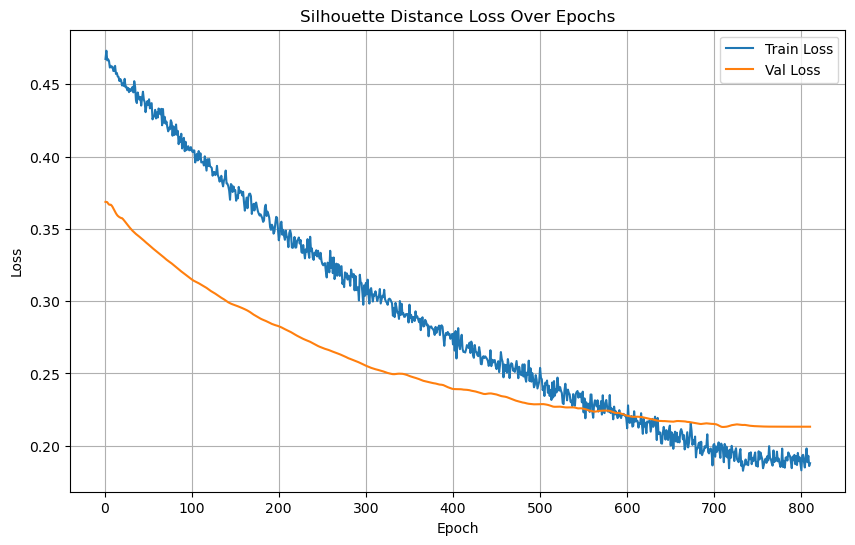

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/843], Loss: 0.1053


Test Batch [20/843], Loss: 0.1582
Test Batch [30/843], Loss: 0.1480
Test Batch [40/843], Loss: 0.1712
Test Batch [50/843], Loss: 0.1649
Test Batch [60/843], Loss: 0.1529
Test Batch [70/843], Loss: 0.5000


Test Batch [80/843], Loss: 0.1559
Test Batch [90/843], Loss: 0.1193
Test Batch [100/843], Loss: 0.2576
Test Batch [110/843], Loss: 0.5000
Test Batch [120/843], Loss: 0.1675
Test Batch [130/843], Loss: 0.1255
Test Batch [140/843], Loss: 0.1135
Test Batch [150/843], Loss: 0.1616
Test Batch [160/843], Loss: 0.1758


Test Batch [170/843], Loss: 0.1314
Test Batch [180/843], Loss: 0.1536
Test Batch [190/843], Loss: 0.1679
Test Batch [200/843], Loss: 0.0641
Test Batch [210/843], Loss: 0.0721


Test Batch [220/843], Loss: 0.0944
Test Batch [230/843], Loss: 0.1001
Test Batch [240/843], Loss: 0.1186
Test Batch [250/843], Loss: 0.1055


Test Batch [260/843], Loss: 0.1965
Test Batch [270/843], Loss: 0.1770
Test Batch [280/843], Loss: 0.3423
Test Batch [290/843], Loss: 0.1767


Test Batch [300/843], Loss: 0.2232
Test Batch [310/843], Loss: 0.2778
Test Batch [320/843], Loss: 0.1635
Test Batch [330/843], Loss: 0.2757
Test Batch [340/843], Loss: 0.2079
Test Batch [350/843], Loss: 0.5000
Test Batch [360/843], Loss: 0.0969


Test Batch [370/843], Loss: 0.5000
Test Batch [380/843], Loss: 0.5000
Test Batch [390/843], Loss: 0.5000
Test Batch [400/843], Loss: 0.5000
Test Batch [410/843], Loss: 0.5000
Test Batch [420/843], Loss: 0.5000
Test Batch [430/843], Loss: 0.0804
Test Batch [440/843], Loss: 0.1054
Test Batch [450/843], Loss: 0.1784
Test Batch [460/843], Loss: 0.0805


Test Batch [470/843], Loss: 0.0953
Test Batch [480/843], Loss: 0.1070
Test Batch [490/843], Loss: 0.5000
Test Batch [500/843], Loss: 0.0994
Test Batch [510/843], Loss: 0.0781
Test Batch [520/843], Loss: 0.1014
Test Batch [530/843], Loss: 0.1683
Test Batch [540/843], Loss: 0.1283


Test Batch [550/843], Loss: 0.5000
Test Batch [560/843], Loss: 0.1163
Test Batch [570/843], Loss: 0.1460
Test Batch [580/843], Loss: 0.1311
Test Batch [590/843], Loss: 0.1172
Test Batch [600/843], Loss: 0.5000


Test Batch [610/843], Loss: 0.1601
Test Batch [620/843], Loss: 0.0859
Test Batch [630/843], Loss: 0.1241
Test Batch [640/843], Loss: 0.1331


Test Batch [650/843], Loss: 0.4064
Test Batch [660/843], Loss: 0.4710
Test Batch [670/843], Loss: 0.1043
Test Batch [680/843], Loss: 0.1536


Test Batch [690/843], Loss: 0.3537
Test Batch [700/843], Loss: 0.0935
Test Batch [710/843], Loss: 0.1549
Test Batch [720/843], Loss: 0.0680
Test Batch [730/843], Loss: 0.1832


Test Batch [740/843], Loss: 0.5000
Test Batch [750/843], Loss: 0.5000
Test Batch [760/843], Loss: 0.1278
Test Batch [770/843], Loss: 0.5000
Test Batch [780/843], Loss: 0.2092


Test Batch [790/843], Loss: 0.5000
Test Batch [800/843], Loss: 0.0706
Test Batch [810/843], Loss: 0.1853
Test Batch [820/843], Loss: 0.5000
Test Batch [830/843], Loss: 0.1364
Test Batch [840/843], Loss: 0.5000

Test Loss: 0.2136


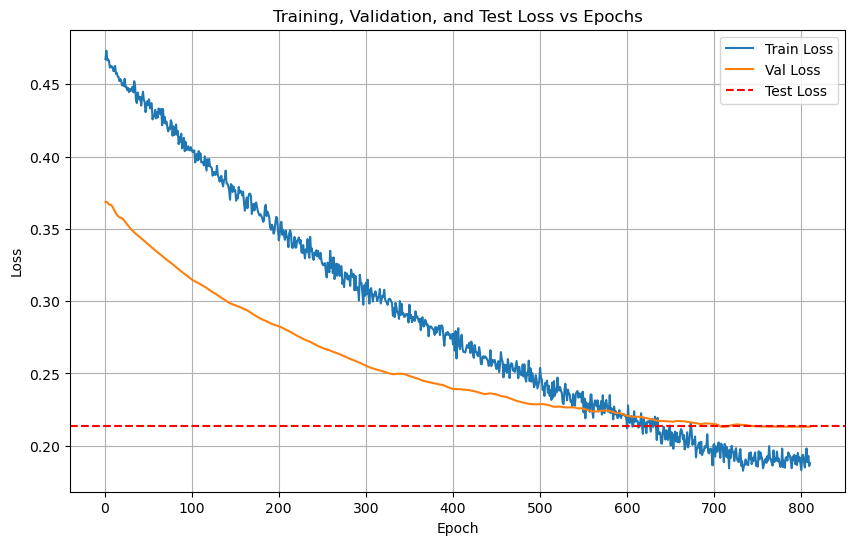

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/843 for test dataset.
  Processed batch 20/843 for test dataset.


  Processed batch 30/843 for test dataset.
  Processed batch 40/843 for test dataset.
  Processed batch 50/843 for test dataset.
  Processed batch 60/843 for test dataset.


  Processed batch 70/843 for test dataset.
  Processed batch 80/843 for test dataset.
  Processed batch 90/843 for test dataset.
  Processed batch 100/843 for test dataset.


  Processed batch 110/843 for test dataset.
  Processed batch 120/843 for test dataset.
  Processed batch 130/843 for test dataset.
  Processed batch 140/843 for test dataset.


  Processed batch 150/843 for test dataset.
  Processed batch 160/843 for test dataset.
  Processed batch 170/843 for test dataset.


  Processed batch 180/843 for test dataset.
  Processed batch 190/843 for test dataset.
  Processed batch 200/843 for test dataset.


  Processed batch 210/843 for test dataset.
  Processed batch 220/843 for test dataset.


  Processed batch 230/843 for test dataset.
  Processed batch 240/843 for test dataset.
  Processed batch 250/843 for test dataset.


  Processed batch 260/843 for test dataset.
  Processed batch 270/843 for test dataset.
  Processed batch 280/843 for test dataset.
  Processed batch 290/843 for test dataset.


  Processed batch 300/843 for test dataset.
  Processed batch 310/843 for test dataset.
  Processed batch 320/843 for test dataset.
  Processed batch 330/843 for test dataset.


  Processed batch 340/843 for test dataset.
  Processed batch 350/843 for test dataset.
  Processed batch 360/843 for test dataset.


  Processed batch 370/843 for test dataset.
  Processed batch 380/843 for test dataset.
  Processed batch 390/843 for test dataset.
  Processed batch 400/843 for test dataset.


  Processed batch 410/843 for test dataset.
  Processed batch 420/843 for test dataset.
  Processed batch 430/843 for test dataset.


  Processed batch 440/843 for test dataset.
  Processed batch 450/843 for test dataset.
  Processed batch 460/843 for test dataset.
  Processed batch 470/843 for test dataset.


  Processed batch 480/843 for test dataset.
  Processed batch 490/843 for test dataset.
  Processed batch 500/843 for test dataset.
  Processed batch 510/843 for test dataset.


  Processed batch 520/843 for test dataset.
  Processed batch 530/843 for test dataset.
  Processed batch 540/843 for test dataset.


  Processed batch 550/843 for test dataset.
  Processed batch 560/843 for test dataset.
  Processed batch 570/843 for test dataset.
  Processed batch 580/843 for test dataset.


  Processed batch 590/843 for test dataset.
  Processed batch 600/843 for test dataset.
  Processed batch 610/843 for test dataset.
  Processed batch 620/843 for test dataset.


  Processed batch 630/843 for test dataset.
  Processed batch 640/843 for test dataset.
  Processed batch 650/843 for test dataset.
  Processed batch 660/843 for test dataset.


  Processed batch 670/843 for test dataset.
  Processed batch 680/843 for test dataset.
  Processed batch 690/843 for test dataset.


  Processed batch 700/843 for test dataset.
  Processed batch 710/843 for test dataset.
  Processed batch 720/843 for test dataset.
  Processed batch 730/843 for test dataset.


  Processed batch 740/843 for test dataset.
  Processed batch 750/843 for test dataset.
  Processed batch 760/843 for test dataset.
  Processed batch 770/843 for test dataset.


  Processed batch 780/843 for test dataset.
  Processed batch 790/843 for test dataset.
  Processed batch 800/843 for test dataset.


  Processed batch 810/843 for test dataset.
  Processed batch 820/843 for test dataset.
  Processed batch 830/843 for test dataset.


  Processed batch 840/843 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (160, 128)
Train labels shape: (160,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53889, 128)
Test labels shape: (53889,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 88.75%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      0.80      0.89         5
           7       0.60      0.60      0.60         5
           8       1.00      1.00      1.00         5
           9       0.67      0.80      0.73         5
          10       0.80      0.80      0.80         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       1.0

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (160, 128)
Train labels shape: (160,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53889, 128)
Test labels shape: (53889,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 3.1818  |  Val Loss: 3.1694
Validation loss improved from inf to 3.1694.
[Epoch 2/1000] Train Loss: 3.1432  |  Val Loss: 3.1313
Validation loss improved from 3.1694 to 3.1313.
[Epoch 3/1000] Train Loss: 3.1020  |  Val Loss: 3.0954
Validation loss improved from 3.1313 to 3.0954.
[Epoch 4/1000] Train Loss: 3.0661  |  Val Loss: 3.0599
Validation loss improved from 3.0954 to 3.0599.
[Epoch 5/1000] Train Loss: 3.0322  |  Val Loss: 3.0249
Validation loss improved from 3.0599 to 3.0249.
[Epoch 6/1000] Train Loss: 2.9958  |  Val Loss: 2.9922
Validation loss improved from 3.0249 to 2.9922.
[Epoch 7/1000] Train Loss: 2.9644  |  Val Loss: 2.9596
Validation loss improved from 2.9922 to 2.9596.
[Epoch 8/1000] Train Loss: 2.9313  |  Val Loss: 2.9281
Validation loss improved from 2.9596 to 2.9281.
[Epoch 9/1000] Train Loss: 2.9013  |  Val Loss: 2.8972
Validation loss improved from 2.9281 to 2.8972.
[Epoch 10/1000] Train Loss: 2.8700  |  Val Loss: 2.8675
Validation loss impr

[Epoch 25/1000] Train Loss: 2.5066  |  Val Loss: 2.5210
Validation loss improved from 2.5399 to 2.5210.


[Epoch 26/1000] Train Loss: 2.4865  |  Val Loss: 2.5025
Validation loss improved from 2.5210 to 2.5025.
[Epoch 27/1000] Train Loss: 2.4668  |  Val Loss: 2.4840
Validation loss improved from 2.5025 to 2.4840.
[Epoch 28/1000] Train Loss: 2.4464  |  Val Loss: 2.4653
Validation loss improved from 2.4840 to 2.4653.
[Epoch 29/1000] Train Loss: 2.4275  |  Val Loss: 2.4464
Validation loss improved from 2.4653 to 2.4464.
[Epoch 30/1000] Train Loss: 2.4079  |  Val Loss: 2.4279
Validation loss improved from 2.4464 to 2.4279.
[Epoch 31/1000] Train Loss: 2.3879  |  Val Loss: 2.4097
Validation loss improved from 2.4279 to 2.4097.
[Epoch 32/1000] Train Loss: 2.3689  |  Val Loss: 2.3918
Validation loss improved from 2.4097 to 2.3918.
[Epoch 33/1000] Train Loss: 2.3498  |  Val Loss: 2.3746
Validation loss improved from 2.3918 to 2.3746.
[Epoch 34/1000] Train Loss: 2.3310  |  Val Loss: 2.3582
Validation loss improved from 2.3746 to 2.3582.
[Epoch 35/1000] Train Loss: 2.3135  |  Val Loss: 2.3418
Validati

[Epoch 55/1000] Train Loss: 1.9448  |  Val Loss: 2.0132
Validation loss improved from 2.0298 to 2.0132.
[Epoch 56/1000] Train Loss: 1.9268  |  Val Loss: 1.9966
Validation loss improved from 2.0132 to 1.9966.
[Epoch 57/1000] Train Loss: 1.9081  |  Val Loss: 1.9802
Validation loss improved from 1.9966 to 1.9802.
[Epoch 58/1000] Train Loss: 1.8903  |  Val Loss: 1.9637
Validation loss improved from 1.9802 to 1.9637.
[Epoch 59/1000] Train Loss: 1.8717  |  Val Loss: 1.9474
Validation loss improved from 1.9637 to 1.9474.
[Epoch 60/1000] Train Loss: 1.8538  |  Val Loss: 1.9308
Validation loss improved from 1.9474 to 1.9308.
[Epoch 61/1000] Train Loss: 1.8350  |  Val Loss: 1.9144
Validation loss improved from 1.9308 to 1.9144.
[Epoch 62/1000] Train Loss: 1.8172  |  Val Loss: 1.8976
Validation loss improved from 1.9144 to 1.8976.
[Epoch 63/1000] Train Loss: 1.7984  |  Val Loss: 1.8809
Validation loss improved from 1.8976 to 1.8809.
[Epoch 64/1000] Train Loss: 1.7800  |  Val Loss: 1.8641
Validati

[Epoch 85/1000] Train Loss: 1.3758  |  Val Loss: 1.5073
Validation loss improved from 1.5244 to 1.5073.
[Epoch 86/1000] Train Loss: 1.3568  |  Val Loss: 1.4904
Validation loss improved from 1.5073 to 1.4904.
[Epoch 87/1000] Train Loss: 1.3382  |  Val Loss: 1.4735
Validation loss improved from 1.4904 to 1.4735.
[Epoch 88/1000] Train Loss: 1.3197  |  Val Loss: 1.4568
Validation loss improved from 1.4735 to 1.4568.
[Epoch 89/1000] Train Loss: 1.3014  |  Val Loss: 1.4400
Validation loss improved from 1.4568 to 1.4400.
[Epoch 90/1000] Train Loss: 1.2830  |  Val Loss: 1.4236
Validation loss improved from 1.4400 to 1.4236.
[Epoch 91/1000] Train Loss: 1.2651  |  Val Loss: 1.4072
Validation loss improved from 1.4236 to 1.4072.
[Epoch 92/1000] Train Loss: 1.2467  |  Val Loss: 1.3910
Validation loss improved from 1.4072 to 1.3910.
[Epoch 93/1000] Train Loss: 1.2290  |  Val Loss: 1.3749
Validation loss improved from 1.3910 to 1.3749.
[Epoch 94/1000] Train Loss: 1.2115  |  Val Loss: 1.3589
Validati

[Epoch 115/1000] Train Loss: 0.8708  |  Val Loss: 1.0519
Validation loss improved from 1.0653 to 1.0519.
[Epoch 116/1000] Train Loss: 0.8556  |  Val Loss: 1.0389
Validation loss improved from 1.0519 to 1.0389.
[Epoch 117/1000] Train Loss: 0.8410  |  Val Loss: 1.0258
Validation loss improved from 1.0389 to 1.0258.
[Epoch 118/1000] Train Loss: 0.8263  |  Val Loss: 1.0129
Validation loss improved from 1.0258 to 1.0129.
[Epoch 119/1000] Train Loss: 0.8118  |  Val Loss: 0.9999
Validation loss improved from 1.0129 to 0.9999.
[Epoch 120/1000] Train Loss: 0.7973  |  Val Loss: 0.9870
Validation loss improved from 0.9999 to 0.9870.
[Epoch 121/1000] Train Loss: 0.7827  |  Val Loss: 0.9742
Validation loss improved from 0.9870 to 0.9742.
[Epoch 122/1000] Train Loss: 0.7683  |  Val Loss: 0.9613
Validation loss improved from 0.9742 to 0.9613.
[Epoch 123/1000] Train Loss: 0.7532  |  Val Loss: 0.9487
Validation loss improved from 0.9613 to 0.9487.
[Epoch 124/1000] Train Loss: 0.7390  |  Val Loss: 0.936

[Epoch 145/1000] Train Loss: 0.4822  |  Val Loss: 0.7161
Validation loss improved from 0.7246 to 0.7161.
[Epoch 146/1000] Train Loss: 0.4724  |  Val Loss: 0.7078
Validation loss improved from 0.7161 to 0.7078.
[Epoch 147/1000] Train Loss: 0.4630  |  Val Loss: 0.6996
Validation loss improved from 0.7078 to 0.6996.
[Epoch 148/1000] Train Loss: 0.4533  |  Val Loss: 0.6917
Validation loss improved from 0.6996 to 0.6917.
[Epoch 149/1000] Train Loss: 0.4443  |  Val Loss: 0.6837
Validation loss improved from 0.6917 to 0.6837.
[Epoch 150/1000] Train Loss: 0.4349  |  Val Loss: 0.6760
Validation loss improved from 0.6837 to 0.6760.
[Epoch 151/1000] Train Loss: 0.4258  |  Val Loss: 0.6682
Validation loss improved from 0.6760 to 0.6682.
[Epoch 152/1000] Train Loss: 0.4168  |  Val Loss: 0.6605
Validation loss improved from 0.6682 to 0.6605.
[Epoch 153/1000] Train Loss: 0.4081  |  Val Loss: 0.6532
Validation loss improved from 0.6605 to 0.6532.
[Epoch 154/1000] Train Loss: 0.3996  |  Val Loss: 0.645

[Epoch 172/1000] Train Loss: 0.2766  |  Val Loss: 0.5410
Validation loss improved from 0.5457 to 0.5410.
[Epoch 173/1000] Train Loss: 0.2713  |  Val Loss: 0.5365
Validation loss improved from 0.5410 to 0.5365.
[Epoch 174/1000] Train Loss: 0.2662  |  Val Loss: 0.5320
Validation loss improved from 0.5365 to 0.5320.
[Epoch 175/1000] Train Loss: 0.2610  |  Val Loss: 0.5275
Validation loss improved from 0.5320 to 0.5275.
[Epoch 176/1000] Train Loss: 0.2561  |  Val Loss: 0.5232
Validation loss improved from 0.5275 to 0.5232.
[Epoch 177/1000] Train Loss: 0.2514  |  Val Loss: 0.5190
Validation loss improved from 0.5232 to 0.5190.
[Epoch 178/1000] Train Loss: 0.2467  |  Val Loss: 0.5151
Validation loss improved from 0.5190 to 0.5151.
[Epoch 179/1000] Train Loss: 0.2420  |  Val Loss: 0.5113
Validation loss improved from 0.5151 to 0.5113.
[Epoch 180/1000] Train Loss: 0.2376  |  Val Loss: 0.5078
Validation loss improved from 0.5113 to 0.5078.
[Epoch 181/1000] Train Loss: 0.2333  |  Val Loss: 0.504

[Epoch 198/1000] Train Loss: 0.1731  |  Val Loss: 0.4579
Validation loss improved from 0.4599 to 0.4579.
[Epoch 199/1000] Train Loss: 0.1704  |  Val Loss: 0.4558
Validation loss improved from 0.4579 to 0.4558.
[Epoch 200/1000] Train Loss: 0.1674  |  Val Loss: 0.4535
Validation loss improved from 0.4558 to 0.4535.
[Epoch 201/1000] Train Loss: 0.1648  |  Val Loss: 0.4514
Validation loss improved from 0.4535 to 0.4514.
[Epoch 202/1000] Train Loss: 0.1621  |  Val Loss: 0.4493
Validation loss improved from 0.4514 to 0.4493.
[Epoch 203/1000] Train Loss: 0.1595  |  Val Loss: 0.4473
Validation loss improved from 0.4493 to 0.4473.
[Epoch 204/1000] Train Loss: 0.1570  |  Val Loss: 0.4455
Validation loss improved from 0.4473 to 0.4455.
[Epoch 205/1000] Train Loss: 0.1545  |  Val Loss: 0.4439
Validation loss improved from 0.4455 to 0.4439.
[Epoch 206/1000] Train Loss: 0.1521  |  Val Loss: 0.4419
Validation loss improved from 0.4439 to 0.4419.
[Epoch 207/1000] Train Loss: 0.1497  |  Val Loss: 0.440

[Epoch 227/1000] Train Loss: 0.1120  |  Val Loss: 0.4174
Validation loss improved from 0.4181 to 0.4174.
[Epoch 228/1000] Train Loss: 0.1105  |  Val Loss: 0.4167
Validation loss improved from 0.4174 to 0.4167.
[Epoch 229/1000] Train Loss: 0.1091  |  Val Loss: 0.4160
Validation loss improved from 0.4167 to 0.4160.
[Epoch 230/1000] Train Loss: 0.1076  |  Val Loss: 0.4153
Validation loss improved from 0.4160 to 0.4153.
[Epoch 231/1000] Train Loss: 0.1062  |  Val Loss: 0.4145
Validation loss improved from 0.4153 to 0.4145.
[Epoch 232/1000] Train Loss: 0.1049  |  Val Loss: 0.4136
Validation loss improved from 0.4145 to 0.4136.
[Epoch 233/1000] Train Loss: 0.1035  |  Val Loss: 0.4131
Validation loss improved from 0.4136 to 0.4131.
[Epoch 234/1000] Train Loss: 0.1022  |  Val Loss: 0.4124
Validation loss improved from 0.4131 to 0.4124.
[Epoch 235/1000] Train Loss: 0.1008  |  Val Loss: 0.4114
Validation loss improved from 0.4124 to 0.4114.
[Epoch 236/1000] Train Loss: 0.0996  |  Val Loss: 0.410

[Epoch 255/1000] Train Loss: 0.0794  |  Val Loss: 0.4018
Validation loss improved from 0.4021 to 0.4018.
[Epoch 256/1000] Train Loss: 0.0785  |  Val Loss: 0.4016
Validation loss improved from 0.4018 to 0.4016.
[Epoch 257/1000] Train Loss: 0.0777  |  Val Loss: 0.4015
Validation loss improved from 0.4016 to 0.4015.
[Epoch 258/1000] Train Loss: 0.0768  |  Val Loss: 0.4011
Validation loss improved from 0.4015 to 0.4011.
[Epoch 259/1000] Train Loss: 0.0760  |  Val Loss: 0.4008
Validation loss improved from 0.4011 to 0.4008.
[Epoch 260/1000] Train Loss: 0.0752  |  Val Loss: 0.4006
Validation loss improved from 0.4008 to 0.4006.
[Epoch 261/1000] Train Loss: 0.0744  |  Val Loss: 0.4003
Validation loss improved from 0.4006 to 0.4003.
[Epoch 262/1000] Train Loss: 0.0736  |  Val Loss: 0.3999
Validation loss improved from 0.4003 to 0.3999.
[Epoch 263/1000] Train Loss: 0.0728  |  Val Loss: 0.3999
Validation loss improved from 0.3999 to 0.3999.
[Epoch 264/1000] Train Loss: 0.0721  |  Val Loss: 0.399

[Epoch 286/1000] Train Loss: 0.0574  |  Val Loss: 0.3957
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 287/1000] Train Loss: 0.0568  |  Val Loss: 0.3958
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 288/1000] Train Loss: 0.0563  |  Val Loss: 0.3958
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 289/1000] Train Loss: 0.0557  |  Val Loss: 0.3960
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 290/1000] Train Loss: 0.0552  |  Val Loss: 0.3961
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 291/1000] Train Loss: 0.0547  |  Val Loss: 0.3963
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 292/1000] Train Loss: 0.0542  |  Val Loss: 0.3964
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 293/1000] Train Loss: 0.0537  |  Val Loss: 0.3965
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 294/1000] Train Loss: 0.0531  |  Val Loss: 0.3966
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 312/1000] Train Loss: 0.0452  |  Val Loss: 0.3999
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 313/1000] Train Loss: 0.0448  |  Val Loss: 0.4000
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 314/1000] Train Loss: 0.0445  |  Val Loss: 0.4001
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 315/1000] Train Loss: 0.0441  |  Val Loss: 0.4003
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 316/1000] Train Loss: 0.0437  |  Val Loss: 0.4004
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 317/1000] Train Loss: 0.0433  |  Val Loss: 0.4004
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 318/1000] Train Loss: 0.0430  |  Val Loss: 0.4006
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 319/1000] Train Loss: 0.0426  |  Val Loss: 0.4008
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 320/1000] Train Loss: 0.0423  |  Val Loss: 0.4010
!! Validation loss did NOT improve !! Patience:

[Epoch 339/1000] Train Loss: 0.0361  |  Val Loss: 0.4032
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 340/1000] Train Loss: 0.0358  |  Val Loss: 0.4034
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 341/1000] Train Loss: 0.0356  |  Val Loss: 0.4037
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 342/1000] Train Loss: 0.0353  |  Val Loss: 0.4040
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 343/1000] Train Loss: 0.0350  |  Val Loss: 0.4043
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 344/1000] Train Loss: 0.0347  |  Val Loss: 0.4045
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 345/1000] Train Loss: 0.0344  |  Val Loss: 0.4048
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 346/1000] Train Loss: 0.0342  |  Val Loss: 0.4051
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 347/1000] Train Loss: 0.0339  |  Val Loss: 0.4053
!! Validation loss did NOT improve !! Patience:

[Epoch 371/1000] Train Loss: 0.0282  |  Val Loss: 0.4099
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 372/1000] Train Loss: 0.0280  |  Val Loss: 0.4100
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 373/1000] Train Loss: 0.0279  |  Val Loss: 0.4103
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 374/1000] Train Loss: 0.0276  |  Val Loss: 0.4105
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 375/1000] Train Loss: 0.0274  |  Val Loss: 0.4106
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 376/1000] Train Loss: 0.0272  |  Val Loss: 0.4107
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 377/1000] Train Loss: 0.0270  |  Val Loss: 0.4107
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 378/1000] Train Loss: 0.0268  |  Val Loss: 0.4110
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 379/1000] Train Loss: 0.0266  |  Val Loss: 0.4111
!! Validation loss did NOT improve !! Patience:

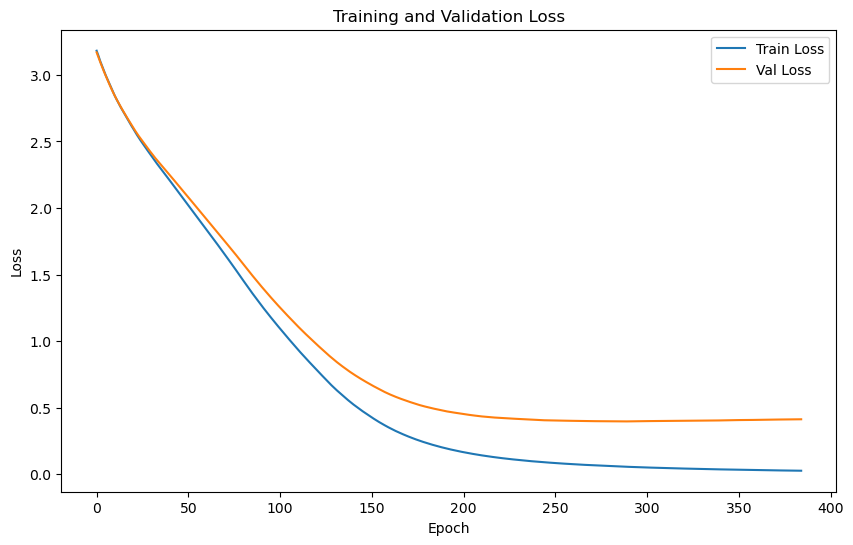

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.8837 | Test Accuracy: 81.89%


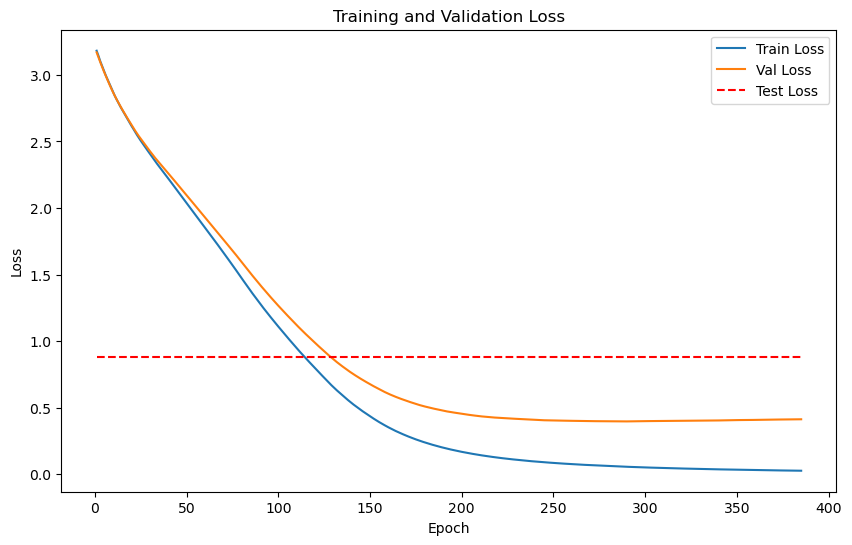

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


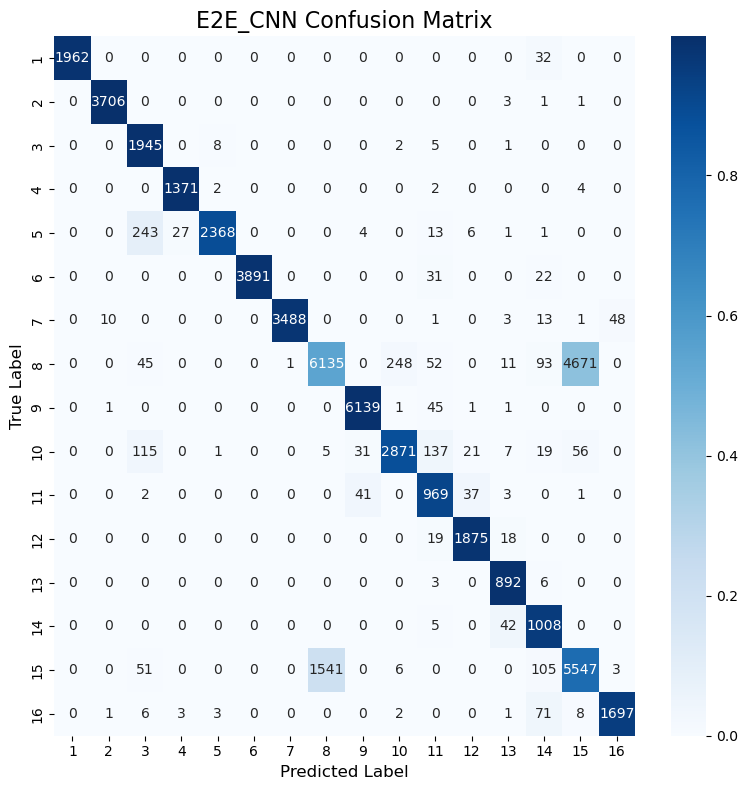

Classification Accuracy: 85.11%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


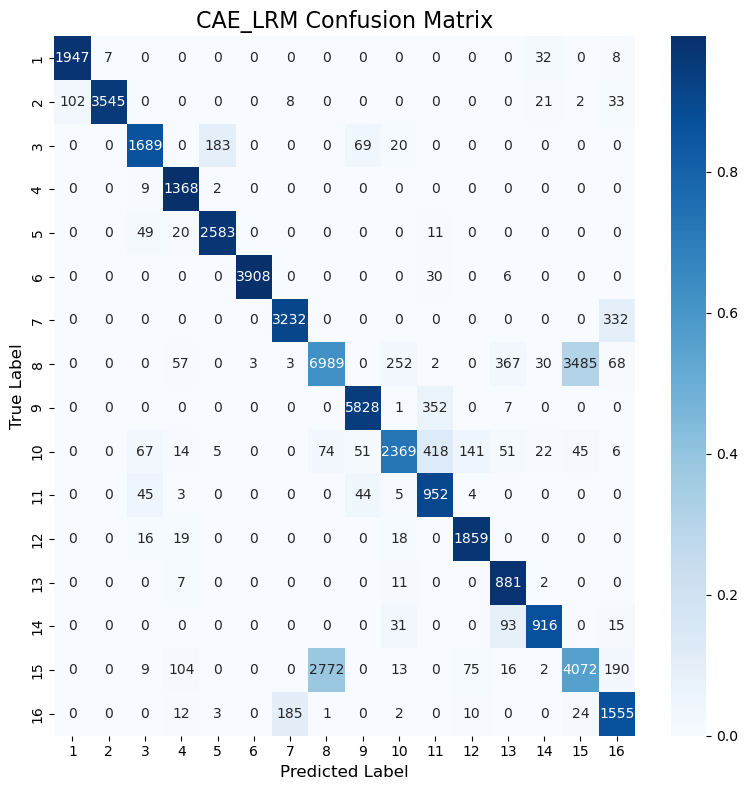

Classification Accuracy: 81.08%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


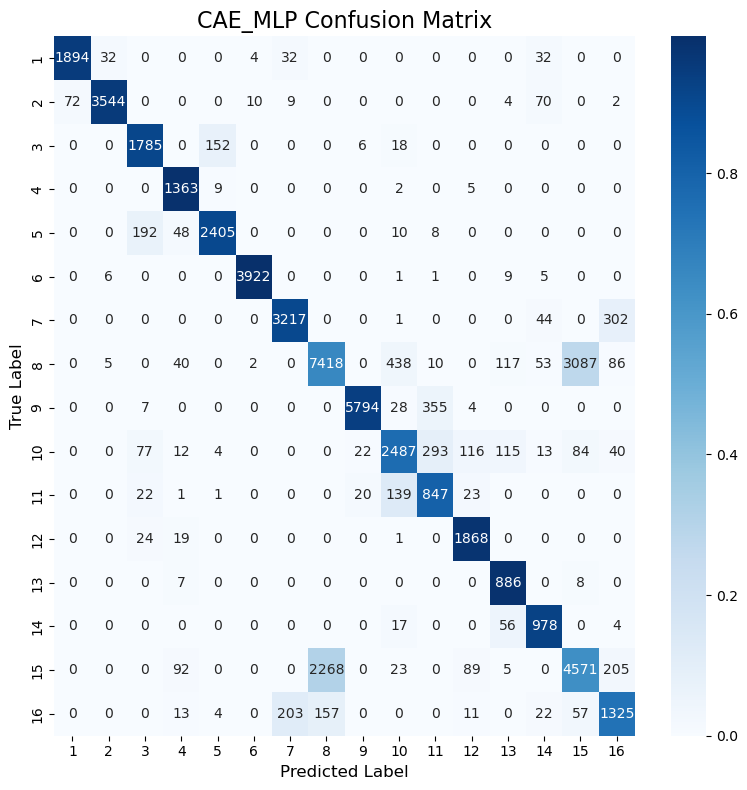

Classification Accuracy: 82.21%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


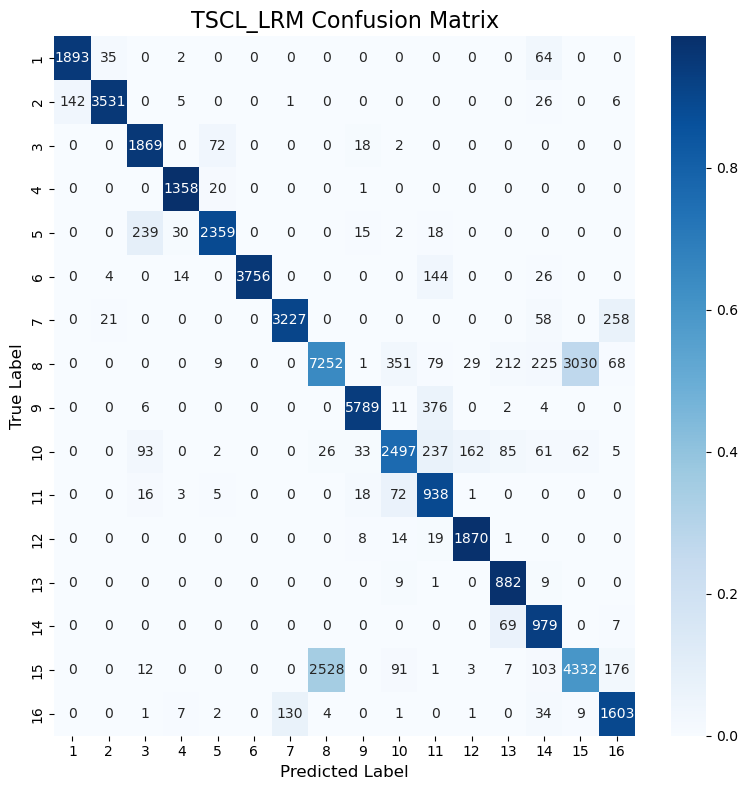

Classification Accuracy: 81.90%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


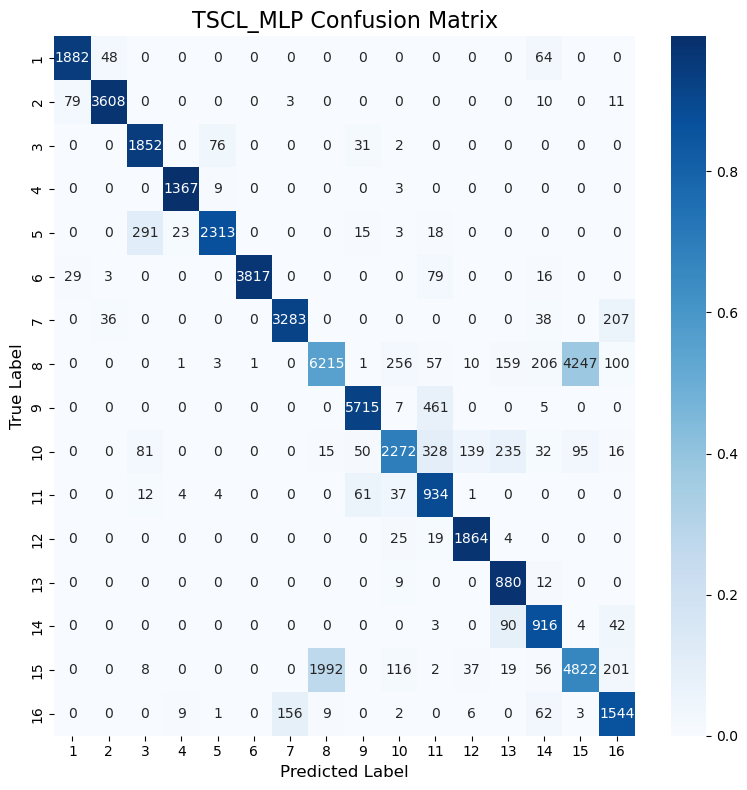

Classification Accuracy: 80.32%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


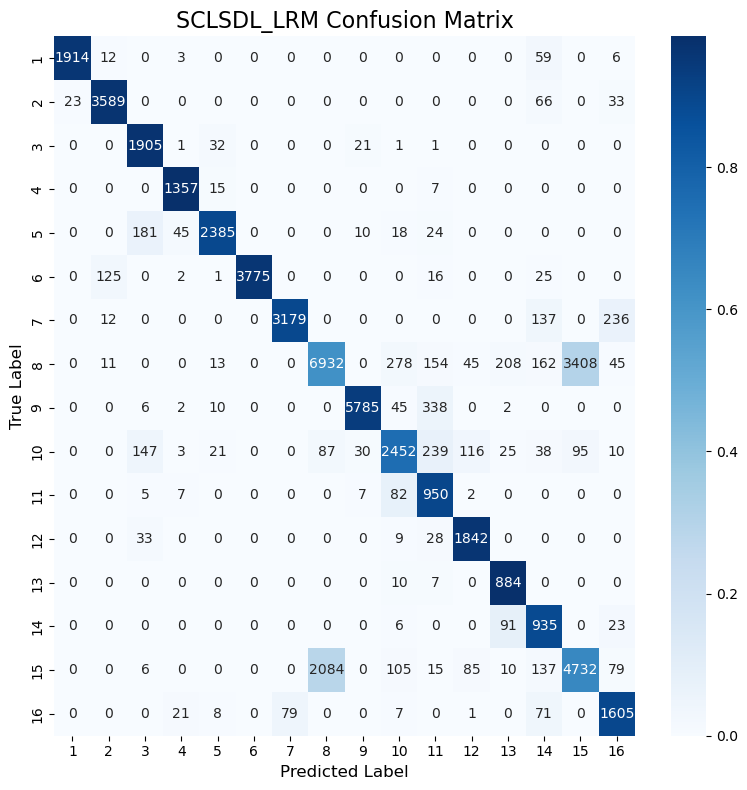

Classification Accuracy: 82.06%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


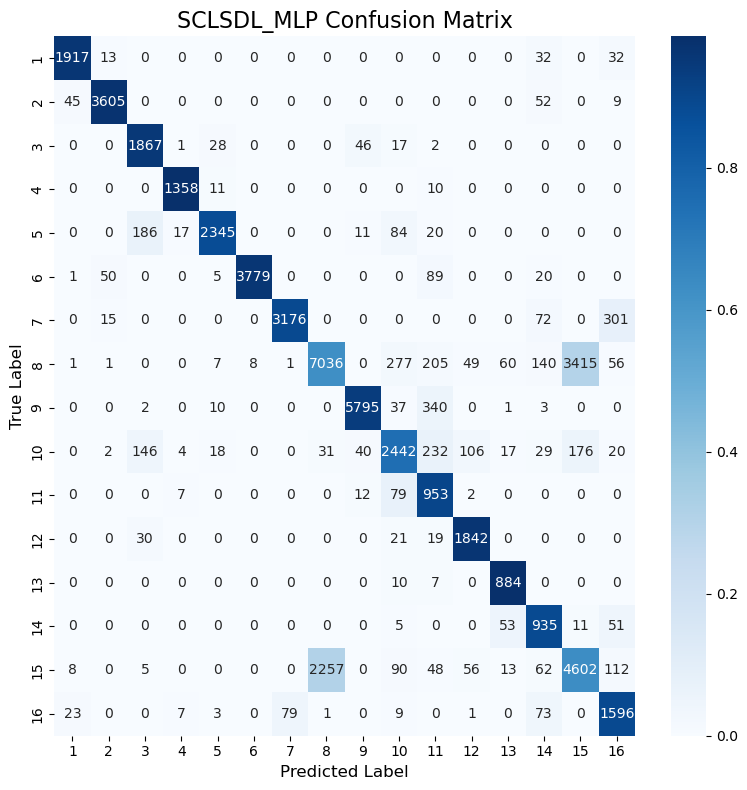

Classification Accuracy: 81.89%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          85.11
1    LRM (CAE)          81.08
2    MLP (CAE)          82.21
3     TSCL LRM          81.90
4     TSCL MLP          80.32
5  SCL_SDL LRM          82.06
6  SCL_SDL MLP          81.89

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          85.11
2    MLP (CAE)          82.21
5  SCL_SDL LRM          82.06
3     TSCL LRM          81.90
6  SCL_SDL MLP          81.89
1    LRM (CAE)          81.08
4     TSCL MLP          80.32
